In [1]:
!pip install pyro-ppl torch scikit-learn anndata pandas numpy matplotlib seaborn scanpy --quiet

In [2]:
import pathlib
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad

adata = sc.read_h5ad("/home/jhaberbe/Projects/nb-gaussian-processes/data/16APR2025.h5ad")

/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Question

Given neurons that appear to have oxidative cell stress, do astrocytes tend to accumulate more and larger lipid droplets, indicative of a transfer mechanism from neurons to astrocytes.

In [330]:
import torch
subset = adata[adata.obs["cell_type"].eq("Astrocyte") & adata.obs["folder"].eq("05-27")]
neurons = adata[adata.obs["cell_type"].isin(["L2/3 IT", "L4 IT", "L6b"]) & adata.obs["folder"].eq("05-27")]

In [ ]:
neurons_coordinates = torch.tensor(astrocytes.obs[["x_centroid", "y_centroid"]].values).float()

subset = adata[adata.obs["cell_type"].eq("Astrocyte") & adata.obs["folder"].eq("05-27")]
coordinates = torch.tensor(subset.obs[["x_centroid", "y_centroid"]].values).float()
counts = torch.tensor(subset.layers["transcript"]).float()
size_factor = torch.log(counts.sum(axis=1) / counts.sum(axis=1).mean()).float()

In [370]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.nn.module import PyroSample
from pyro.contrib.gp.kernels import Matern52
from pyro.contrib.gp.models import VariationalSparseGP
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO
from pyro.optim import Adam
from sklearn.cluster import KMeans

class SpatialNegativeBinomialGP:
    def __init__(self, coordinates, counts, size_factor, num_inducing=100, learning_rate=1e-2, jitter=1e-3, seed=0, device="cuda"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.coordinates = coordinates.to(self.device)
        self.counts = counts.to(self.device)
        self.size_factor = size_factor.to(self.device)
        self.num_inducing = num_inducing
        self.learning_rate = learning_rate
        self.jitter = jitter

        # Init randomness
        pyro.set_rng_seed(seed)
        pyro.clear_param_store()

        # Inducing inputs via KMeans
        self.inducing_inputs = self._init_inducing_inputs()

        # Kernel setup
        self.kernel = Matern52(input_dim=self.coordinates.size(1))
        self.kernel.lengthscale = pyro.param("lengthscale", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
        self.kernel.variance = pyro.param("variance", torch.tensor(1.0, device=self.device), constraint=constraints.positive)

        # GP model
        self.model = VariationalSparseGP(
            X=self.coordinates,
            y=None,
            kernel=self.kernel,
            Xu=self.inducing_inputs,
            likelihood=None,
            latent_shape=torch.Size([1]),
            whiten=True,
            jitter=self.jitter,
        )

        # Optimizer + SVI
        self.optimizer = Adam({"lr": self.learning_rate})
        self.svi = SVI(self.model_fn, self.guide_fn, self.optimizer, loss=JitTrace_ELBO())

    def _init_inducing_inputs(self):
        kmeans = KMeans(n_clusters=self.num_inducing).fit(self.coordinates.cpu().numpy())
        return torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device=self.device)

    def model_fn(self, coordinates, counts):
        r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
        f_loc, _ = self.model(coordinates)
        f_loc = torch.clamp(f_loc, -10, 10)
        pyro.sample("counts", dist.NegativeBinomial(total_count=r, logits=self.size_factor + f_loc).to_event(1), obs=counts)

    def guide_fn(self, coordinates, counts):
        return self.model.guide()

    def train(self, num_steps=1000, verbose=True):
        for i in range(num_steps):
            loss = self.svi.step(self.coordinates, self.counts)
            if verbose and i % 200 == 0:
                r_val = pyro.param("r").item()
                print(f"[{i}] ELBO: {-loss:.2f} | r={r_val:.3f}")

    def predict(self, Xnew=None):
        Xnew = self.coordinates if Xnew is None else Xnew.to(self.device)
        with torch.no_grad():
            f_loc, f_var = self.model(Xnew)
            return f_loc, f_var

    def get_dispersion(self):
        return pyro.param("r").item()

    def get_kernel_params(self):
        return {
            "lengthscale": self.kernel.lengthscale.item(),
            "variance": self.kernel.variance.item(),
        }

In [371]:
adata.obs["cell_group"] = adata.obs["cell_type"].replace({
    "L2/3 IT": "Excitatory Neuron",
    "L4 IT": "Excitatory Neuron",
    "L6b": "Excitatory Neuron",
    "Microglia-PVM": "Immune",
    "Macrophage": "Immune",
})

/tmp/ipykernel_228426/2521427968.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["cell_group"] = adata.obs["cell_type"].replace({


In [ ]:
import matplotlib.pyplot as plt

for cell_type in ["Astrocyte"]:
    for folder in ["05-27"]:
        subset = adata[adata.obs["cell_group"].eq(cell_type) & adata.obs["folder"].eq(folder)]
        coordinates = torch.tensor(subset.obs[["x_centroid", "y_centroid"]].values).float()
        counts = torch.tensor(subset.layers["transcript"]).float()
        size_factor = torch.log(counts.sum(axis=1) / counts.sum(axis=1).mean()).float()

        for i in range(len(adata.var_names)):
            if ((subset.X > 0).mean(axis=1) > 0.05)[i]:
                snbgp = SpatialNegativeBinomialGP(coordinates=coordinates, counts=counts[:, i], size_factor=size_factor)
                snbgp.train(5_000)

                subset.obs["predicted_logit"] = snbgp.predict(coordinates)[0].cpu().detach().numpy().reshape(-1)
                subset.obs.plot.scatter(
                    x="x_centroid",
                    y="y_centroid",
                    c=np.clip(subset.obs["predicted_logit"], -5, 10),
                    s=3,
                    cmap="bwr"
                )
                plt.savefig(f"/home/jhaberbe/Projects/nb-gaussian-processes/figures/{folder}_{cell_type}_{adata.var_names[i]}.svg")
                plt.close()

/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7109.44 | r=0.990
[200] ELBO: -4864.61 | r=0.342
[400] ELBO: -4565.04 | r=0.329
[600] ELBO: -4179.69 | r=0.555
[800] ELBO: -3912.95 | r=0.837
[1000] ELBO: -3664.86 | r=1.144
[1200] ELBO: -3459.75 | r=1.461
[1400] ELBO: -3256.65 | r=1.778
[1600] ELBO: -3049.04 | r=2.092
[1800] ELBO: -2830.16 | r=2.401
[2000] ELBO: -2626.10 | r=2.702
[2200] ELBO: -2436.73 | r=2.996
[2400] ELBO: -2238.58 | r=3.281
[2600] ELBO: -2031.03 | r=3.557
[2800] ELBO: -1823.80 | r=3.824
[3000] ELBO: -1628.83 | r=4.080
[3200] ELBO: -1409.57 | r=4.325
[3400] ELBO: -1228.50 | r=4.558
[3600] ELBO: -1032.11 | r=4.778
[3800] ELBO: -829.00 | r=4.985
[4000] ELBO: -629.60 | r=5.178
[4200] ELBO: -428.96 | r=5.357
[4400] ELBO: -224.10 | r=5.521
[4600] ELBO: -21.60 | r=5.668
[4800] ELBO: 179.22 | r=5.801


/tmp/ipykernel_228426/3173988401.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs["predicted_logit"] = snbgp.predict(coordinates)[0].cpu().detach().numpy().reshape(-1)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/

[0] ELBO: -8289.26 | r=0.990
[200] ELBO: -7283.62 | r=0.525
[400] ELBO: -7052.83 | r=0.542
[600] ELBO: -6795.20 | r=0.582
[800] ELBO: -6198.47 | r=1.788
[1000] ELBO: -5920.87 | r=3.046
[1200] ELBO: -5710.64 | r=4.326
[1400] ELBO: -5506.59 | r=5.621
[1600] ELBO: -5298.74 | r=6.937
[1800] ELBO: -5079.71 | r=8.287
[2000] ELBO: -4875.48 | r=9.680
[2200] ELBO: -4685.88 | r=11.127
[2400] ELBO: -4487.47 | r=12.635
[2600] ELBO: -4279.65 | r=14.213
[2800] ELBO: -4072.18 | r=15.869
[3000] ELBO: -3876.95 | r=17.612
[3200] ELBO: -3657.45 | r=19.450
[3400] ELBO: -3476.14 | r=21.394
[3600] ELBO: -3279.53 | r=23.453
[3800] ELBO: -3076.22 | r=25.636
[4000] ELBO: -2876.61 | r=27.950
[4200] ELBO: -2675.81 | r=30.410
[4400] ELBO: -2470.82 | r=33.022
[4600] ELBO: -2268.17 | r=35.800
[4800] ELBO: -2067.23 | r=38.758


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6666.85 | r=0.990
[200] ELBO: -3534.35 | r=0.290
[400] ELBO: -3051.17 | r=0.284
[600] ELBO: -2799.85 | r=0.360
[800] ELBO: -2572.07 | r=0.457
[1000] ELBO: -2334.34 | r=0.573
[1200] ELBO: -2129.85 | r=0.706
[1400] ELBO: -1924.55 | r=0.851
[1600] ELBO: -1714.21 | r=1.008
[1800] ELBO: -1492.78 | r=1.175
[2000] ELBO: -1286.53 | r=1.351
[2200] ELBO: -1095.35 | r=1.534
[2400] ELBO: -895.69 | r=1.725
[2600] ELBO: -686.92 | r=1.922
[2800] ELBO: -478.65 | r=2.126
[3000] ELBO: -282.83 | r=2.337
[3200] ELBO: -62.85 | r=2.554
[3400] ELBO: 118.80 | r=2.777
[3600] ELBO: 315.74 | r=3.006
[3800] ELBO: 519.31 | r=3.241
[4000] ELBO: 719.10 | r=3.482
[4200] ELBO: 920.07 | r=3.728
[4400] ELBO: 1125.22 | r=3.981
[4600] ELBO: 1327.96 | r=4.239
[4800] ELBO: 1528.99 | r=4.503


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -14788.99 | r=1.010
[200] ELBO: -13761.08 | r=1.653
[400] ELBO: -12556.71 | r=3.532
[600] ELBO: -12237.46 | r=5.934
[800] ELBO: -11997.27 | r=8.059
[1000] ELBO: -11764.82 | r=9.952
[1200] ELBO: -11569.43 | r=11.430
[1400] ELBO: -11372.28 | r=12.514
[1600] ELBO: -11168.23 | r=13.283
[1800] ELBO: -10951.51 | r=13.811
[2000] ELBO: -10748.69 | r=14.165
[2200] ELBO: -10560.02 | r=14.398
[2400] ELBO: -10362.04 | r=14.553
[2600] ELBO: -10154.49 | r=14.658
[2800] ELBO: -9947.13 | r=14.731
[3000] ELBO: -9751.82 | r=14.790
[3200] ELBO: -9532.18 | r=14.840
[3400] ELBO: -9350.66 | r=14.883
[3600] ELBO: -9153.81 | r=14.921
[3800] ELBO: -8950.18 | r=14.961
[4000] ELBO: -8750.27 | r=14.997
[4200] ELBO: -8549.11 | r=15.032
[4400] ELBO: -8343.76 | r=15.066
[4600] ELBO: -8140.80 | r=15.097
[4800] ELBO: -7939.38 | r=15.129


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6518.15 | r=0.990
[200] ELBO: -3055.43 | r=0.277
[400] ELBO: -2520.56 | r=0.252
[600] ELBO: -2290.64 | r=0.291
[800] ELBO: -2079.57 | r=0.340
[1000] ELBO: -1853.16 | r=0.398
[1200] ELBO: -1655.85 | r=0.462
[1400] ELBO: -1455.25 | r=0.532
[1600] ELBO: -1248.12 | r=0.605
[1800] ELBO: -1029.01 | r=0.681
[2000] ELBO: -824.50 | r=0.758
[2200] ELBO: -634.68 | r=0.835
[2400] ELBO: -436.12 | r=0.911
[2600] ELBO: -228.26 | r=0.985
[2800] ELBO: -20.77 | r=1.057
[3000] ELBO: 174.39 | r=1.125
[3200] ELBO: 393.80 | r=1.190
[3400] ELBO: 574.99 | r=1.251
[3600] ELBO: 771.46 | r=1.307
[3800] ELBO: 974.65 | r=1.358
[4000] ELBO: 1174.11 | r=1.404
[4200] ELBO: 1374.83 | r=1.444
[4400] ELBO: 1579.71 | r=1.480
[4600] ELBO: 1782.27 | r=1.510
[4800] ELBO: 1983.13 | r=1.535


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5970.49 | r=0.990
[200] ELBO: -1155.34 | r=0.246
[400] ELBO: -24.95 | r=0.216
[600] ELBO: 200.76 | r=0.215
[800] ELBO: 400.77 | r=0.214
[1000] ELBO: 616.74 | r=0.214
[1200] ELBO: 805.56 | r=0.214
[1400] ELBO: 999.83 | r=0.214
[1600] ELBO: 1202.42 | r=0.215
[1800] ELBO: 1418.36 | r=0.216
[2000] ELBO: 1620.73 | r=0.218
[2200] ELBO: 1809.21 | r=0.219
[2400] ELBO: 2007.02 | r=0.221
[2600] ELBO: 2214.60 | r=0.223
[2800] ELBO: 2422.15 | r=0.225
[3000] ELBO: 2617.65 | r=0.227
[3200] ELBO: 2837.60 | r=0.229
[3400] ELBO: 3019.49 | r=0.231
[3600] ELBO: 3216.78 | r=0.234
[3800] ELBO: 3420.86 | r=0.236
[4000] ELBO: 3621.28 | r=0.238
[4200] ELBO: 3823.01 | r=0.240
[4400] ELBO: 4028.92 | r=0.242
[4600] ELBO: 4232.53 | r=0.244
[4800] ELBO: 4434.45 | r=0.246


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5927.04 | r=0.990
[200] ELBO: -918.94 | r=0.243
[400] ELBO: 247.87 | r=0.222
[600] ELBO: 471.80 | r=0.225
[800] ELBO: 671.24 | r=0.229
[1000] ELBO: 887.33 | r=0.234
[1200] ELBO: 1076.63 | r=0.241
[1400] ELBO: 1271.66 | r=0.248
[1600] ELBO: 1475.22 | r=0.257
[1800] ELBO: 1692.31 | r=0.268
[2000] ELBO: 1895.96 | r=0.281
[2200] ELBO: 2085.85 | r=0.296
[2400] ELBO: 2285.24 | r=0.314
[2600] ELBO: 2494.60 | r=0.335
[2800] ELBO: 2704.07 | r=0.361
[3000] ELBO: 2901.61 | r=0.392
[3200] ELBO: 3123.68 | r=0.431
[3400] ELBO: 3307.70 | r=0.478
[3600] ELBO: 3506.65 | r=0.535
[3800] ELBO: 3707.27 | r=0.606
[4000] ELBO: 3904.34 | r=0.705
[4200] ELBO: 4096.44 | r=0.840
[4400] ELBO: 4305.30 | r=1.033
[4600] ELBO: 4463.09 | r=1.303
[4800] ELBO: 4666.13 | r=1.840


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5986.40 | r=0.990
[200] ELBO: -1163.44 | r=0.246
[400] ELBO: -81.64 | r=0.217
[600] ELBO: 140.83 | r=0.216
[800] ELBO: 338.62 | r=0.215
[1000] ELBO: 553.30 | r=0.214
[1200] ELBO: 741.30 | r=0.214
[1400] ELBO: 935.04 | r=0.214
[1600] ELBO: 1137.28 | r=0.214
[1800] ELBO: 1353.02 | r=0.214
[2000] ELBO: 1555.27 | r=0.214
[2200] ELBO: 1743.69 | r=0.214
[2400] ELBO: 1941.46 | r=0.214
[2600] ELBO: 2149.02 | r=0.213
[2800] ELBO: 2356.55 | r=0.213
[3000] ELBO: 2552.05 | r=0.212
[3200] ELBO: 2771.99 | r=0.212
[3400] ELBO: 2953.88 | r=0.211
[3600] ELBO: 3151.19 | r=0.209
[3800] ELBO: 3355.32 | r=0.208
[4000] ELBO: 3555.82 | r=0.206
[4200] ELBO: 3757.64 | r=0.204
[4400] ELBO: 3963.68 | r=0.201
[4600] ELBO: 4167.46 | r=0.198
[4800] ELBO: 4369.59 | r=0.195


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9528.86 | r=0.990
[200] ELBO: -9116.35 | r=0.746
[400] ELBO: -8898.04 | r=0.752
[600] ELBO: -8678.40 | r=0.754
[800] ELBO: -8474.85 | r=0.754
[1000] ELBO: -8254.38 | r=0.755
[1200] ELBO: -8061.72 | r=0.755
[1400] ELBO: -7863.98 | r=0.756
[1600] ELBO: -7658.82 | r=0.756
[1800] ELBO: -7440.71 | r=0.757
[2000] ELBO: -7236.21 | r=0.757
[2200] ELBO: -7045.63 | r=0.758
[2400] ELBO: -6853.87 | r=0.759
[2600] ELBO: -6644.35 | r=0.759
[2800] ELBO: -6434.31 | r=0.760
[3000] ELBO: -6238.58 | r=0.762
[3200] ELBO: -6017.33 | r=0.760
[3400] ELBO: -5833.88 | r=0.761
[3600] ELBO: -5636.02 | r=0.761
[3800] ELBO: -5430.97 | r=0.761
[4000] ELBO: -5230.41 | r=0.762
[4200] ELBO: -5029.22 | r=0.762
[4400] ELBO: -4822.13 | r=0.762
[4600] ELBO: -4617.49 | r=0.763
[4800] ELBO: -4415.50 | r=0.763


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6075.95 | r=0.990
[200] ELBO: -1492.98 | r=0.250
[400] ELBO: -562.05 | r=0.219
[600] ELBO: -341.45 | r=0.221
[800] ELBO: -143.86 | r=0.225
[1000] ELBO: 70.88 | r=0.230
[1200] ELBO: 259.14 | r=0.235
[1400] ELBO: 453.24 | r=0.242
[1600] ELBO: 655.91 | r=0.249
[1800] ELBO: 872.09 | r=0.257
[2000] ELBO: 1074.78 | r=0.266
[2200] ELBO: 1263.61 | r=0.276
[2400] ELBO: 1461.77 | r=0.286
[2600] ELBO: 1669.71 | r=0.297
[2800] ELBO: 1877.59 | r=0.308
[3000] ELBO: 2073.40 | r=0.321
[3200] ELBO: 2293.63 | r=0.333
[3400] ELBO: 2475.78 | r=0.346
[3600] ELBO: 2673.31 | r=0.360
[3800] ELBO: 2877.62 | r=0.373
[4000] ELBO: 3078.25 | r=0.387
[4200] ELBO: 3280.17 | r=0.401
[4400] ELBO: 3486.27 | r=0.415
[4600] ELBO: 3690.05 | r=0.428
[4800] ELBO: 3892.15 | r=0.441


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6177.45 | r=0.990
[200] ELBO: -1773.11 | r=0.253
[400] ELBO: -891.03 | r=0.218
[600] ELBO: -669.44 | r=0.217
[800] ELBO: -470.13 | r=0.217
[1000] ELBO: -254.12 | r=0.218
[1200] ELBO: -65.29 | r=0.220
[1400] ELBO: 128.72 | r=0.221
[1600] ELBO: 330.88 | r=0.223
[1800] ELBO: 546.32 | r=0.224
[2000] ELBO: 748.13 | r=0.226
[2200] ELBO: 936.00 | r=0.228
[2400] ELBO: 1133.13 | r=0.229
[2600] ELBO: 1339.98 | r=0.231
[2800] ELBO: 1546.74 | r=0.233
[3000] ELBO: 1741.40 | r=0.235
[3200] ELBO: 1960.45 | r=0.236
[3400] ELBO: 2141.40 | r=0.238
[3600] ELBO: 2337.72 | r=0.240
[3800] ELBO: 2540.81 | r=0.241
[4000] ELBO: 2740.22 | r=0.243
[4200] ELBO: 2940.92 | r=0.244
[4400] ELBO: 3145.80 | r=0.245
[4600] ELBO: 3348.38 | r=0.246
[4800] ELBO: 3549.27 | r=0.247


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6368.02 | r=0.990
[200] ELBO: -2643.67 | r=0.270
[400] ELBO: -1986.80 | r=0.250
[600] ELBO: -1760.11 | r=0.285
[800] ELBO: -1551.11 | r=0.329
[1000] ELBO: -1326.04 | r=0.381
[1200] ELBO: -1129.09 | r=0.441
[1400] ELBO: -927.74 | r=0.508
[1600] ELBO: -719.06 | r=0.583
[1800] ELBO: -498.14 | r=0.666
[2000] ELBO: -291.94 | r=0.756
[2200] ELBO: -100.64 | r=0.851
[2400] ELBO: 99.17 | r=0.950
[2600] ELBO: 308.09 | r=1.054
[2800] ELBO: 516.44 | r=1.161
[3000] ELBO: 712.32 | r=1.270
[3200] ELBO: 932.31 | r=1.382
[3400] ELBO: 1113.96 | r=1.495
[3600] ELBO: 1310.81 | r=1.609
[3800] ELBO: 1514.30 | r=1.723
[4000] ELBO: 1714.01 | r=1.837
[4200] ELBO: 1914.91 | r=1.950
[4400] ELBO: 2119.92 | r=2.062
[4600] ELBO: 2322.57 | r=2.173
[4800] ELBO: 2523.52 | r=2.281


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6148.77 | r=0.990
[200] ELBO: -1746.97 | r=0.253
[400] ELBO: -889.29 | r=0.220
[600] ELBO: -671.54 | r=0.224
[800] ELBO: -473.88 | r=0.229
[1000] ELBO: -258.86 | r=0.236
[1200] ELBO: -70.17 | r=0.245
[1400] ELBO: 124.51 | r=0.255
[1600] ELBO: 327.76 | r=0.267
[1800] ELBO: 544.36 | r=0.280
[2000] ELBO: 747.24 | r=0.296
[2200] ELBO: 936.06 | r=0.313
[2400] ELBO: 1134.05 | r=0.332
[2600] ELBO: 1341.67 | r=0.354
[2800] ELBO: 1549.12 | r=0.377
[3000] ELBO: 1744.39 | r=0.402
[3200] ELBO: 1963.99 | r=0.430
[3400] ELBO: 2145.41 | r=0.460
[3600] ELBO: 2342.13 | r=0.492
[3800] ELBO: 2545.58 | r=0.527
[4000] ELBO: 2745.27 | r=0.564
[4200] ELBO: 2946.21 | r=0.603
[4400] ELBO: 3151.27 | r=0.645
[4600] ELBO: 3353.99 | r=0.690
[4800] ELBO: 3554.98 | r=0.737


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6176.55 | r=0.990
[200] ELBO: -1816.98 | r=0.253
[400] ELBO: -893.43 | r=0.217
[600] ELBO: -676.11 | r=0.216
[800] ELBO: -478.93 | r=0.214
[1000] ELBO: -264.62 | r=0.212
[1200] ELBO: -76.91 | r=0.211
[1400] ELBO: 116.53 | r=0.209
[1600] ELBO: 318.41 | r=0.207
[1800] ELBO: 533.71 | r=0.206
[2000] ELBO: 735.46 | r=0.204
[2200] ELBO: 923.31 | r=0.203
[2400] ELBO: 1120.48 | r=0.201
[2600] ELBO: 1327.41 | r=0.200
[2800] ELBO: 1534.31 | r=0.198
[3000] ELBO: 1729.18 | r=0.197
[3200] ELBO: 1948.52 | r=0.196
[3400] ELBO: 2129.81 | r=0.195
[3600] ELBO: 2326.53 | r=0.193
[3800] ELBO: 2530.08 | r=0.192
[4000] ELBO: 2729.99 | r=0.191
[4200] ELBO: 2931.22 | r=0.191
[4400] ELBO: 3136.68 | r=0.190
[4600] ELBO: 3339.85 | r=0.189
[4800] ELBO: 3541.38 | r=0.189


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6100.08 | r=0.990
[200] ELBO: -1527.24 | r=0.251
[400] ELBO: -601.19 | r=0.220
[600] ELBO: -382.22 | r=0.219
[800] ELBO: -184.88 | r=0.220
[1000] ELBO: 29.61 | r=0.220
[1200] ELBO: 217.53 | r=0.221
[1400] ELBO: 411.23 | r=0.223
[1600] ELBO: 613.45 | r=0.224
[1800] ELBO: 829.15 | r=0.226
[2000] ELBO: 1031.37 | r=0.227
[2200] ELBO: 1219.72 | r=0.229
[2400] ELBO: 1417.42 | r=0.231
[2600] ELBO: 1624.90 | r=0.233
[2800] ELBO: 1832.33 | r=0.235
[3000] ELBO: 2027.71 | r=0.236
[3200] ELBO: 2247.53 | r=0.238
[3400] ELBO: 2429.28 | r=0.240
[3600] ELBO: 2626.45 | r=0.242
[3800] ELBO: 2830.44 | r=0.244
[4000] ELBO: 3030.78 | r=0.247
[4200] ELBO: 3232.44 | r=0.249
[4400] ELBO: 3438.32 | r=0.251
[4600] ELBO: 3641.91 | r=0.253
[4800] ELBO: 3843.85 | r=0.254


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6355.80 | r=0.990
[200] ELBO: -2281.47 | r=0.259
[400] ELBO: -1347.98 | r=0.235
[600] ELBO: -1123.89 | r=0.243
[800] ELBO: -923.73 | r=0.253
[1000] ELBO: -706.98 | r=0.265
[1200] ELBO: -517.11 | r=0.278
[1400] ELBO: -321.85 | r=0.291
[1600] ELBO: -118.49 | r=0.305
[1800] ELBO: 97.99 | r=0.319
[2000] ELBO: 300.67 | r=0.332
[2200] ELBO: 489.29 | r=0.344
[2400] ELBO: 687.06 | r=0.354
[2600] ELBO: 894.45 | r=0.363
[2800] ELBO: 1101.69 | r=0.371
[3000] ELBO: 1296.78 | r=0.378
[3200] ELBO: 1516.20 | r=0.383
[3400] ELBO: 1697.48 | r=0.387
[3600] ELBO: 1894.09 | r=0.391
[3800] ELBO: 2097.45 | r=0.394
[4000] ELBO: 2297.10 | r=0.396
[4200] ELBO: 2498.04 | r=0.397
[4400] ELBO: 2703.14 | r=0.399
[4600] ELBO: 2905.93 | r=0.400
[4800] ELBO: 3107.03 | r=0.402


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -13780.79 | r=1.010
[200] ELBO: -13312.93 | r=1.338
[400] ELBO: -13082.06 | r=1.351
[600] ELBO: -12862.16 | r=1.351
[800] ELBO: -12658.20 | r=1.351
[1000] ELBO: -12436.60 | r=1.352
[1200] ELBO: -12242.74 | r=1.352
[1400] ELBO: -12044.48 | r=1.353
[1600] ELBO: -11838.38 | r=1.354
[1800] ELBO: -11620.70 | r=1.354
[2000] ELBO: -11415.69 | r=1.354
[2200] ELBO: -11225.41 | r=1.354
[2400] ELBO: -11025.15 | r=1.355
[2600] ELBO: -10814.81 | r=1.356
[2800] ELBO: -10606.17 | r=1.356
[3000] ELBO: -10409.56 | r=1.357
[3200] ELBO: -10189.22 | r=1.357
[3400] ELBO: -10007.58 | r=1.357
[3600] ELBO: -9808.56 | r=1.357
[3800] ELBO: -9604.76 | r=1.357
[4000] ELBO: -9404.44 | r=1.358
[4200] ELBO: -9203.23 | r=1.357
[4400] ELBO: -8998.24 | r=1.357
[4600] ELBO: -8795.07 | r=1.358
[4800] ELBO: -8593.02 | r=1.358


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -82487.91 | r=1.010
[200] ELBO: -30925.49 | r=7.958
[400] ELBO: -25093.49 | r=11.963
[600] ELBO: -24791.23 | r=13.315
[800] ELBO: -24517.10 | r=14.897
[1000] ELBO: -24236.53 | r=16.686
[1200] ELBO: -23992.72 | r=18.670
[1400] ELBO: -23752.91 | r=20.837
[1600] ELBO: -23514.07 | r=23.150
[1800] ELBO: -23270.43 | r=25.558
[2000] ELBO: -23047.03 | r=28.015
[2200] ELBO: -22843.30 | r=30.476
[2400] ELBO: -22634.23 | r=32.906
[2600] ELBO: -22418.64 | r=35.272
[2800] ELBO: -22205.53 | r=37.545
[3000] ELBO: -22006.41 | r=39.702
[3200] ELBO: -21784.00 | r=41.722
[3400] ELBO: -21600.68 | r=43.588
[3600] ELBO: -21402.82 | r=45.289
[3800] ELBO: -21198.56 | r=46.815
[4000] ELBO: -20998.53 | r=48.164
[4200] ELBO: -20797.26 | r=49.331
[4400] ELBO: -20591.94 | r=50.325
[4600] ELBO: -20389.20 | r=51.153
[4800] ELBO: -20188.04 | r=51.826


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7339.26 | r=0.990
[200] ELBO: -5334.29 | r=0.363
[400] ELBO: -4769.58 | r=0.537
[600] ELBO: -4458.00 | r=0.846
[800] ELBO: -4214.78 | r=1.192
[1000] ELBO: -3971.46 | r=1.575
[1200] ELBO: -3766.96 | r=1.982
[1400] ELBO: -3563.97 | r=2.394
[1600] ELBO: -3356.27 | r=2.805
[1800] ELBO: -3137.28 | r=3.211
[2000] ELBO: -2933.07 | r=3.610
[2200] ELBO: -2743.51 | r=4.002
[2400] ELBO: -2545.16 | r=4.386
[2600] ELBO: -2337.42 | r=4.761
[2800] ELBO: -2129.98 | r=5.128
[3000] ELBO: -1934.79 | r=5.484
[3200] ELBO: -1715.35 | r=5.830
[3400] ELBO: -1534.03 | r=6.166
[3600] ELBO: -1337.46 | r=6.490
[3800] ELBO: -1134.10 | r=6.802
[4000] ELBO: -934.48 | r=7.100
[4200] ELBO: -733.64 | r=7.385
[4400] ELBO: -528.56 | r=7.655
[4600] ELBO: -325.86 | r=7.909
[4800] ELBO: -124.84 | r=8.148


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6062.68 | r=0.990
[200] ELBO: -1516.49 | r=0.251
[400] ELBO: -568.46 | r=0.221
[600] ELBO: -352.18 | r=0.222
[800] ELBO: -155.41 | r=0.224
[1000] ELBO: 59.03 | r=0.227
[1200] ELBO: 247.16 | r=0.230
[1400] ELBO: 441.17 | r=0.234
[1600] ELBO: 643.76 | r=0.238
[1800] ELBO: 859.86 | r=0.243
[2000] ELBO: 1062.49 | r=0.248
[2200] ELBO: 1251.25 | r=0.253
[2400] ELBO: 1449.36 | r=0.258
[2600] ELBO: 1657.24 | r=0.263
[2800] ELBO: 1865.07 | r=0.269
[3000] ELBO: 2060.83 | r=0.274
[3200] ELBO: 2281.01 | r=0.280
[3400] ELBO: 2463.11 | r=0.285
[3600] ELBO: 2660.60 | r=0.291
[3800] ELBO: 2864.87 | r=0.296
[4000] ELBO: 3065.47 | r=0.301
[4200] ELBO: 3267.36 | r=0.305
[4400] ELBO: 3473.45 | r=0.310
[4600] ELBO: 3677.23 | r=0.314
[4800] ELBO: 3879.32 | r=0.317


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6598.96 | r=0.990
[200] ELBO: -3096.78 | r=0.276
[400] ELBO: -2496.82 | r=0.255
[600] ELBO: -2277.86 | r=0.280
[800] ELBO: -2076.12 | r=0.307
[1000] ELBO: -1857.64 | r=0.335
[1200] ELBO: -1666.55 | r=0.363
[1400] ELBO: -1470.40 | r=0.388
[1600] ELBO: -1266.28 | r=0.411
[1800] ELBO: -1049.03 | r=0.430
[2000] ELBO: -845.51 | r=0.447
[2200] ELBO: -655.99 | r=0.460
[2400] ELBO: -457.22 | r=0.471
[2600] ELBO: -248.74 | r=0.479
[2800] ELBO: -40.35 | r=0.486
[3000] ELBO: 155.94 | r=0.491
[3200] ELBO: 376.62 | r=0.496
[3400] ELBO: 559.20 | r=0.501
[3600] ELBO: 757.14 | r=0.505
[3800] ELBO: 961.84 | r=0.508
[4000] ELBO: 1162.85 | r=0.512
[4200] ELBO: 1365.13 | r=0.515
[4400] ELBO: 1571.59 | r=0.519
[4600] ELBO: 1775.70 | r=0.522
[4800] ELBO: 1978.12 | r=0.525


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6434.89 | r=0.990
[200] ELBO: -2757.48 | r=0.271
[400] ELBO: -2176.84 | r=0.241
[600] ELBO: -1954.41 | r=0.270
[800] ELBO: -1749.34 | r=0.305
[1000] ELBO: -1527.53 | r=0.346
[1200] ELBO: -1333.35 | r=0.391
[1400] ELBO: -1134.55 | r=0.441
[1600] ELBO: -928.31 | r=0.494
[1800] ELBO: -709.48 | r=0.548
[2000] ELBO: -504.84 | r=0.604
[2200] ELBO: -314.59 | r=0.659
[2400] ELBO: -115.39 | r=0.714
[2600] ELBO: 93.31 | r=0.767
[2800] ELBO: 301.77 | r=0.818
[3000] ELBO: 498.04 | r=0.866
[3200] ELBO: 718.65 | r=0.911
[3400] ELBO: 901.11 | r=0.953
[3600] ELBO: 1098.92 | r=0.991
[3800] ELBO: 1303.47 | r=1.026
[4000] ELBO: 1504.32 | r=1.059
[4200] ELBO: 1706.41 | r=1.088
[4400] ELBO: 1912.67 | r=1.115
[4600] ELBO: 2116.59 | r=1.140
[4800] ELBO: 2318.79 | r=1.163


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6003.89 | r=0.990
[200] ELBO: -1287.93 | r=0.246
[400] ELBO: -194.97 | r=0.216
[600] ELBO: 27.27 | r=0.216
[800] ELBO: 224.99 | r=0.217
[1000] ELBO: 439.70 | r=0.218
[1200] ELBO: 627.67 | r=0.220
[1400] ELBO: 821.30 | r=0.222
[1600] ELBO: 1023.37 | r=0.225
[1800] ELBO: 1238.88 | r=0.228
[2000] ELBO: 1440.86 | r=0.232
[2200] ELBO: 1628.93 | r=0.237
[2400] ELBO: 1826.28 | r=0.242
[2600] ELBO: 2033.37 | r=0.248
[2800] ELBO: 2240.36 | r=0.255
[3000] ELBO: 2435.25 | r=0.263
[3200] ELBO: 2654.53 | r=0.272
[3400] ELBO: 2835.71 | r=0.282
[3600] ELBO: 3032.27 | r=0.293
[3800] ELBO: 3235.60 | r=0.306
[4000] ELBO: 3435.25 | r=0.319
[4200] ELBO: 3636.20 | r=0.334
[4400] ELBO: 3841.33 | r=0.351
[4600] ELBO: 4044.15 | r=0.369
[4800] ELBO: 4245.29 | r=0.389


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -13637.29 | r=1.010
[200] ELBO: -13001.61 | r=1.457
[400] ELBO: -12778.09 | r=1.468
[600] ELBO: -12272.77 | r=2.152
[800] ELBO: -11870.41 | r=4.823
[1000] ELBO: -11633.33 | r=6.440
[1200] ELBO: -11441.41 | r=7.230
[1400] ELBO: -11246.50 | r=7.558
[1600] ELBO: -11043.84 | r=7.683
[1800] ELBO: -10828.01 | r=7.729
[2000] ELBO: -10625.88 | r=7.751
[2200] ELBO: -10437.76 | r=7.764
[2400] ELBO: -10240.44 | r=7.775
[2600] ELBO: -10033.42 | r=7.784
[2800] ELBO: -9826.57 | r=7.793
[3000] ELBO: -9631.80 | r=7.801
[3200] ELBO: -9412.67 | r=7.808
[3400] ELBO: -9231.65 | r=7.815
[3600] ELBO: -9035.27 | r=7.821
[3800] ELBO: -8832.12 | r=7.826
[4000] ELBO: -8632.63 | r=7.833
[4200] ELBO: -8431.90 | r=7.839
[4400] ELBO: -8226.97 | r=7.843
[4600] ELBO: -8024.31 | r=7.851
[4800] ELBO: -7823.38 | r=7.857


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8708.82 | r=0.990
[200] ELBO: -7971.63 | r=0.601
[400] ELBO: -7747.44 | r=0.609
[600] ELBO: -7528.08 | r=0.610
[800] ELBO: -7324.50 | r=0.610
[1000] ELBO: -7103.96 | r=0.611
[1200] ELBO: -6910.96 | r=0.611
[1400] ELBO: -6712.59 | r=0.612
[1600] ELBO: -6506.34 | r=0.612
[1800] ELBO: -6288.68 | r=0.612
[2000] ELBO: -6083.25 | r=0.612
[2200] ELBO: -5893.78 | r=0.612
[2400] ELBO: -5694.58 | r=0.613
[2600] ELBO: -5486.89 | r=0.613
[2800] ELBO: -5286.87 | r=0.613
[3000] ELBO: -5083.83 | r=0.613
[3200] ELBO: -4864.12 | r=0.613
[3400] ELBO: -4682.52 | r=0.613
[3600] ELBO: -4486.06 | r=0.613
[3800] ELBO: -4283.08 | r=0.613
[4000] ELBO: -4083.19 | r=0.613
[4200] ELBO: -3883.73 | r=0.613
[4400] ELBO: -3675.46 | r=0.614
[4600] ELBO: -3471.82 | r=0.614
[4800] ELBO: -3285.06 | r=0.615


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5936.38 | r=0.990
[200] ELBO: -1016.22 | r=0.243
[400] ELBO: 230.29 | r=0.217
[600] ELBO: 465.95 | r=0.217
[800] ELBO: 666.15 | r=0.217
[1000] ELBO: 881.96 | r=0.218
[1200] ELBO: 1071.11 | r=0.220
[1400] ELBO: 1266.00 | r=0.221
[1600] ELBO: 1469.36 | r=0.223
[1800] ELBO: 1686.16 | r=0.225
[2000] ELBO: 1889.42 | r=0.227
[2200] ELBO: 2078.79 | r=0.229
[2400] ELBO: 2277.47 | r=0.232
[2600] ELBO: 2485.91 | r=0.234
[2800] ELBO: 2694.29 | r=0.237
[3000] ELBO: 2890.60 | r=0.240
[3200] ELBO: 3111.36 | r=0.244
[3400] ELBO: 3294.06 | r=0.247
[3600] ELBO: 3492.14 | r=0.252
[3800] ELBO: 3696.93 | r=0.256
[4000] ELBO: 3898.17 | r=0.261
[4200] ELBO: 4100.30 | r=0.267
[4400] ELBO: 4306.50 | r=0.273
[4600] ELBO: 4510.79 | r=0.281
[4800] ELBO: 4713.18 | r=0.291


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7772.75 | r=0.990
[200] ELBO: -6307.21 | r=0.427
[400] ELBO: -5647.56 | r=0.726
[600] ELBO: -5316.17 | r=1.265
[800] ELBO: -5079.06 | r=1.807
[1000] ELBO: -4843.00 | r=2.361
[1200] ELBO: -4642.24 | r=2.942
[1400] ELBO: -4441.42 | r=3.527
[1600] ELBO: -4235.12 | r=4.103
[1800] ELBO: -4017.04 | r=4.665
[2000] ELBO: -3813.47 | r=5.211
[2200] ELBO: -3624.31 | r=5.742
[2400] ELBO: -3426.26 | r=6.256
[2600] ELBO: -3218.73 | r=6.754
[2800] ELBO: -3011.46 | r=7.237
[3000] ELBO: -2816.37 | r=7.702
[3200] ELBO: -2596.98 | r=8.151
[3400] ELBO: -2415.77 | r=8.583
[3600] ELBO: -2219.23 | r=8.996
[3800] ELBO: -2015.97 | r=9.391
[4000] ELBO: -1816.41 | r=9.766
[4200] ELBO: -1615.55 | r=10.122
[4400] ELBO: -1410.59 | r=10.457
[4600] ELBO: -1207.87 | r=10.769
[4800] ELBO: -1006.92 | r=11.060


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6125.79 | r=0.990
[200] ELBO: -1723.20 | r=0.250
[400] ELBO: -689.15 | r=0.213
[600] ELBO: -472.54 | r=0.215
[800] ELBO: -275.38 | r=0.218
[1000] ELBO: -60.79 | r=0.221
[1200] ELBO: 127.35 | r=0.226
[1400] ELBO: 321.32 | r=0.231
[1600] ELBO: 523.82 | r=0.236
[1800] ELBO: 739.83 | r=0.242
[2000] ELBO: 942.37 | r=0.249
[2200] ELBO: 1131.06 | r=0.256
[2400] ELBO: 1329.11 | r=0.263
[2600] ELBO: 1536.94 | r=0.270
[2800] ELBO: 1744.74 | r=0.278
[3000] ELBO: 1940.46 | r=0.286
[3200] ELBO: 2160.62 | r=0.293
[3400] ELBO: 2342.70 | r=0.301
[3600] ELBO: 2540.17 | r=0.309
[3800] ELBO: 2744.42 | r=0.317
[4000] ELBO: 2944.99 | r=0.324
[4200] ELBO: 3146.86 | r=0.331
[4400] ELBO: 3352.91 | r=0.338
[4600] ELBO: 3556.64 | r=0.343
[4800] ELBO: 3758.69 | r=0.349


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6211.79 | r=0.990
[200] ELBO: -2077.92 | r=0.258
[400] ELBO: -1286.22 | r=0.227
[600] ELBO: -1069.91 | r=0.237
[800] ELBO: -871.12 | r=0.249
[1000] ELBO: -654.55 | r=0.265
[1200] ELBO: -464.23 | r=0.283
[1400] ELBO: -268.10 | r=0.305
[1600] ELBO: -63.67 | r=0.329
[1800] ELBO: 153.91 | r=0.356
[2000] ELBO: 357.64 | r=0.386
[2200] ELBO: 547.19 | r=0.418
[2400] ELBO: 745.77 | r=0.453
[2600] ELBO: 953.85 | r=0.490
[2800] ELBO: 1161.65 | r=0.530
[3000] ELBO: 1357.17 | r=0.572
[3200] ELBO: 1576.92 | r=0.616
[3400] ELBO: 1758.44 | r=0.662
[3600] ELBO: 1955.22 | r=0.709
[3800] ELBO: 2158.65 | r=0.759
[4000] ELBO: 2358.33 | r=0.809
[4200] ELBO: 2559.21 | r=0.861
[4400] ELBO: 2764.24 | r=0.913
[4600] ELBO: 2966.90 | r=0.966
[4800] ELBO: 3167.83 | r=1.019


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5921.85 | r=0.990
[200] ELBO: -928.89 | r=0.243
[400] ELBO: 288.51 | r=0.219
[600] ELBO: 510.82 | r=0.221
[800] ELBO: 716.55 | r=0.224
[1000] ELBO: 938.91 | r=0.227
[1200] ELBO: 1130.30 | r=0.231
[1400] ELBO: 1325.69 | r=0.236
[1600] ELBO: 1529.39 | r=0.241
[1800] ELBO: 1746.79 | r=0.247
[2000] ELBO: 1950.63 | r=0.255
[2200] ELBO: 2140.01 | r=0.263
[2400] ELBO: 2338.26 | r=0.273
[2600] ELBO: 2546.18 | r=0.285
[2800] ELBO: 2754.23 | r=0.298
[3000] ELBO: 2950.57 | r=0.314
[3200] ELBO: 3171.99 | r=0.333
[3400] ELBO: 3355.40 | r=0.355
[3600] ELBO: 3553.07 | r=0.382
[3800] ELBO: 3758.50 | r=0.414
[4000] ELBO: 3959.96 | r=0.453
[4200] ELBO: 4162.42 | r=0.500
[4400] ELBO: 4369.08 | r=0.557
[4600] ELBO: 4572.92 | r=0.626
[4800] ELBO: 4776.03 | r=0.713


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7014.82 | r=0.990
[200] ELBO: -4436.82 | r=0.318
[400] ELBO: -4157.74 | r=0.275
[600] ELBO: -3804.21 | r=0.407
[800] ELBO: -3542.62 | r=0.592
[1000] ELBO: -3291.89 | r=0.805
[1200] ELBO: -3082.48 | r=1.041
[1400] ELBO: -2875.64 | r=1.294
[1600] ELBO: -2665.12 | r=1.561
[1800] ELBO: -2444.00 | r=1.841
[2000] ELBO: -2238.20 | r=2.132
[2200] ELBO: -2047.45 | r=2.435
[2400] ELBO: -1848.17 | r=2.748
[2600] ELBO: -1639.70 | r=3.074
[2800] ELBO: -1431.70 | r=3.412
[3000] ELBO: -1236.08 | r=3.763
[3200] ELBO: -1016.26 | r=4.127
[3400] ELBO: -834.71 | r=4.505
[3600] ELBO: -637.91 | r=4.899
[3800] ELBO: -434.43 | r=5.308
[4000] ELBO: -234.71 | r=5.735
[4200] ELBO: -33.76 | r=6.179
[4400] ELBO: 171.34 | r=6.642
[4600] ELBO: 374.07 | r=7.125
[4800] ELBO: 575.10 | r=7.629


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6224.28 | r=0.990
[200] ELBO: -1984.16 | r=0.257
[400] ELBO: -1213.22 | r=0.222
[600] ELBO: -995.06 | r=0.227
[800] ELBO: -797.38 | r=0.235
[1000] ELBO: -582.26 | r=0.245
[1200] ELBO: -393.54 | r=0.257
[1400] ELBO: -198.99 | r=0.270
[1600] ELBO: 4.11 | r=0.286
[1800] ELBO: 220.80 | r=0.304
[2000] ELBO: 424.15 | r=0.324
[2200] ELBO: 613.58 | r=0.347
[2400] ELBO: 812.09 | r=0.373
[2600] ELBO: 1020.09 | r=0.401
[2800] ELBO: 1227.83 | r=0.432
[3000] ELBO: 1423.32 | r=0.465
[3200] ELBO: 1643.08 | r=0.499
[3400] ELBO: 1824.62 | r=0.536
[3600] ELBO: 2021.44 | r=0.575
[3800] ELBO: 2224.95 | r=0.616
[4000] ELBO: 2424.70 | r=0.658
[4200] ELBO: 2625.68 | r=0.702
[4400] ELBO: 2830.80 | r=0.747
[4600] ELBO: 3033.56 | r=0.794
[4800] ELBO: 3234.61 | r=0.841


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6930.19 | r=0.990
[200] ELBO: -4301.53 | r=0.313
[400] ELBO: -3918.74 | r=0.304
[600] ELBO: -3624.22 | r=0.438
[800] ELBO: -3381.01 | r=0.601
[1000] ELBO: -3139.53 | r=0.782
[1200] ELBO: -2935.35 | r=0.975
[1400] ELBO: -2731.67 | r=1.173
[1600] ELBO: -2523.23 | r=1.374
[1800] ELBO: -2303.65 | r=1.574
[2000] ELBO: -2099.04 | r=1.771
[2200] ELBO: -1909.27 | r=1.963
[2400] ELBO: -1710.79 | r=2.150
[2600] ELBO: -1503.00 | r=2.330
[2800] ELBO: -1295.57 | r=2.503
[3000] ELBO: -1100.44 | r=2.668
[3200] ELBO: -881.05 | r=2.824
[3400] ELBO: -699.86 | r=2.971
[3600] ELBO: -503.37 | r=3.109
[3800] ELBO: -300.17 | r=3.237
[4000] ELBO: -100.68 | r=3.354
[4200] ELBO: 100.05 | r=3.461
[4400] ELBO: 304.94 | r=3.557
[4600] ELBO: 507.52 | r=3.642
[4800] ELBO: 708.40 | r=3.716


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6971.41 | r=0.990
[200] ELBO: -4499.03 | r=0.324
[400] ELBO: -4048.97 | r=0.381
[600] ELBO: -3749.28 | r=0.567
[800] ELBO: -3502.15 | r=0.794
[1000] ELBO: -3257.42 | r=1.052
[1200] ELBO: -3051.04 | r=1.334
[1400] ELBO: -2846.02 | r=1.633
[1600] ELBO: -2636.68 | r=1.943
[1800] ELBO: -2416.41 | r=2.263
[2000] ELBO: -2211.23 | r=2.590
[2200] ELBO: -2020.96 | r=2.924
[2400] ELBO: -1822.07 | r=3.265
[2600] ELBO: -1613.92 | r=3.611
[2800] ELBO: -1406.18 | r=3.964
[3000] ELBO: -1210.77 | r=4.322
[3200] ELBO: -991.16 | r=4.687
[3400] ELBO: -809.77 | r=5.057
[3600] ELBO: -613.14 | r=5.433
[3800] ELBO: -409.79 | r=5.816
[4000] ELBO: -210.23 | r=6.203
[4200] ELBO: -9.41 | r=6.597
[4400] ELBO: 195.62 | r=6.996
[4600] ELBO: 398.24 | r=7.400
[4800] ELBO: 599.16 | r=7.808


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5989.59 | r=0.990
[200] ELBO: -1237.29 | r=0.246
[400] ELBO: -83.34 | r=0.215
[600] ELBO: 142.13 | r=0.214
[800] ELBO: 341.25 | r=0.214
[1000] ELBO: 556.24 | r=0.215
[1200] ELBO: 744.30 | r=0.217
[1400] ELBO: 938.02 | r=0.219
[1600] ELBO: 1140.19 | r=0.222
[1800] ELBO: 1355.78 | r=0.225
[2000] ELBO: 1557.84 | r=0.228
[2200] ELBO: 1745.99 | r=0.233
[2400] ELBO: 1943.46 | r=0.238
[2600] ELBO: 2150.67 | r=0.243
[2800] ELBO: 2357.83 | r=0.250
[3000] ELBO: 2552.91 | r=0.257
[3200] ELBO: 2778.48 | r=0.263
[3400] ELBO: 2960.29 | r=0.270
[3600] ELBO: 3157.22 | r=0.278
[3800] ELBO: 3360.89 | r=0.286
[4000] ELBO: 3560.90 | r=0.296
[4200] ELBO: 3762.21 | r=0.306
[4400] ELBO: 3967.75 | r=0.317
[4600] ELBO: 4171.00 | r=0.328
[4800] ELBO: 4372.62 | r=0.339


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6868.52 | r=0.990
[200] ELBO: -4229.07 | r=0.315
[400] ELBO: -3832.96 | r=0.331
[600] ELBO: -3523.98 | r=0.493
[800] ELBO: -3271.59 | r=0.696
[1000] ELBO: -3024.48 | r=0.929
[1200] ELBO: -2816.83 | r=1.186
[1400] ELBO: -2610.81 | r=1.462
[1600] ELBO: -2400.65 | r=1.753
[1800] ELBO: -2179.70 | r=2.058
[2000] ELBO: -1973.96 | r=2.376
[2200] ELBO: -1783.23 | r=2.706
[2400] ELBO: -1583.97 | r=3.049
[2600] ELBO: -1375.47 | r=3.405
[2800] ELBO: -1167.45 | r=3.774
[3000] ELBO: -971.80 | r=4.157
[3200] ELBO: -751.97 | r=4.555
[3400] ELBO: -570.41 | r=4.969
[3600] ELBO: -373.60 | r=5.399
[3800] ELBO: -170.10 | r=5.847
[4000] ELBO: 29.62 | r=6.313
[4200] ELBO: 230.57 | r=6.798
[4400] ELBO: 435.66 | r=7.304
[4600] ELBO: 638.39 | r=7.832
[4800] ELBO: 839.41 | r=8.384


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6066.89 | r=0.990
[200] ELBO: -1421.19 | r=0.249
[400] ELBO: -401.52 | r=0.222
[600] ELBO: -180.10 | r=0.223
[800] ELBO: 18.17 | r=0.226
[1000] ELBO: 233.30 | r=0.230
[1200] ELBO: 421.84 | r=0.235
[1400] ELBO: 616.19 | r=0.241
[1600] ELBO: 819.25 | r=0.248
[1800] ELBO: 1036.34 | r=0.257
[2000] ELBO: 1240.51 | r=0.267
[2200] ELBO: 1430.46 | r=0.279
[2400] ELBO: 1629.39 | r=0.292
[2600] ELBO: 1837.98 | r=0.307
[2800] ELBO: 2046.45 | r=0.323
[3000] ELBO: 2242.76 | r=0.341
[3200] ELBO: 2463.30 | r=0.361
[3400] ELBO: 2645.54 | r=0.382
[3600] ELBO: 2842.96 | r=0.405
[3800] ELBO: 3047.00 | r=0.429
[4000] ELBO: 3247.20 | r=0.455
[4200] ELBO: 3448.52 | r=0.483
[4400] ELBO: 3653.87 | r=0.512
[4600] ELBO: 3857.03 | r=0.543
[4800] ELBO: 4058.26 | r=0.575


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9845.36 | r=0.990
[200] ELBO: -9005.74 | r=0.573
[400] ELBO: -8084.31 | r=0.720
[600] ELBO: -7870.28 | r=0.730
[800] ELBO: -7672.65 | r=0.732
[1000] ELBO: -7457.10 | r=0.734
[1200] ELBO: -7267.84 | r=0.735
[1400] ELBO: -7072.71 | r=0.736
[1600] ELBO: -6869.02 | r=0.737
[1800] ELBO: -6651.82 | r=0.738
[2000] ELBO: -6448.12 | r=0.739
[2200] ELBO: -6258.27 | r=0.740
[2400] ELBO: -6059.10 | r=0.742
[2600] ELBO: -5850.16 | r=0.743
[2800] ELBO: -5641.27 | r=0.745
[3000] ELBO: -5444.46 | r=0.746
[3200] ELBO: -5223.23 | r=0.748
[3400] ELBO: -5040.10 | r=0.749
[3600] ELBO: -4841.59 | r=0.751
[3800] ELBO: -4636.30 | r=0.752
[4000] ELBO: -4434.70 | r=0.754
[4200] ELBO: -4231.81 | r=0.755
[4400] ELBO: -4024.75 | r=0.756
[4600] ELBO: -3820.01 | r=0.758
[4800] ELBO: -3616.95 | r=0.759


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7430.64 | r=0.990
[200] ELBO: -5345.83 | r=0.352
[400] ELBO: -4996.24 | r=0.381
[600] ELBO: -4739.84 | r=0.504
[800] ELBO: -4527.42 | r=0.611
[1000] ELBO: -4304.83 | r=0.695
[1200] ELBO: -4112.02 | r=0.755
[1400] ELBO: -3915.61 | r=0.793
[1600] ELBO: -3712.26 | r=0.813
[1800] ELBO: -3496.26 | r=0.824
[2000] ELBO: -3293.97 | r=0.829
[2200] ELBO: -3105.79 | r=0.831
[2400] ELBO: -2908.38 | r=0.832
[2600] ELBO: -2701.25 | r=0.833
[2800] ELBO: -2494.34 | r=0.834
[3000] ELBO: -2299.47 | r=0.835
[3200] ELBO: -2080.41 | r=0.835
[3400] ELBO: -1899.19 | r=0.836
[3600] ELBO: -1702.81 | r=0.837
[3800] ELBO: -1499.50 | r=0.837
[4000] ELBO: -1300.04 | r=0.838
[4200] ELBO: -1099.27 | r=0.839
[4400] ELBO: -894.10 | r=0.840
[4600] ELBO: -691.19 | r=0.840
[4800] ELBO: -490.72 | r=0.841


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5903.98 | r=0.990
[200] ELBO: -860.37 | r=0.242
[400] ELBO: 438.26 | r=0.219
[600] ELBO: 650.54 | r=0.221
[800] ELBO: 846.69 | r=0.223
[1000] ELBO: 1060.58 | r=0.226
[1200] ELBO: 1248.08 | r=0.230
[1400] ELBO: 1441.39 | r=0.234
[1600] ELBO: 1643.21 | r=0.238
[1800] ELBO: 1858.49 | r=0.244
[2000] ELBO: 2060.24 | r=0.250
[2200] ELBO: 2248.12 | r=0.257
[2400] ELBO: 2445.30 | r=0.266
[2600] ELBO: 2652.24 | r=0.276
[2800] ELBO: 2859.12 | r=0.287
[3000] ELBO: 3053.94 | r=0.300
[3200] ELBO: 3273.19 | r=0.315
[3400] ELBO: 3454.37 | r=0.333
[3600] ELBO: 3650.98 | r=0.354
[3800] ELBO: 3854.41 | r=0.379
[4000] ELBO: 4054.20 | r=0.408
[4200] ELBO: 4255.34 | r=0.444
[4400] ELBO: 4460.74 | r=0.486
[4600] ELBO: 4663.89 | r=0.537
[4800] ELBO: 4865.42 | r=0.600


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5909.17 | r=0.990
[200] ELBO: -887.89 | r=0.242
[400] ELBO: 379.48 | r=0.219
[600] ELBO: 593.77 | r=0.222
[800] ELBO: 790.71 | r=0.225
[1000] ELBO: 1005.23 | r=0.230
[1200] ELBO: 1193.41 | r=0.235
[1400] ELBO: 1387.76 | r=0.241
[1600] ELBO: 1591.52 | r=0.249
[1800] ELBO: 1809.01 | r=0.258
[2000] ELBO: 2012.43 | r=0.268
[2200] ELBO: 2201.54 | r=0.280
[2400] ELBO: 2399.66 | r=0.295
[2600] ELBO: 2607.35 | r=0.313
[2800] ELBO: 2814.63 | r=0.333
[3000] ELBO: 3010.36 | r=0.358
[3200] ELBO: 3230.53 | r=0.388
[3400] ELBO: 3412.58 | r=0.423
[3600] ELBO: 3610.15 | r=0.467
[3800] ELBO: 3813.97 | r=0.519
[4000] ELBO: 4015.01 | r=0.584
[4200] ELBO: 4217.40 | r=0.665
[4400] ELBO: 4423.73 | r=0.766
[4600] ELBO: 4626.65 | r=0.893
[4800] ELBO: 4828.93 | r=1.056


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5922.51 | r=0.990
[200] ELBO: -988.22 | r=0.243
[400] ELBO: 267.87 | r=0.216
[600] ELBO: 493.16 | r=0.217
[800] ELBO: 706.16 | r=0.220
[1000] ELBO: 925.81 | r=0.222
[1200] ELBO: 1119.19 | r=0.226
[1400] ELBO: 1317.78 | r=0.230
[1600] ELBO: 1522.91 | r=0.235
[1800] ELBO: 1740.42 | r=0.242
[2000] ELBO: 1944.20 | r=0.249
[2200] ELBO: 2133.86 | r=0.258
[2400] ELBO: 2332.92 | r=0.268
[2600] ELBO: 2541.81 | r=0.279
[2800] ELBO: 2750.66 | r=0.293
[3000] ELBO: 2947.47 | r=0.310
[3200] ELBO: 3168.65 | r=0.330
[3400] ELBO: 3351.61 | r=0.353
[3600] ELBO: 3549.68 | r=0.382
[3800] ELBO: 3754.40 | r=0.415
[4000] ELBO: 3955.22 | r=0.456
[4200] ELBO: 4157.34 | r=0.504
[4400] ELBO: 4363.54 | r=0.562
[4600] ELBO: 4567.49 | r=0.632
[4800] ELBO: 4769.70 | r=0.717


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5925.68 | r=0.990
[200] ELBO: -929.34 | r=0.244
[400] ELBO: 240.67 | r=0.220
[600] ELBO: 463.74 | r=0.221
[800] ELBO: 669.39 | r=0.222
[1000] ELBO: 885.82 | r=0.225
[1200] ELBO: 1075.37 | r=0.228
[1400] ELBO: 1270.53 | r=0.232
[1600] ELBO: 1474.14 | r=0.237
[1800] ELBO: 1691.22 | r=0.243
[2000] ELBO: 1894.78 | r=0.250
[2200] ELBO: 2084.47 | r=0.259
[2400] ELBO: 2283.49 | r=0.269
[2600] ELBO: 2492.35 | r=0.281
[2800] ELBO: 2701.23 | r=0.295
[3000] ELBO: 2898.02 | r=0.312
[3200] ELBO: 3119.37 | r=0.333
[3400] ELBO: 3302.54 | r=0.356
[3600] ELBO: 3501.14 | r=0.385
[3800] ELBO: 3706.35 | r=0.418
[4000] ELBO: 3908.14 | r=0.458
[4200] ELBO: 4111.02 | r=0.506
[4400] ELBO: 4317.96 | r=0.564
[4600] ELBO: 4521.80 | r=0.633
[4800] ELBO: 4725.24 | r=0.718


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6027.82 | r=0.990
[200] ELBO: -1327.31 | r=0.247
[400] ELBO: -255.83 | r=0.214
[600] ELBO: -36.07 | r=0.212
[800] ELBO: 161.28 | r=0.211
[1000] ELBO: 375.88 | r=0.209
[1200] ELBO: 564.00 | r=0.208
[1400] ELBO: 757.96 | r=0.207
[1600] ELBO: 960.47 | r=0.206
[1800] ELBO: 1176.49 | r=0.204
[2000] ELBO: 1379.02 | r=0.203
[2200] ELBO: 1567.70 | r=0.201
[2400] ELBO: 1765.72 | r=0.199
[2600] ELBO: 1973.53 | r=0.197
[2800] ELBO: 2181.29 | r=0.194
[3000] ELBO: 2377.00 | r=0.192
[3200] ELBO: 2597.16 | r=0.189
[3400] ELBO: 2779.25 | r=0.185
[3600] ELBO: 2976.75 | r=0.182
[3800] ELBO: 3181.08 | r=0.178
[4000] ELBO: 3381.76 | r=0.173
[4200] ELBO: 3583.78 | r=0.168
[4400] ELBO: 3790.06 | r=0.162
[4600] ELBO: 3994.11 | r=0.156
[4800] ELBO: 4196.60 | r=0.148


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5970.72 | r=0.990
[200] ELBO: -1095.86 | r=0.245
[400] ELBO: 21.93 | r=0.214
[600] ELBO: 250.47 | r=0.210
[800] ELBO: 450.82 | r=0.206
[1000] ELBO: 666.62 | r=0.203
[1200] ELBO: 855.41 | r=0.200
[1400] ELBO: 1049.78 | r=0.197
[1600] ELBO: 1252.59 | r=0.194
[1800] ELBO: 1468.88 | r=0.190
[2000] ELBO: 1671.69 | r=0.186
[2200] ELBO: 1860.67 | r=0.181
[2400] ELBO: 2059.01 | r=0.176
[2600] ELBO: 2267.16 | r=0.171
[2800] ELBO: 2475.31 | r=0.166
[3000] ELBO: 2671.44 | r=0.160
[3200] ELBO: 2892.05 | r=0.154
[3400] ELBO: 3074.64 | r=0.148
[3600] ELBO: 3272.68 | r=0.142
[3800] ELBO: 3477.57 | r=0.135
[4000] ELBO: 3678.84 | r=0.129
[4200] ELBO: 3881.46 | r=0.123
[4400] ELBO: 4088.32 | r=0.117
[4600] ELBO: 4292.90 | r=0.112
[4800] ELBO: 4495.86 | r=0.107


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5953.77 | r=0.990
[200] ELBO: -1028.81 | r=0.245
[400] ELBO: 106.82 | r=0.219
[600] ELBO: 333.70 | r=0.219
[800] ELBO: 534.33 | r=0.220
[1000] ELBO: 750.50 | r=0.222
[1200] ELBO: 939.59 | r=0.225
[1400] ELBO: 1134.29 | r=0.228
[1600] ELBO: 1337.47 | r=0.231
[1800] ELBO: 1554.10 | r=0.235
[2000] ELBO: 1757.23 | r=0.239
[2200] ELBO: 1946.48 | r=0.244
[2400] ELBO: 2145.07 | r=0.249
[2600] ELBO: 2353.42 | r=0.255
[2800] ELBO: 2561.74 | r=0.262
[3000] ELBO: 2757.99 | r=0.269
[3200] ELBO: 2978.70 | r=0.277
[3400] ELBO: 3161.35 | r=0.286
[3600] ELBO: 3359.43 | r=0.296
[3800] ELBO: 3564.36 | r=0.308
[4000] ELBO: 3765.67 | r=0.320
[4200] ELBO: 3968.34 | r=0.335
[4400] ELBO: 4175.27 | r=0.351
[4600] ELBO: 4379.89 | r=0.369
[4800] ELBO: 4582.98 | r=0.390


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6088.63 | r=0.990
[200] ELBO: -1500.83 | r=0.248
[400] ELBO: -446.71 | r=0.208
[600] ELBO: -226.89 | r=0.198
[800] ELBO: -27.58 | r=0.188
[1000] ELBO: 189.28 | r=0.176
[1200] ELBO: 379.88 | r=0.164
[1400] ELBO: 576.44 | r=0.152
[1600] ELBO: 781.59 | r=0.140
[1800] ELBO: 1000.17 | r=0.128
[2000] ELBO: 1205.12 | r=0.117
[2200] ELBO: 1395.97 | r=0.107
[2400] ELBO: 1595.87 | r=0.099
[2600] ELBO: 1805.21 | r=0.091
[2800] ELBO: 2014.19 | r=0.085
[3000] ELBO: 2210.84 | r=0.080
[3200] ELBO: 2431.73 | r=0.077
[3400] ELBO: 2614.47 | r=0.074
[3600] ELBO: 2812.61 | r=0.073
[3800] ELBO: 3017.59 | r=0.072
[4000] ELBO: 3218.99 | r=0.071
[4200] ELBO: 3421.77 | r=0.071
[4400] ELBO: 3628.83 | r=0.071
[4600] ELBO: 3833.64 | r=0.071
[4800] ELBO: 4036.78 | r=0.071


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5919.14 | r=0.990
[200] ELBO: -906.31 | r=0.243
[400] ELBO: 317.80 | r=0.220
[600] ELBO: 544.57 | r=0.221
[800] ELBO: 749.90 | r=0.222
[1000] ELBO: 966.64 | r=0.224
[1200] ELBO: 1157.08 | r=0.227
[1400] ELBO: 1354.93 | r=0.230
[1600] ELBO: 1564.60 | r=0.234
[1800] ELBO: 1790.63 | r=0.240
[2000] ELBO: 1998.07 | r=0.247
[2200] ELBO: 2188.59 | r=0.257
[2400] ELBO: 2387.25 | r=0.267
[2600] ELBO: 2595.22 | r=0.280
[2800] ELBO: 2803.09 | r=0.294
[3000] ELBO: 2998.85 | r=0.311
[3200] ELBO: 3218.67 | r=0.331
[3400] ELBO: 3401.05 | r=0.354
[3600] ELBO: 3598.01 | r=0.381
[3800] ELBO: 3802.73 | r=0.413
[4000] ELBO: 4003.33 | r=0.451
[4200] ELBO: 4205.18 | r=0.495
[4400] ELBO: 4410.22 | r=0.548
[4600] ELBO: 4614.84 | r=0.611
[4800] ELBO: 4816.80 | r=0.685


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5934.64 | r=0.990
[200] ELBO: -980.46 | r=0.244
[400] ELBO: 222.32 | r=0.218
[600] ELBO: 448.11 | r=0.219
[800] ELBO: 647.04 | r=0.220
[1000] ELBO: 862.43 | r=0.221
[1200] ELBO: 1050.99 | r=0.223
[1400] ELBO: 1245.16 | r=0.226
[1600] ELBO: 1447.80 | r=0.228
[1800] ELBO: 1663.88 | r=0.231
[2000] ELBO: 1866.46 | r=0.235
[2200] ELBO: 2055.18 | r=0.238
[2400] ELBO: 2253.22 | r=0.242
[2600] ELBO: 2461.03 | r=0.247
[2800] ELBO: 2668.79 | r=0.251
[3000] ELBO: 2864.45 | r=0.256
[3200] ELBO: 3084.53 | r=0.262
[3400] ELBO: 3266.51 | r=0.267
[3600] ELBO: 3463.85 | r=0.273
[3800] ELBO: 3667.96 | r=0.279
[4000] ELBO: 3868.38 | r=0.285
[4200] ELBO: 4070.08 | r=0.291
[4400] ELBO: 4275.96 | r=0.298
[4600] ELBO: 4479.55 | r=0.304
[4800] ELBO: 4681.28 | r=0.311


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6068.04 | r=0.990
[200] ELBO: -1484.96 | r=0.249
[400] ELBO: -480.02 | r=0.219
[600] ELBO: -259.74 | r=0.220
[800] ELBO: -62.24 | r=0.223
[1000] ELBO: 152.26 | r=0.226
[1200] ELBO: 340.11 | r=0.230
[1400] ELBO: 533.66 | r=0.234
[1600] ELBO: 735.69 | r=0.240
[1800] ELBO: 951.15 | r=0.246
[2000] ELBO: 1153.07 | r=0.252
[2200] ELBO: 1341.10 | r=0.260
[2400] ELBO: 1538.42 | r=0.268
[2600] ELBO: 1745.49 | r=0.277
[2800] ELBO: 1952.50 | r=0.287
[3000] ELBO: 2147.44 | r=0.298
[3200] ELBO: 2366.84 | r=0.310
[3400] ELBO: 2548.20 | r=0.322
[3600] ELBO: 2745.02 | r=0.334
[3800] ELBO: 2948.71 | r=0.347
[4000] ELBO: 3148.81 | r=0.360
[4200] ELBO: 3350.27 | r=0.373
[4400] ELBO: 3555.99 | r=0.387
[4600] ELBO: 3759.44 | r=0.400
[4800] ELBO: 3961.26 | r=0.413


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6098.24 | r=0.990
[200] ELBO: -1545.57 | r=0.252
[400] ELBO: -506.89 | r=0.230
[600] ELBO: -283.14 | r=0.239
[800] ELBO: -83.46 | r=0.250
[1000] ELBO: 133.13 | r=0.264
[1200] ELBO: 323.25 | r=0.281
[1400] ELBO: 519.16 | r=0.301
[1600] ELBO: 723.63 | r=0.324
[1800] ELBO: 941.71 | r=0.350
[2000] ELBO: 1146.50 | r=0.380
[2200] ELBO: 1337.68 | r=0.414
[2400] ELBO: 1538.43 | r=0.453
[2600] ELBO: 1749.06 | r=0.497
[2800] ELBO: 1959.57 | r=0.546
[3000] ELBO: 2157.81 | r=0.601
[3200] ELBO: 2379.90 | r=0.662
[3400] ELBO: 2564.11 | r=0.730
[3600] ELBO: 2763.03 | r=0.804
[3800] ELBO: 2968.25 | r=0.885
[4000] ELBO: 3169.32 | r=0.974
[4200] ELBO: 3370.15 | r=1.071
[4400] ELBO: 3577.14 | r=1.175
[4600] ELBO: 3780.80 | r=1.288
[4800] ELBO: 3982.32 | r=1.410


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5927.41 | r=0.990
[200] ELBO: -960.94 | r=0.243
[400] ELBO: 240.97 | r=0.220
[600] ELBO: 467.25 | r=0.220
[800] ELBO: 665.54 | r=0.221
[1000] ELBO: 888.32 | r=0.222
[1200] ELBO: 1077.24 | r=0.224
[1400] ELBO: 1271.87 | r=0.226
[1600] ELBO: 1474.99 | r=0.229
[1800] ELBO: 1691.57 | r=0.232
[2000] ELBO: 1894.64 | r=0.235
[2200] ELBO: 2083.82 | r=0.240
[2400] ELBO: 2282.30 | r=0.244
[2600] ELBO: 2490.51 | r=0.250
[2800] ELBO: 2698.64 | r=0.256
[3000] ELBO: 2894.70 | r=0.263
[3200] ELBO: 3115.19 | r=0.271
[3400] ELBO: 3297.60 | r=0.281
[3600] ELBO: 3495.39 | r=0.292
[3800] ELBO: 3699.92 | r=0.304
[4000] ELBO: 3900.63 | r=0.317
[4200] ELBO: 4102.69 | r=0.332
[4400] ELBO: 4308.77 | r=0.349
[4600] ELBO: 4511.63 | r=0.367
[4800] ELBO: 4714.56 | r=0.387


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6106.10 | r=0.990
[200] ELBO: -1589.95 | r=0.250
[400] ELBO: -652.63 | r=0.217
[600] ELBO: -434.86 | r=0.216
[800] ELBO: -238.04 | r=0.217
[1000] ELBO: -23.87 | r=0.219
[1200] ELBO: 163.82 | r=0.220
[1400] ELBO: 357.30 | r=0.222
[1600] ELBO: 559.30 | r=0.225
[1800] ELBO: 774.79 | r=0.227
[2000] ELBO: 976.80 | r=0.230
[2200] ELBO: 1164.96 | r=0.233
[2400] ELBO: 1362.48 | r=0.235
[2600] ELBO: 1569.78 | r=0.238
[2800] ELBO: 1777.05 | r=0.241
[3000] ELBO: 1972.28 | r=0.243
[3200] ELBO: 2191.95 | r=0.246
[3400] ELBO: 2373.55 | r=0.248
[3600] ELBO: 2570.57 | r=0.251
[3800] ELBO: 2774.39 | r=0.253
[4000] ELBO: 2974.55 | r=0.256
[4200] ELBO: 3176.01 | r=0.258
[4400] ELBO: 3381.69 | r=0.260
[4600] ELBO: 3585.06 | r=0.262
[4800] ELBO: 3786.77 | r=0.264


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6404.52 | r=0.990
[200] ELBO: -2705.29 | r=0.271
[400] ELBO: -2078.77 | r=0.252
[600] ELBO: -1852.64 | r=0.286
[800] ELBO: -1644.53 | r=0.329
[1000] ELBO: -1419.67 | r=0.380
[1200] ELBO: -1222.05 | r=0.441
[1400] ELBO: -1019.62 | r=0.510
[1600] ELBO: -810.28 | r=0.589
[1800] ELBO: -589.10 | r=0.675
[2000] ELBO: -382.77 | r=0.769
[2200] ELBO: -191.37 | r=0.869
[2400] ELBO: 8.56 | r=0.975
[2600] ELBO: 217.62 | r=1.086
[2800] ELBO: 426.12 | r=1.203
[3000] ELBO: 622.18 | r=1.325
[3200] ELBO: 842.35 | r=1.451
[3400] ELBO: 1024.18 | r=1.582
[3600] ELBO: 1221.24 | r=1.717
[3800] ELBO: 1424.89 | r=1.855
[4000] ELBO: 1624.77 | r=1.997
[4200] ELBO: 1825.83 | r=2.143
[4400] ELBO: 2031.00 | r=2.291
[4600] ELBO: 2233.79 | r=2.442
[4800] ELBO: 2434.81 | r=2.596


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5977.00 | r=0.990
[200] ELBO: -1212.23 | r=0.244
[400] ELBO: 25.93 | r=0.211
[600] ELBO: 248.07 | r=0.208
[800] ELBO: 448.60 | r=0.207
[1000] ELBO: 665.20 | r=0.206
[1200] ELBO: 854.61 | r=0.205
[1400] ELBO: 1049.59 | r=0.205
[1600] ELBO: 1252.88 | r=0.205
[1800] ELBO: 1469.38 | r=0.204
[2000] ELBO: 1672.19 | r=0.204
[2200] ELBO: 1860.97 | r=0.205
[2400] ELBO: 2058.94 | r=0.205
[2600] ELBO: 2266.52 | r=0.205
[2800] ELBO: 2473.95 | r=0.206
[3000] ELBO: 2669.22 | r=0.206
[3200] ELBO: 2888.85 | r=0.207
[3400] ELBO: 3070.35 | r=0.208
[3600] ELBO: 3267.19 | r=0.209
[3800] ELBO: 3470.77 | r=0.210
[4000] ELBO: 3670.61 | r=0.211
[4200] ELBO: 3871.71 | r=0.213
[4400] ELBO: 4076.89 | r=0.215
[4600] ELBO: 4279.84 | r=0.217
[4800] ELBO: 4481.12 | r=0.219


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6021.81 | r=0.990
[200] ELBO: -1280.12 | r=0.247
[400] ELBO: -242.36 | r=0.218
[600] ELBO: -22.27 | r=0.217
[800] ELBO: 175.36 | r=0.217
[1000] ELBO: 390.12 | r=0.217
[1200] ELBO: 578.41 | r=0.218
[1400] ELBO: 772.55 | r=0.219
[1600] ELBO: 975.22 | r=0.220
[1800] ELBO: 1191.38 | r=0.221
[2000] ELBO: 1394.03 | r=0.223
[2200] ELBO: 1582.81 | r=0.224
[2400] ELBO: 1780.90 | r=0.225
[2600] ELBO: 1988.75 | r=0.226
[2800] ELBO: 2196.53 | r=0.227
[3000] ELBO: 2392.22 | r=0.228
[3200] ELBO: 2612.33 | r=0.229
[3400] ELBO: 2794.34 | r=0.229
[3600] ELBO: 2991.74 | r=0.230
[3800] ELBO: 3195.92 | r=0.230
[4000] ELBO: 3396.43 | r=0.230
[4200] ELBO: 3598.22 | r=0.230
[4400] ELBO: 3804.22 | r=0.229
[4600] ELBO: 4007.90 | r=0.228
[4800] ELBO: 4209.91 | r=0.226


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7785.96 | r=0.990
[200] ELBO: -6317.41 | r=0.430
[400] ELBO: -6096.38 | r=0.432
[600] ELBO: -5875.39 | r=0.433
[800] ELBO: -5671.65 | r=0.434
[1000] ELBO: -5451.06 | r=0.435
[1200] ELBO: -5258.03 | r=0.436
[1400] ELBO: -5059.61 | r=0.437
[1600] ELBO: -4853.93 | r=0.437
[1800] ELBO: -4633.90 | r=0.439
[2000] ELBO: -4427.96 | r=0.440
[2200] ELBO: -4235.92 | r=0.440
[2400] ELBO: -4035.74 | r=0.441
[2600] ELBO: -3825.61 | r=0.441
[2800] ELBO: -3616.62 | r=0.442
[3000] ELBO: -3419.56 | r=0.442
[3200] ELBO: -3198.23 | r=0.443
[3400] ELBO: -3015.76 | r=0.443
[3600] ELBO: -2817.44 | r=0.443
[3800] ELBO: -2612.67 | r=0.444
[4000] ELBO: -2412.22 | r=0.444
[4200] ELBO: -2210.12 | r=0.444
[4400] ELBO: -2004.32 | r=0.445
[4600] ELBO: -1800.50 | r=0.445
[4800] ELBO: -1601.50 | r=0.445


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6015.76 | r=0.990
[200] ELBO: -1323.06 | r=0.247
[400] ELBO: -251.41 | r=0.213
[600] ELBO: -25.83 | r=0.212
[800] ELBO: 172.78 | r=0.212
[1000] ELBO: 387.74 | r=0.212
[1200] ELBO: 575.99 | r=0.212
[1400] ELBO: 769.93 | r=0.213
[1600] ELBO: 972.32 | r=0.214
[1800] ELBO: 1188.14 | r=0.215
[2000] ELBO: 1390.44 | r=0.216
[2200] ELBO: 1578.85 | r=0.218
[2400] ELBO: 1776.60 | r=0.219
[2600] ELBO: 1984.10 | r=0.221
[2800] ELBO: 2191.57 | r=0.222
[3000] ELBO: 2386.96 | r=0.224
[3200] ELBO: 2606.79 | r=0.226
[3400] ELBO: 2788.54 | r=0.227
[3600] ELBO: 2985.69 | r=0.229
[3800] ELBO: 3189.63 | r=0.231
[4000] ELBO: 3389.91 | r=0.232
[4200] ELBO: 3591.49 | r=0.234
[4400] ELBO: 3797.27 | r=0.236
[4600] ELBO: 4000.75 | r=0.237
[4800] ELBO: 4202.55 | r=0.238


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5953.49 | r=0.990
[200] ELBO: -1115.68 | r=0.245
[400] ELBO: 29.48 | r=0.215
[600] ELBO: 254.63 | r=0.214
[800] ELBO: 453.00 | r=0.215
[1000] ELBO: 668.02 | r=0.216
[1200] ELBO: 856.35 | r=0.217
[1400] ELBO: 1050.37 | r=0.219
[1600] ELBO: 1252.86 | r=0.221
[1800] ELBO: 1468.85 | r=0.224
[2000] ELBO: 1671.36 | r=0.227
[2200] ELBO: 1860.04 | r=0.230
[2400] ELBO: 2058.08 | r=0.233
[2600] ELBO: 2265.90 | r=0.236
[2800] ELBO: 2473.70 | r=0.239
[3000] ELBO: 2669.44 | r=0.243
[3200] ELBO: 2889.62 | r=0.246
[3400] ELBO: 3071.73 | r=0.250
[3600] ELBO: 3269.25 | r=0.253
[3800] ELBO: 3473.56 | r=0.256
[4000] ELBO: 3674.22 | r=0.259
[4200] ELBO: 3876.19 | r=0.262
[4400] ELBO: 4082.36 | r=0.265
[4600] ELBO: 4286.23 | r=0.268
[4800] ELBO: 4488.44 | r=0.270


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6770.39 | r=0.990
[200] ELBO: -3394.85 | r=0.279
[400] ELBO: -2933.17 | r=0.234
[600] ELBO: -2715.72 | r=0.227
[800] ELBO: -2518.68 | r=0.221
[1000] ELBO: -2304.18 | r=0.216
[1200] ELBO: -2116.10 | r=0.212
[1400] ELBO: -1922.18 | r=0.210
[1600] ELBO: -1719.68 | r=0.208
[1800] ELBO: -1503.65 | r=0.208
[2000] ELBO: -1301.06 | r=0.208
[2200] ELBO: -1112.29 | r=0.208
[2400] ELBO: -914.15 | r=0.209
[2600] ELBO: -706.19 | r=0.209
[2800] ELBO: -498.26 | r=0.210
[3000] ELBO: -302.36 | r=0.211
[3200] ELBO: -82.02 | r=0.212
[3400] ELBO: 100.26 | r=0.213
[3600] ELBO: 297.96 | r=0.214
[3800] ELBO: 502.47 | r=0.214
[4000] ELBO: 703.33 | r=0.215
[4200] ELBO: 905.50 | r=0.216
[4400] ELBO: 1111.88 | r=0.217
[4600] ELBO: 1315.98 | r=0.217
[4800] ELBO: 1518.42 | r=0.218


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6130.18 | r=0.990
[200] ELBO: -1534.35 | r=0.249
[400] ELBO: -510.83 | r=0.215
[600] ELBO: -291.14 | r=0.208
[800] ELBO: -91.99 | r=0.200
[1000] ELBO: 124.04 | r=0.192
[1200] ELBO: 313.40 | r=0.183
[1400] ELBO: 508.48 | r=0.173
[1600] ELBO: 712.02 | r=0.164
[1800] ELBO: 928.95 | r=0.154
[2000] ELBO: 1132.28 | r=0.144
[2200] ELBO: 1321.59 | r=0.135
[2400] ELBO: 1520.07 | r=0.126
[2600] ELBO: 1728.12 | r=0.117
[2800] ELBO: 1935.90 | r=0.109
[3000] ELBO: 2131.40 | r=0.102
[3200] ELBO: 2351.12 | r=0.096
[3400] ELBO: 2532.58 | r=0.091
[3600] ELBO: 2729.26 | r=0.086
[3800] ELBO: 2932.62 | r=0.082
[4000] ELBO: 3132.23 | r=0.079
[4200] ELBO: 3333.10 | r=0.077
[4400] ELBO: 3538.19 | r=0.075
[4600] ELBO: 3741.09 | r=0.074
[4800] ELBO: 3942.69 | r=0.073


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6409.07 | r=0.990
[200] ELBO: -2624.09 | r=0.267
[400] ELBO: -1946.75 | r=0.237
[600] ELBO: -1729.06 | r=0.255
[800] ELBO: -1528.43 | r=0.278
[1000] ELBO: -1310.32 | r=0.303
[1200] ELBO: -1119.11 | r=0.332
[1400] ELBO: -922.67 | r=0.361
[1600] ELBO: -718.28 | r=0.392
[1800] ELBO: -500.93 | r=0.423
[2000] ELBO: -297.50 | r=0.453
[2200] ELBO: -108.27 | r=0.482
[2400] ELBO: 90.05 | r=0.509
[2600] ELBO: 297.97 | r=0.534
[2800] ELBO: 505.73 | r=0.555
[3000] ELBO: 701.36 | r=0.574
[3200] ELBO: 921.38 | r=0.591
[3400] ELBO: 1103.31 | r=0.604
[3600] ELBO: 1300.62 | r=0.616
[3800] ELBO: 1504.73 | r=0.625
[4000] ELBO: 1705.17 | r=0.633
[4200] ELBO: 1906.90 | r=0.640
[4400] ELBO: 2112.84 | r=0.646
[4600] ELBO: 2316.45 | r=0.652
[4800] ELBO: 2518.38 | r=0.657


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5933.41 | r=0.990
[200] ELBO: -1002.71 | r=0.243
[400] ELBO: 254.30 | r=0.216
[600] ELBO: 483.67 | r=0.216
[800] ELBO: 683.57 | r=0.216
[1000] ELBO: 899.49 | r=0.217
[1200] ELBO: 1088.51 | r=0.218
[1400] ELBO: 1283.05 | r=0.220
[1600] ELBO: 1485.93 | r=0.222
[1800] ELBO: 1702.22 | r=0.224
[2000] ELBO: 1905.01 | r=0.226
[2200] ELBO: 2093.92 | r=0.228
[2400] ELBO: 2292.17 | r=0.231
[2600] ELBO: 2500.18 | r=0.234
[2800] ELBO: 2708.14 | r=0.238
[3000] ELBO: 2904.02 | r=0.241
[3200] ELBO: 3124.32 | r=0.245
[3400] ELBO: 3306.51 | r=0.250
[3600] ELBO: 3504.14 | r=0.254
[3800] ELBO: 3708.53 | r=0.259
[4000] ELBO: 3909.18 | r=0.264
[4200] ELBO: 4111.19 | r=0.269
[4400] ELBO: 4317.17 | r=0.274
[4600] ELBO: 4521.16 | r=0.280
[4800] ELBO: 4723.25 | r=0.286


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7834.05 | r=0.990
[200] ELBO: -5996.41 | r=0.379
[400] ELBO: -5234.84 | r=0.540
[600] ELBO: -4968.04 | r=0.743
[800] ELBO: -4750.36 | r=0.925
[1000] ELBO: -4527.99 | r=1.066
[1200] ELBO: -4337.13 | r=1.161
[1400] ELBO: -4142.40 | r=1.220
[1600] ELBO: -3939.90 | r=1.252
[1800] ELBO: -3724.27 | r=1.268
[2000] ELBO: -3522.34 | r=1.276
[2200] ELBO: -3334.42 | r=1.279
[2400] ELBO: -3137.26 | r=1.281
[2600] ELBO: -2930.42 | r=1.282
[2800] ELBO: -2723.71 | r=1.283
[3000] ELBO: -2529.13 | r=1.284
[3200] ELBO: -2310.14 | r=1.284
[3400] ELBO: -2129.29 | r=1.285
[3600] ELBO: -1933.10 | r=1.285
[3800] ELBO: -1730.11 | r=1.286
[4000] ELBO: -1530.81 | r=1.286
[4200] ELBO: -1330.28 | r=1.286
[4400] ELBO: -1125.60 | r=1.287
[4600] ELBO: -923.11 | r=1.287
[4800] ELBO: -722.41 | r=1.287


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5922.87 | r=0.990
[200] ELBO: -958.13 | r=0.243
[400] ELBO: 271.98 | r=0.219
[600] ELBO: 499.04 | r=0.220
[800] ELBO: 700.96 | r=0.221
[1000] ELBO: 916.44 | r=0.224
[1200] ELBO: 1105.22 | r=0.227
[1400] ELBO: 1299.73 | r=0.231
[1600] ELBO: 1502.73 | r=0.235
[1800] ELBO: 1719.17 | r=0.240
[2000] ELBO: 1922.09 | r=0.246
[2200] ELBO: 2111.13 | r=0.253
[2400] ELBO: 2309.51 | r=0.261
[2600] ELBO: 2517.64 | r=0.270
[2800] ELBO: 2725.72 | r=0.281
[3000] ELBO: 2921.71 | r=0.293
[3200] ELBO: 3142.09 | r=0.307
[3400] ELBO: 3324.38 | r=0.323
[3600] ELBO: 3522.05 | r=0.342
[3800] ELBO: 3726.48 | r=0.363
[4000] ELBO: 3927.25 | r=0.389
[4200] ELBO: 4129.32 | r=0.418
[4400] ELBO: 4335.31 | r=0.452
[4600] ELBO: 4539.58 | r=0.493
[4800] ELBO: 4741.84 | r=0.541


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6176.19 | r=0.990
[200] ELBO: -1828.57 | r=0.253
[400] ELBO: -955.90 | r=0.213
[600] ELBO: -738.20 | r=0.211
[800] ELBO: -541.40 | r=0.209
[1000] ELBO: -327.26 | r=0.207
[1200] ELBO: -139.62 | r=0.205
[1400] ELBO: 53.79 | r=0.203
[1600] ELBO: 255.69 | r=0.201
[1800] ELBO: 471.04 | r=0.199
[2000] ELBO: 672.89 | r=0.197
[2200] ELBO: 860.88 | r=0.195
[2400] ELBO: 1058.22 | r=0.193
[2600] ELBO: 1265.36 | r=0.190
[2800] ELBO: 1472.50 | r=0.188
[3000] ELBO: 1667.61 | r=0.185
[3200] ELBO: 1887.21 | r=0.183
[3400] ELBO: 2068.77 | r=0.180
[3600] ELBO: 2265.79 | r=0.177
[3800] ELBO: 2469.64 | r=0.175
[4000] ELBO: 2669.87 | r=0.172
[4200] ELBO: 2871.44 | r=0.169
[4400] ELBO: 3077.25 | r=0.166
[4600] ELBO: 3280.78 | r=0.163
[4800] ELBO: 3482.67 | r=0.161


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6033.57 | r=0.990
[200] ELBO: -1304.75 | r=0.246
[400] ELBO: -157.85 | r=0.211
[600] ELBO: 76.25 | r=0.208
[800] ELBO: 279.79 | r=0.206
[1000] ELBO: 497.61 | r=0.205
[1200] ELBO: 687.37 | r=0.203
[1400] ELBO: 882.13 | r=0.201
[1600] ELBO: 1084.91 | r=0.199
[1800] ELBO: 1300.90 | r=0.197
[2000] ELBO: 1503.19 | r=0.195
[2200] ELBO: 1691.44 | r=0.193
[2400] ELBO: 1888.91 | r=0.191
[2600] ELBO: 2096.07 | r=0.188
[2800] ELBO: 2303.13 | r=0.186
[3000] ELBO: 2498.08 | r=0.183
[3200] ELBO: 2717.42 | r=0.180
[3400] ELBO: 2898.65 | r=0.177
[3600] ELBO: 3095.26 | r=0.175
[3800] ELBO: 3298.63 | r=0.172
[4000] ELBO: 3498.32 | r=0.169
[4200] ELBO: 3699.29 | r=0.167
[4400] ELBO: 3904.45 | r=0.164
[4600] ELBO: 4107.28 | r=0.162
[4800] ELBO: 4308.45 | r=0.160


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6117.33 | r=0.990
[200] ELBO: -1588.37 | r=0.250
[400] ELBO: -634.33 | r=0.213
[600] ELBO: -413.56 | r=0.207
[800] ELBO: -215.51 | r=0.201
[1000] ELBO: -0.37 | r=0.194
[1200] ELBO: 188.40 | r=0.187
[1400] ELBO: 383.10 | r=0.180
[1600] ELBO: 586.43 | r=0.172
[1800] ELBO: 803.31 | r=0.164
[2000] ELBO: 1006.74 | r=0.156
[2200] ELBO: 1196.33 | r=0.148
[2400] ELBO: 1395.27 | r=0.141
[2600] ELBO: 1603.98 | r=0.133
[2800] ELBO: 1812.64 | r=0.126
[3000] ELBO: 2009.23 | r=0.120
[3200] ELBO: 2230.25 | r=0.115
[3400] ELBO: 2413.22 | r=0.110
[3600] ELBO: 2611.62 | r=0.105
[3800] ELBO: 2816.87 | r=0.102
[4000] ELBO: 3018.52 | r=0.099
[4200] ELBO: 3221.54 | r=0.097
[4400] ELBO: 3428.85 | r=0.095
[4600] ELBO: 3633.92 | r=0.094
[4800] ELBO: 3837.37 | r=0.093


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -12913.85 | r=1.010
[200] ELBO: -12509.58 | r=1.301
[400] ELBO: -12292.55 | r=1.306
[600] ELBO: -12073.41 | r=1.306
[800] ELBO: -11870.16 | r=1.307
[1000] ELBO: -11649.95 | r=1.308
[1200] ELBO: -11458.40 | r=1.308
[1400] ELBO: -11262.76 | r=1.308
[1600] ELBO: -11057.42 | r=1.308
[1800] ELBO: -10840.37 | r=1.308
[2000] ELBO: -10637.75 | r=1.308
[2200] ELBO: -10457.75 | r=1.309
[2400] ELBO: -10252.46 | r=1.309
[2600] ELBO: -10044.89 | r=1.309
[2800] ELBO: -9836.39 | r=1.309
[3000] ELBO: -9640.78 | r=1.309
[3200] ELBO: -9422.32 | r=1.309
[3400] ELBO: -9240.27 | r=1.309
[3600] ELBO: -9044.89 | r=1.309
[3800] ELBO: -8841.45 | r=1.309
[4000] ELBO: -8647.04 | r=1.310
[4200] ELBO: -8463.28 | r=1.305
[4400] ELBO: -8234.13 | r=1.310
[4600] ELBO: -8031.45 | r=1.310
[4800] ELBO: -7833.45 | r=1.310


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6866.31 | r=0.990
[200] ELBO: -3752.44 | r=0.290
[400] ELBO: -3332.39 | r=0.251
[600] ELBO: -3111.59 | r=0.277
[800] ELBO: -2909.93 | r=0.306
[1000] ELBO: -2692.42 | r=0.334
[1200] ELBO: -2502.67 | r=0.360
[1400] ELBO: -2307.91 | r=0.381
[1600] ELBO: -2105.12 | r=0.399
[1800] ELBO: -1889.21 | r=0.413
[2000] ELBO: -1687.12 | r=0.423
[2200] ELBO: -1499.13 | r=0.429
[2400] ELBO: -1301.98 | r=0.434
[2600] ELBO: -1095.17 | r=0.436
[2800] ELBO: -888.49 | r=0.438
[3000] ELBO: -693.93 | r=0.439
[3200] ELBO: -474.99 | r=0.439
[3400] ELBO: -294.16 | r=0.440
[3600] ELBO: -97.96 | r=0.440
[3800] ELBO: 105.02 | r=0.440
[4000] ELBO: 304.33 | r=0.441
[4200] ELBO: 504.91 | r=0.441
[4400] ELBO: 709.70 | r=0.441
[4600] ELBO: 912.17 | r=0.441
[4800] ELBO: 1112.98 | r=0.442


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9540.08 | r=0.990
[200] ELBO: -9165.21 | r=0.775
[400] ELBO: -8516.98 | r=2.019
[600] ELBO: -8256.47 | r=3.648
[800] ELBO: -8046.26 | r=4.680
[1000] ELBO: -7828.39 | r=5.330
[1200] ELBO: -7639.56 | r=5.649
[1400] ELBO: -7445.56 | r=5.795
[1600] ELBO: -7243.28 | r=5.862
[1800] ELBO: -7027.65 | r=5.897
[2000] ELBO: -6825.60 | r=5.919
[2200] ELBO: -6637.47 | r=5.935
[2400] ELBO: -6440.06 | r=5.950
[2600] ELBO: -6232.99 | r=5.961
[2800] ELBO: -6025.91 | r=5.974
[3000] ELBO: -5830.98 | r=5.985
[3200] ELBO: -5611.63 | r=5.996
[3400] ELBO: -5430.41 | r=6.007
[3600] ELBO: -5233.82 | r=6.018
[3800] ELBO: -5030.47 | r=6.028
[4000] ELBO: -4830.78 | r=6.040
[4200] ELBO: -4629.84 | r=6.051
[4400] ELBO: -4424.67 | r=6.061
[4600] ELBO: -4221.85 | r=6.070
[4800] ELBO: -4020.69 | r=6.081


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6032.61 | r=0.990
[200] ELBO: -1304.00 | r=0.246
[400] ELBO: -250.05 | r=0.210
[600] ELBO: -24.46 | r=0.206
[800] ELBO: 174.73 | r=0.202
[1000] ELBO: 390.00 | r=0.198
[1200] ELBO: 578.37 | r=0.194
[1400] ELBO: 772.43 | r=0.190
[1600] ELBO: 975.04 | r=0.186
[1800] ELBO: 1191.21 | r=0.182
[2000] ELBO: 1394.02 | r=0.177
[2200] ELBO: 1583.08 | r=0.171
[2400] ELBO: 1781.59 | r=0.165
[2600] ELBO: 1989.99 | r=0.159
[2800] ELBO: 2198.46 | r=0.152
[3000] ELBO: 2395.00 | r=0.145
[3200] ELBO: 2616.10 | r=0.138
[3400] ELBO: 2799.28 | r=0.130
[3600] ELBO: 2998.04 | r=0.122
[3800] ELBO: 3203.79 | r=0.114
[4000] ELBO: 3406.08 | r=0.106
[4200] ELBO: 3609.83 | r=0.098
[4400] ELBO: 3817.85 | r=0.092
[4600] ELBO: 4023.49 | r=0.087
[4800] ELBO: 4227.34 | r=0.084


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5998.85 | r=0.990
[200] ELBO: -1261.10 | r=0.246
[400] ELBO: -205.29 | r=0.213
[600] ELBO: 21.81 | r=0.211
[800] ELBO: 220.34 | r=0.212
[1000] ELBO: 443.68 | r=0.212
[1200] ELBO: 632.57 | r=0.213
[1400] ELBO: 826.11 | r=0.214
[1600] ELBO: 1028.05 | r=0.215
[1800] ELBO: 1243.40 | r=0.217
[2000] ELBO: 1445.75 | r=0.218
[2200] ELBO: 1637.93 | r=0.220
[2400] ELBO: 1835.41 | r=0.222
[2600] ELBO: 2043.08 | r=0.225
[2800] ELBO: 2251.09 | r=0.228
[3000] ELBO: 2446.88 | r=0.232
[3200] ELBO: 2666.77 | r=0.237
[3400] ELBO: 2848.31 | r=0.242
[3600] ELBO: 3045.05 | r=0.248
[3800] ELBO: 3248.46 | r=0.255
[4000] ELBO: 3448.11 | r=0.262
[4200] ELBO: 3649.00 | r=0.269
[4400] ELBO: 3854.05 | r=0.278
[4600] ELBO: 4056.73 | r=0.287
[4800] ELBO: 4257.73 | r=0.296


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8896.74 | r=0.990
[200] ELBO: -8297.03 | r=0.653
[400] ELBO: -7629.88 | r=1.528
[600] ELBO: -7306.71 | r=3.239
[800] ELBO: -7084.75 | r=4.770
[1000] ELBO: -6861.49 | r=6.196
[1200] ELBO: -6669.80 | r=7.503
[1400] ELBO: -6474.25 | r=8.706
[1600] ELBO: -6271.15 | r=9.820
[1800] ELBO: -6055.09 | r=10.852
[2000] ELBO: -5852.82 | r=11.813
[2200] ELBO: -5664.67 | r=12.704
[2400] ELBO: -5467.26 | r=13.531
[2600] ELBO: -5260.17 | r=14.294
[2800] ELBO: -5053.23 | r=14.999
[3000] ELBO: -4858.42 | r=15.645
[3200] ELBO: -4639.21 | r=16.234
[3400] ELBO: -4458.21 | r=16.765
[3600] ELBO: -4261.64 | r=17.248
[3800] ELBO: -4058.41 | r=17.678
[4000] ELBO: -3858.85 | r=18.060
[4200] ELBO: -3657.99 | r=18.397
[4400] ELBO: -3452.94 | r=18.690
[4600] ELBO: -3250.19 | r=18.944
[4800] ELBO: -3049.08 | r=19.167


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8029.12 | r=0.990
[200] ELBO: -6848.34 | r=0.480
[400] ELBO: -6620.44 | r=0.490
[600] ELBO: -6399.82 | r=0.490
[800] ELBO: -6196.56 | r=0.491
[1000] ELBO: -5976.34 | r=0.492
[1200] ELBO: -5783.31 | r=0.493
[1400] ELBO: -5585.12 | r=0.494
[1600] ELBO: -5382.67 | r=0.494
[1800] ELBO: -5163.69 | r=0.494
[2000] ELBO: -4958.47 | r=0.495
[2200] ELBO: -4768.04 | r=0.495
[2400] ELBO: -4568.58 | r=0.496
[2600] ELBO: -4359.44 | r=0.496
[2800] ELBO: -4151.43 | r=0.496
[3000] ELBO: -3955.16 | r=0.497
[3200] ELBO: -3740.16 | r=0.495
[3400] ELBO: -3558.77 | r=0.496
[3600] ELBO: -3361.45 | r=0.496
[3800] ELBO: -3156.93 | r=0.496
[4000] ELBO: -2957.04 | r=0.496
[4200] ELBO: -2754.81 | r=0.497
[4400] ELBO: -2548.33 | r=0.497
[4600] ELBO: -2344.09 | r=0.498
[4800] ELBO: -2157.46 | r=0.497


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7100.75 | r=0.990
[200] ELBO: -4538.09 | r=0.317
[400] ELBO: -4142.86 | r=0.310
[600] ELBO: -3862.14 | r=0.428
[800] ELBO: -3630.76 | r=0.563
[1000] ELBO: -3397.52 | r=0.703
[1200] ELBO: -3199.12 | r=0.842
[1400] ELBO: -2999.58 | r=0.975
[1600] ELBO: -2794.21 | r=1.098
[1800] ELBO: -2576.94 | r=1.209
[2000] ELBO: -2374.09 | r=1.308
[2200] ELBO: -2185.68 | r=1.393
[2400] ELBO: -1988.27 | r=1.465
[2600] ELBO: -1781.31 | r=1.524
[2800] ELBO: -1574.54 | r=1.572
[3000] ELBO: -1379.92 | r=1.610
[3200] ELBO: -1160.93 | r=1.639
[3400] ELBO: -980.06 | r=1.660
[3600] ELBO: -783.82 | r=1.674
[3800] ELBO: -580.81 | r=1.685
[4000] ELBO: -381.47 | r=1.691
[4200] ELBO: -180.84 | r=1.695
[4400] ELBO: 23.99 | r=1.698
[4600] ELBO: 226.51 | r=1.699
[4800] ELBO: 427.37 | r=1.700


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6710.12 | r=0.990
[200] ELBO: -3757.63 | r=0.297
[400] ELBO: -3309.76 | r=0.316
[600] ELBO: -3051.27 | r=0.414
[800] ELBO: -2821.01 | r=0.535
[1000] ELBO: -2582.38 | r=0.677
[1200] ELBO: -2377.98 | r=0.834
[1400] ELBO: -2173.37 | r=1.004
[1600] ELBO: -1963.88 | r=1.183
[1800] ELBO: -1743.29 | r=1.370
[2000] ELBO: -1537.82 | r=1.562
[2200] ELBO: -1347.30 | r=1.759
[2400] ELBO: -1148.22 | r=1.960
[2600] ELBO: -939.93 | r=2.165
[2800] ELBO: -732.10 | r=2.372
[3000] ELBO: -536.66 | r=2.582
[3200] ELBO: -316.99 | r=2.794
[3400] ELBO: -135.59 | r=3.008
[3600] ELBO: 61.07 | r=3.223
[3800] ELBO: 264.39 | r=3.440
[4000] ELBO: 463.97 | r=3.657
[4200] ELBO: 664.78 | r=3.874
[4400] ELBO: 869.73 | r=4.091
[4600] ELBO: 1072.32 | r=4.307
[4800] ELBO: 1273.19 | r=4.522


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5987.52 | r=0.990
[200] ELBO: -1138.65 | r=0.246
[400] ELBO: -80.55 | r=0.219
[600] ELBO: 142.89 | r=0.217
[800] ELBO: 340.82 | r=0.217
[1000] ELBO: 562.69 | r=0.216
[1200] ELBO: 751.91 | r=0.215
[1400] ELBO: 946.10 | r=0.215
[1600] ELBO: 1148.70 | r=0.214
[1800] ELBO: 1364.73 | r=0.213
[2000] ELBO: 1567.25 | r=0.213
[2200] ELBO: 1755.91 | r=0.212
[2400] ELBO: 1953.91 | r=0.210
[2600] ELBO: 2161.70 | r=0.209
[2800] ELBO: 2369.45 | r=0.208
[3000] ELBO: 2565.17 | r=0.206
[3200] ELBO: 2785.33 | r=0.204
[3400] ELBO: 2967.44 | r=0.202
[3600] ELBO: 3164.99 | r=0.199
[3800] ELBO: 3369.37 | r=0.196
[4000] ELBO: 3570.12 | r=0.192
[4200] ELBO: 3772.23 | r=0.188
[4400] ELBO: 3978.61 | r=0.183
[4600] ELBO: 4182.75 | r=0.178
[4800] ELBO: 4385.31 | r=0.171


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -37874.44 | r=1.010
[200] ELBO: -22662.57 | r=4.789
[400] ELBO: -21149.25 | r=5.133
[600] ELBO: -20924.30 | r=5.324
[800] ELBO: -20721.46 | r=5.520
[1000] ELBO: -20503.59 | r=5.681
[1200] ELBO: -20313.56 | r=5.798
[1400] ELBO: -20118.42 | r=5.874
[1600] ELBO: -19915.11 | r=5.919
[1800] ELBO: -19698.49 | r=5.945
[2000] ELBO: -19495.44 | r=5.961
[2200] ELBO: -19306.31 | r=5.971
[2400] ELBO: -19107.92 | r=5.978
[2600] ELBO: -18899.76 | r=5.984
[2800] ELBO: -18691.68 | r=5.990
[3000] ELBO: -18495.66 | r=5.995
[3200] ELBO: -18275.23 | r=6.000
[3400] ELBO: -18092.86 | r=6.005
[3600] ELBO: -17895.09 | r=6.009
[3800] ELBO: -17690.50 | r=6.014
[4000] ELBO: -17489.55 | r=6.018
[4200] ELBO: -17287.26 | r=6.021
[4400] ELBO: -17080.74 | r=6.025
[4600] ELBO: -16876.46 | r=6.028
[4800] ELBO: -16673.82 | r=6.031


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6593.96 | r=0.990
[200] ELBO: -2938.67 | r=0.270
[400] ELBO: -2226.17 | r=0.236
[600] ELBO: -2011.22 | r=0.241
[800] ELBO: -1813.84 | r=0.246
[1000] ELBO: -1598.70 | r=0.250
[1200] ELBO: -1409.92 | r=0.255
[1400] ELBO: -1215.30 | r=0.258
[1600] ELBO: -1012.15 | r=0.261
[1800] ELBO: -795.53 | r=0.263
[2000] ELBO: -592.42 | r=0.265
[2200] ELBO: -403.18 | r=0.267
[2400] ELBO: -204.61 | r=0.268
[2600] ELBO: 3.70 | r=0.269
[2800] ELBO: 211.95 | r=0.270
[3000] ELBO: 408.13 | r=0.271
[3200] ELBO: 628.72 | r=0.272
[3400] ELBO: 811.23 | r=0.274
[3600] ELBO: 1009.13 | r=0.275
[3800] ELBO: 1213.83 | r=0.276
[4000] ELBO: 1414.87 | r=0.277
[4200] ELBO: 1617.21 | r=0.279
[4400] ELBO: 1823.75 | r=0.280
[4600] ELBO: 2028.00 | r=0.281
[4800] ELBO: 2230.57 | r=0.282


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6078.58 | r=0.990
[200] ELBO: -1457.30 | r=0.249
[400] ELBO: -513.49 | r=0.214
[600] ELBO: -294.65 | r=0.211
[800] ELBO: -97.61 | r=0.209
[1000] ELBO: 116.90 | r=0.207
[1200] ELBO: 305.08 | r=0.205
[1400] ELBO: 499.18 | r=0.203
[1600] ELBO: 701.88 | r=0.200
[1800] ELBO: 918.13 | r=0.197
[2000] ELBO: 1120.92 | r=0.194
[2200] ELBO: 1309.91 | r=0.190
[2400] ELBO: 1508.25 | r=0.186
[2600] ELBO: 1716.39 | r=0.182
[2800] ELBO: 1924.50 | r=0.178
[3000] ELBO: 2120.56 | r=0.173
[3200] ELBO: 2341.06 | r=0.168
[3400] ELBO: 2523.48 | r=0.163
[3600] ELBO: 2721.32 | r=0.158
[3800] ELBO: 2925.97 | r=0.153
[4000] ELBO: 3126.97 | r=0.147
[4200] ELBO: 3329.31 | r=0.141
[4400] ELBO: 3535.91 | r=0.135
[4600] ELBO: 3740.27 | r=0.129
[4800] ELBO: 3943.09 | r=0.122


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6061.63 | r=0.990
[200] ELBO: -1410.70 | r=0.249
[400] ELBO: -440.63 | r=0.216
[600] ELBO: -217.66 | r=0.215
[800] ELBO: -19.04 | r=0.217
[1000] ELBO: 195.67 | r=0.219
[1200] ELBO: 383.60 | r=0.222
[1400] ELBO: 577.27 | r=0.226
[1600] ELBO: 779.46 | r=0.231
[1800] ELBO: 995.14 | r=0.236
[2000] ELBO: 1197.35 | r=0.241
[2200] ELBO: 1385.71 | r=0.247
[2400] ELBO: 1583.43 | r=0.254
[2600] ELBO: 1790.92 | r=0.260
[2800] ELBO: 1998.38 | r=0.268
[3000] ELBO: 2193.79 | r=0.275
[3200] ELBO: 2413.63 | r=0.284
[3400] ELBO: 2595.40 | r=0.292
[3600] ELBO: 2792.56 | r=0.301
[3800] ELBO: 2996.52 | r=0.310
[4000] ELBO: 3196.82 | r=0.320
[4200] ELBO: 3398.41 | r=0.330
[4400] ELBO: 3604.19 | r=0.340
[4600] ELBO: 3807.67 | r=0.351
[4800] ELBO: 4009.46 | r=0.361


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7582.96 | r=0.990
[200] ELBO: -5879.41 | r=0.394
[400] ELBO: -5656.53 | r=0.387
[600] ELBO: -5436.56 | r=0.388
[800] ELBO: -5232.80 | r=0.389
[1000] ELBO: -5012.46 | r=0.390
[1200] ELBO: -4820.22 | r=0.391
[1400] ELBO: -4624.99 | r=0.391
[1600] ELBO: -4420.03 | r=0.391
[1800] ELBO: -4197.34 | r=0.393
[2000] ELBO: -3992.39 | r=0.393
[2200] ELBO: -3808.74 | r=0.392
[2400] ELBO: -3609.21 | r=0.393
[2600] ELBO: -3395.25 | r=0.394
[2800] ELBO: -3197.50 | r=0.391
[3000] ELBO: -2996.54 | r=0.393
[3200] ELBO: -2770.33 | r=0.395
[3400] ELBO: -2593.63 | r=0.394
[3600] ELBO: -2396.72 | r=0.394
[3800] ELBO: -2194.98 | r=0.393
[4000] ELBO: -1999.75 | r=0.395
[4200] ELBO: -1787.50 | r=0.395
[4400] ELBO: -1581.59 | r=0.395
[4600] ELBO: -1377.07 | r=0.396
[4800] ELBO: -1175.06 | r=0.396


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -10716.75 | r=1.010
[200] ELBO: -10503.97 | r=1.016
[400] ELBO: -9624.28 | r=6.814
[600] ELBO: -9335.54 | r=18.390
[800] ELBO: -9131.76 | r=25.336
[1000] ELBO: -8915.32 | r=28.953
[1200] ELBO: -8726.38 | r=31.067
[1400] ELBO: -8532.13 | r=32.457
[1600] ELBO: -8329.68 | r=33.435
[1800] ELBO: -8114.08 | r=34.140
[2000] ELBO: -7911.84 | r=34.711
[2200] ELBO: -7723.85 | r=35.201
[2400] ELBO: -7526.49 | r=35.549
[2600] ELBO: -7319.46 | r=35.919
[2800] ELBO: -7112.63 | r=36.204
[3000] ELBO: -6917.91 | r=36.496
[3200] ELBO: -6698.86 | r=36.759
[3400] ELBO: -6517.79 | r=36.995
[3600] ELBO: -6321.61 | r=37.236
[3800] ELBO: -6118.47 | r=37.412
[4000] ELBO: -5919.11 | r=37.596
[4200] ELBO: -5718.62 | r=37.812
[4400] ELBO: -5513.79 | r=37.989
[4600] ELBO: -5311.18 | r=38.150
[4800] ELBO: -5110.34 | r=38.329


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -14676.92 | r=1.010
[200] ELBO: -13698.89 | r=1.634
[400] ELBO: -13465.49 | r=1.665
[600] ELBO: -13002.01 | r=3.042
[800] ELBO: -12771.34 | r=4.033
[1000] ELBO: -12551.89 | r=4.370
[1200] ELBO: -12362.26 | r=4.454
[1400] ELBO: -12167.79 | r=4.478
[1600] ELBO: -11965.31 | r=4.488
[1800] ELBO: -11749.66 | r=4.495
[2000] ELBO: -11547.68 | r=4.500
[2200] ELBO: -11359.68 | r=4.504
[2400] ELBO: -11162.43 | r=4.508
[2600] ELBO: -10955.46 | r=4.511
[2800] ELBO: -10748.60 | r=4.513
[3000] ELBO: -10553.83 | r=4.516
[3200] ELBO: -10334.67 | r=4.518
[3400] ELBO: -10153.63 | r=4.521
[3600] ELBO: -9957.22 | r=4.523
[3800] ELBO: -9754.03 | r=4.525
[4000] ELBO: -9554.52 | r=4.527
[4200] ELBO: -9353.72 | r=4.530
[4400] ELBO: -9148.77 | r=4.532
[4600] ELBO: -8946.10 | r=4.534
[4800] ELBO: -8745.11 | r=4.537


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6118.45 | r=0.990
[200] ELBO: -1579.01 | r=0.250
[400] ELBO: -624.09 | r=0.216
[600] ELBO: -404.76 | r=0.214
[800] ELBO: -207.36 | r=0.212
[1000] ELBO: 6.97 | r=0.211
[1200] ELBO: 194.69 | r=0.210
[1400] ELBO: 388.17 | r=0.210
[1600] ELBO: 590.15 | r=0.209
[1800] ELBO: 805.61 | r=0.208
[2000] ELBO: 1007.59 | r=0.207
[2200] ELBO: 1195.74 | r=0.205
[2400] ELBO: 1393.26 | r=0.204
[2600] ELBO: 1600.59 | r=0.202
[2800] ELBO: 1807.91 | r=0.200
[3000] ELBO: 2003.20 | r=0.198
[3200] ELBO: 2222.96 | r=0.195
[3400] ELBO: 2404.68 | r=0.193
[3600] ELBO: 2601.82 | r=0.190
[3800] ELBO: 2805.79 | r=0.187
[4000] ELBO: 3006.11 | r=0.184
[4200] ELBO: 3207.76 | r=0.181
[4400] ELBO: 3413.64 | r=0.178
[4600] ELBO: 3617.24 | r=0.176
[4800] ELBO: 3819.18 | r=0.173


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6796.54 | r=0.990
[200] ELBO: -3455.00 | r=0.280
[400] ELBO: -2586.71 | r=0.277
[600] ELBO: -2349.91 | r=0.321
[800] ELBO: -2138.51 | r=0.371
[1000] ELBO: -1914.59 | r=0.422
[1200] ELBO: -1720.78 | r=0.472
[1400] ELBO: -1523.59 | r=0.518
[1600] ELBO: -1319.40 | r=0.559
[1800] ELBO: -1102.70 | r=0.594
[2000] ELBO: -900.11 | r=0.623
[2200] ELBO: -711.75 | r=0.645
[2400] ELBO: -514.28 | r=0.662
[2600] ELBO: -307.16 | r=0.675
[2800] ELBO: -100.15 | r=0.683
[3000] ELBO: 94.79 | r=0.687
[3200] ELBO: 314.20 | r=0.689
[3400] ELBO: 495.63 | r=0.689
[3600] ELBO: 692.78 | r=0.685
[3800] ELBO: 897.49 | r=0.677
[4000] ELBO: 1098.94 | r=0.664
[4200] ELBO: 1301.54 | r=0.654
[4400] ELBO: 1508.16 | r=0.649
[4600] ELBO: 1712.35 | r=0.648
[4800] ELBO: 1914.77 | r=0.648


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5920.22 | r=0.990
[200] ELBO: -904.53 | r=0.243
[400] ELBO: 329.18 | r=0.219
[600] ELBO: 549.78 | r=0.220
[800] ELBO: 748.66 | r=0.222
[1000] ELBO: 964.35 | r=0.224
[1200] ELBO: 1153.26 | r=0.226
[1400] ELBO: 1347.79 | r=0.230
[1600] ELBO: 1550.75 | r=0.233
[1800] ELBO: 1767.12 | r=0.238
[2000] ELBO: 1969.94 | r=0.244
[2200] ELBO: 2158.88 | r=0.250
[2400] ELBO: 2357.12 | r=0.257
[2600] ELBO: 2565.11 | r=0.266
[2800] ELBO: 2773.04 | r=0.276
[3000] ELBO: 2968.91 | r=0.288
[3200] ELBO: 3189.18 | r=0.301
[3400] ELBO: 3371.37 | r=0.316
[3600] ELBO: 3568.91 | r=0.334
[3800] ELBO: 3773.25 | r=0.354
[4000] ELBO: 3973.80 | r=0.378
[4200] ELBO: 4175.71 | r=0.405
[4400] ELBO: 4381.58 | r=0.437
[4600] ELBO: 4585.36 | r=0.475
[4800] ELBO: 4787.44 | r=0.518


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -10996.36 | r=0.990
[200] ELBO: -10673.19 | r=0.875
[400] ELBO: -8981.43 | r=2.686
[600] ELBO: -8758.02 | r=2.833
[800] ELBO: -8557.40 | r=2.894
[1000] ELBO: -8339.69 | r=2.970
[1200] ELBO: -8146.47 | r=3.107
[1400] ELBO: -7945.62 | r=3.289
[1600] ELBO: -7737.92 | r=3.418
[1800] ELBO: -7518.58 | r=3.495
[2000] ELBO: -7313.79 | r=3.546
[2200] ELBO: -7123.55 | r=3.582
[2400] ELBO: -6924.49 | r=3.606
[2600] ELBO: -6716.18 | r=3.623
[2800] ELBO: -6508.39 | r=3.633
[3000] ELBO: -6312.59 | r=3.646
[3200] ELBO: -6092.67 | r=3.653
[3400] ELBO: -5911.03 | r=3.658
[3600] ELBO: -5713.91 | r=3.666
[3800] ELBO: -5510.11 | r=3.671
[4000] ELBO: -5310.00 | r=3.677
[4200] ELBO: -5108.70 | r=3.683
[4400] ELBO: -4903.07 | r=3.688
[4600] ELBO: -4699.95 | r=3.693
[4800] ELBO: -4498.31 | r=3.697


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5930.79 | r=0.990
[200] ELBO: -932.11 | r=0.244
[400] ELBO: 263.12 | r=0.221
[600] ELBO: 499.78 | r=0.223
[800] ELBO: 701.19 | r=0.225
[1000] ELBO: 918.56 | r=0.229
[1200] ELBO: 1115.20 | r=0.233
[1400] ELBO: 1312.01 | r=0.237
[1600] ELBO: 1517.94 | r=0.243
[1800] ELBO: 1740.14 | r=0.250
[2000] ELBO: 1954.86 | r=0.258
[2200] ELBO: 2151.70 | r=0.269
[2400] ELBO: 2353.10 | r=0.283
[2600] ELBO: 2562.72 | r=0.299
[2800] ELBO: 2771.45 | r=0.318
[3000] ELBO: 2968.71 | r=0.341
[3200] ELBO: 3189.91 | r=0.368
[3400] ELBO: 3372.53 | r=0.400
[3600] ELBO: 3571.69 | r=0.438
[3800] ELBO: 3777.10 | r=0.484
[4000] ELBO: 3977.47 | r=0.539
[4200] ELBO: 4179.83 | r=0.605
[4400] ELBO: 4388.02 | r=0.685
[4600] ELBO: 4592.29 | r=0.780
[4800] ELBO: 4795.07 | r=0.896


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6437.30 | r=0.990
[200] ELBO: -2769.98 | r=0.270
[400] ELBO: -2137.65 | r=0.245
[600] ELBO: -1915.11 | r=0.272
[800] ELBO: -1710.41 | r=0.306
[1000] ELBO: -1489.16 | r=0.345
[1200] ELBO: -1295.64 | r=0.389
[1400] ELBO: -1097.59 | r=0.436
[1600] ELBO: -892.14 | r=0.485
[1800] ELBO: -674.16 | r=0.536
[2000] ELBO: -470.42 | r=0.587
[2200] ELBO: -281.14 | r=0.638
[2400] ELBO: -82.99 | r=0.687
[2600] ELBO: 124.59 | r=0.734
[2800] ELBO: 331.85 | r=0.778
[3000] ELBO: 526.84 | r=0.819
[3200] ELBO: 746.12 | r=0.856
[3400] ELBO: 927.21 | r=0.890
[3600] ELBO: 1123.61 | r=0.919
[3800] ELBO: 1326.76 | r=0.944
[4000] ELBO: 1526.20 | r=0.965
[4200] ELBO: 1726.92 | r=0.981
[4400] ELBO: 1931.82 | r=0.994
[4600] ELBO: 2134.42 | r=1.003
[4800] ELBO: 2335.36 | r=1.008


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6001.57 | r=0.990
[200] ELBO: -1273.63 | r=0.247
[400] ELBO: -195.70 | r=0.216
[600] ELBO: 24.90 | r=0.214
[800] ELBO: 222.33 | r=0.214
[1000] ELBO: 436.74 | r=0.214
[1200] ELBO: 624.63 | r=0.214
[1400] ELBO: 818.33 | r=0.214
[1600] ELBO: 1020.56 | r=0.214
[1800] ELBO: 1236.29 | r=0.214
[2000] ELBO: 1438.51 | r=0.214
[2200] ELBO: 1626.88 | r=0.214
[2400] ELBO: 1824.57 | r=0.214
[2600] ELBO: 2032.03 | r=0.214
[2800] ELBO: 2239.45 | r=0.214
[3000] ELBO: 2434.80 | r=0.214
[3200] ELBO: 2654.57 | r=0.214
[3400] ELBO: 2836.27 | r=0.214
[3600] ELBO: 3033.37 | r=0.214
[3800] ELBO: 3237.27 | r=0.214
[4000] ELBO: 3437.50 | r=0.215
[4200] ELBO: 3639.05 | r=0.215
[4400] ELBO: 3844.80 | r=0.215
[4600] ELBO: 4048.25 | r=0.215
[4800] ELBO: 4250.04 | r=0.216


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6333.81 | r=0.990
[200] ELBO: -2149.18 | r=0.256
[400] ELBO: -1289.63 | r=0.207
[600] ELBO: -1070.26 | r=0.196
[800] ELBO: -870.58 | r=0.184
[1000] ELBO: -653.55 | r=0.172
[1200] ELBO: -462.98 | r=0.160
[1400] ELBO: -266.66 | r=0.149
[1600] ELBO: -61.96 | r=0.139
[1800] ELBO: 155.96 | r=0.130
[2000] ELBO: 360.09 | r=0.122
[2200] ELBO: 550.05 | r=0.116
[2400] ELBO: 749.11 | r=0.111
[2600] ELBO: 957.76 | r=0.108
[2800] ELBO: 1166.30 | r=0.106
[3000] ELBO: 1362.74 | r=0.105
[3200] ELBO: 1583.66 | r=0.104
[3400] ELBO: 1766.54 | r=0.103
[3600] ELBO: 1964.91 | r=0.103
[3800] ELBO: 2170.16 | r=0.103
[4000] ELBO: 2371.86 | r=0.103
[4200] ELBO: 2574.98 | r=0.103
[4400] ELBO: 2782.43 | r=0.103
[4600] ELBO: 2987.70 | r=0.104
[4800] ELBO: 3191.38 | r=0.104


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6800.53 | r=0.990
[200] ELBO: -3996.94 | r=0.306
[400] ELBO: -3601.28 | r=0.307
[600] ELBO: -3322.14 | r=0.426
[800] ELBO: -3080.19 | r=0.576
[1000] ELBO: -2835.86 | r=0.750
[1200] ELBO: -2629.08 | r=0.943
[1400] ELBO: -2423.39 | r=1.150
[1600] ELBO: -2213.39 | r=1.366
[1800] ELBO: -1992.57 | r=1.589
[2000] ELBO: -1786.97 | r=1.820
[2200] ELBO: -1596.38 | r=2.055
[2400] ELBO: -1397.23 | r=2.296
[2600] ELBO: -1188.89 | r=2.541
[2800] ELBO: -981.01 | r=2.791
[3000] ELBO: -785.48 | r=3.044
[3200] ELBO: -565.79 | r=3.302
[3400] ELBO: -384.32 | r=3.563
[3600] ELBO: -187.59 | r=3.828
[3800] ELBO: 15.79 | r=4.097
[4000] ELBO: 215.42 | r=4.369
[4200] ELBO: 416.31 | r=4.644
[4400] ELBO: 621.36 | r=4.922
[4600] ELBO: 824.00 | r=5.203
[4800] ELBO: 1024.99 | r=5.486


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5978.80 | r=0.990
[200] ELBO: -1101.98 | r=0.245
[400] ELBO: -10.00 | r=0.219
[600] ELBO: 219.02 | r=0.219
[800] ELBO: 422.50 | r=0.219
[1000] ELBO: 637.41 | r=0.219
[1200] ELBO: 825.67 | r=0.219
[1400] ELBO: 1019.63 | r=0.220
[1600] ELBO: 1222.04 | r=0.221
[1800] ELBO: 1437.88 | r=0.222
[2000] ELBO: 1640.21 | r=0.223
[2200] ELBO: 1828.67 | r=0.224
[2400] ELBO: 2026.46 | r=0.225
[2600] ELBO: 2234.01 | r=0.226
[2800] ELBO: 2441.52 | r=0.227
[3000] ELBO: 2636.96 | r=0.227
[3200] ELBO: 2856.84 | r=0.228
[3400] ELBO: 3038.65 | r=0.228
[3600] ELBO: 3235.88 | r=0.228
[3800] ELBO: 3439.92 | r=0.227
[4000] ELBO: 3640.31 | r=0.226
[4200] ELBO: 3842.04 | r=0.223
[4400] ELBO: 4048.01 | r=0.220
[4600] ELBO: 4251.73 | r=0.216
[4800] ELBO: 4453.84 | r=0.211


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -14469.63 | r=1.010
[200] ELBO: -13502.53 | r=1.620
[400] ELBO: -13288.54 | r=1.630
[600] ELBO: -13070.59 | r=1.629
[800] ELBO: -12867.31 | r=1.629
[1000] ELBO: -12646.11 | r=1.630
[1200] ELBO: -12453.18 | r=1.630
[1400] ELBO: -12256.16 | r=1.630
[1600] ELBO: -12052.08 | r=1.631
[1800] ELBO: -11833.96 | r=1.631
[2000] ELBO: -11630.88 | r=1.631
[2200] ELBO: -11441.75 | r=1.632
[2400] ELBO: -11242.64 | r=1.632
[2600] ELBO: -11034.10 | r=1.632
[2800] ELBO: -10826.10 | r=1.632
[3000] ELBO: -10629.35 | r=1.632
[3200] ELBO: -10410.26 | r=1.632
[3400] ELBO: -10228.47 | r=1.632
[3600] ELBO: -10032.28 | r=1.632
[3800] ELBO: -9827.96 | r=1.632
[4000] ELBO: -9637.71 | r=1.633
[4200] ELBO: -9427.98 | r=1.633
[4400] ELBO: -9222.70 | r=1.632
[4600] ELBO: -9020.04 | r=1.632
[4800] ELBO: -8819.42 | r=1.633


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -15882.38 | r=1.010
[200] ELBO: -14359.32 | r=1.861
[400] ELBO: -13478.98 | r=3.116
[600] ELBO: -13126.74 | r=5.294
[800] ELBO: -12871.89 | r=7.336
[1000] ELBO: -12632.91 | r=9.322
[1200] ELBO: -12436.33 | r=10.944
[1400] ELBO: -12239.03 | r=12.205
[1600] ELBO: -12035.32 | r=13.165
[1800] ELBO: -11818.92 | r=13.877
[2000] ELBO: -11616.48 | r=14.393
[2200] ELBO: -11428.11 | r=14.754
[2400] ELBO: -11230.55 | r=15.002
[2600] ELBO: -11023.29 | r=15.167
[2800] ELBO: -10816.16 | r=15.275
[3000] ELBO: -10621.12 | r=15.349
[3200] ELBO: -10401.71 | r=15.401
[3400] ELBO: -10220.39 | r=15.440
[3600] ELBO: -10023.72 | r=15.474
[3800] ELBO: -9820.38 | r=15.502
[4000] ELBO: -9620.51 | r=15.532
[4200] ELBO: -9419.52 | r=15.559
[4400] ELBO: -9214.24 | r=15.586
[4600] ELBO: -9011.27 | r=15.613
[4800] ELBO: -8810.09 | r=15.640


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7787.52 | r=0.990
[200] ELBO: -6317.98 | r=0.425
[400] ELBO: -6089.64 | r=0.431
[600] ELBO: -5661.05 | r=0.732
[800] ELBO: -5374.08 | r=1.244
[1000] ELBO: -5133.46 | r=1.707
[1200] ELBO: -4935.63 | r=2.107
[1400] ELBO: -4737.67 | r=2.448
[1600] ELBO: -4533.59 | r=2.735
[1800] ELBO: -4317.20 | r=2.974
[2000] ELBO: -4114.94 | r=3.170
[2200] ELBO: -3926.86 | r=3.328
[2400] ELBO: -3729.67 | r=3.452
[2600] ELBO: -3522.84 | r=3.547
[2800] ELBO: -3316.16 | r=3.618
[3000] ELBO: -3121.59 | r=3.669
[3200] ELBO: -2902.65 | r=3.705
[3400] ELBO: -2721.82 | r=3.730
[3600] ELBO: -2525.64 | r=3.746
[3800] ELBO: -2322.66 | r=3.757
[4000] ELBO: -2123.39 | r=3.764
[4200] ELBO: -1922.83 | r=3.770
[4400] ELBO: -1718.08 | r=3.774
[4600] ELBO: -1515.65 | r=3.778
[4800] ELBO: -1314.89 | r=3.781


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9383.75 | r=0.990
[200] ELBO: -8916.84 | r=0.721
[400] ELBO: -7959.50 | r=2.151
[600] ELBO: -7672.92 | r=3.966
[800] ELBO: -7457.33 | r=5.378
[1000] ELBO: -7236.14 | r=6.500
[1200] ELBO: -7045.42 | r=7.342
[1400] ELBO: -6850.51 | r=7.945
[1600] ELBO: -6647.83 | r=8.358
[1800] ELBO: -6432.02 | r=8.632
[2000] ELBO: -6229.94 | r=8.807
[2200] ELBO: -6041.84 | r=8.917
[2400] ELBO: -5844.49 | r=8.984
[2600] ELBO: -5637.49 | r=9.027
[2800] ELBO: -5430.59 | r=9.057
[3000] ELBO: -5235.82 | r=9.079
[3200] ELBO: -5016.66 | r=9.095
[3400] ELBO: -4835.61 | r=9.110
[3600] ELBO: -4639.22 | r=9.125
[3800] ELBO: -4436.05 | r=9.137
[4000] ELBO: -4236.63 | r=9.151
[4200] ELBO: -4035.85 | r=9.161
[4400] ELBO: -3830.93 | r=9.171
[4600] ELBO: -3628.33 | r=9.182
[4800] ELBO: -3427.42 | r=9.192


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5942.65 | r=0.990
[200] ELBO: -1015.41 | r=0.244
[400] ELBO: 153.28 | r=0.217
[600] ELBO: 375.42 | r=0.216
[800] ELBO: 581.09 | r=0.215
[1000] ELBO: 797.38 | r=0.215
[1200] ELBO: 986.42 | r=0.216
[1400] ELBO: 1180.85 | r=0.217
[1600] ELBO: 1383.67 | r=0.219
[1800] ELBO: 1599.99 | r=0.221
[2000] ELBO: 1802.96 | r=0.223
[2200] ELBO: 1992.34 | r=0.226
[2400] ELBO: 2190.97 | r=0.230
[2600] ELBO: 2398.95 | r=0.235
[2800] ELBO: 2606.62 | r=0.240
[3000] ELBO: 2802.08 | r=0.247
[3200] ELBO: 3021.90 | r=0.254
[3400] ELBO: 3203.59 | r=0.262
[3600] ELBO: 3400.68 | r=0.272
[3800] ELBO: 3604.57 | r=0.283
[4000] ELBO: 3804.82 | r=0.295
[4200] ELBO: 4006.42 | r=0.309
[4400] ELBO: 4212.22 | r=0.325
[4600] ELBO: 4415.66 | r=0.344
[4800] ELBO: 4617.35 | r=0.365


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6455.92 | r=0.990
[200] ELBO: -2851.95 | r=0.272
[400] ELBO: -2269.50 | r=0.243
[600] ELBO: -2045.60 | r=0.272
[800] ELBO: -1839.69 | r=0.308
[1000] ELBO: -1617.39 | r=0.351
[1200] ELBO: -1422.94 | r=0.399
[1400] ELBO: -1223.96 | r=0.451
[1600] ELBO: -1017.45 | r=0.507
[1800] ELBO: -798.29 | r=0.566
[2000] ELBO: -593.43 | r=0.629
[2200] ELBO: -403.22 | r=0.693
[2400] ELBO: -204.33 | r=0.759
[2600] ELBO: 3.81 | r=0.824
[2800] ELBO: 211.51 | r=0.888
[3000] ELBO: 406.83 | r=0.951
[3200] ELBO: 626.35 | r=1.011
[3400] ELBO: 807.61 | r=1.068
[3600] ELBO: 1004.12 | r=1.122
[3800] ELBO: 1207.33 | r=1.171
[4000] ELBO: 1406.76 | r=1.217
[4200] ELBO: 1607.47 | r=1.259
[4400] ELBO: 1812.31 | r=1.295
[4600] ELBO: 2014.80 | r=1.327
[4800] ELBO: 2215.59 | r=1.355


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6125.41 | r=0.990
[200] ELBO: -1660.92 | r=0.251
[400] ELBO: -706.71 | r=0.216
[600] ELBO: -488.60 | r=0.215
[800] ELBO: -291.47 | r=0.215
[1000] ELBO: -77.28 | r=0.214
[1200] ELBO: 110.38 | r=0.214
[1400] ELBO: 303.83 | r=0.213
[1600] ELBO: 505.81 | r=0.213
[1800] ELBO: 721.27 | r=0.212
[2000] ELBO: 923.24 | r=0.211
[2200] ELBO: 1111.34 | r=0.210
[2400] ELBO: 1308.78 | r=0.210
[2600] ELBO: 1515.99 | r=0.209
[2800] ELBO: 1723.17 | r=0.208
[3000] ELBO: 1918.29 | r=0.207
[3200] ELBO: 2137.86 | r=0.206
[3400] ELBO: 2319.38 | r=0.205
[3600] ELBO: 2516.31 | r=0.204
[3800] ELBO: 2720.07 | r=0.203
[4000] ELBO: 2920.18 | r=0.202
[4200] ELBO: 3121.63 | r=0.201
[4400] ELBO: 3327.30 | r=0.200
[4600] ELBO: 3530.70 | r=0.200
[4800] ELBO: 3732.47 | r=0.199


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8091.21 | r=0.990
[200] ELBO: -6383.24 | r=0.395
[400] ELBO: -5885.02 | r=0.506
[600] ELBO: -5639.03 | r=0.659
[800] ELBO: -5433.89 | r=0.772
[1000] ELBO: -5217.74 | r=0.840
[1200] ELBO: -5029.70 | r=0.876
[1400] ELBO: -4836.26 | r=0.892
[1600] ELBO: -4634.40 | r=0.899
[1800] ELBO: -4419.11 | r=0.901
[2000] ELBO: -4217.37 | r=0.902
[2200] ELBO: -4029.52 | r=0.902
[2400] ELBO: -3832.38 | r=0.903
[2600] ELBO: -3625.52 | r=0.903
[2800] ELBO: -3418.73 | r=0.903
[3000] ELBO: -3224.03 | r=0.904
[3200] ELBO: -3004.93 | r=0.904
[3400] ELBO: -2823.94 | r=0.904
[3600] ELBO: -2627.57 | r=0.904
[3800] ELBO: -2424.42 | r=0.905
[4000] ELBO: -2224.95 | r=0.905
[4200] ELBO: -2024.18 | r=0.906
[4400] ELBO: -1819.23 | r=0.906
[4600] ELBO: -1616.58 | r=0.906
[4800] ELBO: -1415.61 | r=0.907


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6230.64 | r=0.990
[200] ELBO: -2090.86 | r=0.259
[400] ELBO: -1339.41 | r=0.229
[600] ELBO: -1123.85 | r=0.240
[800] ELBO: -925.70 | r=0.253
[1000] ELBO: -709.71 | r=0.269
[1200] ELBO: -520.09 | r=0.288
[1400] ELBO: -324.70 | r=0.308
[1600] ELBO: -120.92 | r=0.331
[1800] ELBO: 96.19 | r=0.355
[2000] ELBO: 299.62 | r=0.381
[2200] ELBO: 489.02 | r=0.409
[2400] ELBO: 687.59 | r=0.438
[2600] ELBO: 895.79 | r=0.467
[2800] ELBO: 1103.81 | r=0.497
[3000] ELBO: 1299.67 | r=0.527
[3200] ELBO: 1519.87 | r=0.557
[3400] ELBO: 1701.93 | r=0.586
[3600] ELBO: 1899.33 | r=0.614
[3800] ELBO: 2103.47 | r=0.640
[4000] ELBO: 2303.91 | r=0.665
[4200] ELBO: 2505.63 | r=0.688
[4400] ELBO: 2711.53 | r=0.709
[4600] ELBO: 2915.09 | r=0.729
[4800] ELBO: 3116.97 | r=0.746


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5945.27 | r=0.990
[200] ELBO: -1025.39 | r=0.244
[400] ELBO: 167.87 | r=0.218
[600] ELBO: 395.47 | r=0.218
[800] ELBO: 594.81 | r=0.219
[1000] ELBO: 810.64 | r=0.220
[1200] ELBO: 999.60 | r=0.222
[1400] ELBO: 1194.26 | r=0.224
[1600] ELBO: 1397.48 | r=0.227
[1800] ELBO: 1614.29 | r=0.231
[2000] ELBO: 1817.81 | r=0.235
[2200] ELBO: 2007.68 | r=0.240
[2400] ELBO: 2207.00 | r=0.246
[2600] ELBO: 2416.09 | r=0.254
[2800] ELBO: 2624.72 | r=0.263
[3000] ELBO: 2820.81 | r=0.273
[3200] ELBO: 3041.16 | r=0.284
[3400] ELBO: 3223.36 | r=0.297
[3600] ELBO: 3420.91 | r=0.312
[3800] ELBO: 3625.25 | r=0.329
[4000] ELBO: 3825.93 | r=0.349
[4200] ELBO: 4027.91 | r=0.371
[4400] ELBO: 4234.11 | r=0.396
[4600] ELBO: 4437.92 | r=0.424
[4800] ELBO: 4640.21 | r=0.457


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6051.24 | r=0.990
[200] ELBO: -1452.40 | r=0.249
[400] ELBO: -455.13 | r=0.214
[600] ELBO: -232.66 | r=0.215
[800] ELBO: -34.91 | r=0.217
[1000] ELBO: 179.55 | r=0.219
[1200] ELBO: 367.34 | r=0.221
[1400] ELBO: 560.82 | r=0.225
[1600] ELBO: 762.74 | r=0.228
[1800] ELBO: 978.09 | r=0.232
[2000] ELBO: 1179.90 | r=0.237
[2200] ELBO: 1367.80 | r=0.243
[2400] ELBO: 1564.99 | r=0.248
[2600] ELBO: 1771.92 | r=0.255
[2800] ELBO: 1978.77 | r=0.261
[3000] ELBO: 2173.53 | r=0.269
[3200] ELBO: 2392.68 | r=0.276
[3400] ELBO: 2573.74 | r=0.284
[3600] ELBO: 2770.18 | r=0.293
[3800] ELBO: 2973.41 | r=0.301
[4000] ELBO: 3172.96 | r=0.310
[4200] ELBO: 3373.82 | r=0.318
[4400] ELBO: 3578.89 | r=0.326
[4600] ELBO: 3781.69 | r=0.333
[4800] ELBO: 3982.85 | r=0.340


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5917.06 | r=0.990
[200] ELBO: -948.38 | r=0.242
[400] ELBO: 352.03 | r=0.217
[600] ELBO: 572.84 | r=0.219
[800] ELBO: 770.72 | r=0.221
[1000] ELBO: 985.99 | r=0.225
[1200] ELBO: 1174.70 | r=0.229
[1400] ELBO: 1369.16 | r=0.234
[1600] ELBO: 1572.12 | r=0.241
[1800] ELBO: 1788.53 | r=0.248
[2000] ELBO: 1991.42 | r=0.257
[2200] ELBO: 2180.45 | r=0.267
[2400] ELBO: 2378.83 | r=0.278
[2600] ELBO: 2586.99 | r=0.292
[2800] ELBO: 2795.14 | r=0.309
[3000] ELBO: 2991.25 | r=0.328
[3200] ELBO: 3211.83 | r=0.351
[3400] ELBO: 3394.35 | r=0.377
[3600] ELBO: 3592.27 | r=0.409
[3800] ELBO: 3797.06 | r=0.447
[4000] ELBO: 3998.13 | r=0.492
[4200] ELBO: 4200.47 | r=0.546
[4400] ELBO: 4407.11 | r=0.611
[4600] ELBO: 4604.16 | r=0.691
[4800] ELBO: 4807.03 | r=0.794


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8996.48 | r=0.990
[200] ELBO: -8414.76 | r=0.666
[400] ELBO: -7896.34 | r=1.076
[600] ELBO: -7481.07 | r=2.886
[800] ELBO: -7264.27 | r=4.203
[1000] ELBO: -7045.18 | r=5.184
[1200] ELBO: -6855.93 | r=5.919
[1400] ELBO: -6661.88 | r=6.466
[1600] ELBO: -6459.76 | r=6.866
[1800] ELBO: -6244.34 | r=7.150
[2000] ELBO: -6042.52 | r=7.345
[2200] ELBO: -5854.61 | r=7.475
[2400] ELBO: -5657.40 | r=7.557
[2600] ELBO: -5450.46 | r=7.607
[2800] ELBO: -5243.60 | r=7.638
[3000] ELBO: -5048.80 | r=7.656
[3200] ELBO: -4829.59 | r=7.669
[3400] ELBO: -4648.48 | r=7.679
[3600] ELBO: -4451.98 | r=7.688
[3800] ELBO: -4248.68 | r=7.698
[4000] ELBO: -4049.08 | r=7.710
[4200] ELBO: -3848.12 | r=7.721
[4400] ELBO: -3643.01 | r=7.735
[4600] ELBO: -3440.14 | r=7.748
[4800] ELBO: -3239.00 | r=7.766


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6144.66 | r=0.990
[200] ELBO: -1675.65 | r=0.252
[400] ELBO: -791.95 | r=0.218
[600] ELBO: -573.97 | r=0.218
[800] ELBO: -377.14 | r=0.219
[1000] ELBO: -163.00 | r=0.220
[1200] ELBO: 24.72 | r=0.222
[1400] ELBO: 218.28 | r=0.223
[1600] ELBO: 420.38 | r=0.225
[1800] ELBO: 635.97 | r=0.227
[2000] ELBO: 838.08 | r=0.229
[2200] ELBO: 1026.34 | r=0.231
[2400] ELBO: 1223.95 | r=0.233
[2600] ELBO: 1431.33 | r=0.236
[2800] ELBO: 1638.69 | r=0.238
[3000] ELBO: 1834.00 | r=0.240
[3200] ELBO: 2053.76 | r=0.242
[3400] ELBO: 2235.45 | r=0.245
[3600] ELBO: 2432.56 | r=0.247
[3800] ELBO: 2636.48 | r=0.250
[4000] ELBO: 2836.74 | r=0.252
[4200] ELBO: 3038.33 | r=0.254
[4400] ELBO: 3244.13 | r=0.257
[4600] ELBO: 3447.63 | r=0.259
[4800] ELBO: 3649.48 | r=0.261


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6002.55 | r=0.990
[200] ELBO: -1189.23 | r=0.246
[400] ELBO: -103.54 | r=0.218
[600] ELBO: 120.46 | r=0.217
[800] ELBO: 319.54 | r=0.217
[1000] ELBO: 535.19 | r=0.216
[1200] ELBO: 724.03 | r=0.216
[1400] ELBO: 918.51 | r=0.217
[1600] ELBO: 1121.40 | r=0.217
[1800] ELBO: 1337.72 | r=0.217
[2000] ELBO: 1540.55 | r=0.218
[2200] ELBO: 1729.52 | r=0.218
[2400] ELBO: 1927.85 | r=0.219
[2600] ELBO: 2135.97 | r=0.219
[2800] ELBO: 2344.07 | r=0.219
[3000] ELBO: 2540.13 | r=0.219
[3200] ELBO: 2760.64 | r=0.219
[3400] ELBO: 2943.11 | r=0.218
[3600] ELBO: 3141.01 | r=0.217
[3800] ELBO: 3345.74 | r=0.216
[4000] ELBO: 3546.84 | r=0.214
[4200] ELBO: 3749.29 | r=0.212
[4400] ELBO: 3955.98 | r=0.209
[4600] ELBO: 4160.42 | r=0.205
[4800] ELBO: 4363.23 | r=0.200


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6146.87 | r=0.990
[200] ELBO: -1682.11 | r=0.251
[400] ELBO: -744.57 | r=0.216
[600] ELBO: -525.03 | r=0.212
[800] ELBO: -326.08 | r=0.210
[1000] ELBO: -109.93 | r=0.208
[1200] ELBO: 79.85 | r=0.206
[1400] ELBO: 275.29 | r=0.204
[1600] ELBO: 478.71 | r=0.202
[1800] ELBO: 695.06 | r=0.201
[2000] ELBO: 897.51 | r=0.199
[2200] ELBO: 1085.83 | r=0.198
[2400] ELBO: 1283.29 | r=0.197
[2600] ELBO: 1490.39 | r=0.195
[2800] ELBO: 1697.35 | r=0.194
[3000] ELBO: 1892.17 | r=0.193
[3200] ELBO: 2111.36 | r=0.192
[3400] ELBO: 2292.42 | r=0.191
[3600] ELBO: 2488.83 | r=0.190
[3800] ELBO: 2692.01 | r=0.189
[4000] ELBO: 2891.50 | r=0.189
[4200] ELBO: 3092.26 | r=0.188
[4400] ELBO: 3297.20 | r=0.188
[4600] ELBO: 3499.82 | r=0.188
[4800] ELBO: 3700.75 | r=0.188


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -14705.74 | r=1.010
[200] ELBO: -13676.39 | r=1.650
[400] ELBO: -13456.34 | r=1.657
[600] ELBO: -13234.80 | r=1.659
[800] ELBO: -13031.20 | r=1.660
[1000] ELBO: -12811.80 | r=1.660
[1200] ELBO: -12620.28 | r=1.661
[1400] ELBO: -12425.65 | r=1.661
[1600] ELBO: -12220.43 | r=1.661
[1800] ELBO: -12003.06 | r=1.661
[2000] ELBO: -11798.30 | r=1.662
[2200] ELBO: -11609.62 | r=1.662
[2400] ELBO: -11410.26 | r=1.662
[2600] ELBO: -11200.95 | r=1.662
[2800] ELBO: -10993.79 | r=1.662
[3000] ELBO: -10798.15 | r=1.662
[3200] ELBO: -10578.30 | r=1.663
[3400] ELBO: -10396.82 | r=1.663
[3600] ELBO: -10199.85 | r=1.663
[3800] ELBO: -9995.27 | r=1.663
[4000] ELBO: -9795.26 | r=1.663
[4200] ELBO: -9594.25 | r=1.663
[4400] ELBO: -9388.86 | r=1.663
[4600] ELBO: -9190.56 | r=1.663
[4800] ELBO: -8984.36 | r=1.663


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -13707.28 | r=1.010
[200] ELBO: -13038.86 | r=1.471
[400] ELBO: -12466.92 | r=2.486
[600] ELBO: -12102.35 | r=5.131
[800] ELBO: -11887.87 | r=6.824
[1000] ELBO: -11670.95 | r=7.784
[1200] ELBO: -11482.91 | r=8.271
[1400] ELBO: -11289.54 | r=8.497
[1600] ELBO: -11087.75 | r=8.592
[1800] ELBO: -10872.55 | r=8.628
[2000] ELBO: -10670.90 | r=8.641
[2200] ELBO: -10483.12 | r=8.646
[2400] ELBO: -10286.08 | r=8.649
[2600] ELBO: -10079.29 | r=8.651
[2800] ELBO: -9872.58 | r=8.652
[3000] ELBO: -9677.99 | r=8.653
[3200] ELBO: -9458.97 | r=8.655
[3400] ELBO: -9278.07 | r=8.656
[3600] ELBO: -9081.81 | r=8.656
[3800] ELBO: -8878.75 | r=8.658
[4000] ELBO: -8679.38 | r=8.660
[4200] ELBO: -8478.73 | r=8.660
[4400] ELBO: -8273.89 | r=8.662
[4600] ELBO: -8071.40 | r=8.662
[4800] ELBO: -7870.51 | r=8.665


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5972.22 | r=0.990
[200] ELBO: -1180.90 | r=0.245
[400] ELBO: -25.85 | r=0.216
[600] ELBO: 195.93 | r=0.216
[800] ELBO: 397.87 | r=0.217
[1000] ELBO: 614.66 | r=0.218
[1200] ELBO: 809.72 | r=0.218
[1400] ELBO: 1004.33 | r=0.219
[1600] ELBO: 1207.35 | r=0.220
[1800] ELBO: 1423.79 | r=0.221
[2000] ELBO: 1626.69 | r=0.222
[2200] ELBO: 1815.69 | r=0.223
[2400] ELBO: 2013.98 | r=0.224
[2600] ELBO: 2222.00 | r=0.225
[2800] ELBO: 2429.94 | r=0.226
[3000] ELBO: 2625.78 | r=0.226
[3200] ELBO: 2846.02 | r=0.227
[3400] ELBO: 3028.16 | r=0.227
[3600] ELBO: 3225.67 | r=0.227
[3800] ELBO: 3429.96 | r=0.227
[4000] ELBO: 3630.57 | r=0.227
[4200] ELBO: 3832.48 | r=0.226
[4400] ELBO: 4038.58 | r=0.225
[4600] ELBO: 4242.37 | r=0.224
[4800] ELBO: 4444.49 | r=0.222


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6357.56 | r=0.990
[200] ELBO: -2248.87 | r=0.258
[400] ELBO: -1538.10 | r=0.211
[600] ELBO: -1319.62 | r=0.198
[800] ELBO: -1119.21 | r=0.184
[1000] ELBO: -901.60 | r=0.171
[1200] ELBO: -710.77 | r=0.158
[1400] ELBO: -514.57 | r=0.147
[1600] ELBO: -310.30 | r=0.138
[1800] ELBO: -93.00 | r=0.130
[2000] ELBO: 110.45 | r=0.123
[2200] ELBO: 299.80 | r=0.118
[2400] ELBO: 498.35 | r=0.114
[2600] ELBO: 706.65 | r=0.111
[2800] ELBO: 914.94 | r=0.109
[3000] ELBO: 1111.26 | r=0.107
[3200] ELBO: 1332.15 | r=0.105
[3400] ELBO: 1515.16 | r=0.103
[3600] ELBO: 1713.85 | r=0.101
[3800] ELBO: 1919.68 | r=0.100
[4000] ELBO: 2122.19 | r=0.099
[4200] ELBO: 2326.31 | r=0.098
[4400] ELBO: 2534.80 | r=0.098
[4600] ELBO: 2741.09 | r=0.098
[4800] ELBO: 2945.72 | r=0.098


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6283.90 | r=0.990
[200] ELBO: -2072.67 | r=0.257
[400] ELBO: -1231.97 | r=0.224
[600] ELBO: -1014.50 | r=0.224
[800] ELBO: -817.09 | r=0.224
[1000] ELBO: -602.59 | r=0.224
[1200] ELBO: -414.67 | r=0.225
[1400] ELBO: -221.03 | r=0.225
[1600] ELBO: -18.90 | r=0.226
[1800] ELBO: 196.70 | r=0.228
[2000] ELBO: 398.80 | r=0.230
[2200] ELBO: 586.97 | r=0.231
[2400] ELBO: 784.31 | r=0.233
[2600] ELBO: 991.24 | r=0.235
[2800] ELBO: 1197.98 | r=0.237
[3000] ELBO: 1392.56 | r=0.239
[3200] ELBO: 1611.50 | r=0.240
[3400] ELBO: 1792.30 | r=0.241
[3600] ELBO: 1988.47 | r=0.242
[3800] ELBO: 2191.41 | r=0.243
[4000] ELBO: 2390.65 | r=0.244
[4200] ELBO: 2591.18 | r=0.244
[4400] ELBO: 2795.91 | r=0.245
[4600] ELBO: 2998.31 | r=0.245
[4800] ELBO: 3199.04 | r=0.245


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6610.09 | r=0.990
[200] ELBO: -2944.78 | r=0.269
[400] ELBO: -2344.41 | r=0.230
[600] ELBO: -2129.77 | r=0.227
[800] ELBO: -1932.86 | r=0.223
[1000] ELBO: -1718.09 | r=0.219
[1200] ELBO: -1529.59 | r=0.216
[1400] ELBO: -1335.18 | r=0.213
[1600] ELBO: -1132.18 | r=0.211
[1800] ELBO: -915.66 | r=0.210
[2000] ELBO: -712.61 | r=0.209
[2200] ELBO: -523.40 | r=0.208
[2400] ELBO: -324.85 | r=0.207
[2600] ELBO: -116.52 | r=0.207
[2800] ELBO: 91.76 | r=0.207
[3000] ELBO: 287.98 | r=0.207
[3200] ELBO: 508.63 | r=0.207
[3400] ELBO: 691.21 | r=0.207
[3600] ELBO: 889.19 | r=0.207
[3800] ELBO: 1093.96 | r=0.207
[4000] ELBO: 1295.08 | r=0.207
[4200] ELBO: 1497.50 | r=0.207
[4400] ELBO: 1704.13 | r=0.206
[4600] ELBO: 1908.48 | r=0.206
[4800] ELBO: 2111.16 | r=0.206


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6108.42 | r=0.990
[200] ELBO: -1591.08 | r=0.250
[400] ELBO: -620.05 | r=0.219
[600] ELBO: -400.90 | r=0.218
[800] ELBO: -202.80 | r=0.216
[1000] ELBO: 12.04 | r=0.215
[1200] ELBO: 200.08 | r=0.213
[1400] ELBO: 393.76 | r=0.212
[1600] ELBO: 595.92 | r=0.210
[1800] ELBO: 811.56 | r=0.208
[2000] ELBO: 1013.71 | r=0.207
[2200] ELBO: 1202.00 | r=0.205
[2400] ELBO: 1399.62 | r=0.202
[2600] ELBO: 1607.01 | r=0.200
[2800] ELBO: 1814.36 | r=0.198
[3000] ELBO: 2009.63 | r=0.196
[3200] ELBO: 2229.34 | r=0.194
[3400] ELBO: 2410.96 | r=0.192
[3600] ELBO: 2607.98 | r=0.190
[3800] ELBO: 2811.79 | r=0.188
[4000] ELBO: 3011.93 | r=0.186
[4200] ELBO: 3213.37 | r=0.184
[4400] ELBO: 3419.00 | r=0.183
[4600] ELBO: 3622.34 | r=0.181
[4800] ELBO: 3824.00 | r=0.180


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9497.80 | r=0.990
[200] ELBO: -9133.00 | r=0.778
[400] ELBO: -8342.87 | r=2.308
[600] ELBO: -8020.70 | r=5.490
[800] ELBO: -7805.39 | r=8.278
[1000] ELBO: -7585.64 | r=10.707
[1200] ELBO: -7395.60 | r=12.852
[1400] ELBO: -7201.00 | r=14.773
[1600] ELBO: -6998.50 | r=16.508
[1800] ELBO: -6782.81 | r=18.081
[2000] ELBO: -6580.87 | r=19.505
[2200] ELBO: -6392.88 | r=20.799
[2400] ELBO: -6195.74 | r=21.972
[2600] ELBO: -5988.84 | r=23.026
[2800] ELBO: -5782.08 | r=23.973
[3000] ELBO: -5587.46 | r=24.817
[3200] ELBO: -5368.41 | r=25.565
[3400] ELBO: -5187.49 | r=26.224
[3600] ELBO: -4991.23 | r=26.807
[3800] ELBO: -4788.28 | r=27.324
[4000] ELBO: -4588.77 | r=27.753
[4200] ELBO: -4388.14 | r=28.135
[4400] ELBO: -4183.30 | r=28.469
[4600] ELBO: -3980.78 | r=28.766
[4800] ELBO: -3779.96 | r=29.026


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5933.28 | r=0.990
[200] ELBO: -985.40 | r=0.243
[400] ELBO: 239.14 | r=0.217
[600] ELBO: 462.58 | r=0.216
[800] ELBO: 667.68 | r=0.215
[1000] ELBO: 891.83 | r=0.215
[1200] ELBO: 1081.75 | r=0.215
[1400] ELBO: 1276.73 | r=0.216
[1600] ELBO: 1479.89 | r=0.216
[1800] ELBO: 1696.30 | r=0.217
[2000] ELBO: 1899.04 | r=0.218
[2200] ELBO: 2087.81 | r=0.220
[2400] ELBO: 2285.82 | r=0.222
[2600] ELBO: 2493.54 | r=0.224
[2800] ELBO: 2701.14 | r=0.226
[3000] ELBO: 2896.60 | r=0.229
[3200] ELBO: 3116.43 | r=0.233
[3400] ELBO: 3298.14 | r=0.237
[3600] ELBO: 3495.22 | r=0.241
[3800] ELBO: 3699.09 | r=0.246
[4000] ELBO: 3899.28 | r=0.252
[4200] ELBO: 4100.79 | r=0.258
[4400] ELBO: 4306.49 | r=0.266
[4600] ELBO: 4509.88 | r=0.275
[4800] ELBO: 4711.64 | r=0.286


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7789.38 | r=0.990
[200] ELBO: -6359.07 | r=0.434
[400] ELBO: -5988.60 | r=0.530
[600] ELBO: -5570.72 | r=1.081
[800] ELBO: -5313.41 | r=1.672
[1000] ELBO: -5073.12 | r=2.284
[1200] ELBO: -4873.13 | r=2.883
[1400] ELBO: -4673.03 | r=3.467
[1600] ELBO: -4467.18 | r=4.034
[1800] ELBO: -4249.35 | r=4.585
[2000] ELBO: -4045.95 | r=5.123
[2200] ELBO: -3856.92 | r=5.646
[2400] ELBO: -3658.97 | r=6.156
[2600] ELBO: -3451.54 | r=6.653
[2800] ELBO: -3244.32 | r=7.136
[3000] ELBO: -3049.34 | r=7.607
[3200] ELBO: -2830.00 | r=8.063
[3400] ELBO: -2648.88 | r=8.505
[3600] ELBO: -2452.40 | r=8.932
[3800] ELBO: -2249.19 | r=9.343
[4000] ELBO: -2049.70 | r=9.738
[4200] ELBO: -1848.96 | r=10.115
[4400] ELBO: -1644.04 | r=10.474
[4600] ELBO: -1441.42 | r=10.815
[4800] ELBO: -1240.52 | r=11.136


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -107155.97 | r=1.010
[200] ELBO: -38481.84 | r=8.827
[400] ELBO: -27114.63 | r=13.755
[600] ELBO: -26811.89 | r=15.052
[800] ELBO: -26546.44 | r=16.527
[1000] ELBO: -26276.72 | r=18.131
[1200] ELBO: -26046.75 | r=19.790
[1400] ELBO: -25821.54 | r=21.448
[1600] ELBO: -25591.27 | r=23.143
[1800] ELBO: -25344.08 | r=25.026
[2000] ELBO: -25109.98 | r=27.217
[2200] ELBO: -24895.62 | r=29.645
[2400] ELBO: -24678.24 | r=32.191
[2600] ELBO: -24456.12 | r=34.772
[2800] ELBO: -24237.91 | r=37.331
[3000] ELBO: -24034.89 | r=39.825
[3200] ELBO: -23809.74 | r=42.216
[3400] ELBO: -23624.50 | r=44.476
[3600] ELBO: -23425.54 | r=46.583
[3800] ELBO: -23219.86 | r=48.511
[4000] ELBO: -23018.96 | r=50.252
[4200] ELBO: -22817.55 | r=51.793
[4400] ELBO: -22611.65 | r=53.138
[4600] ELBO: -22408.88 | r=54.287
[4800] ELBO: -22207.54 | r=55.241


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6142.87 | r=0.990
[200] ELBO: -1880.65 | r=0.256
[400] ELBO: -1058.85 | r=0.227
[600] ELBO: -839.89 | r=0.237
[800] ELBO: -640.96 | r=0.251
[1000] ELBO: -424.63 | r=0.267
[1200] ELBO: -234.82 | r=0.286
[1400] ELBO: -39.31 | r=0.308
[1600] ELBO: 164.55 | r=0.332
[1800] ELBO: 381.71 | r=0.359
[2000] ELBO: 585.15 | r=0.389
[2200] ELBO: 774.52 | r=0.422
[2400] ELBO: 973.00 | r=0.457
[2600] ELBO: 1181.04 | r=0.495
[2800] ELBO: 1388.84 | r=0.536
[3000] ELBO: 1584.40 | r=0.579
[3200] ELBO: 1804.22 | r=0.624
[3400] ELBO: 1985.83 | r=0.672
[3600] ELBO: 2182.70 | r=0.721
[3800] ELBO: 2386.26 | r=0.773
[4000] ELBO: 2586.05 | r=0.826
[4200] ELBO: 2787.07 | r=0.881
[4400] ELBO: 2992.22 | r=0.937
[4600] ELBO: 3195.01 | r=0.993
[4800] ELBO: 3396.08 | r=1.051


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5972.63 | r=0.990
[200] ELBO: -1156.10 | r=0.246
[400] ELBO: -52.79 | r=0.218
[600] ELBO: 169.99 | r=0.218
[800] ELBO: 368.09 | r=0.220
[1000] ELBO: 587.97 | r=0.222
[1200] ELBO: 776.20 | r=0.225
[1400] ELBO: 970.15 | r=0.228
[1600] ELBO: 1172.62 | r=0.231
[1800] ELBO: 1388.56 | r=0.235
[2000] ELBO: 1591.02 | r=0.240
[2200] ELBO: 1779.62 | r=0.245
[2400] ELBO: 1977.57 | r=0.251
[2600] ELBO: 2185.30 | r=0.257
[2800] ELBO: 2392.98 | r=0.264
[3000] ELBO: 2588.62 | r=0.271
[3200] ELBO: 2808.68 | r=0.279
[3400] ELBO: 2990.68 | r=0.288
[3600] ELBO: 3188.06 | r=0.298
[3800] ELBO: 3392.24 | r=0.307
[4000] ELBO: 3592.71 | r=0.318
[4200] ELBO: 3794.45 | r=0.328
[4400] ELBO: 4000.34 | r=0.339
[4600] ELBO: 4203.88 | r=0.349
[4800] ELBO: 4405.72 | r=0.358


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6172.44 | r=0.990
[200] ELBO: -1843.35 | r=0.253
[400] ELBO: -957.35 | r=0.215
[600] ELBO: -738.54 | r=0.213
[800] ELBO: -540.08 | r=0.210
[1000] ELBO: -324.93 | r=0.208
[1200] ELBO: -136.66 | r=0.205
[1400] ELBO: 57.14 | r=0.203
[1600] ELBO: 259.31 | r=0.201
[1800] ELBO: 474.84 | r=0.199
[2000] ELBO: 676.80 | r=0.197
[2200] ELBO: 864.84 | r=0.195
[2400] ELBO: 1062.17 | r=0.193
[2600] ELBO: 1269.23 | r=0.192
[2800] ELBO: 1476.21 | r=0.191
[3000] ELBO: 1671.11 | r=0.190
[3200] ELBO: 1890.43 | r=0.190
[3400] ELBO: 2071.66 | r=0.189
[3600] ELBO: 2268.29 | r=0.189
[3800] ELBO: 2471.71 | r=0.189
[4000] ELBO: 2671.47 | r=0.189
[4200] ELBO: 2872.55 | r=0.189
[4400] ELBO: 3077.86 | r=0.189
[4600] ELBO: 3280.88 | r=0.190
[4800] ELBO: 3482.27 | r=0.190


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5924.27 | r=0.990
[200] ELBO: -928.64 | r=0.243
[400] ELBO: 291.96 | r=0.219
[600] ELBO: 511.78 | r=0.220
[800] ELBO: 722.52 | r=0.221
[1000] ELBO: 938.22 | r=0.223
[1200] ELBO: 1126.92 | r=0.225
[1400] ELBO: 1321.30 | r=0.228
[1600] ELBO: 1524.17 | r=0.231
[1800] ELBO: 1740.53 | r=0.235
[2000] ELBO: 1943.43 | r=0.239
[2200] ELBO: 2132.51 | r=0.245
[2400] ELBO: 2330.99 | r=0.251
[2600] ELBO: 2539.32 | r=0.259
[2800] ELBO: 2747.69 | r=0.268
[3000] ELBO: 2944.06 | r=0.279
[3200] ELBO: 3164.91 | r=0.292
[3400] ELBO: 3347.60 | r=0.308
[3600] ELBO: 3545.92 | r=0.326
[3800] ELBO: 3750.83 | r=0.347
[4000] ELBO: 3951.96 | r=0.372
[4200] ELBO: 4141.45 | r=0.405
[4400] ELBO: 4348.31 | r=0.451
[4600] ELBO: 4513.87 | r=0.536
[4800] ELBO: 4718.76 | r=0.659


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6159.19 | r=0.990
[200] ELBO: -1718.89 | r=0.251
[400] ELBO: -795.03 | r=0.214
[600] ELBO: -576.30 | r=0.210
[800] ELBO: -378.24 | r=0.205
[1000] ELBO: -163.30 | r=0.201
[1200] ELBO: 24.96 | r=0.196
[1400] ELBO: 218.94 | r=0.192
[1600] ELBO: 421.43 | r=0.188
[1800] ELBO: 637.45 | r=0.184
[2000] ELBO: 840.03 | r=0.181
[2200] ELBO: 1028.73 | r=0.178
[2400] ELBO: 1226.67 | r=0.175
[2600] ELBO: 1434.25 | r=0.173
[2800] ELBO: 1641.66 | r=0.171
[3000] ELBO: 1836.88 | r=0.169
[3200] ELBO: 2056.42 | r=0.167
[3400] ELBO: 2237.78 | r=0.166
[3600] ELBO: 2434.44 | r=0.165
[3800] ELBO: 2637.84 | r=0.164
[4000] ELBO: 2837.52 | r=0.164
[4200] ELBO: 3038.45 | r=0.163
[4400] ELBO: 3243.55 | r=0.163
[4600] ELBO: 3446.27 | r=0.163
[4800] ELBO: 3647.36 | r=0.163


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5951.12 | r=0.990
[200] ELBO: -1124.49 | r=0.244
[400] ELBO: 119.72 | r=0.214
[600] ELBO: 342.82 | r=0.215
[800] ELBO: 541.22 | r=0.216
[1000] ELBO: 756.36 | r=0.218
[1200] ELBO: 944.92 | r=0.220
[1400] ELBO: 1139.20 | r=0.222
[1600] ELBO: 1341.97 | r=0.225
[1800] ELBO: 1558.20 | r=0.229
[2000] ELBO: 1760.90 | r=0.233
[2200] ELBO: 1949.71 | r=0.237
[2400] ELBO: 2147.82 | r=0.241
[2600] ELBO: 2355.67 | r=0.246
[2800] ELBO: 2563.44 | r=0.252
[3000] ELBO: 2759.10 | r=0.257
[3200] ELBO: 2979.16 | r=0.264
[3400] ELBO: 3161.11 | r=0.271
[3600] ELBO: 3358.43 | r=0.278
[3800] ELBO: 3562.51 | r=0.286
[4000] ELBO: 3762.91 | r=0.295
[4200] ELBO: 3964.58 | r=0.305
[4400] ELBO: 4170.44 | r=0.316
[4600] ELBO: 4373.97 | r=0.328
[4800] ELBO: 4575.84 | r=0.341


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9024.08 | r=0.990
[200] ELBO: -8486.01 | r=0.685
[400] ELBO: -8032.43 | r=0.966
[600] ELBO: -7503.83 | r=3.116
[800] ELBO: -7266.56 | r=5.144
[1000] ELBO: -7041.49 | r=7.001
[1200] ELBO: -6849.48 | r=8.673
[1400] ELBO: -6653.91 | r=10.206
[1600] ELBO: -6450.78 | r=11.629
[1800] ELBO: -6234.71 | r=12.962
[2000] ELBO: -6032.44 | r=14.215
[2200] ELBO: -5844.28 | r=15.398
[2400] ELBO: -5646.83 | r=16.516
[2600] ELBO: -5439.78 | r=17.574
[2800] ELBO: -5232.86 | r=18.574
[3000] ELBO: -5038.12 | r=19.518
[3200] ELBO: -4818.87 | r=20.413
[3400] ELBO: -4637.82 | r=21.253
[3600] ELBO: -4441.41 | r=22.039
[3800] ELBO: -4238.21 | r=22.773
[4000] ELBO: -4038.72 | r=23.460
[4200] ELBO: -3837.93 | r=24.101
[4400] ELBO: -3632.99 | r=24.699
[4600] ELBO: -3430.36 | r=25.242
[4800] ELBO: -3229.39 | r=25.750


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8551.99 | r=0.990
[200] ELBO: -7698.33 | r=0.562
[400] ELBO: -7450.95 | r=0.598
[600] ELBO: -6981.19 | r=1.350
[800] ELBO: -6765.62 | r=1.810
[1000] ELBO: -6548.46 | r=2.031
[1200] ELBO: -6360.08 | r=2.127
[1400] ELBO: -6166.39 | r=2.166
[1600] ELBO: -5964.32 | r=2.182
[1800] ELBO: -5748.85 | r=2.190
[2000] ELBO: -5546.96 | r=2.194
[2200] ELBO: -5358.95 | r=2.198
[2400] ELBO: -5161.68 | r=2.201
[2600] ELBO: -4954.67 | r=2.204
[2800] ELBO: -4747.75 | r=2.206
[3000] ELBO: -4552.92 | r=2.209
[3200] ELBO: -4333.70 | r=2.211
[3400] ELBO: -4152.58 | r=2.214
[3600] ELBO: -3956.09 | r=2.216
[3800] ELBO: -3752.82 | r=2.218
[4000] ELBO: -3553.23 | r=2.220
[4200] ELBO: -3352.36 | r=2.223
[4400] ELBO: -3147.29 | r=2.225
[4600] ELBO: -2944.54 | r=2.227
[4800] ELBO: -2743.47 | r=2.229


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9618.90 | r=0.990
[200] ELBO: -9291.13 | r=0.800
[400] ELBO: -9069.43 | r=0.808
[600] ELBO: -8849.30 | r=0.808
[800] ELBO: -8647.20 | r=0.809
[1000] ELBO: -8428.59 | r=0.809
[1200] ELBO: -8237.72 | r=0.809
[1400] ELBO: -8041.26 | r=0.810
[1600] ELBO: -7837.12 | r=0.810
[1800] ELBO: -7619.77 | r=0.810
[2000] ELBO: -7415.72 | r=0.811
[2200] ELBO: -7226.78 | r=0.811
[2400] ELBO: -7028.71 | r=0.811
[2600] ELBO: -6828.54 | r=0.811
[2800] ELBO: -6621.26 | r=0.811
[3000] ELBO: -6425.89 | r=0.811
[3200] ELBO: -6206.00 | r=0.812
[3400] ELBO: -6026.25 | r=0.811
[3600] ELBO: -5828.20 | r=0.812
[3800] ELBO: -5633.70 | r=0.812
[4000] ELBO: -5433.39 | r=0.813
[4200] ELBO: -5241.76 | r=0.812
[4400] ELBO: -5026.17 | r=0.813
[4600] ELBO: -4821.99 | r=0.814
[4800] ELBO: -4619.69 | r=0.813


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8203.47 | r=0.990
[200] ELBO: -7061.42 | r=0.490
[400] ELBO: -6844.38 | r=0.497
[600] ELBO: -6623.29 | r=0.499
[800] ELBO: -6419.34 | r=0.500
[1000] ELBO: -6199.01 | r=0.500
[1200] ELBO: -6006.49 | r=0.501
[1400] ELBO: -5808.22 | r=0.501
[1600] ELBO: -5608.05 | r=0.500
[1800] ELBO: -5385.89 | r=0.501
[2000] ELBO: -5181.69 | r=0.502
[2200] ELBO: -4996.18 | r=0.501
[2400] ELBO: -4804.00 | r=0.501
[2600] ELBO: -4595.69 | r=0.500
[2800] ELBO: -4378.59 | r=0.502
[3000] ELBO: -4187.86 | r=0.500
[3200] ELBO: -3968.70 | r=0.500
[3400] ELBO: -3794.64 | r=0.499
[3600] ELBO: -3604.09 | r=0.500
[3800] ELBO: -3399.55 | r=0.500
[4000] ELBO: -3198.70 | r=0.500
[4200] ELBO: -3027.09 | r=0.501
[4400] ELBO: -2832.66 | r=0.503
[4600] ELBO: -2632.54 | r=0.503
[4800] ELBO: -2432.26 | r=0.503


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9193.35 | r=0.990
[200] ELBO: -8563.86 | r=0.640
[400] ELBO: -8317.01 | r=0.663
[600] ELBO: -7872.17 | r=1.186
[800] ELBO: -7667.65 | r=1.329
[1000] ELBO: -7448.43 | r=1.381
[1200] ELBO: -7256.44 | r=1.409
[1400] ELBO: -7059.43 | r=1.424
[1600] ELBO: -6854.88 | r=1.433
[1800] ELBO: -6637.82 | r=1.438
[2000] ELBO: -6434.97 | r=1.442
[2200] ELBO: -6246.37 | r=1.444
[2400] ELBO: -6048.76 | r=1.445
[2600] ELBO: -5841.51 | r=1.447
[2800] ELBO: -5634.54 | r=1.448
[3000] ELBO: -5439.62 | r=1.449
[3200] ELBO: -5220.29 | r=1.449
[3400] ELBO: -5038.87 | r=1.450
[3600] ELBO: -4842.70 | r=1.451
[3800] ELBO: -4640.03 | r=1.451
[4000] ELBO: -4439.86 | r=1.452
[4200] ELBO: -4239.88 | r=1.453
[4400] ELBO: -4034.49 | r=1.452
[4600] ELBO: -3831.65 | r=1.454
[4800] ELBO: -3631.66 | r=1.454


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6076.75 | r=0.990
[200] ELBO: -1469.46 | r=0.248
[400] ELBO: -478.57 | r=0.214
[600] ELBO: -259.25 | r=0.210
[800] ELBO: -61.72 | r=0.206
[1000] ELBO: 153.10 | r=0.202
[1200] ELBO: 341.51 | r=0.198
[1400] ELBO: 535.82 | r=0.193
[1600] ELBO: 738.72 | r=0.188
[1800] ELBO: 955.15 | r=0.182
[2000] ELBO: 1158.12 | r=0.176
[2200] ELBO: 1347.26 | r=0.169
[2400] ELBO: 1545.76 | r=0.163
[2600] ELBO: 1754.04 | r=0.156
[2800] ELBO: 1962.28 | r=0.150
[3000] ELBO: 2158.46 | r=0.143
[3200] ELBO: 2379.08 | r=0.137
[3400] ELBO: 2561.63 | r=0.130
[3600] ELBO: 2759.60 | r=0.124
[3800] ELBO: 2964.41 | r=0.118
[4000] ELBO: 3165.62 | r=0.112
[4200] ELBO: 3368.25 | r=0.107
[4400] ELBO: 3575.24 | r=0.101
[4600] ELBO: 3780.14 | r=0.096
[4800] ELBO: 3983.62 | r=0.092


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6021.53 | r=0.990
[200] ELBO: -1340.09 | r=0.248
[400] ELBO: -327.18 | r=0.217
[600] ELBO: -101.78 | r=0.218
[800] ELBO: 97.50 | r=0.220
[1000] ELBO: 312.99 | r=0.222
[1200] ELBO: 501.47 | r=0.225
[1400] ELBO: 695.43 | r=0.229
[1600] ELBO: 897.71 | r=0.234
[1800] ELBO: 1113.36 | r=0.239
[2000] ELBO: 1315.43 | r=0.246
[2200] ELBO: 1503.58 | r=0.252
[2400] ELBO: 1701.04 | r=0.260
[2600] ELBO: 1908.23 | r=0.268
[2800] ELBO: 2115.34 | r=0.277
[3000] ELBO: 2310.37 | r=0.287
[3200] ELBO: 2529.81 | r=0.298
[3400] ELBO: 2711.16 | r=0.310
[3600] ELBO: 2907.89 | r=0.323
[3800] ELBO: 3111.41 | r=0.336
[4000] ELBO: 3311.25 | r=0.351
[4200] ELBO: 3512.38 | r=0.366
[4400] ELBO: 3717.71 | r=0.382
[4600] ELBO: 3920.73 | r=0.399
[4800] ELBO: 4122.07 | r=0.417


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6031.42 | r=0.990
[200] ELBO: -1326.28 | r=0.248
[400] ELBO: -241.62 | r=0.222
[600] ELBO: -22.03 | r=0.223
[800] ELBO: 176.28 | r=0.225
[1000] ELBO: 391.72 | r=0.228
[1200] ELBO: 580.56 | r=0.231
[1400] ELBO: 775.08 | r=0.235
[1600] ELBO: 978.04 | r=0.240
[1800] ELBO: 1194.43 | r=0.245
[2000] ELBO: 1397.26 | r=0.250
[2200] ELBO: 1586.19 | r=0.256
[2400] ELBO: 1784.40 | r=0.262
[2600] ELBO: 1992.35 | r=0.268
[2800] ELBO: 2200.22 | r=0.275
[3000] ELBO: 2395.99 | r=0.282
[3200] ELBO: 2616.18 | r=0.289
[3400] ELBO: 2798.27 | r=0.297
[3600] ELBO: 2995.73 | r=0.305
[3800] ELBO: 3199.96 | r=0.313
[4000] ELBO: 3400.49 | r=0.322
[4200] ELBO: 3602.29 | r=0.330
[4400] ELBO: 3808.29 | r=0.339
[4600] ELBO: 4011.96 | r=0.348
[4800] ELBO: 4213.88 | r=0.357


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6449.96 | r=0.990
[200] ELBO: -2656.21 | r=0.265
[400] ELBO: -1927.56 | r=0.226
[600] ELBO: -1702.53 | r=0.244
[800] ELBO: -1499.39 | r=0.264
[1000] ELBO: -1280.14 | r=0.287
[1200] ELBO: -1088.62 | r=0.311
[1400] ELBO: -892.16 | r=0.337
[1600] ELBO: -687.77 | r=0.363
[1800] ELBO: -470.44 | r=0.390
[2000] ELBO: -267.10 | r=0.416
[2200] ELBO: -78.07 | r=0.440
[2400] ELBO: 119.95 | r=0.463
[2600] ELBO: 327.45 | r=0.484
[2800] ELBO: 534.68 | r=0.502
[3000] ELBO: 729.69 | r=0.518
[3200] ELBO: 948.98 | r=0.531
[3400] ELBO: 1130.10 | r=0.542
[3600] ELBO: 1326.55 | r=0.551
[3800] ELBO: 1529.73 | r=0.557
[4000] ELBO: 1729.21 | r=0.562
[4200] ELBO: 1929.96 | r=0.566
[4400] ELBO: 2134.86 | r=0.568
[4600] ELBO: 2337.50 | r=0.570
[4800] ELBO: 2538.41 | r=0.572


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -29234.86 | r=1.010
[200] ELBO: -19704.50 | r=3.804
[400] ELBO: -19069.95 | r=4.273
[600] ELBO: -18762.11 | r=5.250
[800] ELBO: -18510.37 | r=6.323
[1000] ELBO: -18268.17 | r=7.327
[1200] ELBO: -18067.09 | r=8.190
[1400] ELBO: -17867.46 | r=8.889
[1600] ELBO: -17662.80 | r=9.427
[1800] ELBO: -17446.29 | r=9.822
[2000] ELBO: -17244.08 | r=10.098
[2200] ELBO: -17056.09 | r=10.282
[2400] ELBO: -16858.93 | r=10.396
[2600] ELBO: -16652.09 | r=10.463
[2800] ELBO: -16445.35 | r=10.501
[3000] ELBO: -16250.70 | r=10.520
[3200] ELBO: -16031.72 | r=10.530
[3400] ELBO: -15850.78 | r=10.535
[3600] ELBO: -15654.45 | r=10.538
[3800] ELBO: -15451.43 | r=10.541
[4000] ELBO: -15252.04 | r=10.542
[4200] ELBO: -15051.38 | r=10.544
[4400] ELBO: -14846.52 | r=10.546
[4600] ELBO: -14644.00 | r=10.548
[4800] ELBO: -14443.15 | r=10.550


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -19181.92 | r=1.010
[200] ELBO: -15820.14 | r=2.425
[400] ELBO: -15600.25 | r=2.436
[600] ELBO: -15382.50 | r=2.441
[800] ELBO: -15181.08 | r=2.440
[1000] ELBO: -14961.03 | r=2.439
[1200] ELBO: -14767.59 | r=2.439
[1400] ELBO: -14568.91 | r=2.439
[1600] ELBO: -14363.13 | r=2.439
[1800] ELBO: -14143.75 | r=2.439
[2000] ELBO: -13938.59 | r=2.439
[2200] ELBO: -13746.27 | r=2.439
[2400] ELBO: -13546.61 | r=2.439
[2600] ELBO: -13338.63 | r=2.439
[2800] ELBO: -13131.65 | r=2.440
[3000] ELBO: -12934.69 | r=2.440
[3200] ELBO: -12714.09 | r=2.440
[3400] ELBO: -12532.12 | r=2.440
[3600] ELBO: -12333.79 | r=2.440
[3800] ELBO: -12129.72 | r=2.441
[4000] ELBO: -11929.33 | r=2.441
[4200] ELBO: -11727.90 | r=2.441
[4400] ELBO: -11523.05 | r=2.441
[4600] ELBO: -11319.12 | r=2.442
[4800] ELBO: -11119.03 | r=2.441


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -22786.95 | r=1.010
[200] ELBO: -17121.56 | r=3.038
[400] ELBO: -16904.18 | r=3.062
[600] ELBO: -16686.51 | r=3.060
[800] ELBO: -16484.32 | r=3.059
[1000] ELBO: -16265.45 | r=3.059
[1200] ELBO: -16073.86 | r=3.059
[1400] ELBO: -15876.93 | r=3.059
[1600] ELBO: -15671.34 | r=3.059
[1800] ELBO: -15453.81 | r=3.060
[2000] ELBO: -15248.36 | r=3.060
[2200] ELBO: -15057.82 | r=3.060
[2400] ELBO: -14858.61 | r=3.060
[2600] ELBO: -14650.20 | r=3.060
[2800] ELBO: -14441.61 | r=3.060
[3000] ELBO: -14246.16 | r=3.060
[3200] ELBO: -14026.55 | r=3.060
[3400] ELBO: -13845.64 | r=3.060
[3600] ELBO: -13648.79 | r=3.060
[3800] ELBO: -13445.34 | r=3.060
[4000] ELBO: -13246.41 | r=3.060
[4200] ELBO: -13045.35 | r=3.060
[4400] ELBO: -12839.72 | r=3.059
[4600] ELBO: -12642.66 | r=3.058
[4800] ELBO: -12436.61 | r=3.059


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5978.14 | r=0.990
[200] ELBO: -1088.38 | r=0.245
[400] ELBO: 50.51 | r=0.217
[600] ELBO: 270.37 | r=0.215
[800] ELBO: 468.64 | r=0.213
[1000] ELBO: 684.02 | r=0.212
[1200] ELBO: 872.83 | r=0.210
[1400] ELBO: 1067.44 | r=0.208
[1600] ELBO: 1270.59 | r=0.207
[1800] ELBO: 1487.24 | r=0.204
[2000] ELBO: 1690.41 | r=0.202
[2200] ELBO: 1879.75 | r=0.200
[2400] ELBO: 2078.45 | r=0.197
[2600] ELBO: 2286.95 | r=0.193
[2800] ELBO: 2495.45 | r=0.190
[3000] ELBO: 2691.93 | r=0.186
[3200] ELBO: 2912.89 | r=0.181
[3400] ELBO: 3095.83 | r=0.176
[3600] ELBO: 3294.22 | r=0.171
[3800] ELBO: 3499.51 | r=0.165
[4000] ELBO: 3701.22 | r=0.159
[4200] ELBO: 3904.28 | r=0.153
[4400] ELBO: 4111.70 | r=0.147
[4600] ELBO: 4316.75 | r=0.141
[4800] ELBO: 4519.98 | r=0.137


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6244.62 | r=0.990
[200] ELBO: -2209.54 | r=0.262
[400] ELBO: -1462.11 | r=0.238
[600] ELBO: -1243.11 | r=0.257
[800] ELBO: -1041.02 | r=0.283
[1000] ELBO: -821.31 | r=0.313
[1200] ELBO: -628.30 | r=0.349
[1400] ELBO: -429.92 | r=0.390
[1600] ELBO: -223.50 | r=0.437
[1800] ELBO: -4.07 | r=0.490
[2000] ELBO: 201.52 | r=0.550
[2200] ELBO: 392.85 | r=0.617
[2400] ELBO: 592.96 | r=0.691
[2600] ELBO: 802.26 | r=0.772
[2800] ELBO: 1011.03 | r=0.860
[3000] ELBO: 1207.36 | r=0.955
[3200] ELBO: 1427.80 | r=1.057
[3400] ELBO: 1609.90 | r=1.167
[3600] ELBO: 1807.19 | r=1.284
[3800] ELBO: 2011.09 | r=1.408
[4000] ELBO: 2211.19 | r=1.541
[4200] ELBO: 2412.46 | r=1.683
[4400] ELBO: 2617.83 | r=1.834
[4600] ELBO: 2820.82 | r=1.994
[4800] ELBO: 3022.06 | r=2.164


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9368.36 | r=0.990
[200] ELBO: -8797.08 | r=0.661
[400] ELBO: -8276.67 | r=1.142
[600] ELBO: -7983.34 | r=1.974
[800] ELBO: -7775.98 | r=2.427
[1000] ELBO: -7560.09 | r=2.630
[1200] ELBO: -7372.15 | r=2.703
[1400] ELBO: -7178.71 | r=2.726
[1600] ELBO: -6976.88 | r=2.734
[1800] ELBO: -6761.66 | r=2.739
[2000] ELBO: -6560.01 | r=2.741
[2200] ELBO: -6372.28 | r=2.744
[2400] ELBO: -6175.28 | r=2.746
[2600] ELBO: -5968.55 | r=2.748
[2800] ELBO: -5761.92 | r=2.749
[3000] ELBO: -5567.40 | r=2.751
[3200] ELBO: -5348.48 | r=2.752
[3400] ELBO: -5167.68 | r=2.754
[3600] ELBO: -4971.52 | r=2.755
[3800] ELBO: -4768.56 | r=2.757
[4000] ELBO: -4569.31 | r=2.758
[4200] ELBO: -4368.76 | r=2.759
[4400] ELBO: -4164.04 | r=2.761
[4600] ELBO: -3961.62 | r=2.762
[4800] ELBO: -3760.89 | r=2.763


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6242.97 | r=0.990
[200] ELBO: -2154.77 | r=0.257
[400] ELBO: -1326.74 | r=0.216
[600] ELBO: -1110.66 | r=0.223
[800] ELBO: -913.09 | r=0.233
[1000] ELBO: -697.83 | r=0.244
[1200] ELBO: -509.03 | r=0.256
[1400] ELBO: -314.49 | r=0.270
[1600] ELBO: -111.56 | r=0.285
[1800] ELBO: 104.71 | r=0.301
[2000] ELBO: 307.33 | r=0.318
[2200] ELBO: 495.92 | r=0.336
[2400] ELBO: 693.70 | r=0.354
[2600] ELBO: 901.09 | r=0.372
[2800] ELBO: 1108.31 | r=0.390
[3000] ELBO: 1303.35 | r=0.407
[3200] ELBO: 1522.71 | r=0.424
[3400] ELBO: 1703.92 | r=0.440
[3600] ELBO: 1900.46 | r=0.455
[3800] ELBO: 2103.75 | r=0.468
[4000] ELBO: 2303.35 | r=0.480
[4200] ELBO: 2504.24 | r=0.490
[4400] ELBO: 2709.36 | r=0.497
[4600] ELBO: 2912.22 | r=0.502
[4800] ELBO: 3113.56 | r=0.502


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5924.34 | r=0.990
[200] ELBO: -993.46 | r=0.242
[400] ELBO: 291.43 | r=0.215
[600] ELBO: 526.27 | r=0.216
[800] ELBO: 726.46 | r=0.217
[1000] ELBO: 943.12 | r=0.220
[1200] ELBO: 1132.92 | r=0.222
[1400] ELBO: 1328.42 | r=0.226
[1600] ELBO: 1532.56 | r=0.231
[1800] ELBO: 1750.54 | r=0.236
[2000] ELBO: 1955.72 | r=0.242
[2200] ELBO: 2146.65 | r=0.250
[2400] ELBO: 2346.40 | r=0.259
[2600] ELBO: 2555.62 | r=0.270
[2800] ELBO: 2764.68 | r=0.283
[3000] ELBO: 2961.60 | r=0.298
[3200] ELBO: 3182.94 | r=0.316
[3400] ELBO: 3366.09 | r=0.338
[3600] ELBO: 3564.44 | r=0.364
[3800] ELBO: 3769.70 | r=0.395
[4000] ELBO: 3971.44 | r=0.432
[4200] ELBO: 4165.32 | r=0.478
[4400] ELBO: 4381.25 | r=0.533
[4600] ELBO: 4584.36 | r=0.600
[4800] ELBO: 4771.08 | r=0.699


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8001.53 | r=0.990
[200] ELBO: -6780.13 | r=0.472
[400] ELBO: -6309.39 | r=0.706
[600] ELBO: -5937.58 | r=1.384
[800] ELBO: -5695.04 | r=2.053
[1000] ELBO: -5462.63 | r=2.696
[1200] ELBO: -5267.02 | r=3.291
[1400] ELBO: -5069.70 | r=3.831
[1600] ELBO: -4865.73 | r=4.320
[1800] ELBO: -4649.26 | r=4.759
[2000] ELBO: -4446.83 | r=5.152
[2200] ELBO: -4258.59 | r=5.500
[2400] ELBO: -4061.24 | r=5.806
[2600] ELBO: -3854.26 | r=6.072
[2800] ELBO: -3647.43 | r=6.300
[3000] ELBO: -3452.76 | r=6.494
[3200] ELBO: -3233.70 | r=6.655
[3400] ELBO: -3052.77 | r=6.787
[3600] ELBO: -2856.49 | r=6.893
[3800] ELBO: -2653.44 | r=6.977
[4000] ELBO: -2454.09 | r=7.042
[4200] ELBO: -2253.46 | r=7.091
[4400] ELBO: -2048.63 | r=7.129
[4600] ELBO: -1846.15 | r=7.157
[4800] ELBO: -1645.34 | r=7.179


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -14621.20 | r=1.010
[200] ELBO: -13598.99 | r=1.640
[400] ELBO: -13046.93 | r=2.510
[600] ELBO: -12623.93 | r=5.341
[800] ELBO: -12385.03 | r=7.746
[1000] ELBO: -12159.87 | r=9.614
[1200] ELBO: -11968.31 | r=11.028
[1400] ELBO: -11773.31 | r=12.089
[1600] ELBO: -11570.71 | r=12.871
[1800] ELBO: -11355.11 | r=13.433
[2000] ELBO: -11153.11 | r=13.828
[2200] ELBO: -10965.14 | r=14.094
[2400] ELBO: -10767.94 | r=14.270
[2600] ELBO: -10560.94 | r=14.385
[2800] ELBO: -10354.11 | r=14.458
[3000] ELBO: -10159.40 | r=14.507
[3200] ELBO: -9940.29 | r=14.541
[3400] ELBO: -9759.30 | r=14.568
[3600] ELBO: -9562.92 | r=14.592
[3800] ELBO: -9359.80 | r=14.613
[4000] ELBO: -9160.35 | r=14.632
[4200] ELBO: -8959.61 | r=14.655
[4400] ELBO: -8754.65 | r=14.672
[4600] ELBO: -8552.05 | r=14.690
[4800] ELBO: -8351.14 | r=14.710


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5956.46 | r=0.990
[200] ELBO: -1079.41 | r=0.245
[400] ELBO: 70.50 | r=0.217
[600] ELBO: 311.33 | r=0.216
[800] ELBO: 518.48 | r=0.216
[1000] ELBO: 734.53 | r=0.217
[1200] ELBO: 923.23 | r=0.218
[1400] ELBO: 1117.42 | r=0.220
[1600] ELBO: 1320.00 | r=0.222
[1800] ELBO: 1535.93 | r=0.224
[2000] ELBO: 1738.24 | r=0.227
[2200] ELBO: 1926.59 | r=0.230
[2400] ELBO: 2124.19 | r=0.233
[2600] ELBO: 2331.53 | r=0.237
[2800] ELBO: 2538.80 | r=0.241
[3000] ELBO: 2734.01 | r=0.246
[3200] ELBO: 2953.66 | r=0.250
[3400] ELBO: 3135.24 | r=0.255
[3600] ELBO: 3332.24 | r=0.261
[3800] ELBO: 3536.03 | r=0.266
[4000] ELBO: 3736.18 | r=0.272
[4200] ELBO: 3937.63 | r=0.278
[4400] ELBO: 4143.29 | r=0.284
[4600] ELBO: 4346.67 | r=0.291
[4800] ELBO: 4548.38 | r=0.298


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -15059.43 | r=1.010
[200] ELBO: -14052.77 | r=1.650
[400] ELBO: -13813.64 | r=1.669
[600] ELBO: -13396.76 | r=2.073
[800] ELBO: -13124.97 | r=2.957
[1000] ELBO: -12902.94 | r=3.206
[1200] ELBO: -12711.57 | r=3.263
[1400] ELBO: -12515.52 | r=3.284
[1600] ELBO: -12311.68 | r=3.296
[1800] ELBO: -12095.03 | r=3.305
[2000] ELBO: -11892.34 | r=3.310
[2200] ELBO: -11703.83 | r=3.315
[2400] ELBO: -11506.12 | r=3.318
[2600] ELBO: -11298.82 | r=3.321
[2800] ELBO: -11091.58 | r=3.324
[3000] ELBO: -10896.51 | r=3.326
[3200] ELBO: -10677.06 | r=3.328
[3400] ELBO: -10495.78 | r=3.331
[3600] ELBO: -10299.10 | r=3.333
[3800] ELBO: -10095.66 | r=3.335
[4000] ELBO: -9895.90 | r=3.337
[4200] ELBO: -9694.91 | r=3.339
[4400] ELBO: -9489.69 | r=3.341
[4600] ELBO: -9286.84 | r=3.343
[4800] ELBO: -9085.67 | r=3.345


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6662.75 | r=0.990
[200] ELBO: -3529.75 | r=0.290
[400] ELBO: -3061.51 | r=0.283
[600] ELBO: -2811.54 | r=0.359
[800] ELBO: -2584.35 | r=0.456
[1000] ELBO: -2346.52 | r=0.573
[1200] ELBO: -2141.69 | r=0.708
[1400] ELBO: -1935.91 | r=0.859
[1600] ELBO: -1725.02 | r=1.024
[1800] ELBO: -1503.06 | r=1.204
[2000] ELBO: -1296.29 | r=1.397
[2200] ELBO: -1104.63 | r=1.604
[2400] ELBO: -904.54 | r=1.826
[2600] ELBO: -695.36 | r=2.062
[2800] ELBO: -486.74 | r=2.313
[3000] ELBO: -290.53 | r=2.580
[3200] ELBO: -70.26 | r=2.865
[3400] ELBO: 111.76 | r=3.168
[3600] ELBO: 308.97 | r=3.491
[3800] ELBO: 512.81 | r=3.836
[4000] ELBO: 712.89 | r=4.203
[4200] ELBO: 914.10 | r=4.596
[4400] ELBO: 1119.48 | r=5.016
[4600] ELBO: 1322.45 | r=5.465
[4800] ELBO: 1523.69 | r=5.947


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6004.95 | r=0.990
[200] ELBO: -1223.82 | r=0.246
[400] ELBO: -188.53 | r=0.215
[600] ELBO: 40.78 | r=0.210
[800] ELBO: 243.55 | r=0.208
[1000] ELBO: 458.74 | r=0.205
[1200] ELBO: 647.20 | r=0.203
[1400] ELBO: 841.51 | r=0.200
[1600] ELBO: 1044.40 | r=0.197
[1800] ELBO: 1260.81 | r=0.194
[2000] ELBO: 1463.75 | r=0.191
[2200] ELBO: 1652.84 | r=0.187
[2400] ELBO: 1851.30 | r=0.183
[2600] ELBO: 2059.54 | r=0.179
[2800] ELBO: 2267.74 | r=0.175
[3000] ELBO: 2463.87 | r=0.171
[3200] ELBO: 2684.45 | r=0.166
[3400] ELBO: 2866.95 | r=0.162
[3600] ELBO: 3064.84 | r=0.158
[3800] ELBO: 3269.53 | r=0.154
[4000] ELBO: 3470.56 | r=0.150
[4200] ELBO: 3672.90 | r=0.146
[4400] ELBO: 3879.46 | r=0.142
[4600] ELBO: 4083.73 | r=0.138
[4800] ELBO: 4286.36 | r=0.134


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6116.94 | r=0.990
[200] ELBO: -1575.61 | r=0.249
[400] ELBO: -554.08 | r=0.218
[600] ELBO: -335.23 | r=0.218
[800] ELBO: -137.63 | r=0.218
[1000] ELBO: 76.90 | r=0.220
[1200] ELBO: 264.88 | r=0.221
[1400] ELBO: 458.66 | r=0.224
[1600] ELBO: 660.95 | r=0.226
[1800] ELBO: 876.74 | r=0.228
[2000] ELBO: 1079.04 | r=0.231
[2200] ELBO: 1267.51 | r=0.234
[2400] ELBO: 1465.33 | r=0.237
[2600] ELBO: 1672.93 | r=0.240
[2800] ELBO: 1880.50 | r=0.242
[3000] ELBO: 2076.03 | r=0.245
[3200] ELBO: 2295.99 | r=0.248
[3400] ELBO: 2477.89 | r=0.251
[3600] ELBO: 2675.19 | r=0.254
[3800] ELBO: 2879.30 | r=0.257
[4000] ELBO: 3079.74 | r=0.260
[4200] ELBO: 3281.49 | r=0.262
[4400] ELBO: 3487.45 | r=0.265
[4600] ELBO: 3691.10 | r=0.268
[4800] ELBO: 3893.08 | r=0.271


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -10680.79 | r=0.990
[200] ELBO: -10127.84 | r=0.724
[400] ELBO: -8257.32 | r=1.737
[600] ELBO: -8020.30 | r=2.237
[800] ELBO: -7820.33 | r=2.338
[1000] ELBO: -7604.65 | r=2.360
[1200] ELBO: -7415.89 | r=2.369
[1400] ELBO: -7221.54 | r=2.374
[1600] ELBO: -7018.78 | r=2.378
[1800] ELBO: -6802.61 | r=2.382
[2000] ELBO: -6600.00 | r=2.385
[2200] ELBO: -6411.30 | r=2.388
[2400] ELBO: -6213.30 | r=2.391
[2600] ELBO: -6005.57 | r=2.394
[2800] ELBO: -5797.91 | r=2.397
[3000] ELBO: -5602.32 | r=2.400
[3200] ELBO: -5382.31 | r=2.403
[3400] ELBO: -5200.38 | r=2.405
[3600] ELBO: -5003.03 | r=2.408
[3800] ELBO: -4798.86 | r=2.410
[4000] ELBO: -4598.33 | r=2.411
[4200] ELBO: -4396.46 | r=2.412
[4400] ELBO: -4190.35 | r=2.413
[4600] ELBO: -3986.50 | r=2.414
[4800] ELBO: -3784.27 | r=2.414


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5949.66 | r=0.990
[200] ELBO: -1122.23 | r=0.243
[400] ELBO: 143.65 | r=0.212
[600] ELBO: 366.65 | r=0.211
[800] ELBO: 570.43 | r=0.210
[1000] ELBO: 785.51 | r=0.209
[1200] ELBO: 973.80 | r=0.209
[1400] ELBO: 1167.83 | r=0.208
[1600] ELBO: 1370.35 | r=0.208
[1800] ELBO: 1586.34 | r=0.207
[2000] ELBO: 1788.83 | r=0.207
[2200] ELBO: 1977.46 | r=0.207
[2400] ELBO: 2175.44 | r=0.206
[2600] ELBO: 2383.20 | r=0.206
[2800] ELBO: 2590.93 | r=0.206
[3000] ELBO: 2786.61 | r=0.205
[3200] ELBO: 3006.76 | r=0.205
[3400] ELBO: 3188.85 | r=0.205
[3600] ELBO: 3386.37 | r=0.205
[3800] ELBO: 3590.71 | r=0.205
[4000] ELBO: 3791.38 | r=0.205
[4200] ELBO: 3993.33 | r=0.206
[4400] ELBO: 4199.46 | r=0.206
[4600] ELBO: 4403.28 | r=0.208
[4800] ELBO: 4605.46 | r=0.209


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5979.23 | r=0.990
[200] ELBO: -1143.75 | r=0.246
[400] ELBO: -64.49 | r=0.216
[600] ELBO: 161.02 | r=0.215
[800] ELBO: 360.65 | r=0.215
[1000] ELBO: 575.84 | r=0.217
[1200] ELBO: 764.11 | r=0.219
[1400] ELBO: 958.00 | r=0.221
[1600] ELBO: 1160.29 | r=0.224
[1800] ELBO: 1376.01 | r=0.227
[2000] ELBO: 1578.20 | r=0.230
[2200] ELBO: 1766.50 | r=0.234
[2400] ELBO: 1964.14 | r=0.239
[2600] ELBO: 2171.53 | r=0.244
[2800] ELBO: 2378.88 | r=0.249
[3000] ELBO: 2574.16 | r=0.254
[3200] ELBO: 2793.87 | r=0.260
[3400] ELBO: 2975.51 | r=0.267
[3600] ELBO: 3172.55 | r=0.274
[3800] ELBO: 3376.39 | r=0.281
[4000] ELBO: 3576.58 | r=0.289
[4200] ELBO: 3778.07 | r=0.298
[4400] ELBO: 3983.77 | r=0.306
[4600] ELBO: 4187.17 | r=0.316
[4800] ELBO: 4388.91 | r=0.325


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5922.21 | r=0.990
[200] ELBO: -926.53 | r=0.243
[400] ELBO: 306.79 | r=0.218
[600] ELBO: 534.83 | r=0.217
[800] ELBO: 734.93 | r=0.218
[1000] ELBO: 952.69 | r=0.219
[1200] ELBO: 1144.48 | r=0.220
[1400] ELBO: 1345.33 | r=0.222
[1600] ELBO: 1556.01 | r=0.225
[1800] ELBO: 1776.46 | r=0.229
[2000] ELBO: 1981.51 | r=0.235
[2200] ELBO: 2171.70 | r=0.242
[2400] ELBO: 2371.14 | r=0.251
[2600] ELBO: 2579.65 | r=0.261
[2800] ELBO: 2787.83 | r=0.274
[3000] ELBO: 2983.71 | r=0.289
[3200] ELBO: 3203.88 | r=0.306
[3400] ELBO: 3385.51 | r=0.327
[3600] ELBO: 3582.95 | r=0.352
[3800] ELBO: 3786.97 | r=0.380
[4000] ELBO: 3987.23 | r=0.414
[4200] ELBO: 4188.16 | r=0.454
[4400] ELBO: 4394.21 | r=0.502
[4600] ELBO: 4597.84 | r=0.559
[4800] ELBO: 4799.57 | r=0.626


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6006.24 | r=0.990
[200] ELBO: -1213.54 | r=0.246
[400] ELBO: -162.96 | r=0.215
[600] ELBO: 59.56 | r=0.213
[800] ELBO: 257.49 | r=0.213
[1000] ELBO: 472.27 | r=0.212
[1200] ELBO: 660.26 | r=0.212
[1400] ELBO: 853.88 | r=0.213
[1600] ELBO: 1055.88 | r=0.214
[1800] ELBO: 1271.25 | r=0.215
[2000] ELBO: 1473.05 | r=0.216
[2200] ELBO: 1660.93 | r=0.217
[2400] ELBO: 1858.12 | r=0.219
[2600] ELBO: 2065.07 | r=0.220
[2800] ELBO: 2271.98 | r=0.221
[3000] ELBO: 2466.83 | r=0.223
[3200] ELBO: 2686.12 | r=0.224
[3400] ELBO: 2867.35 | r=0.225
[3600] ELBO: 3064.00 | r=0.225
[3800] ELBO: 3267.47 | r=0.226
[4000] ELBO: 3467.30 | r=0.226
[4200] ELBO: 3668.47 | r=0.225
[4400] ELBO: 3873.86 | r=0.224
[4600] ELBO: 4076.98 | r=0.223
[4800] ELBO: 4278.46 | r=0.222


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6026.30 | r=0.990
[200] ELBO: -1259.12 | r=0.247
[400] ELBO: -215.49 | r=0.217
[600] ELBO: 5.88 | r=0.214
[800] ELBO: 204.02 | r=0.212
[1000] ELBO: 418.96 | r=0.210
[1200] ELBO: 607.22 | r=0.208
[1400] ELBO: 801.17 | r=0.206
[1600] ELBO: 1003.59 | r=0.204
[1800] ELBO: 1219.50 | r=0.201
[2000] ELBO: 1421.95 | r=0.199
[2200] ELBO: 1610.61 | r=0.196
[2400] ELBO: 1808.67 | r=0.192
[2600] ELBO: 2016.55 | r=0.188
[2800] ELBO: 2224.45 | r=0.183
[3000] ELBO: 2420.34 | r=0.178
[3200] ELBO: 2640.72 | r=0.172
[3400] ELBO: 2823.09 | r=0.166
[3600] ELBO: 3020.93 | r=0.159
[3800] ELBO: 3225.64 | r=0.152
[4000] ELBO: 3426.77 | r=0.144
[4200] ELBO: 3629.29 | r=0.136
[4400] ELBO: 3836.12 | r=0.128
[4600] ELBO: 4040.75 | r=0.120
[4800] ELBO: 4243.81 | r=0.113


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6065.02 | r=0.990
[200] ELBO: -1413.26 | r=0.248
[400] ELBO: -388.38 | r=0.216
[600] ELBO: -166.71 | r=0.215
[800] ELBO: 31.40 | r=0.214
[1000] ELBO: 246.19 | r=0.214
[1200] ELBO: 434.21 | r=0.214
[1400] ELBO: 627.90 | r=0.215
[1600] ELBO: 830.02 | r=0.216
[1800] ELBO: 1045.56 | r=0.217
[2000] ELBO: 1247.56 | r=0.218
[2200] ELBO: 1435.68 | r=0.220
[2400] ELBO: 1633.17 | r=0.221
[2600] ELBO: 1840.52 | r=0.223
[2800] ELBO: 2047.93 | r=0.224
[3000] ELBO: 2243.37 | r=0.225
[3200] ELBO: 2463.29 | r=0.225
[3400] ELBO: 2645.19 | r=0.226
[3600] ELBO: 2842.52 | r=0.225
[3800] ELBO: 3046.68 | r=0.224
[4000] ELBO: 3247.19 | r=0.223
[4200] ELBO: 3449.03 | r=0.221
[4400] ELBO: 3655.09 | r=0.219
[4600] ELBO: 3858.85 | r=0.217
[4800] ELBO: 4060.95 | r=0.213


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6189.56 | r=0.990
[200] ELBO: -1821.73 | r=0.252
[400] ELBO: -904.53 | r=0.214
[600] ELBO: -684.36 | r=0.211
[800] ELBO: -485.42 | r=0.208
[1000] ELBO: -269.76 | r=0.205
[1200] ELBO: -80.98 | r=0.202
[1400] ELBO: 113.26 | r=0.199
[1600] ELBO: 315.74 | r=0.196
[1800] ELBO: 531.47 | r=0.193
[2000] ELBO: 733.52 | r=0.190
[2200] ELBO: 921.57 | r=0.188
[2400] ELBO: 1118.84 | r=0.185
[2600] ELBO: 1325.78 | r=0.183
[2800] ELBO: 1532.62 | r=0.181
[3000] ELBO: 1727.32 | r=0.179
[3200] ELBO: 1946.40 | r=0.178
[3400] ELBO: 2127.36 | r=0.176
[3600] ELBO: 2323.68 | r=0.175
[3800] ELBO: 2526.77 | r=0.175
[4000] ELBO: 2726.16 | r=0.174
[4200] ELBO: 2926.84 | r=0.174
[4400] ELBO: 3131.69 | r=0.174
[4600] ELBO: 3334.23 | r=0.174
[4800] ELBO: 3535.09 | r=0.174


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6296.80 | r=0.990
[200] ELBO: -2168.06 | r=0.258
[400] ELBO: -1361.92 | r=0.229
[600] ELBO: -1144.06 | r=0.234
[800] ELBO: -945.32 | r=0.241
[1000] ELBO: -729.78 | r=0.250
[1200] ELBO: -540.93 | r=0.259
[1400] ELBO: -346.38 | r=0.270
[1600] ELBO: -143.47 | r=0.281
[1800] ELBO: 72.72 | r=0.294
[2000] ELBO: 275.20 | r=0.307
[2200] ELBO: 463.62 | r=0.320
[2400] ELBO: 661.22 | r=0.333
[2600] ELBO: 868.44 | r=0.347
[2800] ELBO: 1075.50 | r=0.360
[3000] ELBO: 1270.39 | r=0.372
[3200] ELBO: 1489.62 | r=0.384
[3400] ELBO: 1670.71 | r=0.395
[3600] ELBO: 1867.14 | r=0.404
[3800] ELBO: 2070.33 | r=0.413
[4000] ELBO: 2269.83 | r=0.420
[4200] ELBO: 2470.60 | r=0.426
[4400] ELBO: 2675.57 | r=0.430
[4600] ELBO: 2878.22 | r=0.434
[4800] ELBO: 3079.21 | r=0.436


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6323.86 | r=0.990
[200] ELBO: -2343.20 | r=0.262
[400] ELBO: -1475.02 | r=0.246
[600] ELBO: -1251.52 | r=0.271
[800] ELBO: -1046.30 | r=0.301
[1000] ELBO: -824.10 | r=0.338
[1200] ELBO: -629.31 | r=0.381
[1400] ELBO: -429.86 | r=0.429
[1600] ELBO: -223.02 | r=0.482
[1800] ELBO: -3.70 | r=0.538
[2000] ELBO: 201.29 | r=0.597
[2200] ELBO: 391.73 | r=0.659
[2400] ELBO: 590.95 | r=0.722
[2600] ELBO: 799.48 | r=0.786
[2800] ELBO: 1007.60 | r=0.850
[3000] ELBO: 1203.36 | r=0.913
[3200] ELBO: 1423.33 | r=0.973
[3400] ELBO: 1605.04 | r=1.031
[3600] ELBO: 1802.03 | r=1.085
[3800] ELBO: 2005.72 | r=1.135
[4000] ELBO: 2205.68 | r=1.179
[4200] ELBO: 2406.91 | r=1.216
[4400] ELBO: 2612.34 | r=1.245
[4600] ELBO: 2815.48 | r=1.267
[4800] ELBO: 3016.99 | r=1.279


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6244.33 | r=0.990
[200] ELBO: -2144.16 | r=0.259
[400] ELBO: -1398.32 | r=0.224
[600] ELBO: -1183.16 | r=0.229
[800] ELBO: -986.12 | r=0.236
[1000] ELBO: -771.49 | r=0.243
[1200] ELBO: -583.30 | r=0.252
[1400] ELBO: -389.32 | r=0.260
[1600] ELBO: -186.86 | r=0.270
[1800] ELBO: 29.04 | r=0.279
[2000] ELBO: 231.40 | r=0.288
[2200] ELBO: 419.85 | r=0.297
[2400] ELBO: 617.62 | r=0.305
[2600] ELBO: 825.14 | r=0.312
[2800] ELBO: 1032.61 | r=0.318
[3000] ELBO: 1228.02 | r=0.324
[3200] ELBO: 1447.86 | r=0.329
[3400] ELBO: 1629.64 | r=0.333
[3600] ELBO: 1826.82 | r=0.336
[3800] ELBO: 2030.82 | r=0.339
[4000] ELBO: 2231.16 | r=0.341
[4200] ELBO: 2432.81 | r=0.343
[4400] ELBO: 2638.67 | r=0.344
[4600] ELBO: 2842.24 | r=0.346
[4800] ELBO: 3044.13 | r=0.347


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6183.87 | r=0.990
[200] ELBO: -1936.62 | r=0.256
[400] ELBO: -1066.33 | r=0.230
[600] ELBO: -844.46 | r=0.240
[800] ELBO: -643.71 | r=0.252
[1000] ELBO: -426.46 | r=0.266
[1200] ELBO: -236.15 | r=0.283
[1400] ELBO: -40.39 | r=0.303
[1600] ELBO: 163.56 | r=0.324
[1800] ELBO: 380.69 | r=0.349
[2000] ELBO: 584.03 | r=0.376
[2200] ELBO: 773.25 | r=0.405
[2400] ELBO: 971.57 | r=0.436
[2600] ELBO: 1179.45 | r=0.470
[2800] ELBO: 1387.09 | r=0.506
[3000] ELBO: 1582.50 | r=0.543
[3200] ELBO: 1802.19 | r=0.583
[3400] ELBO: 1983.67 | r=0.624
[3600] ELBO: 2180.42 | r=0.666
[3800] ELBO: 2383.87 | r=0.709
[4000] ELBO: 2583.57 | r=0.753
[4200] ELBO: 2784.48 | r=0.798
[4400] ELBO: 2989.55 | r=0.843
[4600] ELBO: 3192.25 | r=0.887
[4800] ELBO: 3393.24 | r=0.931


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5942.34 | r=0.990
[200] ELBO: -1041.13 | r=0.244
[400] ELBO: 103.82 | r=0.219
[600] ELBO: 335.20 | r=0.222
[800] ELBO: 539.24 | r=0.226
[1000] ELBO: 754.39 | r=0.230
[1200] ELBO: 943.11 | r=0.235
[1400] ELBO: 1137.67 | r=0.242
[1600] ELBO: 1340.81 | r=0.249
[1800] ELBO: 1557.47 | r=0.258
[2000] ELBO: 1760.67 | r=0.268
[2200] ELBO: 1950.04 | r=0.280
[2400] ELBO: 2148.76 | r=0.293
[2600] ELBO: 2357.23 | r=0.309
[2800] ELBO: 2565.63 | r=0.327
[3000] ELBO: 2761.94 | r=0.347
[3200] ELBO: 2982.65 | r=0.371
[3400] ELBO: 3165.25 | r=0.398
[3600] ELBO: 3363.24 | r=0.430
[3800] ELBO: 3568.00 | r=0.466
[4000] ELBO: 3769.08 | r=0.509
[4200] ELBO: 3971.43 | r=0.558
[4400] ELBO: 4177.97 | r=0.616
[4600] ELBO: 4382.21 | r=0.684
[4800] ELBO: 4584.75 | r=0.765


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5941.19 | r=0.990
[200] ELBO: -1028.87 | r=0.243
[400] ELBO: 198.55 | r=0.216
[600] ELBO: 422.54 | r=0.216
[800] ELBO: 627.49 | r=0.217
[1000] ELBO: 843.01 | r=0.218
[1200] ELBO: 1031.75 | r=0.220
[1400] ELBO: 1226.18 | r=0.222
[1600] ELBO: 1429.07 | r=0.224
[1800] ELBO: 1645.41 | r=0.227
[2000] ELBO: 1848.23 | r=0.229
[2200] ELBO: 2037.18 | r=0.233
[2400] ELBO: 2235.46 | r=0.236
[2600] ELBO: 2443.50 | r=0.240
[2800] ELBO: 2651.49 | r=0.244
[3000] ELBO: 2847.42 | r=0.248
[3200] ELBO: 3067.78 | r=0.253
[3400] ELBO: 3250.07 | r=0.258
[3600] ELBO: 3447.75 | r=0.263
[3800] ELBO: 3652.23 | r=0.269
[4000] ELBO: 3853.05 | r=0.275
[4200] ELBO: 4055.18 | r=0.280
[4400] ELBO: 4261.51 | r=0.287
[4600] ELBO: 4465.52 | r=0.293
[4800] ELBO: 4667.90 | r=0.299


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6150.02 | r=0.990
[200] ELBO: -1818.43 | r=0.254
[400] ELBO: -960.34 | r=0.221
[600] ELBO: -742.14 | r=0.226
[800] ELBO: -544.20 | r=0.233
[1000] ELBO: -328.95 | r=0.242
[1200] ELBO: -140.22 | r=0.252
[1400] ELBO: 54.24 | r=0.263
[1600] ELBO: 257.15 | r=0.277
[1800] ELBO: 473.43 | r=0.291
[2000] ELBO: 676.10 | r=0.307
[2200] ELBO: 864.78 | r=0.324
[2400] ELBO: 1062.67 | r=0.343
[2600] ELBO: 1270.21 | r=0.363
[2800] ELBO: 1477.59 | r=0.384
[3000] ELBO: 1672.79 | r=0.406
[3200] ELBO: 1892.32 | r=0.428
[3400] ELBO: 2073.68 | r=0.451
[3600] ELBO: 2270.35 | r=0.475
[3800] ELBO: 2473.75 | r=0.499
[4000] ELBO: 2673.42 | r=0.523
[4200] ELBO: 2874.34 | r=0.547
[4400] ELBO: 3079.42 | r=0.571
[4600] ELBO: 3282.16 | r=0.593
[4800] ELBO: 3483.20 | r=0.615


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -12927.24 | r=1.010
[200] ELBO: -12408.96 | r=1.382
[400] ELBO: -12187.68 | r=1.405
[600] ELBO: -11364.43 | r=5.089
[800] ELBO: -11076.75 | r=10.259
[1000] ELBO: -10845.26 | r=14.724
[1200] ELBO: -10651.08 | r=18.717
[1400] ELBO: -10454.47 | r=22.407
[1600] ELBO: -10250.77 | r=25.888
[1800] ELBO: -10034.29 | r=29.215
[2000] ELBO: -9831.83 | r=32.414
[2200] ELBO: -9643.51 | r=35.508
[2400] ELBO: -9446.09 | r=38.501
[2600] ELBO: -9238.93 | r=41.418
[2800] ELBO: -9032.16 | r=44.250
[3000] ELBO: -8837.43 | r=47.012
[3200] ELBO: -8618.25 | r=49.666
[3400] ELBO: -8437.37 | r=52.260
[3600] ELBO: -8241.06 | r=54.776
[3800] ELBO: -8038.07 | r=57.184
[4000] ELBO: -7838.76 | r=59.479
[4200] ELBO: -7638.12 | r=61.684
[4400] ELBO: -7433.43 | r=63.796
[4600] ELBO: -7230.95 | r=65.809
[4800] ELBO: -7030.11 | r=67.706


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -16611.73 | r=1.010
[200] ELBO: -14599.20 | r=2.030
[400] ELBO: -14389.09 | r=2.043
[600] ELBO: -14172.48 | r=2.042
[800] ELBO: -13969.32 | r=2.041
[1000] ELBO: -13747.64 | r=2.041
[1200] ELBO: -13553.32 | r=2.042
[1400] ELBO: -13355.03 | r=2.042
[1600] ELBO: -13149.72 | r=2.042
[1800] ELBO: -12929.98 | r=2.043
[2000] ELBO: -12724.96 | r=2.044
[2200] ELBO: -12533.82 | r=2.045
[2400] ELBO: -12333.42 | r=2.045
[2600] ELBO: -12125.87 | r=2.045
[2800] ELBO: -11917.53 | r=2.045
[3000] ELBO: -11722.16 | r=2.045
[3200] ELBO: -11500.90 | r=2.045
[3400] ELBO: -11317.82 | r=2.045
[3600] ELBO: -11119.35 | r=2.045
[3800] ELBO: -10915.44 | r=2.045
[4000] ELBO: -10715.53 | r=2.046
[4200] ELBO: -10514.95 | r=2.045
[4400] ELBO: -10308.61 | r=2.046
[4600] ELBO: -10105.11 | r=2.046
[4800] ELBO: -9903.75 | r=2.046


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6454.77 | r=0.990
[200] ELBO: -2522.80 | r=0.263
[400] ELBO: -1667.38 | r=0.237
[600] ELBO: -1449.38 | r=0.248
[800] ELBO: -1250.72 | r=0.259
[1000] ELBO: -1034.99 | r=0.272
[1200] ELBO: -846.04 | r=0.285
[1400] ELBO: -651.58 | r=0.298
[1600] ELBO: -448.84 | r=0.311
[1800] ELBO: -232.80 | r=0.322
[2000] ELBO: -30.35 | r=0.333
[2200] ELBO: 158.20 | r=0.342
[2400] ELBO: 356.07 | r=0.350
[2600] ELBO: 563.69 | r=0.356
[2800] ELBO: 771.23 | r=0.360
[3000] ELBO: 966.69 | r=0.364
[3200] ELBO: 1186.57 | r=0.366
[3400] ELBO: 1368.36 | r=0.368
[3600] ELBO: 1565.54 | r=0.369
[3800] ELBO: 1769.50 | r=0.371
[4000] ELBO: 1969.79 | r=0.372
[4200] ELBO: 2171.38 | r=0.373
[4400] ELBO: 2377.16 | r=0.373
[4600] ELBO: 2580.63 | r=0.374
[4800] ELBO: 2782.42 | r=0.375


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6521.81 | r=0.990
[200] ELBO: -2907.20 | r=0.271
[400] ELBO: -2285.15 | r=0.244
[600] ELBO: -2065.90 | r=0.261
[800] ELBO: -1865.71 | r=0.281
[1000] ELBO: -1648.69 | r=0.304
[1200] ELBO: -1458.76 | r=0.327
[1400] ELBO: -1263.59 | r=0.349
[1600] ELBO: -1060.38 | r=0.371
[1800] ELBO: -844.07 | r=0.391
[2000] ELBO: -641.55 | r=0.408
[2200] ELBO: -453.08 | r=0.423
[2400] ELBO: -255.42 | r=0.435
[2600] ELBO: -48.06 | r=0.445
[2800] ELBO: 159.19 | r=0.452
[3000] ELBO: 354.35 | r=0.457
[3200] ELBO: 573.92 | r=0.461
[3400] ELBO: 755.41 | r=0.464
[3600] ELBO: 952.30 | r=0.466
[3800] ELBO: 1155.99 | r=0.467
[4000] ELBO: 1356.01 | r=0.468
[4200] ELBO: 1557.35 | r=0.469
[4400] ELBO: 1762.90 | r=0.470
[4600] ELBO: 1966.15 | r=0.470
[4800] ELBO: 2167.75 | r=0.471


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6037.90 | r=0.990
[200] ELBO: -1338.63 | r=0.247
[400] ELBO: -319.63 | r=0.215
[600] ELBO: -98.53 | r=0.212
[800] ELBO: 99.72 | r=0.210
[1000] ELBO: 314.88 | r=0.209
[1200] ELBO: 503.45 | r=0.207
[1400] ELBO: 697.82 | r=0.206
[1600] ELBO: 900.72 | r=0.204
[1800] ELBO: 1117.11 | r=0.202
[2000] ELBO: 1320.01 | r=0.200
[2200] ELBO: 1509.05 | r=0.198
[2400] ELBO: 1707.42 | r=0.196
[2600] ELBO: 1915.57 | r=0.194
[2800] ELBO: 2123.66 | r=0.191
[3000] ELBO: 2319.69 | r=0.189
[3200] ELBO: 2540.14 | r=0.186
[3400] ELBO: 2722.50 | r=0.183
[3600] ELBO: 2920.26 | r=0.181
[3800] ELBO: 3124.81 | r=0.178
[4000] ELBO: 3325.68 | r=0.175
[4200] ELBO: 3527.86 | r=0.172
[4400] ELBO: 3734.24 | r=0.169
[4600] ELBO: 3938.33 | r=0.165
[4800] ELBO: 4140.75 | r=0.162


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5924.44 | r=0.990
[200] ELBO: -949.38 | r=0.243
[400] ELBO: 274.24 | r=0.218
[600] ELBO: 509.37 | r=0.219
[800] ELBO: 712.92 | r=0.221
[1000] ELBO: 928.53 | r=0.222
[1200] ELBO: 1117.48 | r=0.224
[1400] ELBO: 1312.13 | r=0.227
[1600] ELBO: 1515.24 | r=0.231
[1800] ELBO: 1737.39 | r=0.235
[2000] ELBO: 1940.93 | r=0.239
[2200] ELBO: 2130.20 | r=0.245
[2400] ELBO: 2328.62 | r=0.252
[2600] ELBO: 2536.76 | r=0.260
[2800] ELBO: 2744.92 | r=0.269
[3000] ELBO: 2941.25 | r=0.280
[3200] ELBO: 3162.74 | r=0.294
[3400] ELBO: 3347.13 | r=0.310
[3600] ELBO: 3546.95 | r=0.330
[3800] ELBO: 3752.93 | r=0.354
[4000] ELBO: 3953.96 | r=0.384
[4200] ELBO: 4157.10 | r=0.419
[4400] ELBO: 4362.16 | r=0.462
[4600] ELBO: 4566.37 | r=0.514
[4800] ELBO: 4751.49 | r=0.581


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6108.33 | r=0.990
[200] ELBO: -1613.16 | r=0.250
[400] ELBO: -553.92 | r=0.218
[600] ELBO: -334.57 | r=0.219
[800] ELBO: -136.85 | r=0.221
[1000] ELBO: 77.87 | r=0.223
[1200] ELBO: 265.94 | r=0.225
[1400] ELBO: 459.65 | r=0.228
[1600] ELBO: 661.78 | r=0.232
[1800] ELBO: 877.33 | r=0.235
[2000] ELBO: 1079.34 | r=0.239
[2200] ELBO: 1267.45 | r=0.243
[2400] ELBO: 1464.86 | r=0.248
[2600] ELBO: 1672.01 | r=0.252
[2800] ELBO: 1879.09 | r=0.257
[3000] ELBO: 2074.08 | r=0.261
[3200] ELBO: 2293.48 | r=0.265
[3400] ELBO: 2474.79 | r=0.269
[3600] ELBO: 2671.51 | r=0.272
[3800] ELBO: 2875.02 | r=0.274
[4000] ELBO: 3074.87 | r=0.276
[4200] ELBO: 3276.06 | r=0.277
[4400] ELBO: 3481.48 | r=0.277
[4600] ELBO: 3684.64 | r=0.277
[4800] ELBO: 3886.19 | r=0.275


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6274.25 | r=0.990
[200] ELBO: -2270.76 | r=0.260
[400] ELBO: -1479.49 | r=0.227
[600] ELBO: -1264.01 | r=0.240
[800] ELBO: -1064.90 | r=0.256
[1000] ELBO: -848.00 | r=0.275
[1200] ELBO: -657.56 | r=0.297
[1400] ELBO: -461.47 | r=0.321
[1600] ELBO: -257.08 | r=0.349
[1800] ELBO: -39.40 | r=0.379
[2000] ELBO: 165.21 | r=0.413
[2200] ELBO: 357.64 | r=0.453
[2400] ELBO: 558.57 | r=0.500
[2600] ELBO: 768.01 | r=0.550
[2800] ELBO: 976.67 | r=0.603
[3000] ELBO: 1172.76 | r=0.660
[3200] ELBO: 1392.94 | r=0.719
[3400] ELBO: 1574.77 | r=0.780
[3600] ELBO: 1771.78 | r=0.843
[3800] ELBO: 1975.42 | r=0.908
[4000] ELBO: 2175.25 | r=0.974
[4200] ELBO: 2376.27 | r=1.042
[4400] ELBO: 2581.41 | r=1.110
[4600] ELBO: 2784.20 | r=1.178
[4800] ELBO: 2985.22 | r=1.247


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5974.33 | r=0.990
[200] ELBO: -1130.60 | r=0.245
[400] ELBO: 5.61 | r=0.214
[600] ELBO: 232.99 | r=0.211
[800] ELBO: 431.81 | r=0.210
[1000] ELBO: 646.97 | r=0.208
[1200] ELBO: 835.25 | r=0.206
[1400] ELBO: 1029.22 | r=0.205
[1600] ELBO: 1231.71 | r=0.203
[1800] ELBO: 1447.72 | r=0.201
[2000] ELBO: 1650.29 | r=0.199
[2200] ELBO: 1839.06 | r=0.196
[2400] ELBO: 2037.23 | r=0.193
[2600] ELBO: 2245.24 | r=0.190
[2800] ELBO: 2453.26 | r=0.186
[3000] ELBO: 2649.28 | r=0.181
[3200] ELBO: 2869.79 | r=0.176
[3400] ELBO: 3052.30 | r=0.171
[3600] ELBO: 3250.28 | r=0.165
[3800] ELBO: 3455.14 | r=0.158
[4000] ELBO: 3656.44 | r=0.151
[4200] ELBO: 3859.14 | r=0.144
[4400] ELBO: 4066.16 | r=0.137
[4600] ELBO: 4270.99 | r=0.129
[4800] ELBO: 4474.25 | r=0.122


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6666.70 | r=0.990
[200] ELBO: -3534.06 | r=0.289
[400] ELBO: -3026.07 | r=0.290
[600] ELBO: -2775.97 | r=0.366
[800] ELBO: -2550.69 | r=0.462
[1000] ELBO: -2315.03 | r=0.574
[1200] ELBO: -2111.21 | r=0.702
[1400] ELBO: -1905.80 | r=0.843
[1600] ELBO: -1695.14 | r=0.997
[1800] ELBO: -1473.37 | r=1.161
[2000] ELBO: -1266.81 | r=1.334
[2200] ELBO: -1075.35 | r=1.517
[2400] ELBO: -875.46 | r=1.707
[2600] ELBO: -666.48 | r=1.906
[2800] ELBO: -458.00 | r=2.113
[3000] ELBO: -261.99 | r=2.327
[3200] ELBO: -41.83 | r=2.550
[3400] ELBO: 140.03 | r=2.781
[3600] ELBO: 337.12 | r=3.020
[3800] ELBO: 540.81 | r=3.268
[4000] ELBO: 740.79 | r=3.525
[4200] ELBO: 941.94 | r=3.791
[4400] ELBO: 1147.22 | r=4.067
[4600] ELBO: 1350.13 | r=4.353
[4800] ELBO: 1551.29 | r=4.649


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5931.65 | r=0.990
[200] ELBO: -967.88 | r=0.243
[400] ELBO: 190.55 | r=0.219
[600] ELBO: 415.59 | r=0.221
[800] ELBO: 615.18 | r=0.224
[1000] ELBO: 843.46 | r=0.229
[1200] ELBO: 1034.01 | r=0.233
[1400] ELBO: 1230.31 | r=0.238
[1600] ELBO: 1435.09 | r=0.245
[1800] ELBO: 1653.67 | r=0.254
[2000] ELBO: 1863.58 | r=0.264
[2200] ELBO: 2054.48 | r=0.275
[2400] ELBO: 2254.19 | r=0.289
[2600] ELBO: 2463.63 | r=0.305
[2800] ELBO: 2673.31 | r=0.324
[3000] ELBO: 2870.65 | r=0.348
[3200] ELBO: 3092.35 | r=0.376
[3400] ELBO: 3275.85 | r=0.410
[3600] ELBO: 3474.85 | r=0.451
[3800] ELBO: 3679.72 | r=0.501
[4000] ELBO: 3882.73 | r=0.562
[4200] ELBO: 4085.47 | r=0.638
[4400] ELBO: 4293.16 | r=0.732
[4600] ELBO: 4497.89 | r=0.850
[4800] ELBO: 4701.75 | r=0.999


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6127.02 | r=0.990
[200] ELBO: -1638.92 | r=0.251
[400] ELBO: -667.65 | r=0.217
[600] ELBO: -450.46 | r=0.212
[800] ELBO: -252.61 | r=0.208
[1000] ELBO: -37.64 | r=0.203
[1200] ELBO: 150.79 | r=0.197
[1400] ELBO: 345.06 | r=0.192
[1600] ELBO: 547.93 | r=0.185
[1800] ELBO: 764.36 | r=0.179
[2000] ELBO: 967.35 | r=0.172
[2200] ELBO: 1156.50 | r=0.166
[2400] ELBO: 1354.99 | r=0.159
[2600] ELBO: 1563.24 | r=0.152
[2800] ELBO: 1771.44 | r=0.146
[3000] ELBO: 1967.56 | r=0.140
[3200] ELBO: 2188.10 | r=0.134
[3400] ELBO: 2370.59 | r=0.128
[3600] ELBO: 2568.54 | r=0.123
[3800] ELBO: 2773.36 | r=0.118
[4000] ELBO: 2974.63 | r=0.113
[4200] ELBO: 3177.36 | r=0.109
[4400] ELBO: 3384.44 | r=0.106
[4600] ELBO: 3589.31 | r=0.103
[4800] ELBO: 3792.71 | r=0.100


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -10333.80 | r=0.990
[200] ELBO: -10042.50 | r=0.858
[400] ELBO: -9047.38 | r=2.893
[600] ELBO: -8791.19 | r=4.509
[800] ELBO: -8579.89 | r=5.299
[1000] ELBO: -8360.01 | r=5.543
[1200] ELBO: -8169.63 | r=5.612
[1400] ELBO: -7974.69 | r=5.642
[1600] ELBO: -7771.79 | r=5.658
[1800] ELBO: -7555.72 | r=5.671
[2000] ELBO: -7353.28 | r=5.680
[2200] ELBO: -7164.85 | r=5.689
[2400] ELBO: -6967.13 | r=5.699
[2600] ELBO: -6759.77 | r=5.705
[2800] ELBO: -6552.51 | r=5.714
[3000] ELBO: -6357.31 | r=5.722
[3200] ELBO: -6137.81 | r=5.731
[3400] ELBO: -5956.38 | r=5.739
[3600] ELBO: -5759.53 | r=5.745
[3800] ELBO: -5555.96 | r=5.754
[4000] ELBO: -5356.17 | r=5.760
[4200] ELBO: -5155.20 | r=5.774
[4400] ELBO: -4949.65 | r=5.780
[4600] ELBO: -4746.62 | r=5.785
[4800] ELBO: -4545.38 | r=5.794


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5970.88 | r=0.990
[200] ELBO: -1104.46 | r=0.245
[400] ELBO: 6.07 | r=0.217
[600] ELBO: 229.93 | r=0.215
[800] ELBO: 429.39 | r=0.214
[1000] ELBO: 645.34 | r=0.214
[1200] ELBO: 834.65 | r=0.213
[1400] ELBO: 1029.74 | r=0.213
[1600] ELBO: 1233.34 | r=0.212
[1800] ELBO: 1450.39 | r=0.212
[2000] ELBO: 1653.92 | r=0.211
[2200] ELBO: 1843.56 | r=0.210
[2400] ELBO: 2042.52 | r=0.209
[2600] ELBO: 2251.22 | r=0.208
[2800] ELBO: 2459.85 | r=0.206
[3000] ELBO: 2656.39 | r=0.204
[3200] ELBO: 2877.34 | r=0.202
[3400] ELBO: 3060.20 | r=0.200
[3600] ELBO: 3258.44 | r=0.197
[3800] ELBO: 3463.46 | r=0.194
[4000] ELBO: 3664.79 | r=0.191
[4200] ELBO: 3867.42 | r=0.187
[4400] ELBO: 4074.27 | r=0.183
[4600] ELBO: 4278.75 | r=0.179
[4800] ELBO: 4481.56 | r=0.174


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9385.16 | r=0.990
[200] ELBO: -8960.41 | r=0.744
[400] ELBO: -8745.43 | r=0.750
[600] ELBO: -8526.76 | r=0.751
[800] ELBO: -8323.75 | r=0.752
[1000] ELBO: -8103.52 | r=0.753
[1200] ELBO: -7911.15 | r=0.753
[1400] ELBO: -7713.29 | r=0.754
[1600] ELBO: -7508.15 | r=0.754
[1800] ELBO: -7289.12 | r=0.754
[2000] ELBO: -7084.88 | r=0.755
[2200] ELBO: -6893.85 | r=0.755
[2400] ELBO: -6694.35 | r=0.756
[2600] ELBO: -6484.94 | r=0.756
[2800] ELBO: -6274.95 | r=0.757
[3000] ELBO: -6079.43 | r=0.757
[3200] ELBO: -5866.27 | r=0.757
[3400] ELBO: -5683.55 | r=0.758
[3600] ELBO: -5495.56 | r=0.758
[3800] ELBO: -5284.53 | r=0.758
[4000] ELBO: -5081.39 | r=0.758
[4200] ELBO: -4891.77 | r=0.756
[4400] ELBO: -4687.94 | r=0.758
[4600] ELBO: -4482.55 | r=0.756
[4800] ELBO: -4279.90 | r=0.756


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9026.03 | r=0.990
[200] ELBO: -8509.85 | r=0.679
[400] ELBO: -8286.45 | r=0.687
[600] ELBO: -8067.37 | r=0.688
[800] ELBO: -7865.09 | r=0.689
[1000] ELBO: -7645.96 | r=0.690
[1200] ELBO: -7453.80 | r=0.690
[1400] ELBO: -7255.58 | r=0.691
[1600] ELBO: -7050.15 | r=0.691
[1800] ELBO: -6831.56 | r=0.692
[2000] ELBO: -6627.29 | r=0.692
[2200] ELBO: -6437.64 | r=0.692
[2400] ELBO: -6239.02 | r=0.693
[2600] ELBO: -6031.14 | r=0.693
[2800] ELBO: -5822.82 | r=0.693
[3000] ELBO: -5627.13 | r=0.693
[3200] ELBO: -5415.20 | r=0.693
[3400] ELBO: -5225.31 | r=0.694
[3600] ELBO: -5027.67 | r=0.694
[3800] ELBO: -4824.19 | r=0.694
[4000] ELBO: -4623.90 | r=0.694
[4200] ELBO: -4429.35 | r=0.693
[4400] ELBO: -4217.71 | r=0.694
[4600] ELBO: -4017.09 | r=0.694
[4800] ELBO: -3814.38 | r=0.694


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5957.21 | r=0.990
[200] ELBO: -1083.86 | r=0.244
[400] ELBO: 78.55 | r=0.215
[600] ELBO: 303.29 | r=0.213
[800] ELBO: 503.27 | r=0.212
[1000] ELBO: 719.21 | r=0.211
[1200] ELBO: 908.05 | r=0.211
[1400] ELBO: 1102.37 | r=0.211
[1600] ELBO: 1305.07 | r=0.211
[1800] ELBO: 1521.15 | r=0.211
[2000] ELBO: 1723.70 | r=0.212
[2200] ELBO: 1912.38 | r=0.212
[2400] ELBO: 2110.41 | r=0.212
[2600] ELBO: 2318.23 | r=0.212
[2800] ELBO: 2526.04 | r=0.212
[3000] ELBO: 2721.82 | r=0.212
[3200] ELBO: 2942.09 | r=0.212
[3400] ELBO: 3124.32 | r=0.211
[3600] ELBO: 3322.01 | r=0.210
[3800] ELBO: 3526.54 | r=0.209
[4000] ELBO: 3727.44 | r=0.208
[4200] ELBO: 3929.68 | r=0.206
[4400] ELBO: 4136.16 | r=0.204
[4600] ELBO: 4340.34 | r=0.202
[4800] ELBO: 4542.78 | r=0.200


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -14949.12 | r=1.010
[200] ELBO: -13743.51 | r=1.732
[400] ELBO: -13529.90 | r=1.737
[600] ELBO: -13310.28 | r=1.738
[800] ELBO: -13107.85 | r=1.739
[1000] ELBO: -12888.89 | r=1.739
[1200] ELBO: -12696.73 | r=1.740
[1400] ELBO: -12499.94 | r=1.740
[1600] ELBO: -12293.65 | r=1.741
[1800] ELBO: -12075.10 | r=1.742
[2000] ELBO: -11869.94 | r=1.742
[2200] ELBO: -11678.57 | r=1.743
[2400] ELBO: -11478.70 | r=1.743
[2600] ELBO: -11269.79 | r=1.744
[2800] ELBO: -11062.30 | r=1.744
[3000] ELBO: -10868.58 | r=1.744
[3200] ELBO: -10647.42 | r=1.744
[3400] ELBO: -10466.32 | r=1.744
[3600] ELBO: -10266.72 | r=1.744
[3800] ELBO: -10062.54 | r=1.744
[4000] ELBO: -9862.48 | r=1.745
[4200] ELBO: -9661.55 | r=1.745
[4400] ELBO: -9456.41 | r=1.745
[4600] ELBO: -9252.25 | r=1.745
[4800] ELBO: -9050.56 | r=1.746


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5963.95 | r=0.990
[200] ELBO: -1112.20 | r=0.245
[400] ELBO: 49.39 | r=0.218
[600] ELBO: 278.84 | r=0.218
[800] ELBO: 477.57 | r=0.220
[1000] ELBO: 693.10 | r=0.222
[1200] ELBO: 882.07 | r=0.224
[1400] ELBO: 1076.83 | r=0.227
[1600] ELBO: 1280.10 | r=0.230
[1800] ELBO: 1496.82 | r=0.233
[2000] ELBO: 1700.03 | r=0.236
[2200] ELBO: 1889.34 | r=0.239
[2400] ELBO: 2087.96 | r=0.242
[2600] ELBO: 2296.32 | r=0.245
[2800] ELBO: 2504.60 | r=0.248
[3000] ELBO: 2700.78 | r=0.251
[3200] ELBO: 2921.35 | r=0.253
[3400] ELBO: 3103.81 | r=0.255
[3600] ELBO: 3301.64 | r=0.257
[3800] ELBO: 3506.24 | r=0.258
[4000] ELBO: 3707.15 | r=0.258
[4200] ELBO: 3909.35 | r=0.258
[4400] ELBO: 4115.74 | r=0.257
[4600] ELBO: 4319.80 | r=0.255
[4800] ELBO: 4522.21 | r=0.252


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9677.31 | r=0.990
[200] ELBO: -8880.41 | r=0.617
[400] ELBO: -7721.50 | r=1.247
[600] ELBO: -7485.44 | r=1.652
[800] ELBO: -7284.75 | r=1.820
[1000] ELBO: -7068.86 | r=1.885
[1200] ELBO: -6880.22 | r=1.912
[1400] ELBO: -6686.20 | r=1.925
[1600] ELBO: -6483.92 | r=1.932
[1800] ELBO: -6268.31 | r=1.936
[2000] ELBO: -6066.32 | r=1.940
[2200] ELBO: -5878.28 | r=1.942
[2400] ELBO: -5680.98 | r=1.944
[2600] ELBO: -5473.96 | r=1.946
[2800] ELBO: -5267.05 | r=1.947
[3000] ELBO: -5072.24 | r=1.948
[3200] ELBO: -4853.03 | r=1.950
[3400] ELBO: -4671.94 | r=1.951
[3600] ELBO: -4475.48 | r=1.952
[3800] ELBO: -4272.24 | r=1.953
[4000] ELBO: -4072.68 | r=1.954
[4200] ELBO: -3871.85 | r=1.955
[4400] ELBO: -3666.83 | r=1.956
[4600] ELBO: -3464.12 | r=1.957
[4800] ELBO: -3263.11 | r=1.957


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6347.42 | r=0.990
[200] ELBO: -2232.90 | r=0.259
[400] ELBO: -1453.10 | r=0.221
[600] ELBO: -1237.57 | r=0.217
[800] ELBO: -1040.94 | r=0.214
[1000] ELBO: -826.70 | r=0.211
[1200] ELBO: -638.85 | r=0.208
[1400] ELBO: -445.16 | r=0.205
[1600] ELBO: -242.94 | r=0.202
[1800] ELBO: -27.23 | r=0.199
[2000] ELBO: 174.98 | r=0.196
[2200] ELBO: 363.31 | r=0.194
[2400] ELBO: 560.98 | r=0.192
[2600] ELBO: 768.43 | r=0.190
[2800] ELBO: 975.84 | r=0.188
[3000] ELBO: 1171.21 | r=0.187
[3200] ELBO: 1391.03 | r=0.186
[3400] ELBO: 1572.81 | r=0.184
[3600] ELBO: 1770.02 | r=0.183
[3800] ELBO: 1974.07 | r=0.182
[4000] ELBO: 2174.51 | r=0.180
[4200] ELBO: 2376.30 | r=0.179
[4400] ELBO: 2582.36 | r=0.177
[4600] ELBO: 2786.17 | r=0.175
[4800] ELBO: 2988.38 | r=0.174


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5950.05 | r=0.990
[200] ELBO: -1083.18 | r=0.244
[400] ELBO: 85.80 | r=0.218
[600] ELBO: 316.42 | r=0.218
[800] ELBO: 516.57 | r=0.221
[1000] ELBO: 732.54 | r=0.224
[1200] ELBO: 921.68 | r=0.229
[1400] ELBO: 1116.54 | r=0.234
[1600] ELBO: 1319.98 | r=0.241
[1800] ELBO: 1546.85 | r=0.249
[2000] ELBO: 1750.59 | r=0.257
[2200] ELBO: 1940.31 | r=0.267
[2400] ELBO: 2139.56 | r=0.278
[2600] ELBO: 2348.56 | r=0.292
[2800] ELBO: 2557.11 | r=0.309
[3000] ELBO: 2753.29 | r=0.328
[3200] ELBO: 2973.80 | r=0.351
[3400] ELBO: 3156.33 | r=0.377
[3600] ELBO: 3354.12 | r=0.407
[3800] ELBO: 3559.18 | r=0.444
[4000] ELBO: 3760.50 | r=0.486
[4200] ELBO: 3963.29 | r=0.537
[4400] ELBO: 4170.40 | r=0.599
[4600] ELBO: 4375.31 | r=0.674
[4800] ELBO: 4578.34 | r=0.765


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6424.96 | r=0.990
[200] ELBO: -2506.13 | r=0.265
[400] ELBO: -1551.76 | r=0.259
[600] ELBO: -1313.82 | r=0.294
[800] ELBO: -1101.12 | r=0.337
[1000] ELBO: -873.44 | r=0.389
[1200] ELBO: -674.26 | r=0.449
[1400] ELBO: -471.53 | r=0.516
[1600] ELBO: -262.53 | r=0.588
[1800] ELBO: -41.94 | r=0.665
[2000] ELBO: 163.68 | r=0.744
[2200] ELBO: 354.35 | r=0.825
[2400] ELBO: 553.55 | r=0.906
[2600] ELBO: 761.93 | r=0.986
[2800] ELBO: 969.81 | r=1.066
[3000] ELBO: 1165.31 | r=1.143
[3200] ELBO: 1385.02 | r=1.217
[3400] ELBO: 1566.47 | r=1.287
[3600] ELBO: 1763.18 | r=1.354
[3800] ELBO: 1966.61 | r=1.415
[4000] ELBO: 2166.31 | r=1.472
[4200] ELBO: 2367.25 | r=1.523
[4400] ELBO: 2572.39 | r=1.569
[4600] ELBO: 2775.20 | r=1.609
[4800] ELBO: 2976.33 | r=1.644


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6094.90 | r=0.990
[200] ELBO: -1568.45 | r=0.250
[400] ELBO: -647.16 | r=0.217
[600] ELBO: -426.66 | r=0.218
[800] ELBO: -228.95 | r=0.220
[1000] ELBO: -14.34 | r=0.224
[1200] ELBO: 173.68 | r=0.227
[1400] ELBO: 367.45 | r=0.232
[1600] ELBO: 569.72 | r=0.237
[1800] ELBO: 785.44 | r=0.243
[2000] ELBO: 987.66 | r=0.249
[2200] ELBO: 1176.02 | r=0.255
[2400] ELBO: 1373.72 | r=0.262
[2600] ELBO: 1581.19 | r=0.270
[2800] ELBO: 1788.62 | r=0.277
[3000] ELBO: 1984.00 | r=0.285
[3200] ELBO: 2203.81 | r=0.294
[3400] ELBO: 2385.54 | r=0.302
[3600] ELBO: 2582.69 | r=0.310
[3800] ELBO: 2786.63 | r=0.319
[4000] ELBO: 2986.92 | r=0.327
[4200] ELBO: 3188.50 | r=0.335
[4400] ELBO: 3394.30 | r=0.343
[4600] ELBO: 3597.79 | r=0.350
[4800] ELBO: 3799.61 | r=0.357


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6001.72 | r=0.990
[200] ELBO: -1236.93 | r=0.247
[400] ELBO: -204.93 | r=0.217
[600] ELBO: 17.24 | r=0.215
[800] ELBO: 215.91 | r=0.214
[1000] ELBO: 430.84 | r=0.214
[1200] ELBO: 623.37 | r=0.215
[1400] ELBO: 817.44 | r=0.216
[1600] ELBO: 1019.73 | r=0.217
[1800] ELBO: 1235.46 | r=0.218
[2000] ELBO: 1437.70 | r=0.220
[2200] ELBO: 1626.09 | r=0.221
[2400] ELBO: 1823.83 | r=0.223
[2600] ELBO: 2031.37 | r=0.225
[2800] ELBO: 2238.88 | r=0.227
[3000] ELBO: 2434.35 | r=0.228
[3200] ELBO: 2654.27 | r=0.229
[3400] ELBO: 2836.14 | r=0.231
[3600] ELBO: 3033.44 | r=0.232
[3800] ELBO: 3237.54 | r=0.233
[4000] ELBO: 3438.01 | r=0.233
[4200] ELBO: 3639.79 | r=0.234
[4400] ELBO: 3845.79 | r=0.234
[4600] ELBO: 4049.50 | r=0.234
[4800] ELBO: 4251.54 | r=0.233


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6387.00 | r=0.990
[200] ELBO: -2439.86 | r=0.263
[400] ELBO: -1750.81 | r=0.227
[600] ELBO: -1534.57 | r=0.233
[800] ELBO: -1337.37 | r=0.240
[1000] ELBO: -1122.68 | r=0.248
[1200] ELBO: -934.52 | r=0.256
[1400] ELBO: -740.67 | r=0.265
[1600] ELBO: -538.42 | r=0.274
[1800] ELBO: -322.82 | r=0.283
[2000] ELBO: -120.83 | r=0.291
[2200] ELBO: 67.19 | r=0.299
[2400] ELBO: 264.45 | r=0.306
[2600] ELBO: 471.41 | r=0.312
[2800] ELBO: 678.26 | r=0.317
[3000] ELBO: 873.00 | r=0.321
[3200] ELBO: 1092.13 | r=0.325
[3400] ELBO: 1273.15 | r=0.327
[3600] ELBO: 1469.56 | r=0.329
[3800] ELBO: 1672.75 | r=0.330
[4000] ELBO: 1872.27 | r=0.331
[4200] ELBO: 2073.09 | r=0.331
[4400] ELBO: 2278.12 | r=0.332
[4600] ELBO: 2480.84 | r=0.332
[4800] ELBO: 2681.91 | r=0.331


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7555.48 | r=0.990
[200] ELBO: -5759.61 | r=0.381
[400] ELBO: -5538.39 | r=0.367
[600] ELBO: -5318.85 | r=0.368
[800] ELBO: -5116.62 | r=0.369
[1000] ELBO: -4897.47 | r=0.369
[1200] ELBO: -4705.32 | r=0.370
[1400] ELBO: -4508.19 | r=0.370
[1600] ELBO: -4303.18 | r=0.371
[1800] ELBO: -4090.62 | r=0.371
[2000] ELBO: -3880.06 | r=0.371
[2200] ELBO: -3689.01 | r=0.373
[2400] ELBO: -3501.16 | r=0.371
[2600] ELBO: -3280.74 | r=0.374
[2800] ELBO: -3075.08 | r=0.374
[3000] ELBO: -2877.35 | r=0.374
[3200] ELBO: -2652.48 | r=0.375
[3400] ELBO: -2476.24 | r=0.374
[3600] ELBO: -2272.99 | r=0.376
[3800] ELBO: -2068.09 | r=0.376
[4000] ELBO: -1867.39 | r=0.376
[4200] ELBO: -1669.89 | r=0.376
[4400] ELBO: -1459.50 | r=0.377
[4600] ELBO: -1265.18 | r=0.374
[4800] ELBO: -1056.50 | r=0.376


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7518.90 | r=0.990
[200] ELBO: -5846.18 | r=0.400
[400] ELBO: -5460.01 | r=0.493
[600] ELBO: -5050.50 | r=0.963
[800] ELBO: -4782.28 | r=1.507
[1000] ELBO: -4535.62 | r=2.095
[1200] ELBO: -4331.16 | r=2.707
[1400] ELBO: -4128.14 | r=3.338
[1600] ELBO: -3920.17 | r=3.987
[1800] ELBO: -3700.83 | r=4.655
[2000] ELBO: -3496.22 | r=5.343
[2200] ELBO: -3306.29 | r=6.053
[2400] ELBO: -3107.59 | r=6.789
[2600] ELBO: -2899.56 | r=7.552
[2800] ELBO: -2691.84 | r=8.345
[3000] ELBO: -2496.38 | r=9.170
[3200] ELBO: -2276.70 | r=10.032
[3400] ELBO: -2095.18 | r=10.933
[3600] ELBO: -1898.53 | r=11.875
[3800] ELBO: -1695.07 | r=12.864
[4000] ELBO: -1495.39 | r=13.902
[4200] ELBO: -1294.49 | r=14.992
[4400] ELBO: -1089.43 | r=16.139
[4600] ELBO: -886.73 | r=17.346
[4800] ELBO: -685.57 | r=18.621


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5918.24 | r=0.990
[200] ELBO: -894.77 | r=0.243
[400] ELBO: 335.83 | r=0.220
[600] ELBO: 561.05 | r=0.221
[800] ELBO: 761.68 | r=0.223
[1000] ELBO: 977.27 | r=0.226
[1200] ELBO: 1166.24 | r=0.229
[1400] ELBO: 1361.05 | r=0.233
[1600] ELBO: 1564.40 | r=0.238
[1800] ELBO: 1781.38 | r=0.244
[2000] ELBO: 1985.32 | r=0.250
[2200] ELBO: 2177.98 | r=0.258
[2400] ELBO: 2381.29 | r=0.267
[2600] ELBO: 2592.13 | r=0.278
[2800] ELBO: 2801.56 | r=0.291
[3000] ELBO: 2998.35 | r=0.307
[3200] ELBO: 3218.64 | r=0.325
[3400] ELBO: 3401.65 | r=0.346
[3600] ELBO: 3599.41 | r=0.372
[3800] ELBO: 3803.94 | r=0.402
[4000] ELBO: 4004.61 | r=0.438
[4200] ELBO: 4206.77 | r=0.481
[4400] ELBO: 4412.94 | r=0.534
[4600] ELBO: 4616.97 | r=0.598
[4800] ELBO: 4819.29 | r=0.677


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5916.31 | r=0.990
[200] ELBO: -941.82 | r=0.242
[400] ELBO: 318.41 | r=0.218
[600] ELBO: 538.55 | r=0.221
[800] ELBO: 736.48 | r=0.224
[1000] ELBO: 952.02 | r=0.229
[1200] ELBO: 1141.17 | r=0.235
[1400] ELBO: 1336.40 | r=0.242
[1600] ELBO: 1547.56 | r=0.249
[1800] ELBO: 1767.01 | r=0.258
[2000] ELBO: 1974.16 | r=0.269
[2200] ELBO: 2166.82 | r=0.282
[2400] ELBO: 2367.38 | r=0.298
[2600] ELBO: 2577.42 | r=0.318
[2800] ELBO: 2786.79 | r=0.342
[3000] ELBO: 2982.78 | r=0.372
[3200] ELBO: 3204.82 | r=0.408
[3400] ELBO: 3387.97 | r=0.452
[3600] ELBO: 3585.91 | r=0.506
[3800] ELBO: 3791.66 | r=0.571
[4000] ELBO: 3993.34 | r=0.652
[4200] ELBO: 4195.54 | r=0.751
[4400] ELBO: 4402.51 | r=0.875
[4600] ELBO: 4607.61 | r=1.030
[4800] ELBO: 4810.17 | r=1.226


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6475.93 | r=0.990
[200] ELBO: -2658.08 | r=0.268
[400] ELBO: -1758.62 | r=0.270
[600] ELBO: -1520.18 | r=0.313
[800] ELBO: -1305.88 | r=0.367
[1000] ELBO: -1077.49 | r=0.431
[1200] ELBO: -878.63 | r=0.503
[1400] ELBO: -676.63 | r=0.583
[1600] ELBO: -468.28 | r=0.668
[1800] ELBO: -248.16 | r=0.758
[2000] ELBO: -42.86 | r=0.851
[2200] ELBO: 147.59 | r=0.945
[2400] ELBO: 346.63 | r=1.041
[2600] ELBO: 554.87 | r=1.137
[2800] ELBO: 762.64 | r=1.232
[3000] ELBO: 958.03 | r=1.326
[3200] ELBO: 1177.61 | r=1.417
[3400] ELBO: 1358.92 | r=1.506
[3600] ELBO: 1555.49 | r=1.591
[3800] ELBO: 1758.75 | r=1.673
[4000] ELBO: 1958.26 | r=1.749
[4200] ELBO: 2159.02 | r=1.821
[4400] ELBO: 2363.92 | r=1.888
[4600] ELBO: 2566.49 | r=1.949
[4800] ELBO: 2767.36 | r=2.004


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6727.71 | r=0.990
[200] ELBO: -3407.51 | r=0.282
[400] ELBO: -2855.18 | r=0.255
[600] ELBO: -2629.32 | r=0.288
[800] ELBO: -2424.15 | r=0.326
[1000] ELBO: -2203.82 | r=0.366
[1200] ELBO: -2011.98 | r=0.406
[1400] ELBO: -1815.88 | r=0.443
[1600] ELBO: -1612.34 | r=0.476
[1800] ELBO: -1396.05 | r=0.506
[2000] ELBO: -1193.71 | r=0.530
[2200] ELBO: -1005.54 | r=0.550
[2400] ELBO: -808.21 | r=0.565
[2600] ELBO: -601.24 | r=0.576
[2800] ELBO: -394.37 | r=0.584
[3000] ELBO: -199.61 | r=0.588
[3200] ELBO: 19.57 | r=0.591
[3400] ELBO: 200.69 | r=0.592
[3600] ELBO: 397.26 | r=0.591
[3800] ELBO: 600.71 | r=0.588
[4000] ELBO: 800.58 | r=0.585
[4200] ELBO: 1001.84 | r=0.582
[4400] ELBO: 1207.40 | r=0.579
[4600] ELBO: 1410.73 | r=0.578
[4800] ELBO: 1612.44 | r=0.576


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -11014.31 | r=1.010
[200] ELBO: -10802.49 | r=1.026
[400] ELBO: -10185.40 | r=2.180
[600] ELBO: -9743.32 | r=9.946
[800] ELBO: -9541.90 | r=12.148
[1000] ELBO: -9326.95 | r=12.590
[1200] ELBO: -9139.03 | r=12.730
[1400] ELBO: -8945.48 | r=12.782
[1600] ELBO: -8743.54 | r=12.819
[1800] ELBO: -8528.24 | r=12.860
[2000] ELBO: -8326.43 | r=12.877
[2200] ELBO: -8138.56 | r=12.901
[2400] ELBO: -7941.43 | r=12.923
[2600] ELBO: -7734.58 | r=12.944
[2800] ELBO: -7527.81 | r=12.964
[3000] ELBO: -7333.14 | r=12.978
[3200] ELBO: -7114.08 | r=13.002
[3400] ELBO: -6933.22 | r=13.010
[3600] ELBO: -6736.78 | r=13.040
[3800] ELBO: -6533.71 | r=13.064
[4000] ELBO: -6334.27 | r=13.074
[4200] ELBO: -6133.62 | r=13.102
[4400] ELBO: -5928.69 | r=13.113
[4600] ELBO: -5726.07 | r=13.132
[4800] ELBO: -5525.22 | r=13.149


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8476.64 | r=0.990
[200] ELBO: -7656.28 | r=0.581
[400] ELBO: -7159.37 | r=0.920
[600] ELBO: -6707.41 | r=2.338
[800] ELBO: -6462.44 | r=3.770
[1000] ELBO: -6230.78 | r=5.202
[1200] ELBO: -6034.77 | r=6.635
[1400] ELBO: -5836.71 | r=8.081
[1600] ELBO: -5631.88 | r=9.552
[1800] ELBO: -5414.63 | r=11.057
[2000] ELBO: -5211.53 | r=12.606
[2200] ELBO: -5022.72 | r=14.206
[2400] ELBO: -4824.86 | r=15.866
[2600] ELBO: -4617.48 | r=17.594
[2800] ELBO: -4410.28 | r=19.394
[3000] ELBO: -4215.29 | r=21.277
[3200] ELBO: -3996.00 | r=23.251
[3400] ELBO: -3814.87 | r=25.321
[3600] ELBO: -3618.37 | r=27.500
[3800] ELBO: -3415.15 | r=29.794
[4000] ELBO: -3215.73 | r=32.217
[4200] ELBO: -3014.91 | r=34.768
[4400] ELBO: -2810.00 | r=37.463
[4600] ELBO: -2607.36 | r=40.306
[4800] ELBO: -2406.49 | r=43.320


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5958.52 | r=0.990
[200] ELBO: -1141.01 | r=0.245
[400] ELBO: 47.32 | r=0.215
[600] ELBO: 271.68 | r=0.214
[800] ELBO: 470.06 | r=0.214
[1000] ELBO: 684.86 | r=0.214
[1200] ELBO: 872.97 | r=0.215
[1400] ELBO: 1066.76 | r=0.216
[1600] ELBO: 1268.98 | r=0.217
[1800] ELBO: 1484.61 | r=0.219
[2000] ELBO: 1686.66 | r=0.221
[2200] ELBO: 1874.79 | r=0.224
[2400] ELBO: 2072.20 | r=0.227
[2600] ELBO: 2279.33 | r=0.230
[2800] ELBO: 2486.37 | r=0.234
[3000] ELBO: 2681.33 | r=0.238
[3200] ELBO: 2900.72 | r=0.243
[3400] ELBO: 3082.07 | r=0.248
[3600] ELBO: 3278.87 | r=0.253
[3800] ELBO: 3482.52 | r=0.258
[4000] ELBO: 3682.56 | r=0.263
[4200] ELBO: 3883.95 | r=0.269
[4400] ELBO: 4089.59 | r=0.274
[4600] ELBO: 4292.97 | r=0.279
[4800] ELBO: 4494.72 | r=0.285


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6104.47 | r=0.990
[200] ELBO: -1629.34 | r=0.252
[400] ELBO: -728.06 | r=0.223
[600] ELBO: -507.28 | r=0.227
[800] ELBO: -308.72 | r=0.234
[1000] ELBO: -93.00 | r=0.243
[1200] ELBO: 96.26 | r=0.254
[1400] ELBO: 291.36 | r=0.267
[1600] ELBO: 494.95 | r=0.281
[1800] ELBO: 711.91 | r=0.298
[2000] ELBO: 915.22 | r=0.318
[2200] ELBO: 1104.50 | r=0.339
[2400] ELBO: 1302.97 | r=0.362
[2600] ELBO: 1511.04 | r=0.388
[2800] ELBO: 1718.92 | r=0.416
[3000] ELBO: 1914.59 | r=0.446
[3200] ELBO: 2134.55 | r=0.479
[3400] ELBO: 2316.28 | r=0.514
[3600] ELBO: 2513.28 | r=0.551
[3800] ELBO: 2716.97 | r=0.591
[4000] ELBO: 2916.89 | r=0.633
[4200] ELBO: 3117.97 | r=0.677
[4400] ELBO: 3323.19 | r=0.723
[4600] ELBO: 3526.03 | r=0.771
[4800] ELBO: 3727.13 | r=0.821


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6274.56 | r=0.990
[200] ELBO: -2187.04 | r=0.257
[400] ELBO: -1387.65 | r=0.217
[600] ELBO: -1172.06 | r=0.223
[800] ELBO: -974.87 | r=0.231
[1000] ELBO: -759.98 | r=0.240
[1200] ELBO: -571.48 | r=0.249
[1400] ELBO: -377.16 | r=0.260
[1600] ELBO: -174.34 | r=0.271
[1800] ELBO: 41.94 | r=0.282
[2000] ELBO: 244.70 | r=0.294
[2200] ELBO: 433.58 | r=0.306
[2400] ELBO: 631.78 | r=0.317
[2600] ELBO: 839.74 | r=0.328
[2800] ELBO: 1047.65 | r=0.339
[3000] ELBO: 1243.50 | r=0.349
[3200] ELBO: 1463.77 | r=0.359
[3400] ELBO: 1645.97 | r=0.368
[3600] ELBO: 1843.55 | r=0.376
[3800] ELBO: 2047.94 | r=0.383
[4000] ELBO: 2248.65 | r=0.390
[4200] ELBO: 2450.66 | r=0.397
[4400] ELBO: 2656.86 | r=0.403
[4600] ELBO: 2860.76 | r=0.408
[4800] ELBO: 3062.97 | r=0.413


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6114.15 | r=0.990
[200] ELBO: -1682.27 | r=0.252
[400] ELBO: -769.17 | r=0.222
[600] ELBO: -551.24 | r=0.225
[800] ELBO: -354.32 | r=0.229
[1000] ELBO: -139.94 | r=0.234
[1200] ELBO: 48.02 | r=0.240
[1400] ELBO: 241.83 | r=0.247
[1600] ELBO: 444.18 | r=0.254
[1800] ELBO: 660.02 | r=0.262
[2000] ELBO: 862.36 | r=0.271
[2200] ELBO: 1050.83 | r=0.280
[2400] ELBO: 1248.61 | r=0.289
[2600] ELBO: 1456.15 | r=0.298
[2800] ELBO: 1663.64 | r=0.308
[3000] ELBO: 1859.04 | r=0.318
[3200] ELBO: 2078.86 | r=0.327
[3400] ELBO: 2260.60 | r=0.337
[3600] ELBO: 2457.72 | r=0.346
[3800] ELBO: 2661.63 | r=0.354
[4000] ELBO: 2861.87 | r=0.362
[4200] ELBO: 3063.41 | r=0.370
[4400] ELBO: 3269.14 | r=0.376
[4600] ELBO: 3472.56 | r=0.383
[4800] ELBO: 3674.31 | r=0.388


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6067.42 | r=0.990
[200] ELBO: -1499.84 | r=0.251
[400] ELBO: -606.94 | r=0.218
[600] ELBO: -386.49 | r=0.218
[800] ELBO: -189.41 | r=0.219
[1000] ELBO: 24.80 | r=0.221
[1200] ELBO: 212.55 | r=0.224
[1400] ELBO: 406.13 | r=0.226
[1600] ELBO: 608.26 | r=0.229
[1800] ELBO: 823.89 | r=0.232
[2000] ELBO: 1026.04 | r=0.235
[2200] ELBO: 1214.34 | r=0.238
[2400] ELBO: 1411.99 | r=0.242
[2600] ELBO: 1619.42 | r=0.246
[2800] ELBO: 1826.82 | r=0.249
[3000] ELBO: 2022.16 | r=0.253
[3200] ELBO: 2241.95 | r=0.257
[3400] ELBO: 2423.69 | r=0.260
[3600] ELBO: 2620.83 | r=0.264
[3800] ELBO: 2824.78 | r=0.268
[4000] ELBO: 3025.08 | r=0.271
[4200] ELBO: 3226.70 | r=0.275
[4400] ELBO: 3432.52 | r=0.278
[4600] ELBO: 3636.04 | r=0.281
[4800] ELBO: 3837.90 | r=0.283


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6818.31 | r=0.990
[200] ELBO: -3928.41 | r=0.301
[400] ELBO: -3350.85 | r=0.332
[600] ELBO: -3090.21 | r=0.438
[800] ELBO: -2862.11 | r=0.563
[1000] ELBO: -2627.92 | r=0.701
[1200] ELBO: -2427.59 | r=0.845
[1400] ELBO: -2225.96 | r=0.992
[1600] ELBO: -2018.44 | r=1.142
[1800] ELBO: -1799.04 | r=1.294
[2000] ELBO: -1594.38 | r=1.448
[2200] ELBO: -1404.60 | r=1.600
[2400] ELBO: -1206.21 | r=1.747
[2600] ELBO: -998.55 | r=1.885
[2800] ELBO: -791.28 | r=2.015
[3000] ELBO: -596.30 | r=2.135
[3200] ELBO: -377.07 | r=2.243
[3400] ELBO: -196.03 | r=2.341
[3600] ELBO: 0.33 | r=2.427
[3800] ELBO: 203.41 | r=2.503
[4000] ELBO: 402.79 | r=2.567
[4200] ELBO: 603.44 | r=2.620
[4400] ELBO: 808.26 | r=2.664
[4600] ELBO: 1010.76 | r=2.699
[4800] ELBO: 1211.59 | r=2.725


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6356.98 | r=0.990
[200] ELBO: -2497.57 | r=0.264
[400] ELBO: -1810.01 | r=0.235
[600] ELBO: -1589.47 | r=0.250
[800] ELBO: -1386.20 | r=0.271
[1000] ELBO: -1166.20 | r=0.296
[1200] ELBO: -973.72 | r=0.325
[1400] ELBO: -776.30 | r=0.357
[1600] ELBO: -571.10 | r=0.391
[1800] ELBO: -353.06 | r=0.428
[2000] ELBO: -149.06 | r=0.466
[2200] ELBO: 40.62 | r=0.505
[2400] ELBO: 239.25 | r=0.546
[2600] ELBO: 447.32 | r=0.586
[2800] ELBO: 655.08 | r=0.626
[3000] ELBO: 850.56 | r=0.666
[3200] ELBO: 1070.29 | r=0.704
[3400] ELBO: 1251.81 | r=0.741
[3600] ELBO: 1448.59 | r=0.776
[3800] ELBO: 1652.14 | r=0.809
[4000] ELBO: 1851.92 | r=0.840
[4200] ELBO: 2052.95 | r=0.868
[4400] ELBO: 2258.14 | r=0.894
[4600] ELBO: 2460.99 | r=0.916
[4800] ELBO: 2662.16 | r=0.936


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8961.03 | r=0.990
[200] ELBO: -8365.34 | r=0.649
[400] ELBO: -8140.56 | r=0.659
[600] ELBO: -7919.53 | r=0.660
[800] ELBO: -7716.64 | r=0.661
[1000] ELBO: -7497.41 | r=0.661
[1200] ELBO: -7304.63 | r=0.662
[1400] ELBO: -7107.05 | r=0.663
[1600] ELBO: -6901.74 | r=0.663
[1800] ELBO: -6683.12 | r=0.664
[2000] ELBO: -6478.90 | r=0.664
[2200] ELBO: -6302.89 | r=0.663
[2400] ELBO: -6092.07 | r=0.664
[2600] ELBO: -5880.39 | r=0.665
[2800] ELBO: -5671.41 | r=0.666
[3000] ELBO: -5476.97 | r=0.669
[3200] ELBO: -5254.56 | r=0.666
[3400] ELBO: -5072.59 | r=0.667
[3600] ELBO: -4875.28 | r=0.667
[3800] ELBO: -4671.17 | r=0.667
[4000] ELBO: -4471.04 | r=0.667
[4200] ELBO: -4268.83 | r=0.668
[4400] ELBO: -4063.32 | r=0.668
[4600] ELBO: -3861.45 | r=0.667
[4800] ELBO: -3658.55 | r=0.668


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6024.54 | r=0.990
[200] ELBO: -1344.92 | r=0.246
[400] ELBO: -220.75 | r=0.214
[600] ELBO: -1.42 | r=0.213
[800] ELBO: 196.82 | r=0.212
[1000] ELBO: 411.59 | r=0.213
[1200] ELBO: 599.71 | r=0.213
[1400] ELBO: 793.63 | r=0.214
[1600] ELBO: 996.08 | r=0.214
[1800] ELBO: 1212.01 | r=0.215
[2000] ELBO: 1414.43 | r=0.216
[2200] ELBO: 1602.96 | r=0.216
[2400] ELBO: 1800.82 | r=0.217
[2600] ELBO: 2008.43 | r=0.218
[2800] ELBO: 2215.97 | r=0.218
[3000] ELBO: 2411.43 | r=0.219
[3200] ELBO: 2631.31 | r=0.220
[3400] ELBO: 2813.10 | r=0.221
[3600] ELBO: 3010.28 | r=0.221
[3800] ELBO: 3214.24 | r=0.222
[4000] ELBO: 3414.54 | r=0.223
[4200] ELBO: 3616.12 | r=0.224
[4400] ELBO: 3821.91 | r=0.225
[4600] ELBO: 4025.39 | r=0.226
[4800] ELBO: 4227.20 | r=0.226


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5926.21 | r=0.990
[200] ELBO: -924.74 | r=0.243
[400] ELBO: 297.67 | r=0.220
[600] ELBO: 520.46 | r=0.221
[800] ELBO: 726.78 | r=0.223
[1000] ELBO: 942.37 | r=0.225
[1200] ELBO: 1131.19 | r=0.228
[1400] ELBO: 1325.65 | r=0.231
[1600] ELBO: 1528.51 | r=0.235
[1800] ELBO: 1744.76 | r=0.240
[2000] ELBO: 1947.47 | r=0.246
[2200] ELBO: 2136.32 | r=0.252
[2400] ELBO: 2334.53 | r=0.260
[2600] ELBO: 2542.54 | r=0.268
[2800] ELBO: 2750.53 | r=0.278
[3000] ELBO: 2946.48 | r=0.290
[3200] ELBO: 3166.88 | r=0.303
[3400] ELBO: 3349.20 | r=0.319
[3600] ELBO: 3546.90 | r=0.336
[3800] ELBO: 3751.32 | r=0.355
[4000] ELBO: 3952.00 | r=0.377
[4200] ELBO: 4154.09 | r=0.402
[4400] ELBO: 4359.83 | r=0.430
[4600] ELBO: 4563.76 | r=0.460
[4800] ELBO: 4765.38 | r=0.494


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9726.07 | r=0.990
[200] ELBO: -9179.25 | r=0.678
[400] ELBO: -8489.29 | r=1.152
[600] ELBO: -8223.58 | r=1.839
[800] ELBO: -8020.67 | r=2.114
[1000] ELBO: -7803.30 | r=2.236
[1200] ELBO: -7613.68 | r=2.295
[1400] ELBO: -7418.95 | r=2.323
[1600] ELBO: -7216.09 | r=2.337
[1800] ELBO: -7000.02 | r=2.346
[2000] ELBO: -6797.64 | r=2.351
[2200] ELBO: -6609.28 | r=2.354
[2400] ELBO: -6411.74 | r=2.357
[2600] ELBO: -6204.57 | r=2.359
[2800] ELBO: -5997.51 | r=2.361
[3000] ELBO: -5802.62 | r=2.362
[3200] ELBO: -5583.31 | r=2.364
[3400] ELBO: -5402.22 | r=2.365
[3600] ELBO: -5205.63 | r=2.366
[3800] ELBO: -5002.41 | r=2.367
[4000] ELBO: -4802.93 | r=2.369
[4200] ELBO: -4601.93 | r=2.370
[4400] ELBO: -4396.90 | r=2.371
[4600] ELBO: -4194.20 | r=2.372
[4800] ELBO: -3993.14 | r=2.374


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7635.94 | r=0.990
[200] ELBO: -5808.61 | r=0.377
[400] ELBO: -5112.26 | r=0.558
[600] ELBO: -4821.73 | r=0.842
[800] ELBO: -4597.50 | r=1.107
[1000] ELBO: -4370.43 | r=1.334
[1200] ELBO: -4174.38 | r=1.530
[1400] ELBO: -3975.81 | r=1.696
[1600] ELBO: -3771.08 | r=1.827
[1800] ELBO: -3554.17 | r=1.923
[2000] ELBO: -3351.43 | r=1.990
[2200] ELBO: -3162.92 | r=2.034
[2400] ELBO: -2965.28 | r=2.062
[2600] ELBO: -2757.99 | r=2.079
[2800] ELBO: -2550.87 | r=2.089
[3000] ELBO: -2355.87 | r=2.096
[3200] ELBO: -2136.52 | r=2.101
[3400] ELBO: -1955.27 | r=2.104
[3600] ELBO: -1758.67 | r=2.108
[3800] ELBO: -1555.33 | r=2.111
[4000] ELBO: -1355.66 | r=2.114
[4200] ELBO: -1154.75 | r=2.117
[4400] ELBO: -949.64 | r=2.120
[4600] ELBO: -746.82 | r=2.123
[4800] ELBO: -545.73 | r=2.125


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6371.37 | r=0.990
[200] ELBO: -2455.02 | r=0.264
[400] ELBO: -1767.91 | r=0.236
[600] ELBO: -1550.91 | r=0.250
[800] ELBO: -1351.59 | r=0.268
[1000] ELBO: -1134.81 | r=0.288
[1200] ELBO: -944.70 | r=0.311
[1400] ELBO: -749.10 | r=0.336
[1600] ELBO: -545.33 | r=0.363
[1800] ELBO: -328.44 | r=0.391
[2000] ELBO: -125.39 | r=0.420
[2200] ELBO: 63.50 | r=0.450
[2400] ELBO: 261.46 | r=0.480
[2600] ELBO: 468.95 | r=0.510
[2800] ELBO: 676.21 | r=0.540
[3000] ELBO: 871.23 | r=0.569
[3200] ELBO: 1090.55 | r=0.596
[3400] ELBO: 1271.67 | r=0.622
[3600] ELBO: 1468.11 | r=0.646
[3800] ELBO: 1671.27 | r=0.669
[4000] ELBO: 1870.71 | r=0.689
[4200] ELBO: 2071.41 | r=0.706
[4400] ELBO: 2276.28 | r=0.722
[4600] ELBO: 2478.82 | r=0.735
[4800] ELBO: 2679.68 | r=0.746


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5979.71 | r=0.990
[200] ELBO: -1193.61 | r=0.245
[400] ELBO: -83.27 | r=0.214
[600] ELBO: 138.60 | r=0.211
[800] ELBO: 342.02 | r=0.208
[1000] ELBO: 556.95 | r=0.206
[1200] ELBO: 745.29 | r=0.203
[1400] ELBO: 939.45 | r=0.200
[1600] ELBO: 1142.18 | r=0.197
[1800] ELBO: 1358.43 | r=0.194
[2000] ELBO: 1561.23 | r=0.190
[2200] ELBO: 1750.19 | r=0.186
[2400] ELBO: 1948.53 | r=0.182
[2600] ELBO: 2156.65 | r=0.177
[2800] ELBO: 2364.74 | r=0.172
[3000] ELBO: 2560.79 | r=0.167
[3200] ELBO: 2781.28 | r=0.162
[3400] ELBO: 2963.70 | r=0.157
[3600] ELBO: 3161.53 | r=0.151
[3800] ELBO: 3366.16 | r=0.146
[4000] ELBO: 3567.14 | r=0.140
[4200] ELBO: 3769.42 | r=0.135
[4400] ELBO: 3975.92 | r=0.129
[4600] ELBO: 4180.14 | r=0.124
[4800] ELBO: 4382.72 | r=0.118


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6186.97 | r=0.990
[200] ELBO: -1863.67 | r=0.254
[400] ELBO: -1042.95 | r=0.214
[600] ELBO: -822.70 | r=0.214
[800] ELBO: -624.93 | r=0.215
[1000] ELBO: -410.22 | r=0.217
[1200] ELBO: -222.21 | r=0.220
[1400] ELBO: -28.58 | r=0.222
[1600] ELBO: 173.41 | r=0.226
[1800] ELBO: 388.75 | r=0.229
[2000] ELBO: 590.48 | r=0.233
[2200] ELBO: 778.27 | r=0.237
[2400] ELBO: 975.31 | r=0.240
[2600] ELBO: 1182.05 | r=0.244
[2800] ELBO: 1388.70 | r=0.248
[3000] ELBO: 1583.22 | r=0.252
[3200] ELBO: 1802.13 | r=0.256
[3400] ELBO: 1982.93 | r=0.259
[3600] ELBO: 2179.09 | r=0.262
[3800] ELBO: 2382.03 | r=0.265
[4000] ELBO: 2581.28 | r=0.267
[4200] ELBO: 2781.83 | r=0.269
[4400] ELBO: 2986.56 | r=0.271
[4600] ELBO: 3188.99 | r=0.273
[4800] ELBO: 3389.76 | r=0.274


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5966.42 | r=0.990
[200] ELBO: -1076.78 | r=0.244
[400] ELBO: 87.38 | r=0.216
[600] ELBO: 310.23 | r=0.214
[800] ELBO: 510.01 | r=0.213
[1000] ELBO: 725.97 | r=0.212
[1200] ELBO: 914.82 | r=0.211
[1400] ELBO: 1109.19 | r=0.210
[1600] ELBO: 1311.90 | r=0.210
[1800] ELBO: 1527.91 | r=0.210
[2000] ELBO: 1730.22 | r=0.210
[2200] ELBO: 1918.48 | r=0.210
[2400] ELBO: 2115.94 | r=0.211
[2600] ELBO: 2323.08 | r=0.211
[2800] ELBO: 2530.13 | r=0.211
[3000] ELBO: 2725.10 | r=0.212
[3200] ELBO: 2944.54 | r=0.213
[3400] ELBO: 3126.01 | r=0.214
[3600] ELBO: 3323.07 | r=0.215
[3800] ELBO: 3527.18 | r=0.216
[4000] ELBO: 3727.89 | r=0.216
[4200] ELBO: 3930.10 | r=0.216
[4400] ELBO: 4136.65 | r=0.214
[4600] ELBO: 4341.00 | r=0.211
[4800] ELBO: 4543.74 | r=0.207


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -15268.04 | r=1.010
[200] ELBO: -13960.24 | r=1.774
[400] ELBO: -13732.84 | r=1.785
[600] ELBO: -13512.90 | r=1.786
[800] ELBO: -13308.61 | r=1.786
[1000] ELBO: -13086.39 | r=1.786
[1200] ELBO: -12892.56 | r=1.787
[1400] ELBO: -12694.09 | r=1.787
[1600] ELBO: -12486.22 | r=1.789
[1800] ELBO: -12269.57 | r=1.789
[2000] ELBO: -12060.75 | r=1.790
[2200] ELBO: -11869.68 | r=1.790
[2400] ELBO: -11669.07 | r=1.790
[2600] ELBO: -11459.20 | r=1.791
[2800] ELBO: -11249.96 | r=1.792
[3000] ELBO: -11052.47 | r=1.792
[3200] ELBO: -10832.38 | r=1.792
[3400] ELBO: -10649.00 | r=1.793
[3600] ELBO: -10451.13 | r=1.793
[3800] ELBO: -10246.91 | r=1.794
[4000] ELBO: -10045.87 | r=1.794
[4200] ELBO: -9847.53 | r=1.793
[4400] ELBO: -9639.34 | r=1.794
[4600] ELBO: -9436.24 | r=1.794
[4800] ELBO: -9236.04 | r=1.794


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7877.20 | r=0.990
[200] ELBO: -6522.64 | r=0.446
[400] ELBO: -6306.03 | r=0.447
[600] ELBO: -6085.89 | r=0.449
[800] ELBO: -5883.21 | r=0.450
[1000] ELBO: -5663.49 | r=0.451
[1200] ELBO: -5471.81 | r=0.451
[1400] ELBO: -5276.13 | r=0.450
[1600] ELBO: -5070.69 | r=0.452
[1800] ELBO: -4852.57 | r=0.452
[2000] ELBO: -4648.50 | r=0.452
[2200] ELBO: -4458.67 | r=0.453
[2400] ELBO: -4259.62 | r=0.453
[2600] ELBO: -4050.37 | r=0.453
[2800] ELBO: -3841.37 | r=0.454
[3000] ELBO: -3644.53 | r=0.454
[3200] ELBO: -3425.56 | r=0.454
[3400] ELBO: -3248.85 | r=0.454
[3600] ELBO: -3044.92 | r=0.455
[3800] ELBO: -2840.34 | r=0.455
[4000] ELBO: -2639.60 | r=0.455
[4200] ELBO: -2444.22 | r=0.453
[4400] ELBO: -2232.98 | r=0.455
[4600] ELBO: -2028.64 | r=0.456
[4800] ELBO: -1826.56 | r=0.456


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6103.66 | r=0.990
[200] ELBO: -1605.11 | r=0.252
[400] ELBO: -724.62 | r=0.220
[600] ELBO: -505.70 | r=0.222
[800] ELBO: -308.63 | r=0.226
[1000] ELBO: -94.17 | r=0.230
[1200] ELBO: 93.94 | r=0.235
[1400] ELBO: 287.92 | r=0.240
[1600] ELBO: 490.48 | r=0.246
[1800] ELBO: 706.56 | r=0.253
[2000] ELBO: 909.16 | r=0.259
[2200] ELBO: 1097.92 | r=0.267
[2400] ELBO: 1296.02 | r=0.274
[2600] ELBO: 1503.90 | r=0.282
[2800] ELBO: 1711.73 | r=0.290
[3000] ELBO: 1907.50 | r=0.299
[3200] ELBO: 2127.70 | r=0.307
[3400] ELBO: 2309.82 | r=0.316
[3600] ELBO: 2507.34 | r=0.324
[3800] ELBO: 2711.64 | r=0.333
[4000] ELBO: 2912.27 | r=0.341
[4200] ELBO: 3114.21 | r=0.349
[4400] ELBO: 3320.34 | r=0.357
[4600] ELBO: 3524.16 | r=0.364
[4800] ELBO: 3726.30 | r=0.371


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6379.89 | r=0.990
[200] ELBO: -2440.84 | r=0.262
[400] ELBO: -1778.55 | r=0.220
[600] ELBO: -1564.04 | r=0.222
[800] ELBO: -1367.62 | r=0.225
[1000] ELBO: -1153.59 | r=0.228
[1200] ELBO: -965.97 | r=0.232
[1400] ELBO: -772.55 | r=0.236
[1600] ELBO: -570.64 | r=0.240
[1800] ELBO: -355.28 | r=0.243
[2000] ELBO: -153.44 | r=0.246
[2200] ELBO: 34.50 | r=0.249
[2400] ELBO: 231.76 | r=0.251
[2600] ELBO: 438.78 | r=0.253
[2800] ELBO: 645.76 | r=0.254
[3000] ELBO: 840.70 | r=0.255
[3200] ELBO: 1060.09 | r=0.255
[3400] ELBO: 1241.43 | r=0.255
[3600] ELBO: 1438.20 | r=0.255
[3800] ELBO: 1641.81 | r=0.255
[4000] ELBO: 1841.79 | r=0.255
[4200] ELBO: 2043.11 | r=0.255
[4400] ELBO: 2248.66 | r=0.254
[4600] ELBO: 2451.94 | r=0.254
[4800] ELBO: 2653.57 | r=0.255


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8727.94 | r=0.990
[200] ELBO: -7972.67 | r=0.596
[400] ELBO: -7683.85 | r=0.652
[600] ELBO: -7100.00 | r=1.819
[800] ELBO: -6871.20 | r=2.706
[1000] ELBO: -6649.64 | r=3.324
[1200] ELBO: -6459.77 | r=3.744
[1400] ELBO: -6265.60 | r=4.016
[1600] ELBO: -6063.44 | r=4.185
[1800] ELBO: -5848.03 | r=4.283
[2000] ELBO: -5646.24 | r=4.338
[2200] ELBO: -5458.38 | r=4.367
[2400] ELBO: -5261.26 | r=4.382
[2600] ELBO: -5054.44 | r=4.391
[2800] ELBO: -4847.69 | r=4.397
[3000] ELBO: -4653.06 | r=4.401
[3200] ELBO: -4434.04 | r=4.404
[3400] ELBO: -4253.14 | r=4.407
[3600] ELBO: -4056.87 | r=4.410
[3800] ELBO: -3853.83 | r=4.413
[4000] ELBO: -3654.48 | r=4.415
[4200] ELBO: -3453.85 | r=4.418
[4400] ELBO: -3249.04 | r=4.420
[4600] ELBO: -3046.55 | r=4.422
[4800] ELBO: -2845.74 | r=4.424


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6016.78 | r=0.990
[200] ELBO: -1333.07 | r=0.247
[400] ELBO: -291.03 | r=0.216
[600] ELBO: -68.93 | r=0.216
[800] ELBO: 128.82 | r=0.217
[1000] ELBO: 343.35 | r=0.218
[1200] ELBO: 531.16 | r=0.220
[1400] ELBO: 724.70 | r=0.222
[1600] ELBO: 926.73 | r=0.225
[1800] ELBO: 1142.23 | r=0.228
[2000] ELBO: 1344.23 | r=0.231
[2200] ELBO: 1532.38 | r=0.235
[2400] ELBO: 1729.87 | r=0.239
[2600] ELBO: 1937.14 | r=0.242
[2800] ELBO: 2144.36 | r=0.246
[3000] ELBO: 2339.53 | r=0.251
[3200] ELBO: 2559.14 | r=0.255
[3400] ELBO: 2740.69 | r=0.259
[3600] ELBO: 2937.64 | r=0.264
[3800] ELBO: 3141.41 | r=0.268
[4000] ELBO: 3341.53 | r=0.273
[4200] ELBO: 3542.96 | r=0.277
[4400] ELBO: 3748.60 | r=0.282
[4600] ELBO: 3951.95 | r=0.286
[4800] ELBO: 4153.63 | r=0.291


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6474.24 | r=0.990
[200] ELBO: -2709.77 | r=0.267
[400] ELBO: -2110.38 | r=0.219
[600] ELBO: -1891.74 | r=0.230
[800] ELBO: -1693.16 | r=0.244
[1000] ELBO: -1477.31 | r=0.259
[1200] ELBO: -1288.20 | r=0.275
[1400] ELBO: -1093.59 | r=0.291
[1600] ELBO: -890.78 | r=0.308
[1800] ELBO: -674.79 | r=0.324
[2000] ELBO: -472.54 | r=0.340
[2200] ELBO: -284.38 | r=0.354
[2400] ELBO: -87.05 | r=0.367
[2600] ELBO: 119.91 | r=0.379
[2800] ELBO: 326.71 | r=0.389
[3000] ELBO: 521.36 | r=0.397
[3200] ELBO: 740.38 | r=0.404
[3400] ELBO: 921.27 | r=0.410
[3600] ELBO: 1117.53 | r=0.414
[3800] ELBO: 1320.55 | r=0.417
[4000] ELBO: 1519.88 | r=0.420
[4200] ELBO: 1720.50 | r=0.421
[4400] ELBO: 1925.31 | r=0.422
[4600] ELBO: 2127.81 | r=0.423
[4800] ELBO: 2328.62 | r=0.424


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6149.95 | r=0.990
[200] ELBO: -1661.40 | r=0.251
[400] ELBO: -758.69 | r=0.213
[600] ELBO: -539.00 | r=0.207
[800] ELBO: -340.92 | r=0.202
[1000] ELBO: -125.98 | r=0.196
[1200] ELBO: 62.25 | r=0.190
[1400] ELBO: 256.18 | r=0.184
[1600] ELBO: 458.60 | r=0.177
[1800] ELBO: 674.52 | r=0.171
[2000] ELBO: 877.00 | r=0.164
[2200] ELBO: 1065.74 | r=0.157
[2400] ELBO: 1263.98 | r=0.149
[2600] ELBO: 1472.17 | r=0.142
[2800] ELBO: 1680.46 | r=0.134
[3000] ELBO: 1876.76 | r=0.127
[3200] ELBO: 2097.52 | r=0.120
[3400] ELBO: 2280.22 | r=0.113
[3600] ELBO: 2478.32 | r=0.106
[3800] ELBO: 2683.22 | r=0.101
[4000] ELBO: 2884.52 | r=0.096
[4200] ELBO: 3087.19 | r=0.091
[4400] ELBO: 3294.20 | r=0.088
[4600] ELBO: 3499.07 | r=0.085
[4800] ELBO: 3702.49 | r=0.082


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6099.60 | r=0.990
[200] ELBO: -1574.86 | r=0.251
[400] ELBO: -669.71 | r=0.219
[600] ELBO: -452.36 | r=0.220
[800] ELBO: -255.16 | r=0.221
[1000] ELBO: -40.79 | r=0.224
[1200] ELBO: 147.01 | r=0.227
[1400] ELBO: 340.56 | r=0.230
[1600] ELBO: 542.63 | r=0.235
[1800] ELBO: 758.19 | r=0.239
[2000] ELBO: 960.27 | r=0.244
[2200] ELBO: 1148.54 | r=0.249
[2400] ELBO: 1346.20 | r=0.254
[2600] ELBO: 1553.68 | r=0.260
[2800] ELBO: 1761.14 | r=0.265
[3000] ELBO: 1956.59 | r=0.270
[3200] ELBO: 2176.49 | r=0.275
[3400] ELBO: 2358.33 | r=0.279
[3600] ELBO: 2555.59 | r=0.284
[3800] ELBO: 2759.67 | r=0.289
[4000] ELBO: 2960.08 | r=0.293
[4200] ELBO: 3161.81 | r=0.297
[4400] ELBO: 3367.74 | r=0.301
[4600] ELBO: 3571.37 | r=0.305
[4800] ELBO: 3773.33 | r=0.309


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7409.55 | r=0.990
[200] ELBO: -5351.11 | r=0.354
[400] ELBO: -4889.83 | r=0.405
[600] ELBO: -4567.06 | r=0.627
[800] ELBO: -4325.72 | r=0.871
[1000] ELBO: -4092.45 | r=1.104
[1200] ELBO: -3896.15 | r=1.312
[1400] ELBO: -3698.60 | r=1.489
[1600] ELBO: -3494.63 | r=1.635
[1800] ELBO: -3278.21 | r=1.752
[2000] ELBO: -3075.81 | r=1.843
[2200] ELBO: -2887.54 | r=1.912
[2400] ELBO: -2690.08 | r=1.962
[2600] ELBO: -2482.94 | r=1.997
[2800] ELBO: -2275.92 | r=2.022
[3000] ELBO: -2081.00 | r=2.038
[3200] ELBO: -1861.69 | r=2.049
[3400] ELBO: -1680.49 | r=2.057
[3600] ELBO: -1483.91 | r=2.063
[3800] ELBO: -1280.57 | r=2.068
[4000] ELBO: -1080.92 | r=2.073
[4200] ELBO: -879.97 | r=2.077
[4400] ELBO: -674.85 | r=2.081
[4600] ELBO: -472.05 | r=2.085
[4800] ELBO: -270.93 | r=2.089


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7735.85 | r=0.990
[200] ELBO: -6196.09 | r=0.418
[400] ELBO: -5963.46 | r=0.432
[600] ELBO: -5516.38 | r=0.800
[800] ELBO: -5244.27 | r=1.288
[1000] ELBO: -5005.32 | r=1.746
[1200] ELBO: -4807.59 | r=2.157
[1400] ELBO: -4609.52 | r=2.523
[1600] ELBO: -4405.27 | r=2.844
[1800] ELBO: -4188.76 | r=3.123
[2000] ELBO: -3986.37 | r=3.364
[2200] ELBO: -3798.23 | r=3.569
[2400] ELBO: -3600.97 | r=3.741
[2600] ELBO: -3394.10 | r=3.883
[2800] ELBO: -3187.38 | r=3.997
[3000] ELBO: -2992.80 | r=4.087
[3200] ELBO: -2773.85 | r=4.156
[3400] ELBO: -2593.00 | r=4.208
[3600] ELBO: -2396.81 | r=4.245
[3800] ELBO: -2193.84 | r=4.271
[4000] ELBO: -1994.56 | r=4.289
[4200] ELBO: -1794.00 | r=4.301
[4400] ELBO: -1589.25 | r=4.309
[4600] ELBO: -1386.81 | r=4.315
[4800] ELBO: -1186.06 | r=4.319


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6301.93 | r=0.990
[200] ELBO: -2286.66 | r=0.262
[400] ELBO: -1506.94 | r=0.240
[600] ELBO: -1285.84 | r=0.260
[800] ELBO: -1083.24 | r=0.286
[1000] ELBO: -863.36 | r=0.317
[1200] ELBO: -670.35 | r=0.353
[1400] ELBO: -472.09 | r=0.395
[1600] ELBO: -265.92 | r=0.441
[1800] ELBO: -46.92 | r=0.493
[2000] ELBO: 157.97 | r=0.550
[2200] ELBO: 348.44 | r=0.612
[2400] ELBO: 547.74 | r=0.678
[2600] ELBO: 756.38 | r=0.750
[2800] ELBO: 964.60 | r=0.825
[3000] ELBO: 1160.43 | r=0.905
[3200] ELBO: 1380.44 | r=0.989
[3400] ELBO: 1562.14 | r=1.078
[3600] ELBO: 1759.05 | r=1.170
[3800] ELBO: 1962.61 | r=1.266
[4000] ELBO: 2162.38 | r=1.366
[4200] ELBO: 2363.34 | r=1.469
[4400] ELBO: 2568.42 | r=1.576
[4600] ELBO: 2771.14 | r=1.686
[4800] ELBO: 2972.12 | r=1.798


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6073.86 | r=0.990
[200] ELBO: -1538.30 | r=0.250
[400] ELBO: -568.65 | r=0.220
[600] ELBO: -349.55 | r=0.223
[800] ELBO: -151.91 | r=0.228
[1000] ELBO: 62.87 | r=0.235
[1200] ELBO: 251.24 | r=0.242
[1400] ELBO: 445.48 | r=0.251
[1600] ELBO: 648.32 | r=0.261
[1800] ELBO: 864.69 | r=0.273
[2000] ELBO: 1067.61 | r=0.285
[2200] ELBO: 1256.69 | r=0.299
[2400] ELBO: 1455.12 | r=0.314
[2600] ELBO: 1663.34 | r=0.331
[2800] ELBO: 1871.52 | r=0.349
[3000] ELBO: 2067.63 | r=0.369
[3200] ELBO: 2288.18 | r=0.390
[3400] ELBO: 2470.65 | r=0.412
[3600] ELBO: 2668.51 | r=0.436
[3800] ELBO: 2873.14 | r=0.461
[4000] ELBO: 3074.10 | r=0.488
[4200] ELBO: 3276.34 | r=0.516
[4400] ELBO: 3482.77 | r=0.545
[4600] ELBO: 3686.86 | r=0.575
[4800] ELBO: 3889.27 | r=0.605


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6957.50 | r=0.990
[200] ELBO: -4437.49 | r=0.321
[400] ELBO: -4035.48 | r=0.344
[600] ELBO: -3733.16 | r=0.509
[800] ELBO: -3485.29 | r=0.711
[1000] ELBO: -3242.32 | r=0.934
[1200] ELBO: -3038.37 | r=1.169
[1400] ELBO: -2835.36 | r=1.409
[1600] ELBO: -2627.57 | r=1.648
[1800] ELBO: -2408.50 | r=1.886
[2000] ELBO: -2204.26 | r=2.120
[2200] ELBO: -2014.74 | r=2.350
[2400] ELBO: -1816.47 | r=2.573
[2600] ELBO: -1608.83 | r=2.790
[2800] ELBO: -1401.53 | r=3.000
[3000] ELBO: -1206.50 | r=3.201
[3200] ELBO: -987.19 | r=3.395
[3400] ELBO: -806.09 | r=3.579
[3600] ELBO: -609.68 | r=3.753
[3800] ELBO: -406.56 | r=3.918
[4000] ELBO: -207.14 | r=4.072
[4200] ELBO: -6.49 | r=4.214
[4400] ELBO: 198.35 | r=4.346
[4600] ELBO: 400.84 | r=4.465
[4800] ELBO: 601.65 | r=4.573


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6589.64 | r=0.990
[200] ELBO: -3244.68 | r=0.283
[400] ELBO: -2761.13 | r=0.261
[600] ELBO: -2522.89 | r=0.317
[800] ELBO: -2305.54 | r=0.385
[1000] ELBO: -2075.09 | r=0.466
[1200] ELBO: -1874.64 | r=0.557
[1400] ELBO: -1670.72 | r=0.660
[1600] ELBO: -1460.71 | r=0.774
[1800] ELBO: -1239.42 | r=0.898
[2000] ELBO: -1033.23 | r=1.029
[2200] ELBO: -842.06 | r=1.168
[2400] ELBO: -642.41 | r=1.313
[2600] ELBO: -433.62 | r=1.464
[2800] ELBO: -225.35 | r=1.619
[3000] ELBO: -29.51 | r=1.780
[3200] ELBO: 190.48 | r=1.945
[3400] ELBO: 372.17 | r=2.115
[3600] ELBO: 569.09 | r=2.288
[3800] ELBO: 772.66 | r=2.465
[4000] ELBO: 972.44 | r=2.646
[4200] ELBO: 1173.46 | r=2.829
[4400] ELBO: 1378.60 | r=3.015
[4600] ELBO: 1581.38 | r=3.204
[4800] ELBO: 1782.44 | r=3.394


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7670.31 | r=0.990
[200] ELBO: -6125.78 | r=0.417
[400] ELBO: -5731.23 | r=0.537
[600] ELBO: -5349.96 | r=1.025
[800] ELBO: -5095.80 | r=1.548
[1000] ELBO: -4857.38 | r=2.076
[1200] ELBO: -4658.56 | r=2.587
[1400] ELBO: -4459.28 | r=3.075
[1600] ELBO: -4253.98 | r=3.540
[1800] ELBO: -4036.53 | r=3.980
[2000] ELBO: -3833.34 | r=4.397
[2200] ELBO: -3644.47 | r=4.791
[2400] ELBO: -3446.60 | r=5.163
[2600] ELBO: -3239.19 | r=5.511
[2800] ELBO: -3031.97 | r=5.838
[3000] ELBO: -2836.95 | r=6.141
[3200] ELBO: -2617.59 | r=6.422
[3400] ELBO: -2436.38 | r=6.681
[3600] ELBO: -2239.83 | r=6.917
[3800] ELBO: -2036.54 | r=7.131
[4000] ELBO: -1836.96 | r=7.324
[4200] ELBO: -1636.08 | r=7.496
[4400] ELBO: -1431.05 | r=7.648
[4600] ELBO: -1228.34 | r=7.780
[4800] ELBO: -1027.31 | r=7.896


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7412.66 | r=0.990
[200] ELBO: -5583.46 | r=0.382
[400] ELBO: -5185.23 | r=0.505
[600] ELBO: -4845.31 | r=0.863
[800] ELBO: -4598.87 | r=1.253
[1000] ELBO: -4358.85 | r=1.665
[1200] ELBO: -4158.14 | r=2.080
[1400] ELBO: -3957.68 | r=2.484
[1600] ELBO: -3751.72 | r=2.875
[1800] ELBO: -3533.93 | r=3.250
[2000] ELBO: -3330.60 | r=3.610
[2200] ELBO: -3141.74 | r=3.952
[2400] ELBO: -2943.95 | r=4.278
[2600] ELBO: -2736.67 | r=4.587
[2800] ELBO: -2529.64 | r=4.878
[3000] ELBO: -2334.82 | r=5.152
[3200] ELBO: -2115.66 | r=5.407
[3400] ELBO: -1934.68 | r=5.643
[3600] ELBO: -1738.35 | r=5.860
[3800] ELBO: -1535.30 | r=6.058
[4000] ELBO: -1335.95 | r=6.237
[4200] ELBO: -1135.31 | r=6.396
[4400] ELBO: -930.50 | r=6.536
[4600] ELBO: -728.00 | r=6.658
[4800] ELBO: -527.21 | r=6.762


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -12707.39 | r=1.010
[200] ELBO: -12462.67 | r=1.013
[400] ELBO: -11659.32 | r=1.002
[600] ELBO: -11437.95 | r=0.978
[800] ELBO: -11238.95 | r=0.975
[1000] ELBO: -11022.98 | r=0.973
[1200] ELBO: -10833.68 | r=0.972
[1400] ELBO: -10638.67 | r=0.972
[1600] ELBO: -10435.26 | r=0.972
[1800] ELBO: -10218.54 | r=0.972
[2000] ELBO: -10015.51 | r=0.971
[2200] ELBO: -9826.58 | r=0.972
[2400] ELBO: -9628.47 | r=0.972
[2600] ELBO: -9420.82 | r=0.973
[2800] ELBO: -9213.29 | r=0.973
[3000] ELBO: -9017.98 | r=0.974
[3200] ELBO: -8798.50 | r=0.974
[3400] ELBO: -8617.00 | r=0.973
[3600] ELBO: -8420.55 | r=0.975
[3800] ELBO: -8216.83 | r=0.974
[4000] ELBO: -8016.99 | r=0.974
[4200] ELBO: -7816.08 | r=0.975
[4400] ELBO: -7610.91 | r=0.975
[4600] ELBO: -7408.48 | r=0.976
[4800] ELBO: -7207.66 | r=0.975


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7084.64 | r=0.990
[200] ELBO: -4697.15 | r=0.329
[400] ELBO: -4347.54 | r=0.345
[600] ELBO: -4026.91 | r=0.532
[800] ELBO: -3774.36 | r=0.760
[1000] ELBO: -3529.40 | r=1.015
[1200] ELBO: -3324.18 | r=1.288
[1400] ELBO: -3120.25 | r=1.572
[1600] ELBO: -2911.75 | r=1.863
[1800] ELBO: -2692.10 | r=2.159
[2000] ELBO: -2487.40 | r=2.459
[2200] ELBO: -2297.52 | r=2.762
[2400] ELBO: -2098.94 | r=3.069
[2600] ELBO: -1891.05 | r=3.377
[2800] ELBO: -1683.55 | r=3.688
[3000] ELBO: -1488.36 | r=4.001
[3200] ELBO: -1268.94 | r=4.315
[3400] ELBO: -1087.74 | r=4.631
[3600] ELBO: -891.26 | r=4.947
[3800] ELBO: -688.08 | r=5.264
[4000] ELBO: -488.64 | r=5.580
[4200] ELBO: -287.96 | r=5.895
[4400] ELBO: -83.12 | r=6.209
[4600] ELBO: 119.37 | r=6.520
[4800] ELBO: 320.15 | r=6.827


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5935.17 | r=0.990
[200] ELBO: -994.43 | r=0.243
[400] ELBO: 198.82 | r=0.219
[600] ELBO: 418.10 | r=0.220
[800] ELBO: 622.98 | r=0.222
[1000] ELBO: 838.77 | r=0.225
[1200] ELBO: 1028.11 | r=0.228
[1400] ELBO: 1223.27 | r=0.233
[1600] ELBO: 1426.99 | r=0.238
[1800] ELBO: 1644.24 | r=0.244
[2000] ELBO: 1848.08 | r=0.252
[2200] ELBO: 2038.01 | r=0.262
[2400] ELBO: 2236.98 | r=0.273
[2600] ELBO: 2445.55 | r=0.286
[2800] ELBO: 2654.01 | r=0.302
[3000] ELBO: 2850.38 | r=0.319
[3200] ELBO: 3071.23 | r=0.340
[3400] ELBO: 3253.99 | r=0.365
[3600] ELBO: 3452.16 | r=0.394
[3800] ELBO: 3657.12 | r=0.429
[4000] ELBO: 3858.44 | r=0.471
[4200] ELBO: 4061.00 | r=0.521
[4400] ELBO: 4267.75 | r=0.580
[4600] ELBO: 4472.28 | r=0.653
[4800] ELBO: 4675.20 | r=0.743


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6131.09 | r=0.990
[200] ELBO: -1689.74 | r=0.252
[400] ELBO: -806.59 | r=0.217
[600] ELBO: -588.18 | r=0.217
[800] ELBO: -390.96 | r=0.219
[1000] ELBO: -176.47 | r=0.221
[1200] ELBO: 11.50 | r=0.224
[1400] ELBO: 205.28 | r=0.227
[1600] ELBO: 407.59 | r=0.231
[1800] ELBO: 623.38 | r=0.234
[2000] ELBO: 825.67 | r=0.238
[2200] ELBO: 1014.09 | r=0.242
[2400] ELBO: 1211.83 | r=0.246
[2600] ELBO: 1419.34 | r=0.250
[2800] ELBO: 1626.79 | r=0.254
[3000] ELBO: 1822.16 | r=0.258
[3200] ELBO: 2041.96 | r=0.261
[3400] ELBO: 2223.68 | r=0.264
[3600] ELBO: 2420.79 | r=0.267
[3800] ELBO: 2624.70 | r=0.270
[4000] ELBO: 2824.94 | r=0.272
[4200] ELBO: 3026.47 | r=0.274
[4400] ELBO: 3232.21 | r=0.275
[4600] ELBO: 3435.65 | r=0.276
[4800] ELBO: 3637.41 | r=0.277


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6419.90 | r=0.990
[200] ELBO: -2660.78 | r=0.268
[400] ELBO: -1943.55 | r=0.247
[600] ELBO: -1717.32 | r=0.280
[800] ELBO: -1509.53 | r=0.321
[1000] ELBO: -1285.19 | r=0.371
[1200] ELBO: -1088.71 | r=0.429
[1400] ELBO: -887.87 | r=0.495
[1600] ELBO: -679.83 | r=0.568
[1800] ELBO: -459.44 | r=0.649
[2000] ELBO: -253.51 | r=0.739
[2200] ELBO: -62.27 | r=0.836
[2400] ELBO: 137.61 | r=0.941
[2600] ELBO: 346.68 | r=1.054
[2800] ELBO: 555.22 | r=1.174
[3000] ELBO: 751.31 | r=1.301
[3200] ELBO: 971.51 | r=1.436
[3400] ELBO: 1153.39 | r=1.578
[3600] ELBO: 1350.45 | r=1.728
[3800] ELBO: 1554.13 | r=1.885
[4000] ELBO: 1754.02 | r=2.050
[4200] ELBO: 1955.10 | r=2.223
[4400] ELBO: 2160.27 | r=2.404
[4600] ELBO: 2363.09 | r=2.592
[4800] ELBO: 2564.16 | r=2.790


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6390.16 | r=0.990
[200] ELBO: -2398.85 | r=0.262
[400] ELBO: -1692.97 | r=0.227
[600] ELBO: -1478.07 | r=0.232
[800] ELBO: -1281.15 | r=0.239
[1000] ELBO: -1066.43 | r=0.247
[1200] ELBO: -878.05 | r=0.256
[1400] ELBO: -683.86 | r=0.266
[1600] ELBO: -481.17 | r=0.275
[1800] ELBO: -265.05 | r=0.285
[2000] ELBO: -62.49 | r=0.295
[2200] ELBO: 126.15 | r=0.304
[2400] ELBO: 324.08 | r=0.313
[2600] ELBO: 531.74 | r=0.321
[2800] ELBO: 739.31 | r=0.328
[3000] ELBO: 934.79 | r=0.335
[3200] ELBO: 1154.68 | r=0.341
[3400] ELBO: 1336.49 | r=0.345
[3600] ELBO: 1533.68 | r=0.350
[3800] ELBO: 1737.67 | r=0.353
[4000] ELBO: 1937.99 | r=0.356
[4200] ELBO: 2139.62 | r=0.358
[4400] ELBO: 2345.45 | r=0.359
[4600] ELBO: 2548.97 | r=0.361
[4800] ELBO: 2750.83 | r=0.362


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -32554.17 | r=1.010
[200] ELBO: -19437.45 | r=4.442
[400] ELBO: -19181.54 | r=4.703
[600] ELBO: -18815.45 | r=5.270
[800] ELBO: -18346.01 | r=7.567
[1000] ELBO: -17971.06 | r=10.364
[1200] ELBO: -17692.56 | r=13.398
[1400] ELBO: -17444.81 | r=16.585
[1600] ELBO: -17208.46 | r=19.887
[1800] ELBO: -16970.19 | r=23.283
[2000] ELBO: -16752.56 | r=26.767
[2200] ELBO: -16553.37 | r=30.333
[2400] ELBO: -16348.00 | r=33.983
[2600] ELBO: -16134.66 | r=37.711
[2800] ELBO: -15923.06 | r=41.529
[3000] ELBO: -15724.74 | r=45.438
[3200] ELBO: -15502.65 | r=49.438
[3400] ELBO: -15319.21 | r=53.534
[3600] ELBO: -15121.15 | r=57.731
[3800] ELBO: -14916.47 | r=62.030
[4000] ELBO: -14715.95 | r=66.428
[4200] ELBO: -14514.24 | r=70.943
[4400] ELBO: -14308.38 | r=75.566
[4600] ELBO: -14105.07 | r=80.290
[4800] ELBO: -13903.76 | r=85.132


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7648.30 | r=0.990
[200] ELBO: -5975.61 | r=0.398
[400] ELBO: -5760.59 | r=0.388
[600] ELBO: -5542.40 | r=0.390
[800] ELBO: -5340.19 | r=0.391
[1000] ELBO: -5120.41 | r=0.392
[1200] ELBO: -4928.50 | r=0.392
[1400] ELBO: -4731.32 | r=0.393
[1600] ELBO: -4525.53 | r=0.393
[1800] ELBO: -4310.58 | r=0.393
[2000] ELBO: -4108.80 | r=0.393
[2200] ELBO: -3916.28 | r=0.394
[2400] ELBO: -3716.07 | r=0.394
[2600] ELBO: -3506.04 | r=0.395
[2800] ELBO: -3297.28 | r=0.396
[3000] ELBO: -3101.41 | r=0.396
[3200] ELBO: -2879.43 | r=0.397
[3400] ELBO: -2695.80 | r=0.397
[3600] ELBO: -2498.10 | r=0.398
[3800] ELBO: -2293.18 | r=0.398
[4000] ELBO: -2093.06 | r=0.398
[4200] ELBO: -1890.82 | r=0.399
[4400] ELBO: -1687.25 | r=0.399
[4600] ELBO: -1479.73 | r=0.400
[4800] ELBO: -1282.96 | r=0.399


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6312.50 | r=0.990
[200] ELBO: -2395.85 | r=0.264
[400] ELBO: -1706.82 | r=0.240
[600] ELBO: -1488.80 | r=0.261
[800] ELBO: -1287.11 | r=0.286
[1000] ELBO: -1067.84 | r=0.317
[1200] ELBO: -875.41 | r=0.351
[1400] ELBO: -677.74 | r=0.389
[1600] ELBO: -472.14 | r=0.431
[1800] ELBO: -253.66 | r=0.477
[2000] ELBO: -49.20 | r=0.525
[2200] ELBO: 140.94 | r=0.577
[2400] ELBO: 340.10 | r=0.632
[2600] ELBO: 549.01 | r=0.694
[2800] ELBO: 757.86 | r=0.766
[3000] ELBO: 954.16 | r=0.846
[3200] ELBO: 1174.47 | r=0.932
[3400] ELBO: 1356.40 | r=1.024
[3600] ELBO: 1553.51 | r=1.120
[3800] ELBO: 1757.23 | r=1.220
[4000] ELBO: 1957.13 | r=1.324
[4200] ELBO: 2158.22 | r=1.431
[4400] ELBO: 2363.42 | r=1.542
[4600] ELBO: 2566.23 | r=1.657
[4800] ELBO: 2767.28 | r=1.775


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6975.95 | r=0.990
[200] ELBO: -4467.92 | r=0.322
[400] ELBO: -4094.70 | r=0.337
[600] ELBO: -3790.22 | r=0.503
[800] ELBO: -3542.20 | r=0.704
[1000] ELBO: -3296.76 | r=0.934
[1200] ELBO: -3090.80 | r=1.182
[1400] ELBO: -2886.41 | r=1.440
[1600] ELBO: -2677.61 | r=1.705
[1800] ELBO: -2457.77 | r=1.974
[2000] ELBO: -2252.93 | r=2.246
[2200] ELBO: -2062.95 | r=2.520
[2400] ELBO: -1864.29 | r=2.795
[2600] ELBO: -1656.32 | r=3.072
[2800] ELBO: -1448.75 | r=3.349
[3000] ELBO: -1253.48 | r=3.627
[3200] ELBO: -1033.96 | r=3.906
[3400] ELBO: -852.68 | r=4.184
[3600] ELBO: -656.10 | r=4.462
[3800] ELBO: -452.83 | r=4.739
[4000] ELBO: -253.28 | r=5.014
[4200] ELBO: -52.49 | r=5.288
[4400] ELBO: 152.47 | r=5.559
[4600] ELBO: 355.07 | r=5.828
[4800] ELBO: 555.99 | r=6.092


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6103.66 | r=0.990
[200] ELBO: -1533.40 | r=0.250
[400] ELBO: -599.81 | r=0.215
[600] ELBO: -379.66 | r=0.212
[800] ELBO: -181.84 | r=0.208
[1000] ELBO: 32.79 | r=0.205
[1200] ELBO: 220.76 | r=0.202
[1400] ELBO: 414.43 | r=0.198
[1600] ELBO: 616.52 | r=0.194
[1800] ELBO: 832.01 | r=0.191
[2000] ELBO: 1033.94 | r=0.187
[2200] ELBO: 1221.94 | r=0.183
[2400] ELBO: 1419.22 | r=0.179
[2600] ELBO: 1626.23 | r=0.174
[2800] ELBO: 1833.17 | r=0.170
[3000] ELBO: 2028.04 | r=0.166
[3200] ELBO: 2247.38 | r=0.163
[3400] ELBO: 2428.73 | r=0.159
[3600] ELBO: 2625.59 | r=0.155
[3800] ELBO: 2829.31 | r=0.151
[4000] ELBO: 3029.43 | r=0.147
[4200] ELBO: 3230.91 | r=0.144
[4400] ELBO: 3436.61 | r=0.141
[4600] ELBO: 3640.04 | r=0.138
[4800] ELBO: 3841.84 | r=0.136


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -70953.18 | r=1.010
[200] ELBO: -28338.83 | r=7.436
[400] ELBO: -24342.42 | r=10.688
[600] ELBO: -24070.49 | r=11.706
[800] ELBO: -23825.28 | r=12.877
[1000] ELBO: -23569.06 | r=14.179
[1200] ELBO: -23346.56 | r=15.583
[1400] ELBO: -23126.14 | r=17.044
[1600] ELBO: -22904.09 | r=18.512
[1800] ELBO: -22674.43 | r=19.942
[2000] ELBO: -22462.57 | r=21.298
[2200] ELBO: -22267.74 | r=22.551
[2400] ELBO: -22066.05 | r=23.679
[2600] ELBO: -21856.02 | r=24.669
[2800] ELBO: -21647.21 | r=25.516
[3000] ELBO: -21450.97 | r=26.222
[3200] ELBO: -21230.97 | r=26.793
[3400] ELBO: -21049.34 | r=27.243
[3600] ELBO: -20852.30 | r=27.585
[3800] ELBO: -20648.44 | r=27.839
[4000] ELBO: -20448.50 | r=28.022
[4200] ELBO: -20247.21 | r=28.151
[4400] ELBO: -20041.98 | r=28.241
[4600] ELBO: -19838.96 | r=28.304
[4800] ELBO: -19637.32 | r=28.352


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6052.95 | r=0.990
[200] ELBO: -1375.26 | r=0.246
[400] ELBO: -240.99 | r=0.211
[600] ELBO: -19.51 | r=0.205
[800] ELBO: 179.94 | r=0.199
[1000] ELBO: 395.81 | r=0.193
[1200] ELBO: 584.89 | r=0.187
[1400] ELBO: 779.67 | r=0.180
[1600] ELBO: 982.95 | r=0.173
[1800] ELBO: 1199.72 | r=0.165
[2000] ELBO: 1402.96 | r=0.158
[2200] ELBO: 1592.23 | r=0.151
[2400] ELBO: 1790.60 | r=0.143
[2600] ELBO: 1998.48 | r=0.136
[2800] ELBO: 2206.08 | r=0.129
[3000] ELBO: 2401.42 | r=0.122
[3200] ELBO: 2621.03 | r=0.116
[3400] ELBO: 2802.43 | r=0.110
[3600] ELBO: 2999.11 | r=0.104
[3800] ELBO: 3202.48 | r=0.099
[4000] ELBO: 3402.10 | r=0.095
[4200] ELBO: 3602.93 | r=0.091
[4400] ELBO: 3807.89 | r=0.087
[4600] ELBO: 4010.50 | r=0.084
[4800] ELBO: 4211.38 | r=0.082


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -21078.90 | r=1.010
[200] ELBO: -16778.76 | r=2.729
[400] ELBO: -15929.73 | r=3.548
[600] ELBO: -15543.16 | r=5.232
[800] ELBO: -15264.14 | r=7.036
[1000] ELBO: -15008.32 | r=8.833
[1200] ELBO: -14800.60 | r=10.483
[1400] ELBO: -14597.08 | r=11.927
[1600] ELBO: -14389.90 | r=13.151
[1800] ELBO: -14171.71 | r=14.166
[2000] ELBO: -13968.30 | r=14.986
[2200] ELBO: -13779.49 | r=15.634
[2400] ELBO: -13581.69 | r=16.131
[2600] ELBO: -13374.42 | r=16.502
[2800] ELBO: -13167.29 | r=16.772
[3000] ELBO: -12972.31 | r=16.960
[3200] ELBO: -12752.99 | r=17.089
[3400] ELBO: -12571.80 | r=17.175
[3600] ELBO: -12375.24 | r=17.232
[3800] ELBO: -12171.95 | r=17.272
[4000] ELBO: -11972.30 | r=17.301
[4200] ELBO: -11771.41 | r=17.323
[4400] ELBO: -11566.32 | r=17.343
[4600] ELBO: -11363.54 | r=17.360
[4800] ELBO: -11162.44 | r=17.378


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5991.96 | r=0.990
[200] ELBO: -1209.32 | r=0.246
[400] ELBO: -92.33 | r=0.218
[600] ELBO: 129.68 | r=0.217
[800] ELBO: 328.14 | r=0.216
[1000] ELBO: 543.30 | r=0.216
[1200] ELBO: 731.81 | r=0.215
[1400] ELBO: 926.02 | r=0.216
[1600] ELBO: 1128.71 | r=0.216
[1800] ELBO: 1344.92 | r=0.218
[2000] ELBO: 1547.80 | r=0.219
[2200] ELBO: 1737.15 | r=0.222
[2400] ELBO: 1935.82 | r=0.225
[2600] ELBO: 2143.82 | r=0.229
[2800] ELBO: 2351.41 | r=0.235
[3000] ELBO: 2546.73 | r=0.241
[3200] ELBO: 2766.34 | r=0.248
[3400] ELBO: 2947.76 | r=0.255
[3600] ELBO: 3144.45 | r=0.264
[3800] ELBO: 3347.83 | r=0.274
[4000] ELBO: 3547.48 | r=0.285
[4200] ELBO: 3748.39 | r=0.297
[4400] ELBO: 3953.49 | r=0.310
[4600] ELBO: 4156.28 | r=0.323
[4800] ELBO: 4357.38 | r=0.337


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -15071.08 | r=1.010
[200] ELBO: -13892.95 | r=1.703
[400] ELBO: -13678.37 | r=1.715
[600] ELBO: -13294.73 | r=2.045
[800] ELBO: -12685.43 | r=5.599
[1000] ELBO: -12417.97 | r=8.757
[1200] ELBO: -12216.30 | r=11.312
[1400] ELBO: -12017.48 | r=13.442
[1600] ELBO: -11813.14 | r=15.249
[1800] ELBO: -11596.58 | r=16.793
[2000] ELBO: -11394.16 | r=18.114
[2200] ELBO: -11206.00 | r=19.239
[2400] ELBO: -11008.72 | r=20.191
[2600] ELBO: -10801.82 | r=20.986
[2800] ELBO: -10595.07 | r=21.643
[3000] ELBO: -10400.43 | r=22.177
[3200] ELBO: -10181.46 | r=22.602
[3400] ELBO: -10000.59 | r=22.938
[3600] ELBO: -9804.37 | r=23.200
[3800] ELBO: -9601.35 | r=23.395
[4000] ELBO: -9402.03 | r=23.544
[4200] ELBO: -9201.44 | r=23.655
[4400] ELBO: -8996.68 | r=23.739
[4600] ELBO: -8794.23 | r=23.802
[4800] ELBO: -8593.44 | r=23.857


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6496.35 | r=0.990
[200] ELBO: -2989.36 | r=0.276
[400] ELBO: -2418.35 | r=0.249
[600] ELBO: -2192.67 | r=0.284
[800] ELBO: -1985.44 | r=0.325
[1000] ELBO: -1762.57 | r=0.373
[1200] ELBO: -1568.20 | r=0.423
[1400] ELBO: -1369.81 | r=0.476
[1600] ELBO: -1164.33 | r=0.529
[1800] ELBO: -946.45 | r=0.581
[2000] ELBO: -742.85 | r=0.632
[2200] ELBO: -553.69 | r=0.681
[2400] ELBO: -355.60 | r=0.728
[2600] ELBO: -148.06 | r=0.772
[2800] ELBO: 59.18 | r=0.813
[3000] ELBO: 254.16 | r=0.851
[3200] ELBO: 473.42 | r=0.885
[3400] ELBO: 654.49 | r=0.913
[3600] ELBO: 850.90 | r=0.937
[3800] ELBO: 1054.05 | r=0.956
[4000] ELBO: 1253.51 | r=0.971
[4200] ELBO: 1454.25 | r=0.981
[4400] ELBO: 1659.19 | r=0.988
[4600] ELBO: 1861.83 | r=0.992
[4800] ELBO: 2062.81 | r=0.994


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6545.83 | r=0.990
[200] ELBO: -3155.78 | r=0.280
[400] ELBO: -2611.66 | r=0.264
[600] ELBO: -2372.96 | r=0.317
[800] ELBO: -2155.17 | r=0.385
[1000] ELBO: -1923.74 | r=0.466
[1200] ELBO: -1722.51 | r=0.560
[1400] ELBO: -1518.69 | r=0.666
[1600] ELBO: -1308.94 | r=0.783
[1800] ELBO: -1087.69 | r=0.909
[2000] ELBO: -881.42 | r=1.045
[2200] ELBO: -690.15 | r=1.190
[2400] ELBO: -490.38 | r=1.344
[2600] ELBO: -281.50 | r=1.506
[2800] ELBO: -73.15 | r=1.676
[3000] ELBO: 122.74 | r=1.855
[3200] ELBO: 342.76 | r=2.043
[3400] ELBO: 524.46 | r=2.239
[3600] ELBO: 721.37 | r=2.444
[3800] ELBO: 924.92 | r=2.659
[4000] ELBO: 1124.68 | r=2.883
[4200] ELBO: 1325.64 | r=3.117
[4400] ELBO: 1530.71 | r=3.361
[4600] ELBO: 1733.42 | r=3.616
[4800] ELBO: 1934.41 | r=3.882


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6088.44 | r=0.990
[200] ELBO: -1391.21 | r=0.246
[400] ELBO: -267.96 | r=0.211
[600] ELBO: -41.10 | r=0.201
[800] ELBO: 160.91 | r=0.191
[1000] ELBO: 378.71 | r=0.181
[1200] ELBO: 569.49 | r=0.170
[1400] ELBO: 765.83 | r=0.158
[1600] ELBO: 970.47 | r=0.147
[1800] ELBO: 1188.40 | r=0.136
[2000] ELBO: 1392.63 | r=0.125
[2200] ELBO: 1582.77 | r=0.115
[2400] ELBO: 1782.00 | r=0.107
[2600] ELBO: 1990.71 | r=0.099
[2800] ELBO: 2199.09 | r=0.092
[3000] ELBO: 2395.15 | r=0.086
[3200] ELBO: 2615.41 | r=0.081
[3400] ELBO: 2797.40 | r=0.077
[3600] ELBO: 2994.67 | r=0.073
[3800] ELBO: 3198.65 | r=0.071
[4000] ELBO: 3398.94 | r=0.070
[4200] ELBO: 3600.53 | r=0.069
[4400] ELBO: 3806.36 | r=0.068
[4600] ELBO: 4009.90 | r=0.068
[4800] ELBO: 4211.83 | r=0.068


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6646.23 | r=0.990
[200] ELBO: -3224.67 | r=0.278
[400] ELBO: -2699.76 | r=0.255
[600] ELBO: -2478.85 | r=0.282
[800] ELBO: -2275.85 | r=0.314
[1000] ELBO: -2056.41 | r=0.350
[1200] ELBO: -1864.63 | r=0.386
[1400] ELBO: -1668.12 | r=0.424
[1600] ELBO: -1463.96 | r=0.460
[1800] ELBO: -1246.99 | r=0.495
[2000] ELBO: -1044.02 | r=0.528
[2200] ELBO: -855.28 | r=0.559
[2400] ELBO: -657.49 | r=0.586
[2600] ELBO: -450.14 | r=0.610
[2800] ELBO: -243.00 | r=0.631
[3000] ELBO: -48.03 | r=0.649
[3200] ELBO: 171.27 | r=0.663
[3400] ELBO: 352.43 | r=0.675
[3600] ELBO: 548.95 | r=0.684
[3800] ELBO: 752.22 | r=0.691
[4000] ELBO: 951.82 | r=0.695
[4200] ELBO: 1152.70 | r=0.699
[4400] ELBO: 1357.79 | r=0.701
[4600] ELBO: 1560.56 | r=0.702
[4800] ELBO: 1761.67 | r=0.702


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6060.32 | r=0.990
[200] ELBO: -1431.16 | r=0.248
[400] ELBO: -412.00 | r=0.213
[600] ELBO: -188.45 | r=0.211
[800] ELBO: 9.58 | r=0.211
[1000] ELBO: 224.31 | r=0.211
[1200] ELBO: 412.42 | r=0.211
[1400] ELBO: 606.27 | r=0.212
[1600] ELBO: 808.66 | r=0.213
[1800] ELBO: 1024.66 | r=0.214
[2000] ELBO: 1227.40 | r=0.216
[2200] ELBO: 1416.32 | r=0.218
[2400] ELBO: 1614.30 | r=0.221
[2600] ELBO: 1821.76 | r=0.224
[2800] ELBO: 2028.99 | r=0.227
[3000] ELBO: 2224.09 | r=0.230
[3200] ELBO: 2443.60 | r=0.233
[3400] ELBO: 2625.04 | r=0.237
[3600] ELBO: 2821.89 | r=0.240
[3800] ELBO: 3025.53 | r=0.244
[4000] ELBO: 3225.37 | r=0.248
[4200] ELBO: 3426.36 | r=0.252
[4400] ELBO: 3631.49 | r=0.255
[4600] ELBO: 3834.28 | r=0.259
[4800] ELBO: 4035.37 | r=0.263


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6289.60 | r=0.990
[200] ELBO: -2346.24 | r=0.264
[400] ELBO: -1677.08 | r=0.235
[600] ELBO: -1458.02 | r=0.251
[800] ELBO: -1256.76 | r=0.271
[1000] ELBO: -1037.61 | r=0.296
[1200] ELBO: -845.35 | r=0.324
[1400] ELBO: -648.13 | r=0.356
[1600] ELBO: -443.17 | r=0.391
[1800] ELBO: -225.40 | r=0.427
[2000] ELBO: -21.72 | r=0.464
[2200] ELBO: 167.63 | r=0.503
[2400] ELBO: 365.90 | r=0.541
[2600] ELBO: 573.61 | r=0.579
[2800] ELBO: 781.01 | r=0.616
[3000] ELBO: 976.14 | r=0.651
[3200] ELBO: 1195.53 | r=0.684
[3400] ELBO: 1376.72 | r=0.715
[3600] ELBO: 1573.21 | r=0.743
[3800] ELBO: 1776.41 | r=0.768
[4000] ELBO: 1975.88 | r=0.790
[4200] ELBO: 2176.62 | r=0.809
[4400] ELBO: 2381.53 | r=0.825
[4600] ELBO: 2584.11 | r=0.839
[4800] ELBO: 2785.01 | r=0.849


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6034.81 | r=0.990
[200] ELBO: -1375.34 | r=0.248
[400] ELBO: -383.50 | r=0.216
[600] ELBO: -160.68 | r=0.215
[800] ELBO: 37.64 | r=0.215
[1000] ELBO: 252.46 | r=0.216
[1200] ELBO: 440.51 | r=0.217
[1400] ELBO: 634.21 | r=0.218
[1600] ELBO: 836.34 | r=0.219
[1800] ELBO: 1051.91 | r=0.221
[2000] ELBO: 1253.96 | r=0.223
[2200] ELBO: 1442.17 | r=0.225
[2400] ELBO: 1639.74 | r=0.227
[2600] ELBO: 1847.12 | r=0.229
[2800] ELBO: 2054.48 | r=0.231
[3000] ELBO: 2249.80 | r=0.233
[3200] ELBO: 2469.58 | r=0.235
[3400] ELBO: 2651.30 | r=0.237
[3600] ELBO: 2848.44 | r=0.238
[3800] ELBO: 3052.39 | r=0.240
[4000] ELBO: 3252.69 | r=0.242
[4200] ELBO: 3454.31 | r=0.244
[4400] ELBO: 3660.15 | r=0.246
[4600] ELBO: 3863.69 | r=0.247
[4800] ELBO: 4065.58 | r=0.249


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8533.89 | r=0.990
[200] ELBO: -7527.72 | r=0.521
[400] ELBO: -7301.81 | r=0.527
[600] ELBO: -7084.19 | r=0.529
[800] ELBO: -6883.53 | r=0.529
[1000] ELBO: -6664.58 | r=0.530
[1200] ELBO: -6471.13 | r=0.530
[1400] ELBO: -6271.56 | r=0.531
[1600] ELBO: -6063.69 | r=0.531
[1800] ELBO: -5842.95 | r=0.531
[2000] ELBO: -5640.31 | r=0.531
[2200] ELBO: -5449.18 | r=0.531
[2400] ELBO: -5248.57 | r=0.531
[2600] ELBO: -5039.18 | r=0.531
[2800] ELBO: -4829.46 | r=0.532
[3000] ELBO: -4641.03 | r=0.530
[3200] ELBO: -4410.79 | r=0.533
[3400] ELBO: -4230.13 | r=0.533
[3600] ELBO: -4027.81 | r=0.533
[3800] ELBO: -3822.61 | r=0.534
[4000] ELBO: -3621.72 | r=0.534
[4200] ELBO: -3419.56 | r=0.534
[4400] ELBO: -3225.87 | r=0.531
[4600] ELBO: -3011.63 | r=0.534
[4800] ELBO: -2808.50 | r=0.536


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6023.29 | r=0.990
[200] ELBO: -1308.31 | r=0.248
[400] ELBO: -266.11 | r=0.219
[600] ELBO: -44.32 | r=0.219
[800] ELBO: 153.76 | r=0.220
[1000] ELBO: 368.64 | r=0.222
[1200] ELBO: 556.90 | r=0.224
[1400] ELBO: 750.89 | r=0.227
[1600] ELBO: 953.37 | r=0.231
[1800] ELBO: 1169.31 | r=0.234
[2000] ELBO: 1371.73 | r=0.238
[2200] ELBO: 1560.28 | r=0.243
[2400] ELBO: 1758.16 | r=0.248
[2600] ELBO: 1965.79 | r=0.253
[2800] ELBO: 2173.36 | r=0.258
[3000] ELBO: 2368.86 | r=0.264
[3200] ELBO: 2588.78 | r=0.270
[3400] ELBO: 2770.61 | r=0.276
[3600] ELBO: 2967.83 | r=0.282
[3800] ELBO: 3171.83 | r=0.289
[4000] ELBO: 3372.16 | r=0.296
[4200] ELBO: 3573.77 | r=0.302
[4400] ELBO: 3779.57 | r=0.309
[4600] ELBO: 3983.06 | r=0.315
[4800] ELBO: 4184.86 | r=0.321


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9156.92 | r=0.990
[200] ELBO: -8522.41 | r=0.648
[400] ELBO: -7620.50 | r=1.553
[600] ELBO: -7327.63 | r=2.828
[800] ELBO: -7109.91 | r=3.849
[1000] ELBO: -6888.95 | r=4.677
[1200] ELBO: -6698.91 | r=5.306
[1400] ELBO: -6504.59 | r=5.764
[1600] ELBO: -6302.34 | r=6.086
[1800] ELBO: -6086.91 | r=6.304
[2000] ELBO: -5885.13 | r=6.444
[2200] ELBO: -5697.31 | r=6.531
[2400] ELBO: -5500.21 | r=6.582
[2600] ELBO: -5293.41 | r=6.612
[2800] ELBO: -5086.66 | r=6.628
[3000] ELBO: -4892.05 | r=6.639
[3200] ELBO: -4673.02 | r=6.647
[3400] ELBO: -4492.12 | r=6.653
[3600] ELBO: -4295.82 | r=6.657
[3800] ELBO: -4092.79 | r=6.662
[4000] ELBO: -3893.38 | r=6.667
[4200] ELBO: -3692.72 | r=6.672
[4400] ELBO: -3487.86 | r=6.676
[4600] ELBO: -3285.31 | r=6.681
[4800] ELBO: -3084.45 | r=6.686


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5979.16 | r=0.990
[200] ELBO: -1102.72 | r=0.245
[400] ELBO: -17.42 | r=0.218
[600] ELBO: 219.00 | r=0.216
[800] ELBO: 418.50 | r=0.214
[1000] ELBO: 634.36 | r=0.213
[1200] ELBO: 823.56 | r=0.211
[1400] ELBO: 1018.47 | r=0.209
[1600] ELBO: 1221.85 | r=0.207
[1800] ELBO: 1438.66 | r=0.204
[2000] ELBO: 1641.93 | r=0.201
[2200] ELBO: 1831.30 | r=0.198
[2400] ELBO: 2029.97 | r=0.195
[2600] ELBO: 2238.37 | r=0.191
[2800] ELBO: 2446.70 | r=0.187
[3000] ELBO: 2642.95 | r=0.183
[3200] ELBO: 2863.61 | r=0.179
[3400] ELBO: 3046.17 | r=0.175
[3600] ELBO: 3244.13 | r=0.170
[3800] ELBO: 3448.89 | r=0.166
[4000] ELBO: 3649.97 | r=0.162
[4200] ELBO: 3852.40 | r=0.157
[4400] ELBO: 4058.95 | r=0.153
[4600] ELBO: 4263.38 | r=0.150
[4800] ELBO: 4465.66 | r=0.146


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6201.45 | r=0.990
[200] ELBO: -1909.54 | r=0.256
[400] ELBO: -1124.20 | r=0.222
[600] ELBO: -907.55 | r=0.226
[800] ELBO: -710.69 | r=0.231
[1000] ELBO: -496.25 | r=0.236
[1200] ELBO: -308.18 | r=0.243
[1400] ELBO: -114.27 | r=0.251
[1600] ELBO: 88.20 | r=0.258
[1800] ELBO: 304.16 | r=0.267
[2000] ELBO: 506.62 | r=0.275
[2200] ELBO: 695.24 | r=0.284
[2400] ELBO: 893.19 | r=0.293
[2600] ELBO: 1100.91 | r=0.302
[2800] ELBO: 1308.60 | r=0.310
[3000] ELBO: 1504.22 | r=0.319
[3200] ELBO: 1724.28 | r=0.327
[3400] ELBO: 1906.27 | r=0.335
[3600] ELBO: 2103.67 | r=0.343
[3800] ELBO: 2307.86 | r=0.351
[4000] ELBO: 2508.39 | r=0.357
[4200] ELBO: 2710.22 | r=0.364
[4400] ELBO: 2916.26 | r=0.370
[4600] ELBO: 3119.98 | r=0.376
[4800] ELBO: 3322.04 | r=0.382


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6266.13 | r=0.990
[200] ELBO: -2183.17 | r=0.260
[400] ELBO: -1456.74 | r=0.231
[600] ELBO: -1240.20 | r=0.240
[800] ELBO: -1042.13 | r=0.252
[1000] ELBO: -826.51 | r=0.266
[1200] ELBO: -637.35 | r=0.282
[1400] ELBO: -442.49 | r=0.300
[1600] ELBO: -239.26 | r=0.318
[1800] ELBO: -22.72 | r=0.338
[2000] ELBO: 180.14 | r=0.358
[2200] ELBO: 368.96 | r=0.379
[2400] ELBO: 566.95 | r=0.400
[2600] ELBO: 774.56 | r=0.421
[2800] ELBO: 982.02 | r=0.441
[3000] ELBO: 1177.31 | r=0.460
[3200] ELBO: 1396.96 | r=0.478
[3400] ELBO: 1578.50 | r=0.494
[3600] ELBO: 1775.41 | r=0.508
[3800] ELBO: 1979.11 | r=0.521
[4000] ELBO: 2179.15 | r=0.532
[4200] ELBO: 2380.51 | r=0.541
[4400] ELBO: 2586.07 | r=0.549
[4600] ELBO: 2789.35 | r=0.555
[4800] ELBO: 2990.96 | r=0.561


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -14223.93 | r=1.010
[200] ELBO: -13491.14 | r=1.499
[400] ELBO: -12762.10 | r=2.900
[600] ELBO: -12453.61 | r=5.193
[800] ELBO: -12243.97 | r=6.609
[1000] ELBO: -12026.81 | r=7.398
[1200] ELBO: -11838.09 | r=7.809
[1400] ELBO: -11644.18 | r=8.009
[1600] ELBO: -11441.98 | r=8.099
[1800] ELBO: -11226.43 | r=8.140
[2000] ELBO: -11024.47 | r=8.160
[2200] ELBO: -10836.46 | r=8.171
[2400] ELBO: -10639.18 | r=8.181
[2600] ELBO: -10432.22 | r=8.188
[2800] ELBO: -10225.31 | r=8.196
[3000] ELBO: -10030.54 | r=8.203
[3200] ELBO: -9811.35 | r=8.210
[3400] ELBO: -9630.31 | r=8.218
[3600] ELBO: -9433.87 | r=8.225
[3800] ELBO: -9230.66 | r=8.232
[4000] ELBO: -9031.19 | r=8.238
[4200] ELBO: -8830.39 | r=8.247
[4400] ELBO: -8625.40 | r=8.253
[4600] ELBO: -8422.75 | r=8.259
[4800] ELBO: -8221.77 | r=8.267


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6590.94 | r=0.990
[200] ELBO: -2991.69 | r=0.275
[400] ELBO: -1898.01 | r=0.296
[600] ELBO: -1642.22 | r=0.370
[800] ELBO: -1413.11 | r=0.464
[1000] ELBO: -1174.62 | r=0.576
[1200] ELBO: -969.32 | r=0.703
[1400] ELBO: -763.34 | r=0.843
[1600] ELBO: -552.56 | r=0.992
[1800] ELBO: -330.95 | r=1.148
[2000] ELBO: -124.68 | r=1.309
[2200] ELBO: 66.41 | r=1.474
[2400] ELBO: 265.93 | r=1.640
[2600] ELBO: 474.55 | r=1.807
[2800] ELBO: 682.66 | r=1.974
[3000] ELBO: 878.34 | r=2.140
[3200] ELBO: 1098.19 | r=2.305
[3400] ELBO: 1279.76 | r=2.466
[3600] ELBO: 1476.58 | r=2.624
[3800] ELBO: 1680.08 | r=2.778
[4000] ELBO: 1879.82 | r=2.928
[4200] ELBO: 2080.80 | r=3.072
[4400] ELBO: 2285.92 | r=3.210
[4600] ELBO: 2488.70 | r=3.341
[4800] ELBO: 2689.79 | r=3.465


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7025.36 | r=0.990
[200] ELBO: -4477.51 | r=0.319
[400] ELBO: -4114.11 | r=0.335
[600] ELBO: -3826.35 | r=0.479
[800] ELBO: -3584.83 | r=0.655
[1000] ELBO: -3343.52 | r=0.852
[1200] ELBO: -3139.16 | r=1.065
[1400] ELBO: -2935.17 | r=1.288
[1600] ELBO: -2726.44 | r=1.519
[1800] ELBO: -2506.51 | r=1.755
[2000] ELBO: -2301.57 | r=1.994
[2200] ELBO: -2111.45 | r=2.237
[2400] ELBO: -1912.67 | r=2.483
[2600] ELBO: -1704.59 | r=2.731
[2800] ELBO: -1496.94 | r=2.980
[3000] ELBO: -1301.57 | r=3.232
[3200] ELBO: -1082.01 | r=3.484
[3400] ELBO: -900.67 | r=3.738
[3600] ELBO: -704.07 | r=3.992
[3800] ELBO: -500.75 | r=4.247
[4000] ELBO: -301.23 | r=4.501
[4200] ELBO: -100.47 | r=4.755
[4400] ELBO: 104.48 | r=5.008
[4600] ELBO: 307.05 | r=5.258
[4800] ELBO: 507.93 | r=5.507


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7080.85 | r=0.990
[200] ELBO: -4208.76 | r=0.300
[400] ELBO: -3661.52 | r=0.305
[600] ELBO: -3438.84 | r=0.342
[800] ELBO: -3237.40 | r=0.376
[1000] ELBO: -3020.68 | r=0.403
[1200] ELBO: -2831.51 | r=0.423
[1400] ELBO: -2636.98 | r=0.435
[1600] ELBO: -2434.06 | r=0.443
[1800] ELBO: -2217.70 | r=0.447
[2000] ELBO: -2014.84 | r=0.449
[2200] ELBO: -1825.83 | r=0.450
[2400] ELBO: -1627.49 | r=0.451
[2600] ELBO: -1419.36 | r=0.452
[2800] ELBO: -1211.28 | r=0.453
[3000] ELBO: -1015.25 | r=0.454
[3200] ELBO: -794.79 | r=0.454
[3400] ELBO: -612.41 | r=0.455
[3600] ELBO: -414.63 | r=0.456
[3800] ELBO: -210.04 | r=0.457
[4000] ELBO: -9.13 | r=0.458
[4200] ELBO: 193.09 | r=0.458
[4400] ELBO: 399.51 | r=0.459
[4600] ELBO: 603.62 | r=0.460
[4800] ELBO: 806.06 | r=0.461


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6058.81 | r=0.990
[200] ELBO: -1473.95 | r=0.249
[400] ELBO: -454.16 | r=0.217
[600] ELBO: -235.89 | r=0.218
[800] ELBO: -38.83 | r=0.220
[1000] ELBO: 175.63 | r=0.224
[1200] ELBO: 363.70 | r=0.227
[1400] ELBO: 557.63 | r=0.232
[1600] ELBO: 760.12 | r=0.237
[1800] ELBO: 976.10 | r=0.242
[2000] ELBO: 1178.59 | r=0.248
[2200] ELBO: 1367.22 | r=0.255
[2400] ELBO: 1565.18 | r=0.262
[2600] ELBO: 1772.91 | r=0.269
[2800] ELBO: 1980.58 | r=0.278
[3000] ELBO: 2176.19 | r=0.286
[3200] ELBO: 2396.21 | r=0.296
[3400] ELBO: 2578.14 | r=0.305
[3600] ELBO: 2775.46 | r=0.315
[3800] ELBO: 2979.57 | r=0.326
[4000] ELBO: 3179.99 | r=0.336
[4200] ELBO: 3381.70 | r=0.347
[4400] ELBO: 3587.60 | r=0.357
[4600] ELBO: 3791.18 | r=0.368
[4800] ELBO: 3993.07 | r=0.378


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6651.70 | r=0.990
[200] ELBO: -3184.26 | r=0.277
[400] ELBO: -2529.61 | r=0.263
[600] ELBO: -2301.93 | r=0.301
[800] ELBO: -2093.61 | r=0.347
[1000] ELBO: -1869.76 | r=0.400
[1200] ELBO: -1674.45 | r=0.459
[1400] ELBO: -1475.19 | r=0.520
[1600] ELBO: -1268.90 | r=0.583
[1800] ELBO: -1050.26 | r=0.647
[2000] ELBO: -845.95 | r=0.709
[2200] ELBO: -656.12 | r=0.769
[2400] ELBO: -457.38 | r=0.826
[2600] ELBO: -249.17 | r=0.878
[2800] ELBO: -41.19 | r=0.925
[3000] ELBO: 154.62 | r=0.966
[3200] ELBO: 374.79 | r=1.001
[3400] ELBO: 556.88 | r=1.031
[3600] ELBO: 754.37 | r=1.054
[3800] ELBO: 958.68 | r=1.073
[4000] ELBO: 1159.35 | r=1.087
[4200] ELBO: 1361.35 | r=1.097
[4400] ELBO: 1567.57 | r=1.105
[4600] ELBO: 1771.48 | r=1.111
[4800] ELBO: 1973.76 | r=1.115


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8325.08 | r=0.990
[200] ELBO: -6493.45 | r=0.377
[400] ELBO: -5790.41 | r=0.416
[600] ELBO: -5554.65 | r=0.388
[800] ELBO: -5351.66 | r=0.379
[1000] ELBO: -5134.56 | r=0.379
[1200] ELBO: -4945.18 | r=0.381
[1400] ELBO: -4750.61 | r=0.383
[1600] ELBO: -4547.87 | r=0.384
[1800] ELBO: -4331.86 | r=0.385
[2000] ELBO: -4129.51 | r=0.386
[2200] ELBO: -3941.14 | r=0.386
[2400] ELBO: -3743.51 | r=0.387
[2600] ELBO: -3536.21 | r=0.388
[2800] ELBO: -3329.00 | r=0.388
[3000] ELBO: -3133.93 | r=0.388
[3200] ELBO: -2914.47 | r=0.389
[3400] ELBO: -2733.14 | r=0.389
[3600] ELBO: -2536.43 | r=0.390
[3800] ELBO: -2333.00 | r=0.390
[4000] ELBO: -2133.26 | r=0.390
[4200] ELBO: -1932.21 | r=0.391
[4400] ELBO: -1726.95 | r=0.391
[4600] ELBO: -1524.05 | r=0.391
[4800] ELBO: -1322.77 | r=0.392


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6938.22 | r=0.990
[200] ELBO: -3646.23 | r=0.283
[400] ELBO: -2554.98 | r=0.305
[600] ELBO: -2296.39 | r=0.381
[800] ELBO: -2071.70 | r=0.472
[1000] ELBO: -1839.74 | r=0.570
[1200] ELBO: -1641.28 | r=0.666
[1400] ELBO: -1440.07 | r=0.758
[1600] ELBO: -1233.10 | r=0.842
[1800] ELBO: -1014.99 | r=0.914
[2000] ELBO: -811.28 | r=0.972
[2200] ELBO: -621.87 | r=1.017
[2400] ELBO: -423.35 | r=1.052
[2600] ELBO: -215.12 | r=1.077
[2800] ELBO: -6.93 | r=1.095
[3000] ELBO: 189.24 | r=1.108
[3200] ELBO: 409.89 | r=1.118
[3400] ELBO: 592.40 | r=1.124
[3600] ELBO: 790.22 | r=1.130
[3800] ELBO: 994.66 | r=1.134
[4000] ELBO: 1195.35 | r=1.137
[4200] ELBO: 1397.14 | r=1.140
[4400] ELBO: 1603.00 | r=1.143
[4600] ELBO: 1806.56 | r=1.146
[4800] ELBO: 2008.48 | r=1.149


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5970.32 | r=0.990
[200] ELBO: -1158.91 | r=0.244
[400] ELBO: 56.38 | r=0.214
[600] ELBO: 278.74 | r=0.213
[800] ELBO: 477.11 | r=0.211
[1000] ELBO: 692.20 | r=0.211
[1200] ELBO: 880.61 | r=0.210
[1400] ELBO: 1074.77 | r=0.209
[1600] ELBO: 1277.45 | r=0.208
[1800] ELBO: 1493.59 | r=0.207
[2000] ELBO: 1696.22 | r=0.206
[2200] ELBO: 1884.97 | r=0.205
[2400] ELBO: 2083.05 | r=0.204
[2600] ELBO: 2290.88 | r=0.203
[2800] ELBO: 2498.65 | r=0.201
[3000] ELBO: 2694.36 | r=0.200
[3200] ELBO: 2914.49 | r=0.198
[3400] ELBO: 3096.55 | r=0.197
[3600] ELBO: 3294.01 | r=0.195
[3800] ELBO: 3498.28 | r=0.194
[4000] ELBO: 3698.91 | r=0.193
[4200] ELBO: 3900.85 | r=0.192
[4400] ELBO: 4107.03 | r=0.191
[4600] ELBO: 4310.93 | r=0.190
[4800] ELBO: 4513.18 | r=0.189


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -10072.56 | r=0.990
[200] ELBO: -9480.62 | r=0.663
[400] ELBO: -8434.67 | r=1.116
[600] ELBO: -8210.75 | r=1.252
[800] ELBO: -8012.18 | r=1.268
[1000] ELBO: -7797.04 | r=1.270
[1200] ELBO: -7608.73 | r=1.270
[1400] ELBO: -7414.85 | r=1.270
[1600] ELBO: -7212.58 | r=1.271
[1800] ELBO: -6996.96 | r=1.272
[2000] ELBO: -6794.92 | r=1.273
[2200] ELBO: -6606.82 | r=1.273
[2400] ELBO: -6409.45 | r=1.274
[2600] ELBO: -6202.36 | r=1.275
[2800] ELBO: -5995.36 | r=1.275
[3000] ELBO: -5800.46 | r=1.276
[3200] ELBO: -5581.14 | r=1.277
[3400] ELBO: -5399.91 | r=1.277
[3600] ELBO: -5203.26 | r=1.278
[3800] ELBO: -4999.78 | r=1.278
[4000] ELBO: -4799.88 | r=1.279
[4200] ELBO: -4598.51 | r=1.282
[4400] ELBO: -4392.64 | r=1.287
[4600] ELBO: -4188.76 | r=1.294
[4800] ELBO: -3986.39 | r=1.300


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6734.36 | r=0.990
[200] ELBO: -3761.26 | r=0.297
[400] ELBO: -3321.03 | r=0.299
[600] ELBO: -3061.96 | r=0.391
[800] ELBO: -2833.60 | r=0.504
[1000] ELBO: -2598.41 | r=0.630
[1200] ELBO: -2396.79 | r=0.768
[1400] ELBO: -2193.61 | r=0.913
[1600] ELBO: -1984.38 | r=1.068
[1800] ELBO: -1763.52 | r=1.232
[2000] ELBO: -1557.76 | r=1.403
[2200] ELBO: -1367.09 | r=1.578
[2400] ELBO: -1167.93 | r=1.755
[2600] ELBO: -959.60 | r=1.933
[2800] ELBO: -751.76 | r=2.112
[3000] ELBO: -556.28 | r=2.290
[3200] ELBO: -336.58 | r=2.468
[3400] ELBO: -155.16 | r=2.644
[3600] ELBO: 41.52 | r=2.819
[3800] ELBO: 244.88 | r=2.991
[4000] ELBO: 444.50 | r=3.160
[4200] ELBO: 645.34 | r=3.325
[4400] ELBO: 850.33 | r=3.487
[4600] ELBO: 1052.96 | r=3.643
[4800] ELBO: 1253.94 | r=3.795


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6994.67 | r=0.990
[200] ELBO: -4517.70 | r=0.324
[400] ELBO: -4121.81 | r=0.347
[600] ELBO: -3813.07 | r=0.525
[800] ELBO: -3562.76 | r=0.742
[1000] ELBO: -3315.25 | r=0.990
[1200] ELBO: -3107.57 | r=1.262
[1400] ELBO: -2901.96 | r=1.549
[1600] ELBO: -2692.28 | r=1.848
[1800] ELBO: -2471.79 | r=2.156
[2000] ELBO: -2266.47 | r=2.472
[2200] ELBO: -2076.07 | r=2.795
[2400] ELBO: -1877.09 | r=3.125
[2600] ELBO: -1668.86 | r=3.463
[2800] ELBO: -1461.05 | r=3.808
[3000] ELBO: -1265.62 | r=4.160
[3200] ELBO: -1045.91 | r=4.520
[3400] ELBO: -864.49 | r=4.888
[3600] ELBO: -667.82 | r=5.263
[3800] ELBO: -464.46 | r=5.647
[4000] ELBO: -264.85 | r=6.038
[4200] ELBO: -64.01 | r=6.438
[4400] ELBO: 141.00 | r=6.846
[4600] ELBO: 343.63 | r=7.263
[4800] ELBO: 544.57 | r=7.687


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6941.39 | r=0.990
[200] ELBO: -4297.17 | r=0.314
[400] ELBO: -3906.54 | r=0.330
[600] ELBO: -3618.48 | r=0.470
[800] ELBO: -3376.52 | r=0.644
[1000] ELBO: -3135.13 | r=0.841
[1200] ELBO: -2930.70 | r=1.055
[1400] ELBO: -2726.57 | r=1.282
[1600] ELBO: -2517.56 | r=1.519
[1800] ELBO: -2297.36 | r=1.765
[2000] ELBO: -2092.13 | r=2.018
[2200] ELBO: -1901.76 | r=2.278
[2400] ELBO: -1702.74 | r=2.545
[2600] ELBO: -1494.46 | r=2.818
[2800] ELBO: -1286.57 | r=3.098
[3000] ELBO: -1091.05 | r=3.384
[3200] ELBO: -871.28 | r=3.677
[3400] ELBO: -689.77 | r=3.976
[3600] ELBO: -492.98 | r=4.282
[3800] ELBO: -289.51 | r=4.596
[4000] ELBO: -89.79 | r=4.916
[4200] ELBO: 111.17 | r=5.242
[4400] ELBO: 316.27 | r=5.576
[4600] ELBO: 519.01 | r=5.917
[4800] ELBO: 720.06 | r=6.264


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -8729.89 | r=0.990
[200] ELBO: -7901.99 | r=0.573
[400] ELBO: -7385.67 | r=0.973
[600] ELBO: -7045.54 | r=1.950
[800] ELBO: -6824.19 | r=2.761
[1000] ELBO: -6601.81 | r=3.440
[1200] ELBO: -6410.92 | r=4.004
[1400] ELBO: -6216.12 | r=4.466
[1600] ELBO: -6013.64 | r=4.841
[1800] ELBO: -5798.10 | r=5.138
[2000] ELBO: -5596.28 | r=5.371
[2200] ELBO: -5408.46 | r=5.548
[2400] ELBO: -5211.40 | r=5.680
[2600] ELBO: -5004.64 | r=5.776
[2800] ELBO: -4797.99 | r=5.843
[3000] ELBO: -4603.43 | r=5.889
[3200] ELBO: -4384.50 | r=5.921
[3400] ELBO: -4203.66 | r=5.942
[3600] ELBO: -4007.45 | r=5.958
[3800] ELBO: -3804.48 | r=5.969
[4000] ELBO: -3605.21 | r=5.979
[4200] ELBO: -3404.63 | r=5.986
[4400] ELBO: -3199.88 | r=5.994
[4600] ELBO: -2997.44 | r=6.000
[4800] ELBO: -2796.68 | r=6.007


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5997.46 | r=0.990
[200] ELBO: -1206.86 | r=0.246
[400] ELBO: -128.95 | r=0.217
[600] ELBO: 97.94 | r=0.215
[800] ELBO: 296.28 | r=0.215
[1000] ELBO: 511.08 | r=0.215
[1200] ELBO: 699.36 | r=0.215
[1400] ELBO: 893.49 | r=0.215
[1600] ELBO: 1096.16 | r=0.215
[1800] ELBO: 1312.33 | r=0.215
[2000] ELBO: 1515.01 | r=0.216
[2200] ELBO: 1703.83 | r=0.216
[2400] ELBO: 1901.98 | r=0.216
[2600] ELBO: 2109.90 | r=0.217
[2800] ELBO: 2317.76 | r=0.217
[3000] ELBO: 2513.56 | r=0.217
[3200] ELBO: 2733.79 | r=0.218
[3400] ELBO: 2915.94 | r=0.218
[3600] ELBO: 3113.49 | r=0.218
[3800] ELBO: 3317.84 | r=0.219
[4000] ELBO: 3518.52 | r=0.219
[4200] ELBO: 3720.51 | r=0.219
[4400] ELBO: 3926.70 | r=0.218
[4600] ELBO: 4130.59 | r=0.218
[4800] ELBO: 4332.83 | r=0.217


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6057.69 | r=0.990
[200] ELBO: -1403.23 | r=0.249
[400] ELBO: -422.18 | r=0.218
[600] ELBO: -199.80 | r=0.217
[800] ELBO: -1.58 | r=0.218
[1000] ELBO: 213.65 | r=0.219
[1200] ELBO: 402.42 | r=0.221
[1400] ELBO: 597.01 | r=0.222
[1600] ELBO: 800.13 | r=0.224
[1800] ELBO: 1016.72 | r=0.225
[2000] ELBO: 1219.79 | r=0.227
[2200] ELBO: 1409.01 | r=0.228
[2400] ELBO: 1607.54 | r=0.229
[2600] ELBO: 1815.83 | r=0.231
[2800] ELBO: 2024.07 | r=0.232
[3000] ELBO: 2220.23 | r=0.233
[3200] ELBO: 2440.81 | r=0.235
[3400] ELBO: 2623.30 | r=0.236
[3600] ELBO: 2821.18 | r=0.236
[3800] ELBO: 3025.83 | r=0.237
[4000] ELBO: 3226.81 | r=0.238
[4200] ELBO: 3429.08 | r=0.238
[4400] ELBO: 3635.55 | r=0.237
[4600] ELBO: 3839.71 | r=0.237
[4800] ELBO: 4042.19 | r=0.236


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6602.78 | r=0.990
[200] ELBO: -3172.46 | r=0.280
[400] ELBO: -2560.22 | r=0.279
[600] ELBO: -2332.36 | r=0.323
[800] ELBO: -2123.33 | r=0.375
[1000] ELBO: -1899.44 | r=0.432
[1200] ELBO: -1704.49 | r=0.491
[1400] ELBO: -1505.72 | r=0.551
[1600] ELBO: -1299.90 | r=0.609
[1800] ELBO: -1081.63 | r=0.664
[2000] ELBO: -877.57 | r=0.714
[2200] ELBO: -687.82 | r=0.759
[2400] ELBO: -489.02 | r=0.797
[2600] ELBO: -280.62 | r=0.829
[2800] ELBO: -72.36 | r=0.856
[3000] ELBO: 123.77 | r=0.877
[3200] ELBO: 344.29 | r=0.894
[3400] ELBO: 526.70 | r=0.908
[3600] ELBO: 724.47 | r=0.919
[3800] ELBO: 929.02 | r=0.929
[4000] ELBO: 1129.88 | r=0.938
[4200] ELBO: 1331.99 | r=0.947
[4400] ELBO: 1538.29 | r=0.954
[4600] ELBO: 1742.26 | r=0.962
[4800] ELBO: 1944.52 | r=0.969


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7544.10 | r=0.990
[200] ELBO: -5715.14 | r=0.379
[400] ELBO: -5331.35 | r=0.440
[600] ELBO: -4961.77 | r=0.780
[800] ELBO: -4705.43 | r=1.168
[1000] ELBO: -4461.02 | r=1.587
[1200] ELBO: -4257.46 | r=2.024
[1400] ELBO: -4055.04 | r=2.469
[1600] ELBO: -3847.65 | r=2.919
[1800] ELBO: -3628.78 | r=3.372
[2000] ELBO: -3424.61 | r=3.829
[2200] ELBO: -3235.07 | r=4.289
[2400] ELBO: -3036.74 | r=4.753
[2600] ELBO: -2828.99 | r=5.222
[2800] ELBO: -2621.56 | r=5.695
[3000] ELBO: -2426.41 | r=6.173
[3200] ELBO: -2206.98 | r=6.656
[3400] ELBO: -2025.77 | r=7.145
[3600] ELBO: -1829.25 | r=7.638
[3800] ELBO: -1626.03 | r=8.137
[4000] ELBO: -1426.53 | r=8.641
[4200] ELBO: -1225.78 | r=9.150
[4400] ELBO: -1020.88 | r=9.663
[4600] ELBO: -818.32 | r=10.180
[4800] ELBO: -617.46 | r=10.701


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -9735.36 | r=0.990
[200] ELBO: -9395.20 | r=0.789
[400] ELBO: -8577.98 | r=2.066
[600] ELBO: -8258.40 | r=4.918
[800] ELBO: -8048.11 | r=6.846
[1000] ELBO: -7829.67 | r=8.245
[1200] ELBO: -7640.14 | r=9.242
[1400] ELBO: -7445.67 | r=9.939
[1600] ELBO: -7243.06 | r=10.417
[1800] ELBO: -7027.16 | r=10.740
[2000] ELBO: -6824.91 | r=10.958
[2200] ELBO: -6636.61 | r=11.104
[2400] ELBO: -6439.04 | r=11.209
[2600] ELBO: -6231.83 | r=11.285
[2800] ELBO: -6024.62 | r=11.349
[3000] ELBO: -5829.57 | r=11.403
[3200] ELBO: -5610.12 | r=11.452
[3400] ELBO: -5428.79 | r=11.498
[3600] ELBO: -5232.11 | r=11.541
[3800] ELBO: -5028.64 | r=11.585
[4000] ELBO: -4828.92 | r=11.624
[4200] ELBO: -4627.83 | r=11.660
[4400] ELBO: -4422.57 | r=11.700
[4600] ELBO: -4219.64 | r=11.737
[4800] ELBO: -4018.44 | r=11.769


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6367.18 | r=0.990
[200] ELBO: -2643.37 | r=0.269
[400] ELBO: -2019.34 | r=0.247
[600] ELBO: -1793.54 | r=0.281
[800] ELBO: -1585.17 | r=0.323
[1000] ELBO: -1360.24 | r=0.375
[1200] ELBO: -1163.05 | r=0.435
[1400] ELBO: -961.39 | r=0.504
[1600] ELBO: -752.66 | r=0.582
[1800] ELBO: -531.84 | r=0.668
[2000] ELBO: -325.67 | r=0.763
[2200] ELBO: -134.31 | r=0.865
[2400] ELBO: 65.63 | r=0.976
[2600] ELBO: 274.74 | r=1.094
[2800] ELBO: 483.33 | r=1.219
[3000] ELBO: 679.45 | r=1.353
[3200] ELBO: 899.71 | r=1.494
[3400] ELBO: 1081.63 | r=1.644
[3600] ELBO: 1278.75 | r=1.802
[3800] ELBO: 1482.50 | r=1.968
[4000] ELBO: 1682.45 | r=2.143
[4200] ELBO: 1883.59 | r=2.327
[4400] ELBO: 2088.85 | r=2.520
[4600] ELBO: 2291.73 | r=2.723
[4800] ELBO: 2492.89 | r=2.936


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7480.91 | r=0.990
[200] ELBO: -5613.36 | r=0.376
[400] ELBO: -5234.88 | r=0.440
[600] ELBO: -4863.60 | r=0.785
[800] ELBO: -4604.06 | r=1.187
[1000] ELBO: -4359.00 | r=1.625
[1200] ELBO: -4154.68 | r=2.087
[1400] ELBO: -3951.52 | r=2.566
[1600] ELBO: -3743.51 | r=3.059
[1800] ELBO: -3524.08 | r=3.566
[2000] ELBO: -3319.44 | r=4.088
[2200] ELBO: -3129.49 | r=4.625
[2400] ELBO: -2930.76 | r=5.179
[2600] ELBO: -2722.66 | r=5.752
[2800] ELBO: -2514.92 | r=6.345
[3000] ELBO: -2319.44 | r=6.960
[3200] ELBO: -2099.72 | r=7.599
[3400] ELBO: -1918.21 | r=8.265
[3600] ELBO: -1721.41 | r=8.959
[3800] ELBO: -1517.90 | r=9.685
[4000] ELBO: -1318.11 | r=10.444
[4200] ELBO: -1117.11 | r=11.240
[4400] ELBO: -911.94 | r=12.075
[4600] ELBO: -709.09 | r=12.953
[4800] ELBO: -507.98 | r=13.877


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6012.62 | r=0.990
[200] ELBO: -1305.40 | r=0.246
[400] ELBO: -199.11 | r=0.212
[600] ELBO: 21.76 | r=0.210
[800] ELBO: 220.09 | r=0.209
[1000] ELBO: 435.19 | r=0.208
[1200] ELBO: 623.72 | r=0.208
[1400] ELBO: 818.09 | r=0.207
[1600] ELBO: 1021.01 | r=0.207
[1800] ELBO: 1237.44 | r=0.207
[2000] ELBO: 1440.40 | r=0.206
[2200] ELBO: 1629.52 | r=0.206
[2400] ELBO: 1827.99 | r=0.205
[2600] ELBO: 2036.24 | r=0.205
[2800] ELBO: 2244.47 | r=0.204
[3000] ELBO: 2440.65 | r=0.204
[3200] ELBO: 2661.29 | r=0.204
[3400] ELBO: 2843.87 | r=0.203
[3600] ELBO: 3041.88 | r=0.203
[3800] ELBO: 3246.71 | r=0.202
[4000] ELBO: 3447.90 | r=0.202
[4200] ELBO: 3650.41 | r=0.202
[4400] ELBO: 3857.14 | r=0.202
[4600] ELBO: 4061.57 | r=0.201
[4800] ELBO: 4264.33 | r=0.200


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6847.25 | r=0.990
[200] ELBO: -3660.33 | r=0.288
[400] ELBO: -2994.75 | r=0.297
[600] ELBO: -2761.69 | r=0.350
[800] ELBO: -2550.53 | r=0.413
[1000] ELBO: -2326.22 | r=0.479
[1200] ELBO: -2131.81 | r=0.547
[1400] ELBO: -1934.01 | r=0.612
[1600] ELBO: -1729.32 | r=0.673
[1800] ELBO: -1512.23 | r=0.727
[2000] ELBO: -1309.33 | r=0.775
[2200] ELBO: -1120.75 | r=0.815
[2400] ELBO: -923.11 | r=0.848
[2600] ELBO: -715.89 | r=0.874
[2800] ELBO: -508.84 | r=0.895
[3000] ELBO: -313.93 | r=0.909
[3200] ELBO: -94.64 | r=0.920
[3400] ELBO: 86.53 | r=0.927
[3600] ELBO: 283.07 | r=0.932
[3800] ELBO: 486.38 | r=0.936
[4000] ELBO: 686.02 | r=0.938
[4200] ELBO: 886.96 | r=0.939
[4400] ELBO: 1092.08 | r=0.940
[4600] ELBO: 1294.90 | r=0.941
[4800] ELBO: 1496.05 | r=0.942


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6145.03 | r=0.990
[200] ELBO: -1776.21 | r=0.253
[400] ELBO: -862.42 | r=0.225
[600] ELBO: -644.57 | r=0.230
[800] ELBO: -446.28 | r=0.237
[1000] ELBO: -230.82 | r=0.247
[1200] ELBO: -41.96 | r=0.257
[1400] ELBO: 152.60 | r=0.270
[1600] ELBO: 355.58 | r=0.284
[1800] ELBO: 571.92 | r=0.300
[2000] ELBO: 774.64 | r=0.317
[2200] ELBO: 963.36 | r=0.336
[2400] ELBO: 1161.28 | r=0.356
[2600] ELBO: 1368.82 | r=0.378
[2800] ELBO: 1576.17 | r=0.400
[3000] ELBO: 1771.32 | r=0.423
[3200] ELBO: 1990.79 | r=0.447
[3400] ELBO: 2172.06 | r=0.471
[3600] ELBO: 2368.64 | r=0.496
[3800] ELBO: 2571.92 | r=0.520
[4000] ELBO: 2771.46 | r=0.544
[4200] ELBO: 2972.25 | r=0.567
[4400] ELBO: 3177.19 | r=0.589
[4600] ELBO: 3379.78 | r=0.610
[4800] ELBO: 3580.67 | r=0.630


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -22441.17 | r=1.010
[200] ELBO: -17073.01 | r=2.989
[400] ELBO: -16591.52 | r=3.352
[600] ELBO: -16136.08 | r=5.126
[800] ELBO: -15828.38 | r=7.149
[1000] ELBO: -15563.90 | r=9.149
[1200] ELBO: -15352.20 | r=11.002
[1400] ELBO: -15146.50 | r=12.670
[1600] ELBO: -14938.03 | r=14.145
[1800] ELBO: -14719.04 | r=15.428
[2000] ELBO: -14515.19 | r=16.526
[2200] ELBO: -14326.12 | r=17.452
[2400] ELBO: -14128.38 | r=18.217
[2600] ELBO: -13921.11 | r=18.837
[2800] ELBO: -13714.06 | r=19.326
[3000] ELBO: -13519.32 | r=19.702
[3200] ELBO: -13300.16 | r=19.984
[3400] ELBO: -13119.18 | r=20.190
[3600] ELBO: -12922.88 | r=20.333
[3800] ELBO: -12719.72 | r=20.431
[4000] ELBO: -12520.38 | r=20.496
[4200] ELBO: -12319.70 | r=20.541
[4400] ELBO: -12114.89 | r=20.571
[4600] ELBO: -11912.34 | r=20.593
[4800] ELBO: -11711.51 | r=20.612


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6197.75 | r=0.990
[200] ELBO: -2003.85 | r=0.256
[400] ELBO: -1154.83 | r=0.224
[600] ELBO: -939.67 | r=0.232
[800] ELBO: -742.28 | r=0.241
[1000] ELBO: -527.18 | r=0.251
[1200] ELBO: -338.44 | r=0.264
[1400] ELBO: -143.89 | r=0.277
[1600] ELBO: 59.16 | r=0.292
[1800] ELBO: 275.60 | r=0.308
[2000] ELBO: 478.46 | r=0.324
[2200] ELBO: 667.35 | r=0.342
[2400] ELBO: 865.48 | r=0.360
[2600] ELBO: 1073.29 | r=0.378
[2800] ELBO: 1280.96 | r=0.397
[3000] ELBO: 1476.49 | r=0.415
[3200] ELBO: 1696.39 | r=0.433
[3400] ELBO: 1878.16 | r=0.450
[3600] ELBO: 2075.28 | r=0.467
[3800] ELBO: 2279.16 | r=0.482
[4000] ELBO: 2479.36 | r=0.497
[4200] ELBO: 2680.83 | r=0.510
[4400] ELBO: 2886.49 | r=0.522
[4600] ELBO: 3089.84 | r=0.533
[4800] ELBO: 3291.51 | r=0.542


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -23634.86 | r=1.010
[200] ELBO: -17815.27 | r=3.136
[400] ELBO: -17349.83 | r=3.554
[600] ELBO: -17068.94 | r=4.374
[800] ELBO: -16845.66 | r=5.083
[1000] ELBO: -16621.82 | r=5.590
[1200] ELBO: -16430.64 | r=5.906
[1400] ELBO: -16235.81 | r=6.083
[1600] ELBO: -16033.27 | r=6.172
[1800] ELBO: -15817.64 | r=6.214
[2000] ELBO: -15615.68 | r=6.232
[2200] ELBO: -15427.74 | r=6.239
[2400] ELBO: -15230.55 | r=6.243
[2600] ELBO: -15023.66 | r=6.246
[2800] ELBO: -14816.94 | r=6.248
[3000] ELBO: -14622.26 | r=6.250
[3200] ELBO: -14403.24 | r=6.252
[3400] ELBO: -14222.30 | r=6.253
[3600] ELBO: -14026.04 | r=6.255
[3800] ELBO: -13823.01 | r=6.256
[4000] ELBO: -13623.65 | r=6.258
[4200] ELBO: -13423.04 | r=6.259
[4400] ELBO: -13218.14 | r=6.261
[4600] ELBO: -13015.63 | r=6.262
[4800] ELBO: -12814.84 | r=6.264


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5994.55 | r=0.990
[200] ELBO: -1250.19 | r=0.246
[400] ELBO: -141.02 | r=0.216
[600] ELBO: 82.13 | r=0.215
[800] ELBO: 280.25 | r=0.215
[1000] ELBO: 494.85 | r=0.215
[1200] ELBO: 682.81 | r=0.216
[1400] ELBO: 876.51 | r=0.217
[1600] ELBO: 1078.73 | r=0.218
[1800] ELBO: 1294.42 | r=0.219
[2000] ELBO: 1496.62 | r=0.220
[2200] ELBO: 1684.97 | r=0.221
[2400] ELBO: 1882.67 | r=0.222
[2600] ELBO: 2090.15 | r=0.223
[2800] ELBO: 2297.59 | r=0.224
[3000] ELBO: 2492.98 | r=0.224
[3200] ELBO: 2712.82 | r=0.224
[3400] ELBO: 2894.59 | r=0.224
[3600] ELBO: 3091.78 | r=0.224
[3800] ELBO: 3295.78 | r=0.223
[4000] ELBO: 3496.13 | r=0.222
[4200] ELBO: 3697.80 | r=0.220
[4400] ELBO: 3903.70 | r=0.218
[4600] ELBO: 4107.32 | r=0.215
[4800] ELBO: 4309.29 | r=0.211


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6142.61 | r=0.990
[200] ELBO: -1759.05 | r=0.254
[400] ELBO: -925.87 | r=0.218
[600] ELBO: -708.81 | r=0.222
[800] ELBO: -511.97 | r=0.227
[1000] ELBO: -297.62 | r=0.233
[1200] ELBO: -109.68 | r=0.241
[1400] ELBO: 84.08 | r=0.249
[1600] ELBO: 286.35 | r=0.258
[1800] ELBO: 502.06 | r=0.268
[2000] ELBO: 704.24 | r=0.280
[2200] ELBO: 892.51 | r=0.291
[2400] ELBO: 1090.07 | r=0.304
[2600] ELBO: 1297.36 | r=0.317
[2800] ELBO: 1504.57 | r=0.330
[3000] ELBO: 1699.68 | r=0.343
[3200] ELBO: 1919.20 | r=0.357
[3400] ELBO: 2100.63 | r=0.370
[3600] ELBO: 2297.45 | r=0.383
[3800] ELBO: 2501.07 | r=0.395
[4000] ELBO: 2701.02 | r=0.407
[4200] ELBO: 2902.29 | r=0.418
[4400] ELBO: 3107.77 | r=0.428
[4600] ELBO: 3310.96 | r=0.437
[4800] ELBO: 3512.49 | r=0.446


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -21400.85 | r=1.010
[200] ELBO: -16736.74 | r=2.823
[400] ELBO: -16341.93 | r=3.367
[600] ELBO: -15991.53 | r=4.815
[800] ELBO: -15736.53 | r=6.190
[1000] ELBO: -15493.89 | r=7.488
[1200] ELBO: -15295.50 | r=8.529
[1400] ELBO: -15097.76 | r=9.312
[1600] ELBO: -14894.03 | r=9.874
[1800] ELBO: -14677.88 | r=10.257
[2000] ELBO: -14475.64 | r=10.507
[2200] ELBO: -14287.45 | r=10.661
[2400] ELBO: -14090.04 | r=10.751
[2600] ELBO: -13882.83 | r=10.801
[2800] ELBO: -13675.77 | r=10.830
[3000] ELBO: -13480.78 | r=10.847
[3200] ELBO: -13261.41 | r=10.858
[3400] ELBO: -13080.12 | r=10.868
[3600] ELBO: -12883.51 | r=10.876
[3800] ELBO: -12680.05 | r=10.884
[4000] ELBO: -12480.32 | r=10.891
[4200] ELBO: -12279.27 | r=10.899
[4400] ELBO: -12074.05 | r=10.907
[4600] ELBO: -11871.16 | r=10.914
[4800] ELBO: -11669.93 | r=10.922


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -11302.27 | r=1.010
[200] ELBO: -11074.21 | r=1.073
[400] ELBO: -10387.49 | r=2.399
[600] ELBO: -10047.92 | r=5.755
[800] ELBO: -9835.13 | r=7.317
[1000] ELBO: -9616.93 | r=7.874
[1200] ELBO: -9427.75 | r=8.041
[1400] ELBO: -9233.56 | r=8.111
[1600] ELBO: -9031.20 | r=8.150
[1800] ELBO: -8815.59 | r=8.177
[2000] ELBO: -8613.62 | r=8.190
[2200] ELBO: -8425.62 | r=8.212
[2400] ELBO: -8228.36 | r=8.229
[2600] ELBO: -8021.43 | r=8.238
[2800] ELBO: -7814.57 | r=8.252
[3000] ELBO: -7619.83 | r=8.264
[3200] ELBO: -7400.72 | r=8.273
[3400] ELBO: -7219.72 | r=8.282
[3600] ELBO: -7023.36 | r=8.295
[3800] ELBO: -6820.24 | r=8.304
[4000] ELBO: -6620.78 | r=8.309
[4200] ELBO: -6420.05 | r=8.317
[4400] ELBO: -6215.14 | r=8.325
[4600] ELBO: -6012.53 | r=8.332
[4800] ELBO: -5811.62 | r=8.340


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -12092.12 | r=1.010
[200] ELBO: -11798.62 | r=1.198
[400] ELBO: -11064.55 | r=2.589
[600] ELBO: -10650.28 | r=8.055
[800] ELBO: -10435.04 | r=12.129
[1000] ELBO: -10216.27 | r=15.130
[1200] ELBO: -10026.79 | r=17.380
[1400] ELBO: -9832.48 | r=19.084
[1600] ELBO: -9630.04 | r=20.371
[1800] ELBO: -9414.41 | r=21.344
[2000] ELBO: -9212.32 | r=22.072
[2200] ELBO: -9024.28 | r=22.621
[2400] ELBO: -8826.96 | r=23.034
[2600] ELBO: -8619.97 | r=23.356
[2800] ELBO: -8413.04 | r=23.594
[3000] ELBO: -8218.27 | r=23.791
[3200] ELBO: -7999.10 | r=23.955
[3400] ELBO: -7818.04 | r=24.096
[3600] ELBO: -7621.66 | r=24.216
[3800] ELBO: -7418.41 | r=24.342
[4000] ELBO: -7218.90 | r=24.457
[4200] ELBO: -7018.20 | r=24.563
[4400] ELBO: -6813.22 | r=24.660
[4600] ELBO: -6610.59 | r=24.766
[4800] ELBO: -6409.63 | r=24.861


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6384.40 | r=0.990
[200] ELBO: -2270.93 | r=0.258
[400] ELBO: -1508.37 | r=0.214
[600] ELBO: -1291.72 | r=0.206
[800] ELBO: -1093.64 | r=0.196
[1000] ELBO: -878.03 | r=0.187
[1200] ELBO: -688.83 | r=0.177
[1400] ELBO: -493.85 | r=0.168
[1600] ELBO: -290.42 | r=0.159
[1800] ELBO: -73.62 | r=0.152
[2000] ELBO: 129.55 | r=0.145
[2200] ELBO: 318.76 | r=0.139
[2400] ELBO: 517.25 | r=0.134
[2600] ELBO: 725.47 | r=0.130
[2800] ELBO: 933.66 | r=0.127
[3000] ELBO: 1129.82 | r=0.124
[3200] ELBO: 1350.46 | r=0.122
[3400] ELBO: 1533.08 | r=0.119
[3600] ELBO: 1731.18 | r=0.118
[3800] ELBO: 1936.13 | r=0.116
[4000] ELBO: 2137.48 | r=0.114
[4200] ELBO: 2340.18 | r=0.113
[4400] ELBO: 2547.14 | r=0.112
[4600] ELBO: 2751.86 | r=0.111
[4800] ELBO: 2954.99 | r=0.110


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5973.39 | r=0.990
[200] ELBO: -1103.96 | r=0.245
[400] ELBO: 29.70 | r=0.217
[600] ELBO: 258.99 | r=0.215
[800] ELBO: 457.96 | r=0.213
[1000] ELBO: 673.54 | r=0.212
[1200] ELBO: 862.50 | r=0.210
[1400] ELBO: 1057.25 | r=0.208
[1600] ELBO: 1260.52 | r=0.206
[1800] ELBO: 1477.27 | r=0.204
[2000] ELBO: 1680.51 | r=0.202
[2200] ELBO: 1869.89 | r=0.199
[2400] ELBO: 2068.60 | r=0.196
[2600] ELBO: 2277.08 | r=0.193
[2800] ELBO: 2485.52 | r=0.190
[3000] ELBO: 2681.93 | r=0.185
[3200] ELBO: 2902.78 | r=0.181
[3400] ELBO: 3085.60 | r=0.176
[3600] ELBO: 3283.86 | r=0.171
[3800] ELBO: 3488.95 | r=0.165
[4000] ELBO: 3690.42 | r=0.159
[4200] ELBO: 3893.22 | r=0.153
[4400] ELBO: 4100.19 | r=0.147
[4600] ELBO: 4304.96 | r=0.141
[4800] ELBO: 4507.56 | r=0.136


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6194.71 | r=0.990
[200] ELBO: -1886.01 | r=0.253
[400] ELBO: -951.65 | r=0.217
[600] ELBO: -735.30 | r=0.218
[800] ELBO: -537.91 | r=0.219
[1000] ELBO: -323.47 | r=0.221
[1200] ELBO: -135.71 | r=0.223
[1400] ELBO: 57.73 | r=0.226
[1600] ELBO: 259.62 | r=0.229
[1800] ELBO: 474.92 | r=0.232
[2000] ELBO: 676.67 | r=0.235
[2200] ELBO: 864.52 | r=0.238
[2400] ELBO: 1061.66 | r=0.242
[2600] ELBO: 1268.53 | r=0.245
[2800] ELBO: 1475.33 | r=0.249
[3000] ELBO: 1670.03 | r=0.252
[3200] ELBO: 1889.15 | r=0.255
[3400] ELBO: 2070.17 | r=0.258
[3600] ELBO: 2266.59 | r=0.260
[3800] ELBO: 2469.80 | r=0.262
[4000] ELBO: 2669.36 | r=0.263
[4200] ELBO: 2870.22 | r=0.265
[4400] ELBO: 3075.30 | r=0.265
[4600] ELBO: 3278.09 | r=0.266
[4800] ELBO: 3479.23 | r=0.266


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -11154.64 | r=1.010
[200] ELBO: -10951.57 | r=1.039
[400] ELBO: -10490.06 | r=1.607
[600] ELBO: -9925.43 | r=6.869
[800] ELBO: -9696.00 | r=11.404
[1000] ELBO: -9474.57 | r=14.608
[1200] ELBO: -9284.75 | r=16.241
[1400] ELBO: -9090.34 | r=17.027
[1600] ELBO: -8887.88 | r=17.436
[1800] ELBO: -8672.11 | r=17.655
[2000] ELBO: -8470.08 | r=17.813
[2200] ELBO: -8281.99 | r=17.936
[2400] ELBO: -8084.70 | r=18.034
[2600] ELBO: -7877.75 | r=18.126
[2800] ELBO: -7670.89 | r=18.204
[3000] ELBO: -7476.21 | r=18.285
[3200] ELBO: -7257.10 | r=18.353
[3400] ELBO: -7076.16 | r=18.428
[3600] ELBO: -6879.83 | r=18.478
[3800] ELBO: -6676.80 | r=18.541
[4000] ELBO: -6477.42 | r=18.594
[4200] ELBO: -6276.78 | r=18.642
[4400] ELBO: -6071.93 | r=18.692
[4600] ELBO: -5869.44 | r=18.740
[4800] ELBO: -5668.65 | r=18.782


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6013.78 | r=0.990
[200] ELBO: -1349.16 | r=0.246
[400] ELBO: -250.84 | r=0.210
[600] ELBO: -25.13 | r=0.208
[800] ELBO: 174.09 | r=0.209
[1000] ELBO: 389.06 | r=0.210
[1200] ELBO: 577.10 | r=0.211
[1400] ELBO: 770.81 | r=0.214
[1600] ELBO: 973.00 | r=0.216
[1800] ELBO: 1188.68 | r=0.219
[2000] ELBO: 1390.88 | r=0.222
[2200] ELBO: 1579.24 | r=0.225
[2400] ELBO: 1776.95 | r=0.229
[2600] ELBO: 1984.46 | r=0.233
[2800] ELBO: 2191.94 | r=0.237
[3000] ELBO: 2387.38 | r=0.241
[3200] ELBO: 2607.28 | r=0.246
[3400] ELBO: 2789.12 | r=0.251
[3600] ELBO: 2986.37 | r=0.256
[3800] ELBO: 3190.45 | r=0.262
[4000] ELBO: 3390.87 | r=0.268
[4200] ELBO: 3592.61 | r=0.274
[4400] ELBO: 3798.55 | r=0.280
[4600] ELBO: 4002.20 | r=0.287
[4800] ELBO: 4204.18 | r=0.294


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6114.94 | r=0.990
[200] ELBO: -1680.27 | r=0.252
[400] ELBO: -784.46 | r=0.215
[600] ELBO: -564.96 | r=0.216
[800] ELBO: -367.66 | r=0.218
[1000] ELBO: -153.35 | r=0.222
[1200] ELBO: 34.39 | r=0.225
[1400] ELBO: 227.89 | r=0.230
[1600] ELBO: 429.86 | r=0.235
[1800] ELBO: 645.27 | r=0.241
[2000] ELBO: 847.13 | r=0.247
[2200] ELBO: 1035.08 | r=0.253
[2400] ELBO: 1232.31 | r=0.261
[2600] ELBO: 1439.27 | r=0.268
[2800] ELBO: 1646.13 | r=0.276
[3000] ELBO: 1840.90 | r=0.284
[3200] ELBO: 2060.07 | r=0.292
[3400] ELBO: 2241.18 | r=0.300
[3600] ELBO: 2437.75 | r=0.307
[3800] ELBO: 2641.21 | r=0.312
[4000] ELBO: 2841.09 | r=0.317
[4200] ELBO: 3042.36 | r=0.320
[4400] ELBO: 3247.92 | r=0.323
[4600] ELBO: 3451.23 | r=0.326
[4800] ELBO: 3652.93 | r=0.328


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6092.27 | r=0.990
[200] ELBO: -1571.16 | r=0.251
[400] ELBO: -647.89 | r=0.221
[600] ELBO: -423.93 | r=0.225
[800] ELBO: -225.78 | r=0.230
[1000] ELBO: -10.83 | r=0.236
[1200] ELBO: 177.44 | r=0.242
[1400] ELBO: 371.39 | r=0.250
[1600] ELBO: 573.77 | r=0.258
[1800] ELBO: 789.56 | r=0.267
[2000] ELBO: 991.79 | r=0.277
[2200] ELBO: 1180.12 | r=0.288
[2400] ELBO: 1377.75 | r=0.299
[2600] ELBO: 1585.13 | r=0.310
[2800] ELBO: 1792.44 | r=0.322
[3000] ELBO: 1987.67 | r=0.334
[3200] ELBO: 2207.31 | r=0.346
[3400] ELBO: 2388.88 | r=0.358
[3600] ELBO: 2585.86 | r=0.369
[3800] ELBO: 2789.64 | r=0.380
[4000] ELBO: 2989.77 | r=0.391
[4200] ELBO: 3191.22 | r=0.400
[4400] ELBO: 3396.90 | r=0.409
[4600] ELBO: 3600.30 | r=0.417
[4800] ELBO: 3802.05 | r=0.424


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6373.53 | r=0.990
[200] ELBO: -2398.16 | r=0.262
[400] ELBO: -1660.96 | r=0.231
[600] ELBO: -1445.05 | r=0.234
[800] ELBO: -1248.12 | r=0.237
[1000] ELBO: -1033.63 | r=0.240
[1200] ELBO: -845.46 | r=0.243
[1400] ELBO: -651.40 | r=0.246
[1600] ELBO: -448.75 | r=0.248
[1800] ELBO: -232.58 | r=0.251
[2000] ELBO: -29.87 | r=0.253
[2200] ELBO: 159.01 | r=0.256
[2400] ELBO: 357.24 | r=0.258
[2600] ELBO: 565.26 | r=0.259
[2800] ELBO: 773.25 | r=0.261
[3000] ELBO: 969.18 | r=0.262
[3200] ELBO: 1189.53 | r=0.264
[3400] ELBO: 1371.80 | r=0.265
[3600] ELBO: 1569.47 | r=0.266
[3800] ELBO: 1773.92 | r=0.267
[4000] ELBO: 1974.70 | r=0.268
[4200] ELBO: 2176.77 | r=0.268
[4400] ELBO: 2383.03 | r=0.269
[4600] ELBO: 2586.98 | r=0.269
[4800] ELBO: 2789.25 | r=0.270


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5964.87 | r=0.990
[200] ELBO: -1129.41 | r=0.245
[400] ELBO: 10.85 | r=0.215
[600] ELBO: 238.06 | r=0.213
[800] ELBO: 438.11 | r=0.213
[1000] ELBO: 653.76 | r=0.212
[1200] ELBO: 842.47 | r=0.212
[1400] ELBO: 1036.82 | r=0.213
[1600] ELBO: 1239.63 | r=0.213
[1800] ELBO: 1455.88 | r=0.213
[2000] ELBO: 1658.61 | r=0.213
[2200] ELBO: 1847.48 | r=0.212
[2400] ELBO: 2045.68 | r=0.212
[2600] ELBO: 2253.64 | r=0.211
[2800] ELBO: 2461.57 | r=0.210
[3000] ELBO: 2657.44 | r=0.209
[3200] ELBO: 2877.75 | r=0.208
[3400] ELBO: 3060.00 | r=0.206
[3600] ELBO: 3257.67 | r=0.203
[3800] ELBO: 3462.14 | r=0.200
[4000] ELBO: 3662.98 | r=0.197
[4200] ELBO: 3865.13 | r=0.193
[4400] ELBO: 4071.53 | r=0.188
[4600] ELBO: 4275.64 | r=0.183
[4800] ELBO: 4478.12 | r=0.178


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5986.60 | r=0.990
[200] ELBO: -1242.99 | r=0.246
[400] ELBO: -90.99 | r=0.214
[600] ELBO: 131.02 | r=0.213
[800] ELBO: 329.62 | r=0.213
[1000] ELBO: 544.61 | r=0.214
[1200] ELBO: 732.77 | r=0.216
[1400] ELBO: 926.57 | r=0.218
[1600] ELBO: 1128.79 | r=0.220
[1800] ELBO: 1344.41 | r=0.223
[2000] ELBO: 1546.48 | r=0.226
[2200] ELBO: 1734.63 | r=0.230
[2400] ELBO: 1932.07 | r=0.234
[2600] ELBO: 2139.24 | r=0.239
[2800] ELBO: 2346.34 | r=0.245
[3000] ELBO: 2541.35 | r=0.251
[3200] ELBO: 2760.78 | r=0.258
[3400] ELBO: 2942.14 | r=0.266
[3600] ELBO: 3138.92 | r=0.274
[3800] ELBO: 3342.52 | r=0.283
[4000] ELBO: 3542.50 | r=0.292
[4200] ELBO: 3743.84 | r=0.301
[4400] ELBO: 3949.44 | r=0.310
[4600] ELBO: 4152.80 | r=0.320
[4800] ELBO: 4354.57 | r=0.330


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6189.99 | r=0.990
[200] ELBO: -1919.18 | r=0.256
[400] ELBO: -1100.95 | r=0.226
[600] ELBO: -881.53 | r=0.232
[800] ELBO: -683.73 | r=0.241
[1000] ELBO: -468.54 | r=0.251
[1200] ELBO: -279.79 | r=0.262
[1400] ELBO: -85.24 | r=0.275
[1600] ELBO: 117.76 | r=0.289
[1800] ELBO: 334.15 | r=0.303
[2000] ELBO: 536.94 | r=0.319
[2200] ELBO: 725.78 | r=0.334
[2400] ELBO: 923.88 | r=0.349
[2600] ELBO: 1131.69 | r=0.364
[2800] ELBO: 1339.41 | r=0.378
[3000] ELBO: 1535.02 | r=0.392
[3200] ELBO: 1755.04 | r=0.404
[3400] ELBO: 1936.96 | r=0.415
[3600] ELBO: 2134.26 | r=0.425
[3800] ELBO: 2338.33 | r=0.434
[4000] ELBO: 2538.73 | r=0.442
[4200] ELBO: 2740.43 | r=0.449
[4400] ELBO: 2946.31 | r=0.454
[4600] ELBO: 3149.89 | r=0.459
[4800] ELBO: 3351.80 | r=0.464


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7753.00 | r=0.990
[200] ELBO: -5396.51 | r=0.328
[400] ELBO: -4676.34 | r=0.352
[600] ELBO: -4450.47 | r=0.374
[800] ELBO: -4252.65 | r=0.384
[1000] ELBO: -4037.46 | r=0.389
[1200] ELBO: -3848.63 | r=0.392
[1400] ELBO: -3653.92 | r=0.394
[1600] ELBO: -3450.64 | r=0.397
[1800] ELBO: -3233.83 | r=0.399
[2000] ELBO: -3030.47 | r=0.401
[2200] ELBO: -2840.93 | r=0.404
[2400] ELBO: -2642.03 | r=0.406
[2600] ELBO: -2433.31 | r=0.408
[2800] ELBO: -2224.62 | r=0.410
[3000] ELBO: -2027.97 | r=0.412
[3200] ELBO: -1806.86 | r=0.414
[3400] ELBO: -1623.83 | r=0.416
[3600] ELBO: -1425.40 | r=0.418
[3800] ELBO: -1220.16 | r=0.419
[4000] ELBO: -1018.59 | r=0.421
[4200] ELBO: -815.71 | r=0.422
[4400] ELBO: -608.63 | r=0.424
[4600] ELBO: -403.86 | r=0.425
[4800] ELBO: -200.76 | r=0.427


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6367.44 | r=0.990
[200] ELBO: -2610.03 | r=0.270
[400] ELBO: -2010.28 | r=0.250
[600] ELBO: -1786.94 | r=0.280
[800] ELBO: -1580.64 | r=0.319
[1000] ELBO: -1357.43 | r=0.365
[1200] ELBO: -1161.82 | r=0.418
[1400] ELBO: -961.66 | r=0.477
[1600] ELBO: -754.14 | r=0.542
[1800] ELBO: -534.18 | r=0.612
[2000] ELBO: -328.55 | r=0.686
[2200] ELBO: -137.48 | r=0.764
[2400] ELBO: 62.40 | r=0.844
[2600] ELBO: 271.63 | r=0.925
[2800] ELBO: 480.50 | r=1.006
[3000] ELBO: 677.09 | r=1.087
[3200] ELBO: 897.93 | r=1.166
[3400] ELBO: 1080.56 | r=1.243
[3600] ELBO: 1278.50 | r=1.317
[3800] ELBO: 1483.15 | r=1.388
[4000] ELBO: 1684.07 | r=1.455
[4200] ELBO: 1886.25 | r=1.519
[4400] ELBO: 2092.59 | r=1.578
[4600] ELBO: 2296.59 | r=1.634
[4800] ELBO: 2498.90 | r=1.686


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7546.43 | r=0.990
[200] ELBO: -5689.86 | r=0.377
[400] ELBO: -5460.07 | r=0.364
[600] ELBO: -5241.24 | r=0.366
[800] ELBO: -5038.54 | r=0.366
[1000] ELBO: -4818.20 | r=0.367
[1200] ELBO: -4624.87 | r=0.368
[1400] ELBO: -4426.15 | r=0.368
[1600] ELBO: -4219.59 | r=0.369
[1800] ELBO: -3999.30 | r=0.370
[2000] ELBO: -3794.82 | r=0.371
[2200] ELBO: -3601.71 | r=0.372
[2400] ELBO: -3404.76 | r=0.371
[2600] ELBO: -3194.24 | r=0.372
[2800] ELBO: -2987.44 | r=0.371
[3000] ELBO: -2784.96 | r=0.374
[3200] ELBO: -2563.05 | r=0.374
[3400] ELBO: -2389.66 | r=0.374
[3600] ELBO: -2183.53 | r=0.374
[3800] ELBO: -1975.75 | r=0.376
[4000] ELBO: -1777.29 | r=0.375
[4200] ELBO: -1574.01 | r=0.376
[4400] ELBO: -1367.80 | r=0.376
[4600] ELBO: -1159.50 | r=0.378
[4800] ELBO: -955.92 | r=0.378


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -11892.85 | r=1.010
[200] ELBO: -11593.74 | r=1.200
[400] ELBO: -10712.49 | r=4.101
[600] ELBO: -10400.84 | r=8.571
[800] ELBO: -10188.24 | r=12.022
[1000] ELBO: -9970.22 | r=14.137
[1200] ELBO: -9780.94 | r=15.391
[1400] ELBO: -9586.67 | r=16.131
[1600] ELBO: -9384.25 | r=16.558
[1800] ELBO: -9168.59 | r=16.807
[2000] ELBO: -8966.53 | r=16.959
[2200] ELBO: -8778.48 | r=17.063
[2400] ELBO: -8581.13 | r=17.135
[2600] ELBO: -8374.11 | r=17.197
[2800] ELBO: -8167.21 | r=17.249
[3000] ELBO: -7972.43 | r=17.300
[3200] ELBO: -7753.28 | r=17.345
[3400] ELBO: -7572.19 | r=17.391
[3600] ELBO: -7375.75 | r=17.435
[3800] ELBO: -7172.58 | r=17.471
[4000] ELBO: -6973.13 | r=17.517
[4200] ELBO: -6772.25 | r=17.555
[4400] ELBO: -6567.24 | r=17.596
[4600] ELBO: -6364.61 | r=17.634
[4800] ELBO: -6163.60 | r=17.665


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6011.89 | r=0.990
[200] ELBO: -1258.38 | r=0.246
[400] ELBO: -143.71 | r=0.215
[600] ELBO: 79.08 | r=0.214
[800] ELBO: 277.70 | r=0.214
[1000] ELBO: 493.34 | r=0.215
[1200] ELBO: 682.08 | r=0.215
[1400] ELBO: 876.31 | r=0.216
[1600] ELBO: 1078.88 | r=0.218
[1800] ELBO: 1294.81 | r=0.219
[2000] ELBO: 1497.11 | r=0.221
[2200] ELBO: 1685.46 | r=0.223
[2400] ELBO: 1883.08 | r=0.226
[2600] ELBO: 2090.46 | r=0.229
[2800] ELBO: 2297.80 | r=0.232
[3000] ELBO: 2493.10 | r=0.235
[3200] ELBO: 2712.87 | r=0.239
[3400] ELBO: 2894.62 | r=0.243
[3600] ELBO: 3091.83 | r=0.247
[3800] ELBO: 3295.90 | r=0.250
[4000] ELBO: 3496.35 | r=0.253
[4200] ELBO: 3698.11 | r=0.256
[4400] ELBO: 3904.09 | r=0.259
[4600] ELBO: 4107.62 | r=0.261
[4800] ELBO: 4309.76 | r=0.262


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5958.99 | r=0.990
[200] ELBO: -1044.33 | r=0.244
[400] ELBO: 123.66 | r=0.217
[600] ELBO: 346.29 | r=0.214
[800] ELBO: 545.92 | r=0.212
[1000] ELBO: 761.68 | r=0.209
[1200] ELBO: 950.66 | r=0.206
[1400] ELBO: 1145.29 | r=0.204
[1600] ELBO: 1348.40 | r=0.200
[1800] ELBO: 1564.99 | r=0.197
[2000] ELBO: 1768.09 | r=0.193
[2200] ELBO: 1957.37 | r=0.188
[2400] ELBO: 2156.03 | r=0.183
[2600] ELBO: 2364.52 | r=0.178
[2800] ELBO: 2573.02 | r=0.172
[3000] ELBO: 2769.54 | r=0.166
[3200] ELBO: 2990.55 | r=0.159
[3400] ELBO: 3173.55 | r=0.152
[3600] ELBO: 3372.00 | r=0.145
[3800] ELBO: 3577.27 | r=0.138
[4000] ELBO: 3778.83 | r=0.132
[4200] ELBO: 3981.72 | r=0.127
[4400] ELBO: 4188.63 | r=0.123
[4600] ELBO: 4393.11 | r=0.120
[4800] ELBO: 4595.63 | r=0.117


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5945.01 | r=0.990
[200] ELBO: -1027.21 | r=0.244
[400] ELBO: 131.30 | r=0.219
[600] ELBO: 352.44 | r=0.221
[800] ELBO: 554.16 | r=0.223
[1000] ELBO: 778.92 | r=0.226
[1200] ELBO: 968.59 | r=0.229
[1400] ELBO: 1163.91 | r=0.232
[1600] ELBO: 1367.67 | r=0.236
[1800] ELBO: 1584.84 | r=0.241
[2000] ELBO: 1788.47 | r=0.247
[2200] ELBO: 1978.22 | r=0.253
[2400] ELBO: 2177.29 | r=0.261
[2600] ELBO: 2386.16 | r=0.269
[2800] ELBO: 2594.98 | r=0.279
[3000] ELBO: 2791.73 | r=0.290
[3200] ELBO: 3012.88 | r=0.302
[3400] ELBO: 3195.90 | r=0.315
[3600] ELBO: 3394.26 | r=0.330
[3800] ELBO: 3599.30 | r=0.346
[4000] ELBO: 3800.53 | r=0.364
[4200] ELBO: 4003.03 | r=0.383
[4400] ELBO: 4209.50 | r=0.403
[4600] ELBO: 4413.67 | r=0.426
[4800] ELBO: 4616.02 | r=0.450


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6028.34 | r=0.990
[200] ELBO: -1391.25 | r=0.248
[400] ELBO: -351.26 | r=0.213
[600] ELBO: -126.64 | r=0.212
[800] ELBO: 71.89 | r=0.213
[1000] ELBO: 286.99 | r=0.215
[1200] ELBO: 475.49 | r=0.217
[1400] ELBO: 669.79 | r=0.220
[1600] ELBO: 872.65 | r=0.223
[1800] ELBO: 1089.02 | r=0.227
[2000] ELBO: 1291.93 | r=0.230
[2200] ELBO: 1480.99 | r=0.234
[2400] ELBO: 1679.41 | r=0.239
[2600] ELBO: 1887.62 | r=0.243
[2800] ELBO: 2095.81 | r=0.248
[3000] ELBO: 2291.94 | r=0.253
[3200] ELBO: 2512.52 | r=0.259
[3400] ELBO: 2695.03 | r=0.264
[3600] ELBO: 2892.95 | r=0.270
[3800] ELBO: 3097.65 | r=0.276
[4000] ELBO: 3298.70 | r=0.283
[4200] ELBO: 3501.04 | r=0.289
[4400] ELBO: 3707.57 | r=0.296
[4600] ELBO: 3911.79 | r=0.302
[4800] ELBO: 4114.33 | r=0.308


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5935.55 | r=0.990
[200] ELBO: -998.43 | r=0.243
[400] ELBO: 239.66 | r=0.215
[600] ELBO: 474.92 | r=0.214
[800] ELBO: 674.29 | r=0.214
[1000] ELBO: 890.25 | r=0.214
[1200] ELBO: 1079.52 | r=0.214
[1400] ELBO: 1274.52 | r=0.214
[1600] ELBO: 1478.02 | r=0.214
[1800] ELBO: 1695.02 | r=0.214
[2000] ELBO: 1898.52 | r=0.215
[2200] ELBO: 2088.17 | r=0.216
[2400] ELBO: 2287.17 | r=0.217
[2600] ELBO: 2495.95 | r=0.218
[2800] ELBO: 2704.71 | r=0.219
[3000] ELBO: 2901.43 | r=0.221
[3200] ELBO: 3122.63 | r=0.223
[3400] ELBO: 3305.80 | r=0.227
[3600] ELBO: 3504.33 | r=0.231
[3800] ELBO: 3709.51 | r=0.235
[4000] ELBO: 3911.17 | r=0.241
[4200] ELBO: 4113.43 | r=0.248
[4400] ELBO: 4320.77 | r=0.257
[4600] ELBO: 4525.12 | r=0.267
[4800] ELBO: 4722.12 | r=0.282


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6006.59 | r=0.990
[200] ELBO: -1260.79 | r=0.246
[400] ELBO: -131.61 | r=0.215
[600] ELBO: 90.85 | r=0.213
[800] ELBO: 289.25 | r=0.213
[1000] ELBO: 504.44 | r=0.212
[1200] ELBO: 692.99 | r=0.212
[1400] ELBO: 887.27 | r=0.212
[1600] ELBO: 1090.03 | r=0.212
[1800] ELBO: 1306.25 | r=0.212
[2000] ELBO: 1508.96 | r=0.211
[2200] ELBO: 1697.80 | r=0.211
[2400] ELBO: 1895.97 | r=0.210
[2600] ELBO: 2103.90 | r=0.210
[2800] ELBO: 2311.78 | r=0.209
[3000] ELBO: 2507.60 | r=0.207
[3200] ELBO: 2727.85 | r=0.206
[3400] ELBO: 2910.03 | r=0.204
[3600] ELBO: 3107.62 | r=0.202
[3800] ELBO: 3312.03 | r=0.200
[4000] ELBO: 3512.78 | r=0.197
[4200] ELBO: 3714.86 | r=0.194
[4400] ELBO: 3921.18 | r=0.190
[4600] ELBO: 4125.21 | r=0.186
[4800] ELBO: 4327.63 | r=0.181


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6008.00 | r=0.990
[200] ELBO: -1246.68 | r=0.247
[400] ELBO: -201.05 | r=0.215
[600] ELBO: 25.08 | r=0.212
[800] ELBO: 223.71 | r=0.211
[1000] ELBO: 438.41 | r=0.210
[1200] ELBO: 626.42 | r=0.209
[1400] ELBO: 820.19 | r=0.208
[1600] ELBO: 1022.51 | r=0.208
[1800] ELBO: 1238.36 | r=0.207
[2000] ELBO: 1440.78 | r=0.206
[2200] ELBO: 1629.40 | r=0.205
[2400] ELBO: 1827.41 | r=0.203
[2600] ELBO: 2035.24 | r=0.202
[2800] ELBO: 2243.08 | r=0.200
[3000] ELBO: 2438.89 | r=0.198
[3200] ELBO: 2659.17 | r=0.195
[3400] ELBO: 2841.41 | r=0.193
[3600] ELBO: 3039.08 | r=0.190
[3800] ELBO: 3243.58 | r=0.187
[4000] ELBO: 3444.44 | r=0.183
[4200] ELBO: 3646.63 | r=0.180
[4400] ELBO: 3853.06 | r=0.175
[4600] ELBO: 4057.22 | r=0.171
[4800] ELBO: 4259.75 | r=0.166


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6266.37 | r=0.990
[200] ELBO: -2209.77 | r=0.259
[400] ELBO: -1369.24 | r=0.235
[600] ELBO: -1151.22 | r=0.249
[800] ELBO: -950.64 | r=0.267
[1000] ELBO: -732.66 | r=0.287
[1200] ELBO: -541.45 | r=0.311
[1400] ELBO: -344.82 | r=0.336
[1600] ELBO: -140.04 | r=0.362
[1800] ELBO: 77.85 | r=0.390
[2000] ELBO: 281.91 | r=0.419
[2200] ELBO: 471.83 | r=0.449
[2400] ELBO: 670.83 | r=0.478
[2600] ELBO: 879.39 | r=0.507
[2800] ELBO: 1087.73 | r=0.535
[3000] ELBO: 1283.85 | r=0.562
[3200] ELBO: 1504.29 | r=0.587
[3400] ELBO: 1686.55 | r=0.611
[3600] ELBO: 1884.13 | r=0.633
[3800] ELBO: 2088.45 | r=0.653
[4000] ELBO: 2289.05 | r=0.671
[4200] ELBO: 2490.91 | r=0.687
[4400] ELBO: 2696.93 | r=0.702
[4600] ELBO: 2900.63 | r=0.714
[4800] ELBO: 3102.63 | r=0.725


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7607.62 | r=0.990
[200] ELBO: -5952.70 | r=0.399
[400] ELBO: -5724.79 | r=0.400
[600] ELBO: -5280.49 | r=0.695
[800] ELBO: -5005.53 | r=1.120
[1000] ELBO: -4763.41 | r=1.524
[1200] ELBO: -4564.09 | r=1.888
[1400] ELBO: -4365.08 | r=2.210
[1600] ELBO: -4160.27 | r=2.490
[1800] ELBO: -3943.35 | r=2.731
[2000] ELBO: -3740.65 | r=2.937
[2200] ELBO: -3552.24 | r=3.110
[2400] ELBO: -3354.78 | r=3.253
[2600] ELBO: -3147.71 | r=3.369
[2800] ELBO: -2940.78 | r=3.461
[3000] ELBO: -2746.04 | r=3.532
[3200] ELBO: -2526.90 | r=3.586
[3400] ELBO: -2345.87 | r=3.626
[3600] ELBO: -2149.47 | r=3.656
[3800] ELBO: -1946.36 | r=3.676
[4000] ELBO: -1746.87 | r=3.692
[4200] ELBO: -1546.11 | r=3.703
[4400] ELBO: -1341.24 | r=3.713
[4600] ELBO: -1138.60 | r=3.720
[4800] ELBO: -937.61 | r=3.727


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6018.40 | r=0.990
[200] ELBO: -1259.01 | r=0.247
[400] ELBO: -257.34 | r=0.216
[600] ELBO: -32.69 | r=0.214
[800] ELBO: 165.69 | r=0.213
[1000] ELBO: 380.27 | r=0.212
[1200] ELBO: 568.15 | r=0.211
[1400] ELBO: 761.81 | r=0.211
[1600] ELBO: 964.01 | r=0.210
[1800] ELBO: 1179.73 | r=0.209
[2000] ELBO: 1382.00 | r=0.209
[2200] ELBO: 1570.45 | r=0.208
[2400] ELBO: 1768.28 | r=0.206
[2600] ELBO: 1975.92 | r=0.205
[2800] ELBO: 2183.56 | r=0.204
[3000] ELBO: 2379.16 | r=0.202
[3200] ELBO: 2599.23 | r=0.200
[3400] ELBO: 2781.24 | r=0.198
[3600] ELBO: 2978.68 | r=0.195
[3800] ELBO: 3182.93 | r=0.193
[4000] ELBO: 3383.54 | r=0.190
[4200] ELBO: 3585.46 | r=0.187
[4400] ELBO: 3791.61 | r=0.184
[4600] ELBO: 3995.47 | r=0.181
[4800] ELBO: 4197.67 | r=0.177


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6206.01 | r=0.990
[200] ELBO: -1910.18 | r=0.254
[400] ELBO: -1000.84 | r=0.221
[600] ELBO: -782.71 | r=0.225
[800] ELBO: -584.90 | r=0.229
[1000] ELBO: -369.98 | r=0.234
[1200] ELBO: -181.70 | r=0.239
[1400] ELBO: 12.26 | r=0.246
[1600] ELBO: 214.62 | r=0.253
[1800] ELBO: 430.36 | r=0.261
[2000] ELBO: 632.50 | r=0.269
[2200] ELBO: 820.66 | r=0.278
[2400] ELBO: 1018.06 | r=0.287
[2600] ELBO: 1225.13 | r=0.297
[2800] ELBO: 1432.06 | r=0.307
[3000] ELBO: 1626.85 | r=0.317
[3200] ELBO: 1846.00 | r=0.327
[3400] ELBO: 2027.01 | r=0.336
[3600] ELBO: 2223.36 | r=0.346
[3800] ELBO: 2426.46 | r=0.354
[4000] ELBO: 2625.86 | r=0.363
[4200] ELBO: 2826.54 | r=0.370
[4400] ELBO: 3031.39 | r=0.377
[4600] ELBO: 3233.91 | r=0.384
[4800] ELBO: 3434.76 | r=0.389


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5920.90 | r=0.990
[200] ELBO: -915.63 | r=0.243
[400] ELBO: 314.22 | r=0.219
[600] ELBO: 536.30 | r=0.221
[800] ELBO: 734.65 | r=0.224
[1000] ELBO: 950.22 | r=0.227
[1200] ELBO: 1139.25 | r=0.232
[1400] ELBO: 1334.04 | r=0.237
[1600] ELBO: 1537.32 | r=0.243
[1800] ELBO: 1754.04 | r=0.251
[2000] ELBO: 1957.23 | r=0.260
[2200] ELBO: 2146.54 | r=0.270
[2400] ELBO: 2345.15 | r=0.283
[2600] ELBO: 2553.52 | r=0.297
[2800] ELBO: 2761.89 | r=0.315
[3000] ELBO: 2958.35 | r=0.335
[3200] ELBO: 3179.66 | r=0.360
[3400] ELBO: 3363.39 | r=0.390
[3600] ELBO: 3562.16 | r=0.426
[3800] ELBO: 3767.68 | r=0.470
[4000] ELBO: 3969.04 | r=0.523
[4200] ELBO: 4159.90 | r=0.592
[4400] ELBO: 4367.21 | r=0.685
[4600] ELBO: 4572.88 | r=0.802
[4800] ELBO: 4756.22 | r=0.995


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5920.16 | r=0.990
[200] ELBO: -928.32 | r=0.243
[400] ELBO: 311.29 | r=0.220
[600] ELBO: 530.46 | r=0.221
[800] ELBO: 729.25 | r=0.224
[1000] ELBO: 945.19 | r=0.227
[1200] ELBO: 1134.48 | r=0.231
[1400] ELBO: 1329.45 | r=0.237
[1600] ELBO: 1532.87 | r=0.243
[1800] ELBO: 1749.74 | r=0.250
[2000] ELBO: 1953.10 | r=0.259
[2200] ELBO: 2142.60 | r=0.269
[2400] ELBO: 2341.44 | r=0.281
[2600] ELBO: 2550.06 | r=0.295
[2800] ELBO: 2758.65 | r=0.312
[3000] ELBO: 2955.16 | r=0.331
[3200] ELBO: 3176.09 | r=0.354
[3400] ELBO: 3358.96 | r=0.380
[3600] ELBO: 3557.09 | r=0.411
[3800] ELBO: 3762.10 | r=0.447
[4000] ELBO: 3963.26 | r=0.489
[4200] ELBO: 4165.52 | r=0.539
[4400] ELBO: 4372.30 | r=0.597
[4600] ELBO: 4576.48 | r=0.664
[4800] ELBO: 4778.89 | r=0.744


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7660.46 | r=0.990
[200] ELBO: -6064.30 | r=0.408
[400] ELBO: -5750.96 | r=0.463
[600] ELBO: -5351.71 | r=0.877
[800] ELBO: -5106.75 | r=1.296
[1000] ELBO: -4875.35 | r=1.669
[1200] ELBO: -4678.14 | r=2.017
[1400] ELBO: -4478.02 | r=2.373
[1600] ELBO: -4272.73 | r=2.712
[1800] ELBO: -4055.71 | r=3.018
[2000] ELBO: -3853.09 | r=3.289
[2200] ELBO: -3664.83 | r=3.526
[2400] ELBO: -3467.53 | r=3.730
[2600] ELBO: -3260.67 | r=3.904
[2800] ELBO: -3053.97 | r=4.049
[3000] ELBO: -2859.42 | r=4.167
[3200] ELBO: -2640.51 | r=4.263
[3400] ELBO: -2459.73 | r=4.337
[3600] ELBO: -2263.57 | r=4.394
[3800] ELBO: -2060.67 | r=4.437
[4000] ELBO: -1861.42 | r=4.468
[4200] ELBO: -1660.90 | r=4.489
[4400] ELBO: -1456.19 | r=4.505
[4600] ELBO: -1253.80 | r=4.515
[4800] ELBO: -1053.08 | r=4.523


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5921.82 | r=0.990
[200] ELBO: -933.68 | r=0.243
[400] ELBO: 286.48 | r=0.220
[600] ELBO: 515.71 | r=0.221
[800] ELBO: 721.84 | r=0.223
[1000] ELBO: 938.30 | r=0.225
[1200] ELBO: 1127.91 | r=0.228
[1400] ELBO: 1323.09 | r=0.233
[1600] ELBO: 1526.68 | r=0.237
[1800] ELBO: 1743.69 | r=0.243
[2000] ELBO: 1947.18 | r=0.250
[2200] ELBO: 2136.82 | r=0.258
[2400] ELBO: 2335.80 | r=0.268
[2600] ELBO: 2544.62 | r=0.279
[2800] ELBO: 2753.52 | r=0.293
[3000] ELBO: 2950.53 | r=0.309
[3200] ELBO: 3172.10 | r=0.329
[3400] ELBO: 3355.47 | r=0.353
[3600] ELBO: 3554.75 | r=0.383
[3800] ELBO: 3760.44 | r=0.420
[4000] ELBO: 3962.26 | r=0.463
[4200] ELBO: 4165.09 | r=0.516
[4400] ELBO: 4371.76 | r=0.579
[4600] ELBO: 4556.31 | r=0.666
[4800] ELBO: 4764.77 | r=0.797


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5939.85 | r=0.990
[200] ELBO: -1004.02 | r=0.244
[400] ELBO: 194.28 | r=0.219
[600] ELBO: 422.95 | r=0.220
[800] ELBO: 622.09 | r=0.222
[1000] ELBO: 837.93 | r=0.225
[1200] ELBO: 1027.19 | r=0.228
[1400] ELBO: 1222.22 | r=0.232
[1600] ELBO: 1425.75 | r=0.236
[1800] ELBO: 1642.71 | r=0.241
[2000] ELBO: 1846.13 | r=0.246
[2200] ELBO: 2035.66 | r=0.253
[2400] ELBO: 2234.48 | r=0.260
[2600] ELBO: 2443.05 | r=0.268
[2800] ELBO: 2651.55 | r=0.276
[3000] ELBO: 2847.99 | r=0.286
[3200] ELBO: 3068.86 | r=0.298
[3400] ELBO: 3251.66 | r=0.310
[3600] ELBO: 3449.80 | r=0.324
[3800] ELBO: 3654.90 | r=0.340
[4000] ELBO: 3856.23 | r=0.358
[4200] ELBO: 4058.84 | r=0.378
[4400] ELBO: 4265.56 | r=0.401
[4600] ELBO: 4469.72 | r=0.426
[4800] ELBO: 4672.20 | r=0.454


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5944.97 | r=0.990
[200] ELBO: -1011.79 | r=0.244
[400] ELBO: 150.65 | r=0.220
[600] ELBO: 369.83 | r=0.220
[800] ELBO: 569.06 | r=0.222
[1000] ELBO: 785.11 | r=0.224
[1200] ELBO: 974.43 | r=0.226
[1400] ELBO: 1169.42 | r=0.230
[1600] ELBO: 1372.89 | r=0.234
[1800] ELBO: 1589.86 | r=0.239
[2000] ELBO: 1793.39 | r=0.244
[2200] ELBO: 1983.12 | r=0.251
[2400] ELBO: 2182.27 | r=0.259
[2600] ELBO: 2391.29 | r=0.268
[2800] ELBO: 2600.35 | r=0.278
[3000] ELBO: 2797.34 | r=0.290
[3200] ELBO: 3018.62 | r=0.303
[3400] ELBO: 3201.66 | r=0.318
[3600] ELBO: 3399.93 | r=0.334
[3800] ELBO: 3605.12 | r=0.352
[4000] ELBO: 3806.20 | r=0.372
[4200] ELBO: 4008.97 | r=0.395
[4400] ELBO: 4215.61 | r=0.421
[4600] ELBO: 4419.38 | r=0.450
[4800] ELBO: 4622.20 | r=0.483


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6126.79 | r=0.990
[200] ELBO: -1699.96 | r=0.251
[400] ELBO: -722.73 | r=0.221
[600] ELBO: -503.72 | r=0.225
[800] ELBO: -305.70 | r=0.231
[1000] ELBO: -90.38 | r=0.238
[1200] ELBO: 98.51 | r=0.247
[1400] ELBO: 293.25 | r=0.258
[1600] ELBO: 496.61 | r=0.270
[1800] ELBO: 713.55 | r=0.284
[2000] ELBO: 917.02 | r=0.300
[2200] ELBO: 1106.51 | r=0.319
[2400] ELBO: 1305.14 | r=0.340
[2600] ELBO: 1513.31 | r=0.363
[2800] ELBO: 1721.20 | r=0.388
[3000] ELBO: 1916.84 | r=0.416
[3200] ELBO: 2136.74 | r=0.446
[3400] ELBO: 2318.43 | r=0.477
[3600] ELBO: 2515.39 | r=0.512
[3800] ELBO: 2719.05 | r=0.548
[4000] ELBO: 2918.93 | r=0.586
[4200] ELBO: 3120.04 | r=0.626
[4400] ELBO: 3325.27 | r=0.668
[4600] ELBO: 3528.14 | r=0.712
[4800] ELBO: 3729.28 | r=0.758


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -14590.05 | r=1.010
[200] ELBO: -13607.45 | r=1.629
[400] ELBO: -12741.25 | r=3.307
[600] ELBO: -12449.72 | r=5.199
[800] ELBO: -12223.35 | r=6.705
[1000] ELBO: -12000.27 | r=7.741
[1200] ELBO: -11809.48 | r=8.347
[1400] ELBO: -11614.74 | r=8.668
[1600] ELBO: -11412.18 | r=8.825
[1800] ELBO: -11196.49 | r=8.895
[2000] ELBO: -10994.45 | r=8.927
[2200] ELBO: -10806.44 | r=8.941
[2400] ELBO: -10609.18 | r=8.949
[2600] ELBO: -10402.21 | r=8.955
[2800] ELBO: -10195.43 | r=8.960
[3000] ELBO: -10000.71 | r=8.965
[3200] ELBO: -9781.60 | r=8.970
[3400] ELBO: -9600.63 | r=8.974
[3600] ELBO: -9404.31 | r=8.977
[3800] ELBO: -9201.19 | r=8.983
[4000] ELBO: -9001.79 | r=8.986
[4200] ELBO: -8801.09 | r=8.990
[4400] ELBO: -8596.22 | r=8.995
[4600] ELBO: -8393.69 | r=8.998
[4800] ELBO: -8192.78 | r=9.004


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5955.47 | r=0.990
[200] ELBO: -1084.70 | r=0.244
[400] ELBO: 96.09 | r=0.217
[600] ELBO: 321.42 | r=0.217
[800] ELBO: 521.00 | r=0.218
[1000] ELBO: 737.15 | r=0.219
[1200] ELBO: 926.68 | r=0.220
[1400] ELBO: 1121.94 | r=0.222
[1600] ELBO: 1325.63 | r=0.225
[1800] ELBO: 1542.57 | r=0.228
[2000] ELBO: 1745.69 | r=0.232
[2200] ELBO: 1934.67 | r=0.236
[2400] ELBO: 2132.78 | r=0.241
[2600] ELBO: 2340.54 | r=0.247
[2800] ELBO: 2548.20 | r=0.253
[3000] ELBO: 2743.78 | r=0.260
[3200] ELBO: 2963.77 | r=0.268
[3400] ELBO: 3145.71 | r=0.277
[3600] ELBO: 3343.06 | r=0.288
[3800] ELBO: 3547.24 | r=0.299
[4000] ELBO: 3747.77 | r=0.312
[4200] ELBO: 3949.64 | r=0.327
[4400] ELBO: 4155.71 | r=0.343
[4600] ELBO: 4359.46 | r=0.361
[4800] ELBO: 4561.62 | r=0.381


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5964.27 | r=0.990
[200] ELBO: -1119.80 | r=0.245
[400] ELBO: -24.87 | r=0.216
[600] ELBO: 202.42 | r=0.214
[800] ELBO: 401.21 | r=0.214
[1000] ELBO: 616.02 | r=0.214
[1200] ELBO: 804.18 | r=0.214
[1400] ELBO: 998.11 | r=0.214
[1600] ELBO: 1200.58 | r=0.214
[1800] ELBO: 1416.55 | r=0.215
[2000] ELBO: 1619.03 | r=0.215
[2200] ELBO: 1807.65 | r=0.215
[2400] ELBO: 2005.61 | r=0.215
[2600] ELBO: 2213.34 | r=0.215
[2800] ELBO: 2421.02 | r=0.215
[3000] ELBO: 2616.63 | r=0.215
[3200] ELBO: 2836.67 | r=0.214
[3400] ELBO: 3018.64 | r=0.214
[3600] ELBO: 3216.00 | r=0.213
[3800] ELBO: 3420.17 | r=0.212
[4000] ELBO: 3620.67 | r=0.211
[4200] ELBO: 3822.49 | r=0.209
[4400] ELBO: 4028.53 | r=0.207
[4600] ELBO: 4232.27 | r=0.205
[4800] ELBO: 4434.37 | r=0.203


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6496.12 | r=0.990
[200] ELBO: -2809.32 | r=0.269
[400] ELBO: -2126.12 | r=0.240
[600] ELBO: -1903.61 | r=0.257
[800] ELBO: -1701.57 | r=0.278
[1000] ELBO: -1483.19 | r=0.302
[1200] ELBO: -1292.24 | r=0.328
[1400] ELBO: -1096.35 | r=0.354
[1600] ELBO: -892.67 | r=0.380
[1800] ELBO: -676.11 | r=0.405
[2000] ELBO: -473.52 | r=0.428
[2200] ELBO: -285.13 | r=0.449
[2400] ELBO: -87.67 | r=0.468
[2600] ELBO: 119.36 | r=0.484
[2800] ELBO: 326.22 | r=0.497
[3000] ELBO: 520.91 | r=0.508
[3200] ELBO: 739.95 | r=0.517
[3400] ELBO: 920.88 | r=0.523
[3600] ELBO: 1117.16 | r=0.528
[3800] ELBO: 1320.20 | r=0.531
[4000] ELBO: 1519.56 | r=0.534
[4200] ELBO: 1720.20 | r=0.535
[4400] ELBO: 1925.03 | r=0.537
[4600] ELBO: 2127.55 | r=0.537
[4800] ELBO: 2328.39 | r=0.538


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -18860.24 | r=1.010
[200] ELBO: -15712.90 | r=2.381
[400] ELBO: -15238.89 | r=2.906
[600] ELBO: -14769.42 | r=5.046
[800] ELBO: -14480.44 | r=7.276
[1000] ELBO: -14229.67 | r=9.384
[1200] ELBO: -14025.60 | r=11.291
[1400] ELBO: -13823.90 | r=12.995
[1600] ELBO: -13617.50 | r=14.504
[1800] ELBO: -13399.51 | r=15.830
[2000] ELBO: -13196.09 | r=16.986
[2200] ELBO: -13007.17 | r=17.981
[2400] ELBO: -12809.35 | r=18.830
[2600] ELBO: -12601.87 | r=19.542
[2800] ELBO: -12394.77 | r=20.131
[3000] ELBO: -12199.72 | r=20.611
[3200] ELBO: -11980.31 | r=20.993
[3400] ELBO: -11799.11 | r=21.293
[3600] ELBO: -11602.52 | r=21.526
[3800] ELBO: -11399.16 | r=21.702
[4000] ELBO: -11199.53 | r=21.835
[4200] ELBO: -10998.53 | r=21.938
[4400] ELBO: -10793.40 | r=22.016
[4600] ELBO: -10590.64 | r=22.080
[4800] ELBO: -10389.53 | r=22.136


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6323.00 | r=0.990
[200] ELBO: -2289.01 | r=0.260
[400] ELBO: -1540.91 | r=0.222
[600] ELBO: -1323.97 | r=0.225
[800] ELBO: -1126.41 | r=0.229
[1000] ELBO: -911.66 | r=0.234
[1200] ELBO: -723.57 | r=0.240
[1400] ELBO: -529.83 | r=0.246
[1600] ELBO: -327.68 | r=0.252
[1800] ELBO: -112.17 | r=0.258
[2000] ELBO: 89.75 | r=0.264
[2200] ELBO: 277.72 | r=0.270
[2400] ELBO: 474.95 | r=0.275
[2600] ELBO: 681.89 | r=0.280
[2800] ELBO: 888.72 | r=0.285
[3000] ELBO: 1083.45 | r=0.289
[3200] ELBO: 1302.57 | r=0.292
[3400] ELBO: 1483.57 | r=0.295
[3600] ELBO: 1679.95 | r=0.298
[3800] ELBO: 1883.10 | r=0.300
[4000] ELBO: 2082.55 | r=0.302
[4200] ELBO: 2283.31 | r=0.303
[4400] ELBO: 2488.23 | r=0.304
[4600] ELBO: 2690.85 | r=0.305
[4800] ELBO: 2891.77 | r=0.305


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -7057.34 | r=0.990
[200] ELBO: -4375.08 | r=0.311
[400] ELBO: -3924.34 | r=0.309
[600] ELBO: -3653.89 | r=0.418
[800] ELBO: -3423.60 | r=0.546
[1000] ELBO: -3189.40 | r=0.684
[1200] ELBO: -2989.78 | r=0.826
[1400] ELBO: -2789.06 | r=0.967
[1600] ELBO: -2582.59 | r=1.103
[1800] ELBO: -2364.32 | r=1.233
[2000] ELBO: -2160.60 | r=1.356
[2200] ELBO: -1971.42 | r=1.470
[2400] ELBO: -1773.35 | r=1.574
[2600] ELBO: -1565.82 | r=1.669
[2800] ELBO: -1358.55 | r=1.753
[3000] ELBO: -1163.49 | r=1.828
[3200] ELBO: -944.10 | r=1.892
[3400] ELBO: -762.87 | r=1.946
[3600] ELBO: -566.28 | r=1.992
[3800] ELBO: -362.94 | r=2.028
[4000] ELBO: -163.28 | r=2.057
[4200] ELBO: 37.67 | r=2.079
[4400] ELBO: 242.80 | r=2.095
[4600] ELBO: 445.63 | r=2.105
[4800] ELBO: 646.78 | r=2.112


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -10325.02 | r=0.990
[200] ELBO: -9867.46 | r=0.751
[400] ELBO: -7974.60 | r=2.412
[600] ELBO: -7720.27 | r=3.805
[800] ELBO: -7518.12 | r=4.475
[1000] ELBO: -7302.58 | r=4.745
[1200] ELBO: -7114.31 | r=4.846
[1400] ELBO: -6920.47 | r=4.886
[1600] ELBO: -6718.22 | r=4.906
[1800] ELBO: -6502.54 | r=4.918
[2000] ELBO: -6300.40 | r=4.926
[2200] ELBO: -6112.14 | r=4.931
[2400] ELBO: -5914.56 | r=4.934
[2600] ELBO: -5707.23 | r=4.936
[2800] ELBO: -5499.96 | r=4.936
[3000] ELBO: -5304.75 | r=4.936
[3200] ELBO: -5085.13 | r=4.935
[3400] ELBO: -4903.58 | r=4.933
[3600] ELBO: -4706.63 | r=4.931
[3800] ELBO: -4502.88 | r=4.928
[4000] ELBO: -4302.78 | r=4.924
[4200] ELBO: -4101.37 | r=4.920
[4400] ELBO: -3895.74 | r=4.914
[4600] ELBO: -3692.39 | r=4.908
[4800] ELBO: -3490.70 | r=4.901


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6017.83 | r=0.990
[200] ELBO: -1249.35 | r=0.247
[400] ELBO: -203.25 | r=0.214
[600] ELBO: 21.51 | r=0.211
[800] ELBO: 220.16 | r=0.209
[1000] ELBO: 435.42 | r=0.206
[1200] ELBO: 624.05 | r=0.203
[1400] ELBO: 818.44 | r=0.199
[1600] ELBO: 1021.34 | r=0.196
[1800] ELBO: 1237.73 | r=0.192
[2000] ELBO: 1440.62 | r=0.188
[2200] ELBO: 1629.64 | r=0.183
[2400] ELBO: 1828.00 | r=0.179
[2600] ELBO: 2036.13 | r=0.174
[2800] ELBO: 2244.22 | r=0.169
[3000] ELBO: 2440.24 | r=0.164
[3200] ELBO: 2660.70 | r=0.160
[3400] ELBO: 2843.09 | r=0.155
[3600] ELBO: 3040.90 | r=0.150
[3800] ELBO: 3245.52 | r=0.145
[4000] ELBO: 3446.51 | r=0.141
[4200] ELBO: 3648.85 | r=0.136
[4400] ELBO: 3855.43 | r=0.132
[4600] ELBO: 4059.75 | r=0.127
[4800] ELBO: 4262.47 | r=0.123


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -5997.63 | r=0.990
[200] ELBO: -1274.69 | r=0.246
[400] ELBO: -166.38 | r=0.215
[600] ELBO: 56.10 | r=0.214
[800] ELBO: 254.13 | r=0.215
[1000] ELBO: 468.92 | r=0.215
[1200] ELBO: 657.02 | r=0.216
[1400] ELBO: 850.78 | r=0.218
[1600] ELBO: 1052.99 | r=0.220
[1800] ELBO: 1268.63 | r=0.222
[2000] ELBO: 1470.74 | r=0.225
[2200] ELBO: 1658.96 | r=0.227
[2400] ELBO: 1856.48 | r=0.230
[2600] ELBO: 2063.75 | r=0.232
[2800] ELBO: 2270.94 | r=0.235
[3000] ELBO: 2466.06 | r=0.238
[3200] ELBO: 2685.59 | r=0.241
[3400] ELBO: 2867.03 | r=0.244
[3600] ELBO: 3063.86 | r=0.247
[3800] ELBO: 3267.48 | r=0.249
[4000] ELBO: 3467.44 | r=0.252
[4200] ELBO: 3668.70 | r=0.255
[4400] ELBO: 3874.17 | r=0.257
[4600] ELBO: 4077.34 | r=0.259
[4800] ELBO: 4278.85 | r=0.261


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -13339.29 | r=0.990
[200] ELBO: -12868.29 | r=0.957
[400] ELBO: -9768.14 | r=1.096
[600] ELBO: -9534.03 | r=1.050
[800] ELBO: -9329.24 | r=1.048
[1000] ELBO: -9109.64 | r=1.050
[1200] ELBO: -8917.45 | r=1.053
[1400] ELBO: -8719.71 | r=1.058
[1600] ELBO: -8513.47 | r=1.064
[1800] ELBO: -8293.72 | r=1.070
[2000] ELBO: -8087.41 | r=1.076
[2200] ELBO: -7894.91 | r=1.082
[2400] ELBO: -7693.02 | r=1.088
[2600] ELBO: -7481.34 | r=1.093
[2800] ELBO: -7269.67 | r=1.099
[3000] ELBO: -7070.06 | r=1.105
[3200] ELBO: -6846.01 | r=1.110
[3400] ELBO: -6660.06 | r=1.115
[3600] ELBO: -6458.73 | r=1.120
[3800] ELBO: -6250.64 | r=1.126
[4000] ELBO: -6046.25 | r=1.131
[4200] ELBO: -5840.59 | r=1.136
[4400] ELBO: -5630.77 | r=1.140
[4600] ELBO: -5423.28 | r=1.145
[4800] ELBO: -5217.53 | r=1.149


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6131.12 | r=0.990
[200] ELBO: -1627.86 | r=0.250
[400] ELBO: -661.85 | r=0.216
[600] ELBO: -437.83 | r=0.215
[800] ELBO: -238.25 | r=0.215
[1000] ELBO: -22.62 | r=0.214
[1200] ELBO: 165.96 | r=0.213
[1400] ELBO: 360.04 | r=0.212
[1600] ELBO: 562.44 | r=0.212
[1800] ELBO: 778.15 | r=0.211
[2000] ELBO: 980.22 | r=0.210
[2200] ELBO: 1168.32 | r=0.209
[2400] ELBO: 1365.65 | r=0.208
[2600] ELBO: 1572.67 | r=0.207
[2800] ELBO: 1779.56 | r=0.207
[3000] ELBO: 1974.33 | r=0.206
[3200] ELBO: 2193.46 | r=0.205
[3400] ELBO: 2374.48 | r=0.204
[3600] ELBO: 2570.85 | r=0.203
[3800] ELBO: 2773.98 | r=0.202
[4000] ELBO: 2973.43 | r=0.201
[4200] ELBO: 3174.14 | r=0.201
[4400] ELBO: 3379.04 | r=0.200
[4600] ELBO: 3581.62 | r=0.200
[4800] ELBO: 3782.51 | r=0.200


/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(
/tmp/ipykernel_228426/2096255891.py:55: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  r = pyro.param("r", torch.tensor(1.0, device=self.device), constraint=constraints.positive)
/home/jhaberbe/Projects/nb-gaussian-processes/.venv/lib/python3.13/site-packages/pyro/contrib/gp/models/model.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This me

[0] ELBO: -6122.22 | r=0.990
[200] ELBO: -1779.62 | r=0.253
[400] ELBO: -893.24 | r=0.222
[600] ELBO: -676.74 | r=0.229
[800] ELBO: -478.90 | r=0.239
[1000] ELBO: -263.26 | r=0.251
[1200] ELBO: -73.85 | r=0.264
[1400] ELBO: 121.46 | r=0.280
[1600] ELBO: 325.31 | r=0.298
[1800] ELBO: 542.63 | r=0.318
[2000] ELBO: 746.40 | r=0.340
[2200] ELBO: 936.24 | r=0.363
[2400] ELBO: 1135.35 | r=0.389
[2600] ELBO: 1344.14 | r=0.416
[2800] ELBO: 1552.79 | r=0.445
[3000] ELBO: 1749.30 | r=0.476
[3200] ELBO: 1970.15 | r=0.508
[3400] ELBO: 2152.85 | r=0.541
[3600] ELBO: 2350.87 | r=0.575
[3800] ELBO: 2555.61 | r=0.610
[4000] ELBO: 2756.62 | r=0.646
[4200] ELBO: 2958.88 | r=0.681
[4400] ELBO: 3165.28 | r=0.716
[4600] ELBO: 3369.32 | r=0.751
[4800] ELBO: 3571.64 | r=0.785


: 

# Trying to make it all work in one go

In [332]:
def _init_inducing_inputs(coordinates, num_inducing):
    kmeans = KMeans(n_clusters=num_inducing).fit(coordinates.cpu().numpy())
    return torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device="cuda")

inducing_inputs = _init_inducing_inputs(coordinates=coordinates, num_inducing=100)


In [345]:
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.gp.kernels import Matern52
from pyro.contrib.gp.models import VariationalSparseGP
from pyro.nn import PyroParam

def model(coordinates, counts, size_factor, inducing_inputs):
    device = coordinates.device
    num_features = counts.shape[1]  # K

    # Negative binomial total count
    r = pyro.param("r", torch.ones(num_features, device=device), constraint=constraints.positive)

    # Kernel definition
    kernel = Matern52(input_dim=coordinates.size(1))
    kernel.lengthscale = pyro.param("lengthscale", torch.tensor(1.0, device=device), constraint=constraints.positive)
    kernel.variance = pyro.param("variance", torch.tensor(1.0, device=device), constraint=constraints.positive)

    # GP model
    vsgp = VariationalSparseGP(
        X=coordinates,
        y=None,
        kernel=kernel,
        Xu=inducing_inputs,
        likelihood=None,
        latent_shape=torch.Size([num_features]),
        whiten=True,
        jitter=1e-3,
    )

    f_loc, f_var = vsgp.model()

    # Logits for NB distribution
    logits = f_loc + size_factor  # size_factor is assumed to be log-scaled offset

    # pyro.sample("counts", dist.NegativeBinomial(logits=logits.T, total_count=r), obs=counts)
    with pyro.plate("data", counts.shape[0], dim=-2):
        pyro.sample("counts", dist.NegativeBinomial(total_count=r, logits=logits.T).to_event(1), obs=counts)

    return logits


def guide(coordinates, counts, size_factor, inducing_inputs):
    device = coordinates.device
    num_features = counts.shape[1]

    # Kernel hyperparameters (same structure as in model)
    pyro.param("lengthscale", torch.tensor(1.0, device=device), constraint=constraints.positive)
    pyro.param("variance", torch.tensor(1.0, device=device), constraint=constraints.positive)

    # Variational parameters for inducing outputs
    q_u_loc = pyro.param("q_u_loc", torch.zeros(num_features, inducing_inputs.size(0), device=device))
    q_u_scale_tril = pyro.param(
        "q_u_scale_tril",
        torch.eye(inducing_inputs.size(0), device=device).unsqueeze(0).repeat(num_features, 1, 1),
        constraint=constraints.lower_cholesky,
    )

    # Dummy kernel to pass into VSGP
    kernel = Matern52(input_dim=coordinates.size(1))

    # VSGP for variational inference
    vsgp = VariationalSparseGP(
        X=coordinates,
        y=None,
        kernel=kernel,
        Xu=inducing_inputs,
        likelihood=None,
        latent_shape=torch.Size([num_features]),
        whiten=True,
        jitter=1e-3,
    )

    vsgp.guide()
    
    return vsgp


In [346]:
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from tqdm import trange

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data
# coordinates: [N, D], counts: [N, K], size_factor: [N, K]
coordinates = coordinates.to(device)
counts = counts.to(device)
size_factor = size_factor.to(device)

# Initialize inducing inputs (e.g., using KMeans or random subsampling)
from sklearn.cluster import KMeans
M = 100  # number of inducing points
kmeans = KMeans(n_clusters=M).fit(coordinates.cpu().numpy())
inducing_inputs = torch.tensor(kmeans.cluster_centers_, device=device, dtype=coordinates.dtype)

# Optimizer
optimizer = ClippedAdam({"lr": 1e-2, "clip_norm": 10.0})

# SVI object
svi = SVI(
    model=lambda c, y, sf: model(c, y, sf, inducing_inputs),
    guide=lambda c, y, sf: guide(c, y, sf, inducing_inputs),
    optim=optimizer,
    loss=Trace_ELBO(),
)

# Training loop
num_steps = 10_000
losses = []

for step in trange(num_steps):
    loss = svi.step(coordinates, counts, size_factor)
    losses.append(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 122.12 GiB. GPU 0 has a total capacity of 23.51 GiB of which 20.66 GiB is free. Including non-PyTorch memory, this process has 2.12 GiB memory in use. Of the allocated memory 1009.49 MiB is allocated by PyTorch, and 658.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [336]:
logits = model(coordinates, counts, size_factor, inducing_inputs)

In [340]:
subset.obs["logits"] = logits[100, :].detach().cpu().numpy()

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

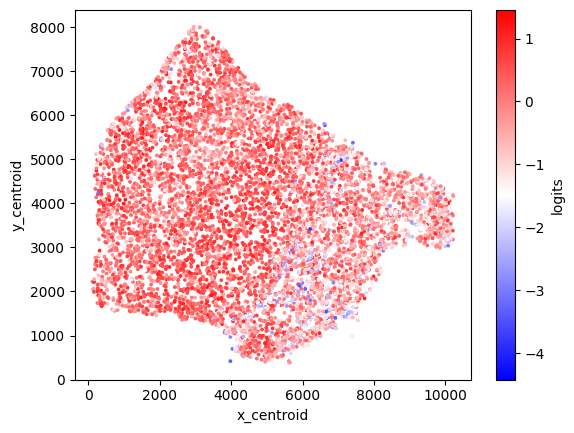

In [342]:
subset.obs.plot.scatter(x="x_centroid", y="y_centroid", c="logits", cmap="bwr", s=3)

# Last one